In [ ]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set_style("whitegrid")
from sklearn.metrics import classification_report
# Import necessary modules from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer, OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score
# Import other necessary libraries
import pickle
from prettytable import PrettyTable
from tqdm import tqdm
import sys
import warnings

# Filter out warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
!pip install scikit-learn==1.2.2

In [ ]:
import sklearn
sklearn.__version__

'1.2.2'

## 1.1 Reading Data

In [ ]:
data = pd.read_csv('in-vehicle-coupon-recommendation.csv')
data.head()

destination  passanger weather  temperature  time  \
0  No Urgent Place      Alone   Sunny           55   2PM   
1  No Urgent Place  Friend(s)   Sunny           80  10AM   
2  No Urgent Place  Friend(s)   Sunny           80  10AM   
3  No Urgent Place  Friend(s)   Sunny           80   2PM   
4  No Urgent Place  Friend(s)   Sunny           80   2PM   

                  coupon expiration  gender age      maritalStatus  ...  \
0        Restaurant(<20)         1d  Female  21  Unmarried partner  ...   
1           Coffee House         2h  Female  21  Unmarried partner  ...   
2  Carry out & Take away         2h  Female  21  Unmarried partner  ...   
3           Coffee House         2h  Female  21  Unmarried partner  ...   
4           Coffee House         1d  Female  21  Unmarried partner  ...   

   CoffeeHouse CarryAway RestaurantLessThan20 Restaurant20To50  \
0        never       NaN                  4~8              1~3   
1        never       NaN                  4~8              1~3   
2        never       NaN                  4~8              1~3   
3        never       NaN                  4~8              1~3   
4        never       NaN                  4~8              1~3   

  toCoupon_GEQ5min toCoupon_GEQ15min toCoupon_GEQ25min direction_same  \
0                1                 0                 0              0   
1                1                 0                 0              0   
2                1                 1                 0              0   
3                1                 1                 0              0   
4                1                 1                 0              0   

  direction_opp  Y  
0             1  1  
1             1  0  
2             1  1  
3             1  0  
4             1  0  

[5 rows x 26 columns]

In [ ]:
print("Number of data points:", data.shape[0])
print("Number of features:", data.shape[1])
print('-'*100)
print("The attributes of data :", data.columns.values)

Number of data points: 12684
Number of features: 26
----------------------------------------------------------------------------------------------------
The attributes of data : ['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'occupation' 'income' 'car' 'Bar' 'CoffeeHouse' 'CarryAway'
 'RestaurantLessThan20' 'Restaurant20To50' 'toCoupon_GEQ5min'
 'toCoupon_GEQ15min' 'toCoupon_GEQ25min' 'direction_same' 'direction_opp'
 'Y']


In [ ]:
# Group the data by the target variable 'Y' and count the number of instances for each value
Y_value_counts = data.groupby('Y').Y.count()

# Print out the number of accepted coupons and its percentage
print('The number of users that are accepted the coupon is ',Y_value_counts[1],',',round(Y_value_counts[1]/data.shape[0]*100,3),'%')

# Print out the number of rejected coupons and its percentage
print('The number of users that are rejected the coupon is ',Y_value_counts[0],',',round(Y_value_counts[0]/data.shape[0]*100,3),'%')

The number of users that are accepted the coupon is  7210 , 56.843 %
The number of users that are rejected the coupon is  5474 , 43.157 %


## 1.2 Train Test Split

In [ ]:
X = data.drop(['Y'], axis=1)
y = data['Y'].values

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y,random_state=42, shuffle=True)

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10147, 25) (10147,)
(2537, 25) (2537,)


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10147 entries, 9553 to 11504
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           10147 non-null  object
 1   passanger             10147 non-null  object
 2   weather               10147 non-null  object
 3   temperature           10147 non-null  int64 
 4   time                  10147 non-null  object
 5   coupon                10147 non-null  object
 6   expiration            10147 non-null  object
 7   gender                10147 non-null  object
 8   age                   10147 non-null  object
 9   maritalStatus         10147 non-null  object
 10  has_children          10147 non-null  int64 
 11  education             10147 non-null  object
 12  occupation            10147 non-null  object
 13  income                10147 non-null  object
 14  car                   82 non-null     object
 15  Bar                   10060 non-n

## 1.3 Data Cleaning

In [ ]:
# Remove any duplicate rows that may exist in the data
duplicate = data[data.duplicated(keep = 'last')]

# Print the shape of the duplicated data to check for duplicates
# duplicate.shape #(74, 26)

# Drop the duplicate rows from the original data
data = data.drop_duplicates()

# Print the shape of the cleaned data without duplicates
print(data.shape)

# By removing duplicates, we ensure each data point is unique to avoid biased/incorrect results during modelling.

(12610, 26)


__Missing Values__

In [ ]:
# Check for missing values
print('Is there any missing value present or not?',data.isnull().values.any())

# Calculate percentage of missing values in each column
missing_percentage = data.isnull().sum()*100/len(data)

# Create a dataframe showing missing count and percentage
missing_value_df = pd.DataFrame({'missing_count': data.isnull().sum(),'missing_percentage': missing_percentage})

# Print only columns that have missing values
missing_value_df[missing_value_df.missing_count != 0]

# Checking for missing values is important as they can impact model performance if present.
# This code identifies columns with missing data and corresponding percentages to help address them appropriately via imputation or dropping.

Is there any missing value present or not? True


missing_count  missing_percentage
car                           12502           99.143537
Bar                             107            0.848533
CoffeeHouse                     217            1.720856
CarryAway                       150            1.189532
RestaurantLessThan20            129            1.022998
Restaurant20To50                189            1.498810

In [ ]:
# Drop the 'car' feature variable from both training and test sets
X_train = X_train.drop(['car'], axis=1)

# Drop the 'car' feature variable from both training and test sets
X_test = X_test.drop(['car'], axis=1)

# The 'car' feature is being removed from both sets to ensure consistency and prevent data leakage.
# Testing data should not contain any features available during training to get an accurate assessment of model performance.

__Correlation of Features__

In [ ]:
X_train.corr() #Calculates the correlation between features in the training data

temperature  has_children  toCoupon_GEQ5min  \
temperature           1.000000     -0.023262               NaN   
has_children         -0.023262      1.000000               NaN   
toCoupon_GEQ5min           NaN           NaN               NaN   
toCoupon_GEQ15min    -0.155788      0.075488               NaN   
toCoupon_GEQ25min    -0.218036     -0.014869               NaN   
direction_same        0.087731     -0.031704               NaN   
direction_opp        -0.087731      0.031704               NaN   

                   toCoupon_GEQ15min  toCoupon_GEQ25min  direction_same  \
temperature                -0.155788          -0.218036        0.087731   
has_children                0.075488          -0.014869       -0.031704   
toCoupon_GEQ5min                 NaN                NaN             NaN   
toCoupon_GEQ15min           1.000000           0.324308       -0.308626   
toCoupon_GEQ25min           0.324308           1.000000       -0.193239   
direction_same             -0.308626          -0.193239        1.000000   
direction_opp               0.308626           0.193239       -1.000000   

                   direction_opp  
temperature            -0.087731  
has_children            0.031704  
toCoupon_GEQ5min             NaN  
toCoupon_GEQ15min       0.308626  
toCoupon_GEQ25min       0.193239  
direction_same         -1.000000  
direction_opp           1.000000

In [ ]:
X_train = X_train.drop(['direction_opp','toCoupon_GEQ5min'], axis=1) #Remove unnecessary features from training data
X_test = X_test.drop(['direction_opp','toCoupon_GEQ5min'], axis=1) #Remove the same features from test data
X_train.shape, X_test.shape #Check the new shapes after dropping features

((10147, 22), (2537, 22))

In [ ]:
X_train.describe()
# X_train.describe(include='all')

temperature  has_children  toCoupon_GEQ15min  toCoupon_GEQ25min  \
count  10147.000000  10147.000000       10147.000000       10147.000000   
mean      63.307874      0.413718           0.566473           0.120824   
std       19.153550      0.492523           0.495586           0.325939   
min       30.000000      0.000000           0.000000           0.000000   
25%       55.000000      0.000000           0.000000           0.000000   
50%       80.000000      0.000000           1.000000           0.000000   
75%       80.000000      1.000000           1.000000           0.000000   
max       80.000000      1.000000           1.000000           1.000000   

       direction_same  
count    10147.000000  
mean         0.213659  
std          0.409909  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          1.000000

## 1.4 Mode Imputation

In [ ]:
print('Is there any missing value present or not?',X_train.isnull().values.any())

Is there any missing value present or not? True


In [ ]:
# mode imputation for missing values in train data
X_train['Bar'] = X_train['Bar'].fillna(X_train['Bar'].value_counts().index[0]) #Fill missing values in 'Bar' column with most common value
X_train['CoffeeHouse'] = X_train['CoffeeHouse'].fillna(X_train['CoffeeHouse'].value_counts().index[0]) #Fill missing values in 'CoffeeHouse' column with most common value
X_train['CarryAway'] = X_train['CarryAway'].fillna(X_train['CarryAway'].value_counts().index[0]) #Fill missing values in 'CarryAway' column with most common value
X_train['RestaurantLessThan20'] = X_train['RestaurantLessThan20'].fillna(X_train['RestaurantLessThan20'].value_counts().index[0]) #Fill missing values in 'RestaurantLessThan20' column with most common value
X_train['Restaurant20To50'] = X_train['Restaurant20To50'].fillna(X_train['Restaurant20To50'].value_counts().index[0]) #Fill missing values in 'Restaurant20To50' column with most common value

In [ ]:
# mode imputation for missing values in test data
X_test['Bar'] = X_test['Bar'].fillna(X_train['Bar'].value_counts().index[0])
X_test['CoffeeHouse'] = X_test['CoffeeHouse'].fillna(X_train['CoffeeHouse'].value_counts().index[0])
X_test['CarryAway'] = X_test['CarryAway'].fillna(X_train['CarryAway'].value_counts().index[0])
X_test['RestaurantLessThan20'] = X_test['RestaurantLessThan20'].fillna(X_train['RestaurantLessThan20'].value_counts().index[0])
X_test['Restaurant20To50'] = X_test['Restaurant20To50'].fillna(X_train['Restaurant20To50'].value_counts().index[0])

In [ ]:
print('Is there any missing value present in X_train?',X_train.isnull().values.any())

Is there any missing value present in X_train? False


In [ ]:
print('Is there any missing value present in X_test?',X_test.isnull().values.any())

Is there any missing value present in X_test? False


## 1.5 Feature Engineering

__to_Coupon__

In [ ]:
# FE -- to_Coupon is a combination of the toCoupon_GEQ15min and toCoupon_GEQ25min features.
# Create a new 'to_Coupon' column that combines the values from the existing 'toCoupon_GEQ15min' and 'toCoupon_GEQ25min' columns
to_Coupon = []
for i in range(X_train.shape[0]):
    if (list(X_train['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(X_train['toCoupon_GEQ15min'])[i] == 1)and(list(X_train['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)

X_train['to_Coupon'] = to_Coupon
print('Unique values:',X_train['to_Coupon'].unique())
print('-'*50)
X_train['to_Coupon'].describe()

Unique values: [1 0 2]
--------------------------------------------------


count    10147.000000
mean         0.687297
std          0.675731
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: to_Coupon, dtype: float64

In [ ]:
# Create the same 'to_Coupon' column for X_test dataset
to_Coupon = []
for i in range(X_test.shape[0]):
    if (list(X_test['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(X_test['toCoupon_GEQ15min'])[i] == 1)and(list(X_test['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)

X_test['to_Coupon'] = to_Coupon
print('Unique values:',X_test['to_Coupon'].unique())
print('-'*50)
X_test['to_Coupon'].describe()

# Combine the 'toCoupon_GEQ15min' and 'toCoupon_GEQ25min' features for X_test dataset as well

Unique values: [0 1 2]
--------------------------------------------------


count    2537.000000
mean        0.653922
std         0.671685
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: to_Coupon, dtype: float64

**FE** -- __coupon_freq__

In [ ]:
# FE -- coupon_freq is a combination of five features: RestaurantLessThan20, CoffeeHouse, CarryAway, Bar, Restaurant20To50
# Create a new 'coupon_freq' column that maps the value of existing columns based on the 'coupon' column
coupon_freq = []
for i in range(X_train.shape[0]):
    if (list(X_train['coupon'])[i] == 'Restaurant(<20)'):
        coupon_freq.append(list(X_train['RestaurantLessThan20'])[i])
    elif (list(X_train['coupon'])[i] == 'Coffee House'):
        coupon_freq.append(list(X_train['CoffeeHouse'])[i])
    elif (list(X_train['coupon'])[i] == 'Carry out & Take away'):
        coupon_freq.append(list(X_train['CarryAway'])[i])
    elif (list(X_train['coupon'])[i] == 'Bar'):
        coupon_freq.append(list(X_train['Bar'])[i])
    elif (list(X_train['coupon'])[i] == 'Restaurant(20-50)'):
        coupon_freq.append(list(X_train['Restaurant20To50'])[i])

X_train['coupon_freq'] = coupon_freq
print('Unique values:',X_train['coupon_freq'].unique())
print('-'*50)
X_train['coupon_freq'].describe()

# Map values of existing columns to new 'coupon_freq' column based on 'coupon' column

Unique values: ['less1' '1~3' '4~8' 'gt8' 'never']
--------------------------------------------------


count     10147
unique        5
top         1~3
freq       3142
Name: coupon_freq, dtype: object

In [ ]:
# Create the same 'coupon_freq' column for X_test dataset
coupon_freq = []
for i in range(X_test.shape[0]):
    if (list(X_test['coupon'])[i] == 'Restaurant(<20)'):
        coupon_freq.append(list(X_test['RestaurantLessThan20'])[i])
    elif (list(X_test['coupon'])[i] == 'Coffee House'):
        coupon_freq.append(list(X_test['CoffeeHouse'])[i])
    elif (list(X_test['coupon'])[i] == 'Carry out & Take away'):
        coupon_freq.append(list(X_test['CarryAway'])[i])
    elif (list(X_test['coupon'])[i] == 'Bar'):
        coupon_freq.append(list(X_test['Bar'])[i])
    elif (list(X_test['coupon'])[i] == 'Restaurant(20-50)'):
        coupon_freq.append(list(X_test['Restaurant20To50'])[i])

X_test['coupon_freq'] = coupon_freq
print('Unique values:',X_test['coupon_freq'].unique())
print('-'*50)
X_test['coupon_freq'].describe()

# Map the values of existing columns to new 'coupon_freq' column for X_test as well, based on 'coupon' column

Unique values: ['less1' '1~3' 'never' '4~8' 'gt8']
--------------------------------------------------


count     2537
unique       5
top        1~3
freq       750
Name: coupon_freq, dtype: object

**FE** -- __occupation_class__

In [ ]:
X_train['occupation'].describe()

count          10147
unique            25
top       Unemployed
freq            1504
Name: occupation, dtype: object

In [ ]:
# FE - Occupation_class, which categorizes all occupations into appropriate classes
occupation_dict = {'Healthcare Support':'High_Acceptance','Construction & Extraction':'High_Acceptance','Healthcare Practitioners & Technical':'High_Acceptance',
                   'Protective Service':'High_Acceptance','Architecture & Engineering':'High_Acceptance','Production Occupations':'Medium_High_Acceptance',
                    'Student':'Medium_High_Acceptance','Office & Administrative Support':'Medium_High_Acceptance','Transportation & Material Moving':'Medium_High_Acceptance',
                    'Building & Grounds Cleaning & Maintenance':'Medium_High_Acceptance','Management':'Medium_Acceptance','Food Preparation & Serving Related':'Medium_Acceptance',
                   'Life Physical Social Science':'Medium_Acceptance','Business & Financial':'Medium_Acceptance','Computer & Mathematical':'Medium_Acceptance',
                    'Sales & Related':'Medium_Low_Acceptance','Personal Care & Service':'Medium_Low_Acceptance','Unemployed':'Medium_Low_Acceptance',
                   'Farming Fishing & Forestry':'Medium_Low_Acceptance','Installation Maintenance & Repair':'Medium_Low_Acceptance','Education&Training&Library':'Low_Acceptance',
                    'Arts Design Entertainment Sports & Media':'Low_Acceptance','Community & Social Services':'Low_Acceptance','Legal':'Low_Acceptance','Retired':'Low_Acceptance'}
# Map occupations to classes using the dictionary
X_train['occupation_class'] = X_train['occupation'].map(occupation_dict)
print('Unique values:',X_train['occupation_class'].unique())
print('-'*50)
X_train['occupation_class'].describe()
X_train['occupation_class'].value_counts()

Unique values: ['Medium_High_Acceptance' 'Low_Acceptance' 'Medium_Low_Acceptance'
 'Medium_Acceptance' 'High_Acceptance']
--------------------------------------------------


Medium_Low_Acceptance     2650
Medium_Acceptance         2579
Medium_High_Acceptance    2060
Low_Acceptance            2052
High_Acceptance            806
Name: occupation_class, dtype: int64

In [ ]:
X_test['occupation'].describe()

count           2537
unique            25
top       Unemployed
freq             366
Name: occupation, dtype: object

In [ ]:
# Map occupations to classes for X_test as well
occupation_dict = {'Healthcare Support':'High_Acceptance','Construction & Extraction':'High_Acceptance','Healthcare Practitioners & Technical':'High_Acceptance',
                   'Protective Service':'High_Acceptance','Architecture & Engineering':'High_Acceptance','Production Occupations':'Medium_High_Acceptance',
                    'Student':'Medium_High_Acceptance','Office & Administrative Support':'Medium_High_Acceptance','Transportation & Material Moving':'Medium_High_Acceptance',
                    'Building & Grounds Cleaning & Maintenance':'Medium_High_Acceptance','Management':'Medium_Acceptance','Food Preparation & Serving Related':'Medium_Acceptance',
                   'Life Physical Social Science':'Medium_Acceptance','Business & Financial':'Medium_Acceptance','Computer & Mathematical':'Medium_Acceptance',
                    'Sales & Related':'Medium_Low_Acceptance','Personal Care & Service':'Medium_Low_Acceptance','Unemployed':'Medium_Low_Acceptance',
                   'Farming Fishing & Forestry':'Medium_Low_Acceptance','Installation Maintenance & Repair':'Medium_Low_Acceptance','Education&Training&Library':'Low_Acceptance',
                    'Arts Design Entertainment Sports & Media':'Low_Acceptance','Community & Social Services':'Low_Acceptance','Legal':'Low_Acceptance','Retired':'Low_Acceptance'}
# occupation_dict
X_test['occupation_class'] = X_test['occupation'].map(occupation_dict)
print('Unique values:',X_test['occupation_class'].unique())
print('-'*50)
X_test['occupation_class'].describe()
# Map occupation to classes for test data as well

Unique values: ['High_Acceptance' 'Medium_Acceptance' 'Low_Acceptance'
 'Medium_High_Acceptance' 'Medium_Low_Acceptance']
--------------------------------------------------


count                  2537
unique                    5
top       Medium_Acceptance
freq                    679
Name: occupation_class, dtype: object

In [ ]:
X_train = X_train.drop(['occupation'], axis=1) #Remove original 'occupation' column after creating 'occupation_class'
X_test = X_test.drop(['occupation'], axis=1) #Remove original 'occupation' column from test data

print('X_train:',X_train.shape,'\nX_test:',X_test.shape)
print('-'*50)
print(X_train.columns.values)

# Drop original 'occupation' column which is no longer needed after feature engineering to create 'occupation_class'

X_train: (10147, 24) 
X_test: (2537, 24)
--------------------------------------------------
['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'income' 'Bar' 'CoffeeHouse' 'CarryAway' 'RestaurantLessThan20'
 'Restaurant20To50' 'toCoupon_GEQ15min' 'toCoupon_GEQ25min'
 'direction_same' 'to_Coupon' 'coupon_freq' 'occupation_class']


## 1.6 Encoding

### 1.6.1 Ordinal Encoding

In [ ]:
order = [['Work','Home','No Urgent Place'],['Kid(s)','Alone','Partner','Friend(s)'],['Rainy','Snowy','Sunny'],[30,55,80],['7AM','10AM','2PM','6PM','10PM'],
         ['Bar','Restaurant(20-50)','Coffee House','Restaurant(<20)','Carry out & Take away'],['2h','1d'],['Female','Male'],['below21','21','26','31','36','41','46','50plus'],
         ['Widowed','Divorced','Married partner','Unmarried partner','Single'],[0,1],
         ['Some High School','High School Graduate','Some college - no degree','Associates degree','Bachelors degree','Graduate degree (Masters or Doctorate)'],
         ['Less than $12500','$12500 - $24999','$25000 - $37499','$37500 - $49999','$50000 - $62499','$62500 - $74999','$75000 - $87499','$87500 - $99999','$100000 or More'],
         ['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],['never','less1','1~3','4~8','gt8'],
         [0,1],[0,1],[0,1],[0,1,2],['never','less1','1~3','4~8','gt8'],['Low_Acceptance','Medium_Low_Acceptance','Medium_Acceptance','Medium_High_Acceptance','High_Acceptance']]

In [ ]:
# Perform ordinal encoding on X_train data
Ordinal_enc = OrdinalEncoder(categories=order)
X_train_Ordinal_encoding = Ordinal_enc.fit_transform(X_train)

X_train_Ordinal_encoding = pd.DataFrame(X_train_Ordinal_encoding,columns=X_train.columns.values)

print('X_train_Ordinal_encoding:',X_train_Ordinal_encoding.shape)

# Encode categorical features in X_train using OrdinalEncoder and view the shape of encoded dataframe

X_train_Ordinal_encoding: (10147, 24)


In [ ]:
# Perform ordinal encoding on X_test data using same OrdinalEncoder instance
Ordinal_enc = OrdinalEncoder(categories=order)
X_test_Ordinal_encoding = Ordinal_enc.fit_transform(X_test)
X_test_Ordinal_encoding = pd.DataFrame(X_test_Ordinal_encoding,columns=X_test.columns.values)
print('X_test_Ordinal_encoding:',X_test_Ordinal_encoding.shape)

# Encode categorical features in X_test using the OrdinalEncoder trained on X_train and view the shape of encoded X_test dataframe

X_test_Ordinal_encoding: (2537, 24)


### 1.6.2 Frequency Encoding

In [ ]:
# Function to perform frequency encoding on a column
def frequency_enc(column_name,X):

  """
  It returns frequency encoded feature by mapping each unique value in the
  column to its frequency/counts in the dataframe
  """

  return X[column_name].map(X.groupby(column_name).size()/len(X))

# Define a function that takes column name and dataframe as input and returns the frequency encoded feature

In [ ]:
# Perform Frequency Encoding on X_train

X_train_frequency_encoding = pd.DataFrame()

for i in range(X_train.shape[1]):

  X_train_frequency_encoding[X_train.columns.values[i]+'_freq_enc'] = frequency_enc(X_train.columns.values[i],X_train)


print('X_train_frequency_encoding:',X_train_frequency_encoding.shape)


# Apply frequency encoding to each column of X_train using defined function
# and store in a new dataframe

X_train_frequency_encoding: (10147, 24)


In [ ]:
# Perform Frequency Encoding on X_test

X_test_frequency_encoding = pd.DataFrame()

for i in range(X_test.shape[1]):

  X_test_frequency_encoding[X_test.columns.values[i]+'_freq_enc'] = frequency_enc(X_test.columns.values[i],X_test)


print('X_test_frequency_encoding:',X_test_frequency_encoding.shape)


# Apply frequency encoding to each column of X_test using same frequency_enc function
# and store in a new dataframe for X_test

# Perform frequency encoding on test data as well for consistency

X_test_frequency_encoding: (2537, 24)


### 1.6.3 Target Encoding

In [ ]:
# Function to perform target encoding on a column for train data
def target_enc(column_name,X):

  """
  It returns target encoded feature by mapping each unique value
  in the column to mean of target/Y column
  """

  X['Y_train'] = y_train
  return X[column_name].map(X.groupby(column_name)['Y_train'].mean())


# Apply target encoding to each column of X_train
X_train_target_encoding = pd.DataFrame()

for i in range(X_train.shape[1]):

  X_train_target_encoding[X_train.columns.values[i]+'_target_enc'] = target_enc(X_train.columns.values[i],X_train)


print('X_train_target_encoding:',X_train_target_encoding.shape)

# Target encode columns of X_train and store in new dataframe

X_train_target_encoding: (10147, 24)


In [ ]:
# Function to perform target encoding on test data
def target_enc(column_name,X):

  """
  It returns target encoded feature by mapping each unique value
  in the column to mean of target/Y column for test data
  """

  X['Y_test'] = y_test
  return X[column_name].map(X.groupby(column_name)['Y_test'].mean())


# Apply target encoding to each column of X_test
X_test_target_encoding = pd.DataFrame()

for i in range(X_test.shape[1]):

  X_test_target_encoding[X_test.columns.values[i]+'_target_enc'] = target_enc(X_test.columns.values[i],X_test)


print('X_test_target_encoding:',X_test_target_encoding.shape)

# Target encode columns of X_test and store in new dataframe
# for test data

X_test_target_encoding: (2537, 24)


### 1.6.4 Response Encoding

In [ ]:
# response encoding function
def response_coding(feature,X,Y):
    """It returns Response encoded feature"""
    X[feature] = X[feature].str.replace('~','_')
    X[feature] = X[feature].str.replace('[^a-zA-Z0-9_ ]',' ')
    X[feature] = X[feature].str.replace(' +',' ')
    X[feature] = X[feature].str.strip()
    X[feature] = X[feature].str.replace(' ','_')
    X[feature] = X[feature].str.lower()
    response_code_0 = [];response_code_1 = []
    unique_cat_features = X[feature].unique()
    unique_cat_features = np.sort(unique_cat_features)
    for i in range(len(unique_cat_features)):
        total_count = X[feature][(X[feature] == unique_cat_features[i])].count()
        p0 = (X[feature][((X[feature] == unique_cat_features[i]) & (Y==0))].count())/total_count
        p1 = (X[feature][((X[feature] == unique_cat_features[i]) & (Y==1))].count())/total_count
        response_code_0.append(p0);response_code_1.append(p1)
    dict_response_code_0 = dict(zip(unique_cat_features, response_code_0))
    dict_response_code_1 = dict(zip(unique_cat_features, response_code_1))
    X_response_0 = X[feature].map(dict_response_code_0)
    X_response_1 = X[feature].map(dict_response_code_1)
    X_response_0 = X_response_0.values.reshape(-1,1)
    X_response_1 = X_response_1.values.reshape(-1,1)
    return X_response_0,X_response_1

In [ ]:
X_train_destination_0,X_train_destination_1 = response_coding('destination',X_train,y_train)
X_train_passanger_0,X_train_passanger_1 = response_coding('passanger',X_train,y_train)
X_train_weather_0,X_train_weather_1 = response_coding('weather',X_train,y_train)
X_train_time_0,X_train_time_1 = response_coding('time',X_train,y_train)
X_train_coupon_0,X_train_coupon_1 = response_coding('coupon',X_train,y_train)
X_train_expiration_0,X_train_expiration_1 = response_coding('expiration',X_train,y_train)
X_train_gender_0,X_train_gender_1 = response_coding('gender',X_train,y_train)
X_train_age_0,X_train_age_1 = response_coding('age',X_train,y_train)
X_train_maritalStatus_0,X_train_maritalStatus_1 = response_coding('maritalStatus',X_train,y_train)
X_train_education_0,X_train_education_1 = response_coding('education',X_train,y_train)
X_train_income_0,X_train_income_1 = response_coding('income',X_train,y_train)
X_train_Bar_0,X_train_Bar_1 = response_coding('Bar',X_train,y_train)
X_train_CoffeeHouse_0,X_train_CoffeeHouse_1 = response_coding('CoffeeHouse',X_train,y_train)
X_train_CarryAway_0,X_train_CarryAway_1 = response_coding('CarryAway',X_train,y_train)
X_train_RestaurantLessThan20_0,X_train_RestaurantLessThan20_1 = response_coding('RestaurantLessThan20',X_train,y_train)
X_train_Restaurant20To50_0,X_train_Restaurant20To50_1 = response_coding('Restaurant20To50',X_train,y_train)
X_train_coupon_freq_0,X_train_coupon_freq_1 = response_coding('coupon_freq',X_train,y_train)
X_train_occupation_class_0,X_train_occupation_class_1 = response_coding('occupation_class',X_train,y_train)

X_test_destination_0,X_test_destination_1 = response_coding('destination',X_test,y_test)
X_test_passanger_0,X_test_passanger_1 = response_coding('passanger',X_test,y_test)
X_test_weather_0,X_test_weather_1 = response_coding('weather',X_test,y_test)
X_test_time_0,X_test_time_1 = response_coding('time',X_test,y_test)
X_test_coupon_0,X_test_coupon_1 = response_coding('coupon',X_test,y_test)
X_test_expiration_0,X_test_expiration_1 = response_coding('expiration',X_test,y_test)
X_test_gender_0,X_test_gender_1 = response_coding('gender',X_test,y_test)
X_test_age_0,X_test_age_1 = response_coding('age',X_test,y_test)
X_test_maritalStatus_0,X_test_maritalStatus_1 = response_coding('maritalStatus',X_test,y_test)
X_test_education_0,X_test_education_1 = response_coding('education',X_test,y_test)
X_test_income_0,X_test_income_1 = response_coding('income',X_test,y_test)
X_test_Bar_0,X_test_Bar_1 = response_coding('Bar',X_test,y_test)
X_test_CoffeeHouse_0,X_test_CoffeeHouse_1 = response_coding('CoffeeHouse',X_test,y_test)
X_test_CarryAway_0,X_test_CarryAway_1 = response_coding('CarryAway',X_test,y_test)
X_test_RestaurantLessThan20_0,X_test_RestaurantLessThan20_1 = response_coding('RestaurantLessThan20',X_test,y_test)
X_test_Restaurant20To50_0,X_test_Restaurant20To50_1 = response_coding('Restaurant20To50',X_test,y_test)
X_test_coupon_freq_0,X_test_coupon_freq_1 = response_coding('coupon_freq',X_test,y_test)
X_test_occupation_class_0,X_test_occupation_class_1 = response_coding('occupation_class',X_test,y_test)

In [ ]:
# Function to normalize numerical features
def norm(column_name,X):

  """
  It returns normalized feature by applying Normalizer
  """

  normalizer = Normalizer()
  normalizer.fit(X[column_name].values.reshape(-1,1))
  X_norm = normalizer.transform(X[column_name].values.reshape(-1,1))

  return X_norm.reshape(-1,1)

# Define function to normalize numerical columns using Normalizer
# and return normalized values

In [ ]:
X_train_temperature_norm = norm('temperature',X_train)
X_train_has_children_norm = norm('has_children',X_train)
X_train_toCoupon_GEQ15min_norm = norm('toCoupon_GEQ15min',X_train)
X_train_toCoupon_GEQ25min_norm = norm('toCoupon_GEQ25min',X_train)
X_train_direction_same_norm = norm('direction_same',X_train)
X_train_to_Coupon_norm = norm('to_Coupon',X_train)

X_test_temperature_norm = norm('temperature',X_test)
X_test_has_children_norm = norm('has_children',X_test)
X_test_toCoupon_GEQ15min_norm = norm('toCoupon_GEQ15min',X_test)
X_test_toCoupon_GEQ25min_norm = norm('toCoupon_GEQ25min',X_test)
X_test_direction_same_norm = norm('direction_same',X_test)
X_test_to_Coupon_norm = norm('to_Coupon',X_test)

In [ ]:
# Concat columns generated after feature engineering
X_train_response_encoding = np.hstack((X_train_destination_0,X_train_destination_1,X_train_passanger_0,X_train_passanger_1,X_train_weather_0,X_train_weather_1,X_train_time_0,X_train_time_1,X_train_coupon_0,X_train_coupon_1,X_train_expiration_0,X_train_expiration_1,X_train_gender_0,X_train_gender_1,X_train_age_0,X_train_age_1,X_train_maritalStatus_0,X_train_maritalStatus_1,X_train_education_0,X_train_education_1,X_train_income_0,X_train_income_1,X_train_coupon_freq_0,X_train_coupon_freq_1,X_train_occupation_class_0,X_train_occupation_class_1,X_train_Bar_0,X_train_Bar_1,X_train_CoffeeHouse_0,X_train_CoffeeHouse_1,X_train_CarryAway_0,X_train_CarryAway_1,X_train_RestaurantLessThan20_0,X_train_RestaurantLessThan20_1,X_train_Restaurant20To50_0,X_train_Restaurant20To50_1,X_train_temperature_norm,X_train_has_children_norm,X_train_toCoupon_GEQ15min_norm,X_train_toCoupon_GEQ25min_norm,X_train_direction_same_norm,X_train_to_Coupon_norm))
X_test_response_encoding = np.hstack((X_test_destination_0,X_test_destination_1,X_test_passanger_0,X_test_passanger_1,X_test_weather_0,X_test_weather_1,X_test_time_0,X_test_time_1,X_test_coupon_0,X_test_coupon_1,X_test_expiration_0,X_test_expiration_1,X_test_gender_0,X_test_gender_1,X_test_age_0,X_test_age_1,X_test_maritalStatus_0,X_test_maritalStatus_1,X_test_education_0,X_test_education_1,X_test_income_0,X_test_income_1,X_test_coupon_freq_0,X_test_coupon_freq_1,X_test_occupation_class_0,X_test_occupation_class_1,X_test_Bar_0,X_test_Bar_1,X_test_CoffeeHouse_0,X_test_CoffeeHouse_1,X_test_CarryAway_0,X_test_CarryAway_1,X_test_RestaurantLessThan20_0,X_test_RestaurantLessThan20_1,X_test_Restaurant20To50_0,X_test_Restaurant20To50_1 ,X_test_temperature_norm,X_test_has_children_norm,X_test_toCoupon_GEQ15min_norm,X_test_toCoupon_GEQ25min_norm,X_test_direction_same_norm,X_test_to_Coupon_norm))
print('X_train_response_encoding:',X_train_response_encoding.shape,'\nX_test_response_encoding:',X_test_response_encoding.shape)
# Combine all the engineered features vertically for model building

X_train_response_encoding: (10147, 42) 
X_test_response_encoding: (2537, 42)


### 1.6.5 One Hot Encoding

In [ ]:
# Function to perform one-hot encoding on a column
def ohe(column_name,X):

  """
  It returns one-hot encoded feature matrix
  """

  # Data cleaning steps
  X[column_name] = X[column_name].str.replace('~','_')
  X[column_name] = X[column_name].str.replace('[^a-zA-Z0-9_ ]',' ')
  X[column_name] = X[column_name].str.replace(' +',' ')
  X[column_name] = X[column_name].str.strip()
  X[column_name] = X[column_name].str.replace(' ','_')
  X[column_name] = X[column_name].str.lower()

  vectorizer = CountVectorizer(binary=True)
  return vectorizer.fit_transform(X[column_name].values)

# Define function for one-hot encoding categorical features
# and return sparse matrix

In [ ]:
# One-hot encode categorical columns in X_train
X_train_destination_ohe = ohe('destination',X_train)
X_train_passanger_ohe = ohe('passanger',X_train)
X_train_weather_ohe = ohe('weather',X_train)
X_train_time_ohe = ohe('time',X_train)
X_train_coupon_ohe = ohe('coupon',X_train)
X_train_expiration_ohe = ohe('expiration',X_train)
X_train_gender_ohe = ohe('gender',X_train)
X_train_age_ohe = ohe('age',X_train)
X_train_maritalStatus_ohe = ohe('maritalStatus',X_train)
X_train_education_ohe = ohe('education',X_train)
X_train_income_ohe = ohe('income',X_train)
X_train_Bar_ohe = ohe('Bar',X_train)
X_train_CoffeeHouse_ohe = ohe('CoffeeHouse',X_train)
X_train_CarryAway_ohe = ohe('CarryAway',X_train)
X_train_RestaurantLessThan20_ohe = ohe('RestaurantLessThan20',X_train)
X_train_Restaurant20To50_ohe = ohe('Restaurant20To50',X_train)
X_train_coupon_freq_ohe = ohe('coupon_freq',X_train)
X_train_occupation_class_ohe = ohe('occupation_class',X_train)
# and so on One-hot encode categorical columns in X_test
X_test_destination_ohe = ohe('destination',X_test)
X_test_passanger_ohe = ohe('passanger',X_test)
X_test_weather_ohe = ohe('weather',X_test)
X_test_time_ohe = ohe('time',X_test)
X_test_coupon_ohe = ohe('coupon',X_test)
X_test_expiration_ohe = ohe('expiration',X_test)
X_test_gender_ohe = ohe('gender',X_test)
X_test_age_ohe = ohe('age',X_test)
X_test_maritalStatus_ohe = ohe('maritalStatus',X_test)
X_test_education_ohe = ohe('education',X_test)
X_test_income_ohe = ohe('income',X_test)
X_test_Bar_ohe = ohe('Bar',X_test)
X_test_CoffeeHouse_ohe = ohe('CoffeeHouse',X_test)
X_test_CarryAway_ohe = ohe('CarryAway',X_test)
X_test_RestaurantLessThan20_ohe = ohe('RestaurantLessThan20',X_test)
X_test_Restaurant20To50_ohe = ohe('Restaurant20To50',X_test)
X_test_coupon_freq_ohe = ohe('coupon_freq',X_test)
X_test_occupation_class_ohe = ohe('occupation_class',X_test)
# and so on Apply one-hot encoding to categorical columns for both train and test separately

In [ ]:
# Function to normalize numerical features
def norm(column_name, X):

  """
  It returns normalized feature by applying Normalizer
  """

  normalizer = Normalizer()
  normalizer.fit(X[column_name].values.reshape(-1,1))
  X_norm = normalizer.transform(X[column_name].values.reshape(-1,1))

  return X_norm.reshape(-1,1)

# Define function to normalize numerical columns
# using Normalizer and return normalized values

In [ ]:
X_train_temperature_norm = norm('temperature',X_train)
X_train_has_children_norm = norm('has_children',X_train)
X_train_toCoupon_GEQ15min_norm = norm('toCoupon_GEQ15min',X_train)
X_train_toCoupon_GEQ25min_norm = norm('toCoupon_GEQ25min',X_train)
X_train_direction_same_norm = norm('direction_same',X_train)
X_train_to_Coupon_norm = norm('to_Coupon',X_train)

X_test_temperature_norm = norm('temperature',X_test)
X_test_has_children_norm = norm('has_children',X_test)
X_test_toCoupon_GEQ15min_norm = norm('toCoupon_GEQ15min',X_test)
X_test_toCoupon_GEQ25min_norm = norm('toCoupon_GEQ25min',X_test)
X_test_direction_same_norm = norm('direction_same',X_test)
X_test_to_Coupon_norm = norm('to_Coupon',X_test)

In [ ]:
from scipy.sparse import hstack
X_train_ohe = hstack((X_train_destination_ohe, X_train_passanger_ohe, X_train_weather_ohe, X_train_time_ohe, X_train_coupon_ohe, X_train_expiration_ohe, X_train_gender_ohe, X_train_age_ohe, X_train_maritalStatus_ohe, X_train_education_ohe, X_train_income_ohe, X_train_coupon_freq_ohe, X_train_occupation_class_ohe,X_train_Bar_ohe,X_train_CoffeeHouse_ohe,X_train_CarryAway_ohe,X_train_RestaurantLessThan20_ohe,X_train_Restaurant20To50_ohe,X_train_temperature_norm, X_train_has_children_norm,X_train_toCoupon_GEQ15min_norm,X_train_toCoupon_GEQ25min_norm,X_train_direction_same_norm,X_train_to_Coupon_norm)).tocsr()
X_test_ohe = hstack((X_test_destination_ohe, X_test_passanger_ohe, X_test_weather_ohe, X_test_time_ohe, X_test_coupon_ohe, X_test_expiration_ohe, X_test_gender_ohe, X_test_age_ohe, X_test_maritalStatus_ohe, X_test_education_ohe, X_test_income_ohe, X_test_coupon_freq_ohe, X_test_occupation_class_ohe,X_test_Bar_ohe,X_test_CoffeeHouse_ohe,X_test_CarryAway_ohe,X_test_RestaurantLessThan20_ohe,X_test_Restaurant20To50_ohe,X_test_temperature_norm, X_test_has_children_norm,X_test_toCoupon_GEQ15min_norm,X_test_toCoupon_GEQ25min_norm,X_test_direction_same_norm,X_test_to_Coupon_norm)).tocsr()
print('X_train_ohe:',X_train_ohe.shape,'\nX_test_ohe:',X_test_ohe.shape)

X_train_ohe: (10147, 93) 
X_test_ohe: (2537, 93)


## 1.7 Modeling

## 1.7.1 Support Vector Classification

#### Choose best kernel use F1

Average F1 score for Ordinal Encoding: 0.6865484966491434


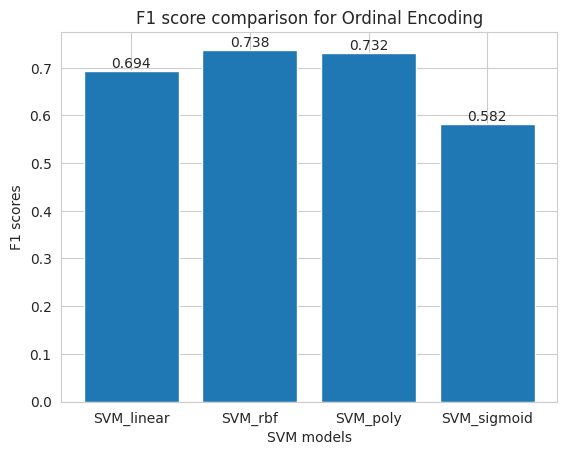

Average F1 score for Frequency Encoding: 0.5048499466810954


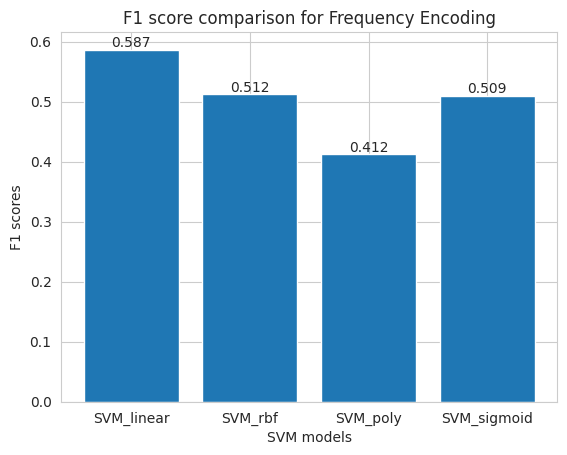

Average F1 score for Target Encoding: 0.6835754485286076


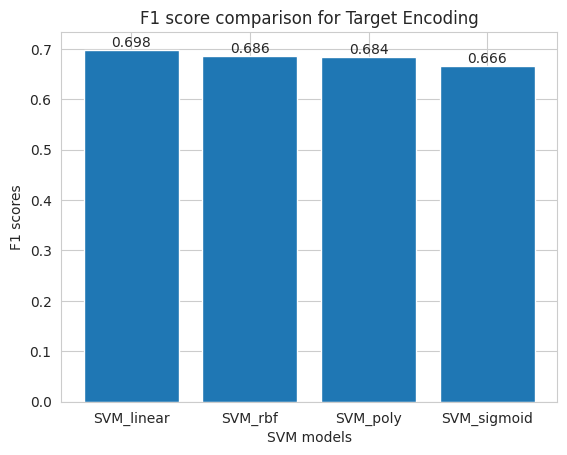

Average F1 score for Response Encoding: 0.6801254100908741


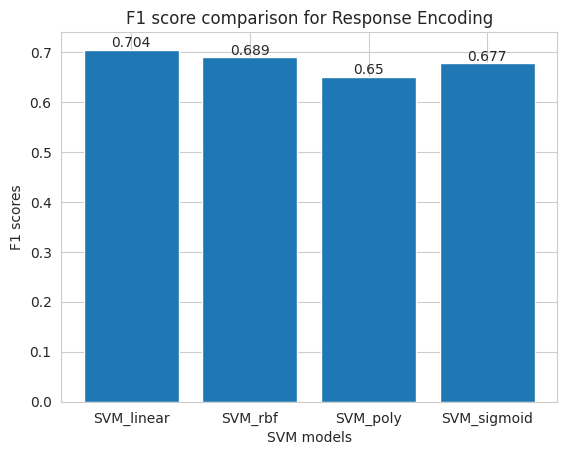

Average F1 score for One Hot Encoding: 0.6477770428166424


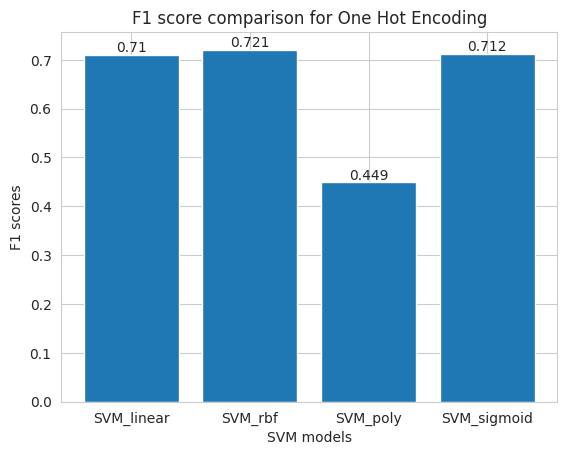

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np

def svm_evaluation_f1(X_train, y_train, X_test, y_test, encoding_method):
    # Instantiate and train SVM models
    SVM_linear = SVC(kernel="linear", random_state=42, probability=True, gamma='auto').fit(X_train, y_train)
    SVM_rbf = SVC(kernel="rbf", random_state=42, probability=True, gamma='auto').fit(X_train, y_train)
    SVM_poly = SVC(kernel="poly", random_state=42, probability=True, gamma='auto').fit(X_train, y_train)
    SVM_sigmoid = SVC(kernel="sigmoid", random_state=42, probability=True, gamma='auto').fit(X_train, y_train)

    # Predict the labels of the test dataset
    y_pred_SVM_linear = SVM_linear.predict(X_test)
    y_pred_SVM_rbf = SVM_rbf.predict(X_test)
    y_pred_SVM_poly = SVM_poly.predict(X_test)
    y_pred_SVM_sigmoid = SVM_sigmoid.predict(X_test)

    # Calculate the F1 scores of each model
    f1_scores = [
        classification_report(y_test, y_pred_SVM_linear, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_SVM_rbf, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_SVM_poly, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_SVM_sigmoid, output_dict=True)["weighted avg"]["f1-score"]
    ]

    # Print the average F1 score
    print(f"Average F1 score for {encoding_method}: {np.mean(f1_scores)}")

    # Plot F1 score comparison
    models = ["SVM_linear", "SVM_rbf", "SVM_poly", "SVM_sigmoid"]
    bars = plt.bar(models, f1_scores)
    plt.xlabel("SVM models")
    plt.ylabel("F1 scores")
    plt.title(f"F1 score comparison for {encoding_method}")

    # Add values on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    plt.show()

# Evaluate different encoding methods
svm_evaluation_f1(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
svm_evaluation_f1(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
svm_evaluation_f1(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
svm_evaluation_f1(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
svm_evaluation_f1(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

#### Choose best kernel use roc_auc_score

Average ROC AUC score for Ordinal Encoding: 0.7328228804488945


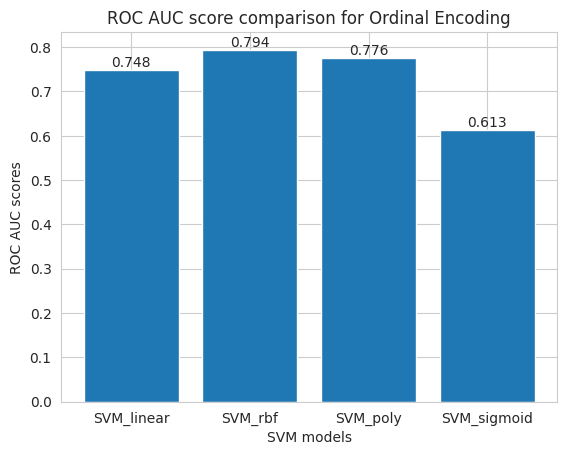

Average ROC AUC score for Frequency Encoding: 0.6284281407735325


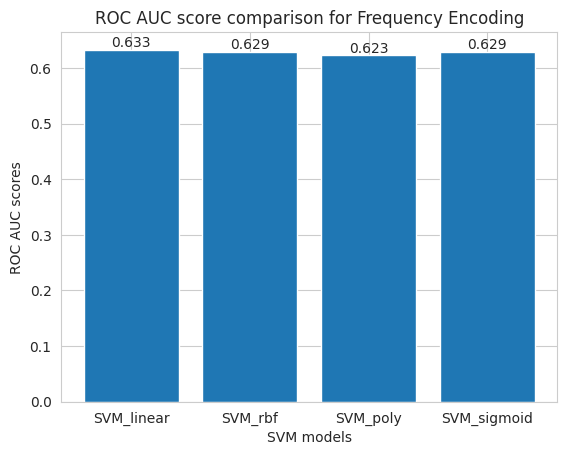

Average ROC AUC score for Target Encoding: 0.7497607647926838


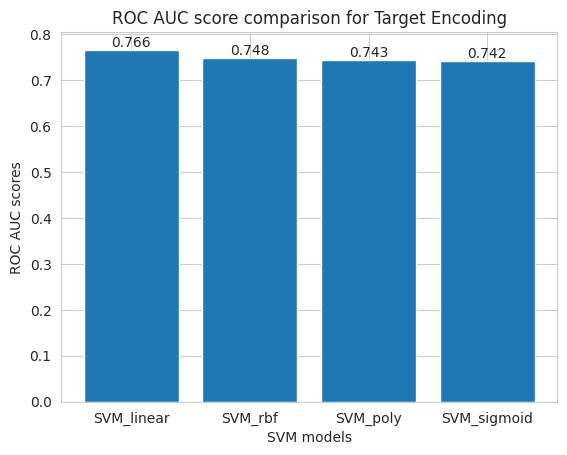

Average ROC AUC score for Response Encoding: 0.7473972286081608


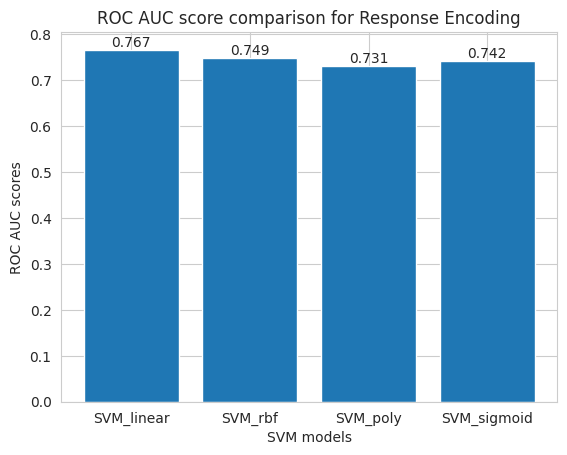

Average ROC AUC score for One Hot Encoding: 0.7692036523347203


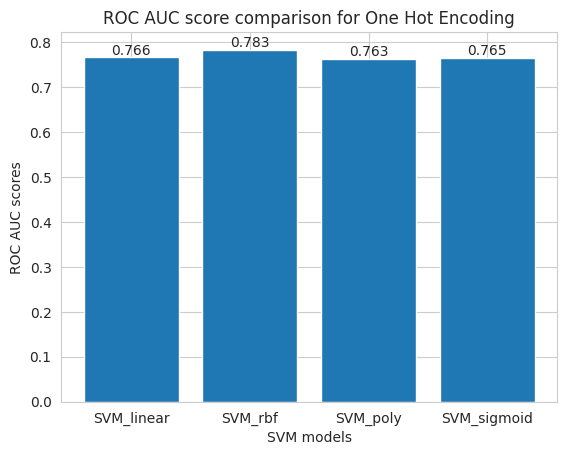

In [ ]:
def svm_evaluation(X_train, y_train, X_test, y_test, encoding_method):
    # Instantiate and train SVM models
    SVM_linear = SVC(kernel="linear", random_state=42, probability=True, gamma='auto').fit(X_train, y_train)
    SVM_rbf = SVC(kernel="rbf", random_state=42, probability=True, gamma='auto').fit(X_train, y_train)
    SVM_poly = SVC(kernel="poly", random_state=42, probability=True, gamma='auto').fit(X_train, y_train)
    SVM_sigmoid = SVC(kernel="sigmoid", random_state=42, probability=True, gamma='auto').fit(X_train, y_train)

    # Get the probabilities of each class
    y_prob_SVM_linear = SVM_linear.predict_proba(X_test)[:, 1]
    y_prob_SVM_rbf = SVM_rbf.predict_proba(X_test)[:, 1]
    y_prob_SVM_poly = SVM_poly.predict_proba(X_test)[:, 1]
    y_prob_SVM_sigmoid = SVM_sigmoid.predict_proba(X_test)[:, 1]

    # Calculate the ROC AUC scores of each model
    roc_auc_scores = [
        roc_auc_score(y_test, y_prob_SVM_linear),
        roc_auc_score(y_test, y_prob_SVM_rbf),
        roc_auc_score(y_test, y_prob_SVM_poly),
        roc_auc_score(y_test, y_prob_SVM_sigmoid)
    ]

    # Print the average ROC AUC score
    print(f"Average ROC AUC score for {encoding_method}: {np.mean(roc_auc_scores)}")

    # Plot ROC AUC score comparison
    models = ["SVM_linear", "SVM_rbf", "SVM_poly", "SVM_sigmoid"]
    bars = plt.bar(models, roc_auc_scores)
    plt.xlabel("SVM models")
    plt.ylabel("ROC AUC scores")
    plt.title(f"ROC AUC score comparison for {encoding_method}")

    # Add values on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    plt.show()

# Evaluate different encoding methods
svm_evaluation(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
svm_evaluation(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
svm_evaluation(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
svm_evaluation(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
svm_evaluation(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

#### Choose best kernel use log_loss

Average log loss for Ordinal Encoding: 0.5880616246148657


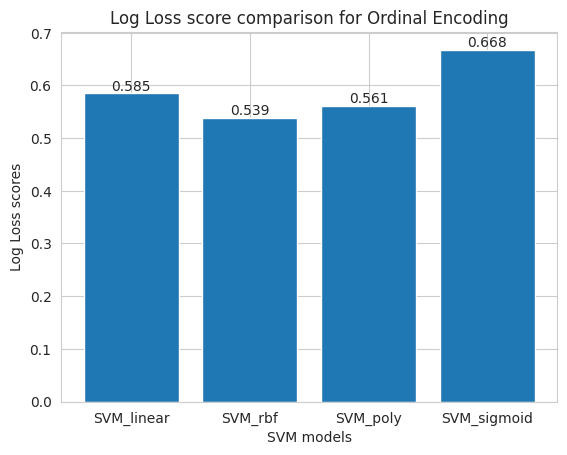

Average log loss for Frequency Encoding: 0.6684302394033957


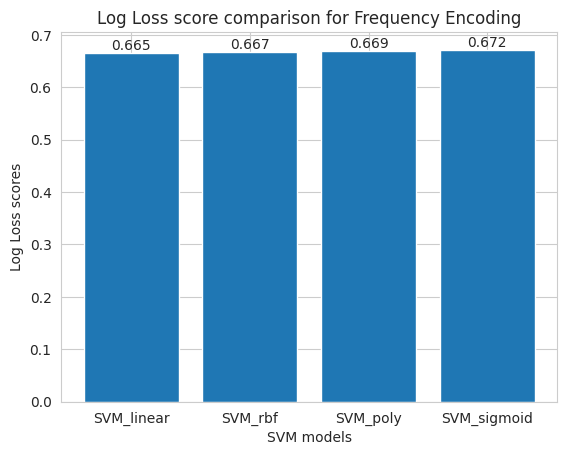

Average log loss for Target Encoding: 0.5861481457786071


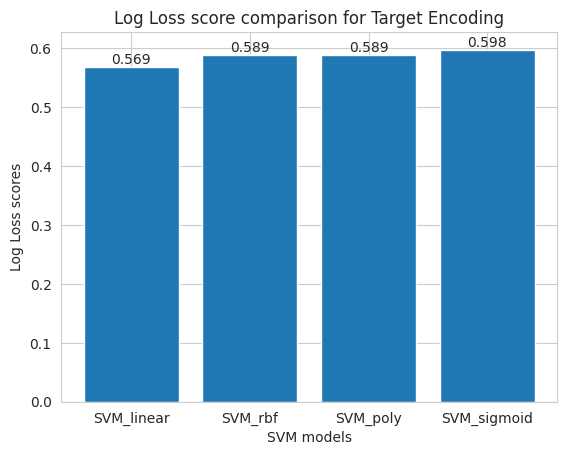

Average log loss for Response Encoding: 0.5854192249102085


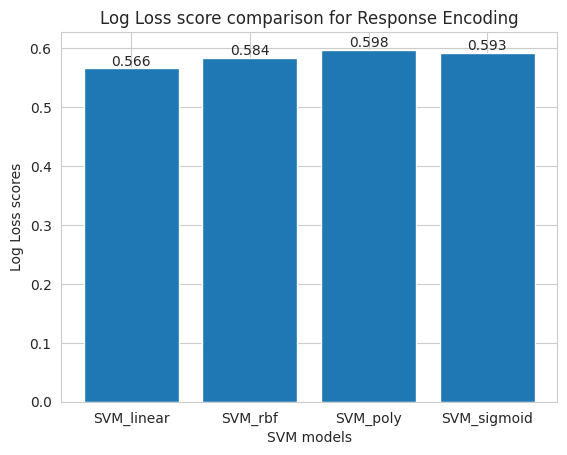

Average log loss for One Hot Encoding: 0.5676145301978566


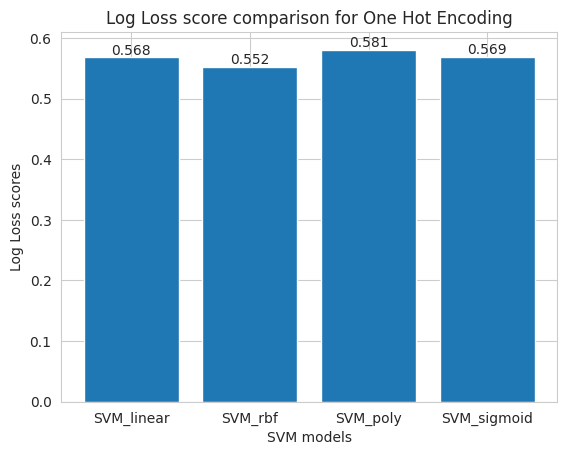

In [ ]:
def svm_evaluation_logloss(X_train, y_train, X_test, y_test, encoding_method):
    # Instantiate and train SVM models
    SVM_linear = SVC(kernel="linear", random_state=42, probability=True, gamma='auto').fit(X_train, y_train)
    SVM_rbf = SVC(kernel="rbf", random_state=42, probability=True, gamma='auto').fit(X_train, y_train)
    SVM_poly = SVC(kernel="poly", random_state=42, probability=True, gamma='auto').fit(X_train, y_train)
    SVM_sigmoid = SVC(kernel="sigmoid", random_state=42, probability=True, gamma='auto').fit(X_train, y_train)

    # Get the probabilities of each class
    y_prob_SVM_linear = SVM_linear.predict_proba(X_test)
    y_prob_SVM_rbf = SVM_rbf.predict_proba(X_test)
    y_prob_SVM_poly = SVM_poly.predict_proba(X_test)
    y_prob_SVM_sigmoid = SVM_sigmoid.predict_proba(X_test)

    # Calculate the log loss of each model
    log_losses = [
        log_loss(y_test, y_prob_SVM_linear),
        log_loss(y_test, y_prob_SVM_rbf),
        log_loss(y_test, y_prob_SVM_poly),
        log_loss(y_test, y_prob_SVM_sigmoid)
    ]

    # Print the average log loss
    print(f"Average log loss for {encoding_method}: {np.mean(log_losses)}")

    # Plot log loss comparison
    models = ["SVM_linear", "SVM_rbf", "SVM_poly", "SVM_sigmoid"]
    bars = plt.bar(models, log_losses)
    plt.xlabel("SVM models")
    plt.ylabel("Log Loss scores")
    plt.title(f"Log Loss score comparison for {encoding_method}")

    # Add values on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    plt.show()

# Evaluate different encoding methods
svm_evaluation_logloss(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
svm_evaluation_logloss(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
svm_evaluation_logloss(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
svm_evaluation_logloss(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
svm_evaluation_logloss(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

### 1.7.1.2 Hyperparameter Tuning for SVC_rbf Model using RandomizedSearchCV and TQDM Find best C

In [ ]:
## TQDM version
from tqdm import tqdm

class TqdmCallback(object):
    def __init__(self, total_iters):
        self.total_iters = total_iters
        self.iter_no = 0
        self.pbar = tqdm(total=self.total_iters)

    def __call__(self, index):
        self.iter_no += 1
        self.pbar.update()

    def close(self):
        self.pbar.close()

def SVC_rbf(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of SVC_rbf Model"""
  kernel_chosen = 'rbf'
  clf = SVC(C=1.0,kernel=kernel_chosen,class_weight='balanced')
  parameters = {'C':[0.1, 1, 10, 100,500]}

  callback = TqdmCallback(total_iters=5 * len(parameters['C']))  # 5-fold CV
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc', verbose=10) #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)


  best_C = model.best_params_['C']

  clf = SVC(C=best_C,kernel=kernel_chosen,class_weight='balanced',probability=True,verbose=10)
  clf.fit(x_train, y_train)
  callback.close()  # close the progress bar
  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_C,Train_loss,Train_AUC,Test_loss,Test_AUC

In [ ]:
# Ordinal Encoding
best_C_OrEnc, Train_loss_OrEnc, Train_AUC_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc = SVC_rbf(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_C_FreEnc, Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = SVC_rbf(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_C_TarEnc, Train_loss_TarEnc, Train_AUC_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc = SVC_rbf(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_C_ResEnc, Train_loss_ResEnc, Train_AUC_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc = SVC_rbf(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_C_ohe, Train_loss_ohe, Train_AUC_ohe, Test_loss_ohe, Test_AUC_ohe = SVC_rbf(X_train_ohe,y_train,X_test_ohe,y_test)

  0%|          | 0/25 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START C=0.1.......................................................
[CV 1/5; 1/5] END ........................C=0.1;, score=0.774 total time=   7.0s
[CV 2/5; 1/5] START C=0.1.......................................................
[CV 2/5; 1/5] END ........................C=0.1;, score=0.775 total time=   5.5s
[CV 3/5; 1/5] START C=0.1.......................................................
[CV 3/5; 1/5] END ........................C=0.1;, score=0.750 total time=   7.8s
[CV 4/5; 1/5] START C=0.1.......................................................
[CV 4/5; 1/5] END ........................C=0.1;, score=0.764 total time=   6.2s
[CV 5/5; 1/5] START C=0.1.......................................................
[CV 5/5; 1/5] END ........................C=0.1;, score=0.755 total time=   5.5s
[CV 1/5; 2/5] START C=1.........................................................
[CV 1/5; 2/5] END ..........................C=1;,

  0%|          | 0/25 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START C=0.1.......................................................
[CV 1/5; 1/5] END ........................C=0.1;, score=0.640 total time=   9.2s
[CV 2/5; 1/5] START C=0.1.......................................................
[CV 2/5; 1/5] END ........................C=0.1;, score=0.645 total time=   6.3s
[CV 3/5; 1/5] START C=0.1.......................................................
[CV 3/5; 1/5] END ........................C=0.1;, score=0.641 total time=   7.9s
[CV 4/5; 1/5] START C=0.1.......................................................
[CV 4/5; 1/5] END ........................C=0.1;, score=0.663 total time=   8.0s
[CV 5/5; 1/5] START C=0.1.......................................................
[CV 5/5; 1/5] END ........................C=0.1;, score=0.640 total time=   6.9s
[CV 1/5; 2/5] START C=1.........................................................
[CV 1/5; 2/5] END ..........................C=1;,

  0%|          | 0/25 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START C=0.1.......................................................
[CV 1/5; 1/5] END ........................C=0.1;, score=0.780 total time=   7.9s
[CV 2/5; 1/5] START C=0.1.......................................................
[CV 2/5; 1/5] END ........................C=0.1;, score=0.774 total time=   5.2s
[CV 3/5; 1/5] START C=0.1.......................................................
[CV 3/5; 1/5] END ........................C=0.1;, score=0.750 total time=   6.2s
[CV 4/5; 1/5] START C=0.1.......................................................
[CV 4/5; 1/5] END ........................C=0.1;, score=0.772 total time=   7.6s
[CV 5/5; 1/5] START C=0.1.......................................................
[CV 5/5; 1/5] END ........................C=0.1;, score=0.755 total time=   5.1s
[CV 1/5; 2/5] START C=1.........................................................
[CV 1/5; 2/5] END ..........................C=1;,

  0%|          | 0/25 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START C=0.1.......................................................
[CV 1/5; 1/5] END ........................C=0.1;, score=0.760 total time=   7.1s
[CV 2/5; 1/5] START C=0.1.......................................................
[CV 2/5; 1/5] END ........................C=0.1;, score=0.755 total time=   8.1s
[CV 3/5; 1/5] START C=0.1.......................................................
[CV 3/5; 1/5] END ........................C=0.1;, score=0.741 total time=   6.1s
[CV 4/5; 1/5] START C=0.1.......................................................
[CV 4/5; 1/5] END ........................C=0.1;, score=0.752 total time=   8.0s
[CV 5/5; 1/5] START C=0.1.......................................................
[CV 5/5; 1/5] END ........................C=0.1;, score=0.740 total time=   7.1s
[CV 1/5; 2/5] START C=1.........................................................
[CV 1/5; 2/5] END ..........................C=1;,

  0%|          | 0/25 [00:00<?, ?it/s]

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5; 1/5] START C=0.1.......................................................
[CV 1/5; 1/5] END ........................C=0.1;, score=0.793 total time=  16.2s
[CV 2/5; 1/5] START C=0.1.......................................................
[CV 2/5; 1/5] END ........................C=0.1;, score=0.788 total time=  16.2s
[CV 3/5; 1/5] START C=0.1.......................................................
[CV 3/5; 1/5] END ........................C=0.1;, score=0.775 total time=  16.0s
[CV 4/5; 1/5] START C=0.1.......................................................
[CV 4/5; 1/5] END ........................C=0.1;, score=0.789 total time=  15.8s
[CV 5/5; 1/5] START C=0.1.......................................................
[CV 5/5; 1/5] END ........................C=0.1;, score=0.771 total time=  15.9s
[CV 1/5; 2/5] START C=1.........................................................
[CV 1/5; 2/5] END ..........................C=1;,

  0%|          | 0/25 [09:25<?, ?it/s]


In [ ]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Support Vector Classification","Ordinal Encoding",best_C_OrEnc,'',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Support Vector Classification","Frequency Encoding",best_C_FreEnc,'',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Support Vector Classification","Target Encoding",best_C_TarEnc,'',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Support Vector Classification","Response Encoding",best_C_ResEnc,'',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Support Vector Classification","One Hot Encoding",best_C_ohe,'',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
SVC_rbf_Result = table[0]
SVC_rbf_Result

Model            Encoding  Hyperparameter1  \
0  Support Vector Classification    Ordinal Encoding               10   
1  Support Vector Classification  Frequency Encoding              100   
2  Support Vector Classification     Target Encoding               10   
3  Support Vector Classification   Response Encoding              100   
4  Support Vector Classification    One Hot Encoding               10   

   Hyperparameter2  Train_log_loss  Train_roc_auc_score  Test_log_loss  \
0              NaN           0.434                0.890          0.540   
1              NaN           0.485                0.863          0.591   
2              NaN           0.438                0.897          0.597   
3              NaN           0.509                0.833          0.591   
4              NaN           0.237                0.995          0.504   

   Test_roc_auc_score  
0               0.796  
1               0.745  
2               0.742  
3               0.747  
4               0.827

### 1.7.1.3 Hyperparameter Tuning for SVC_rbf Model best gamma

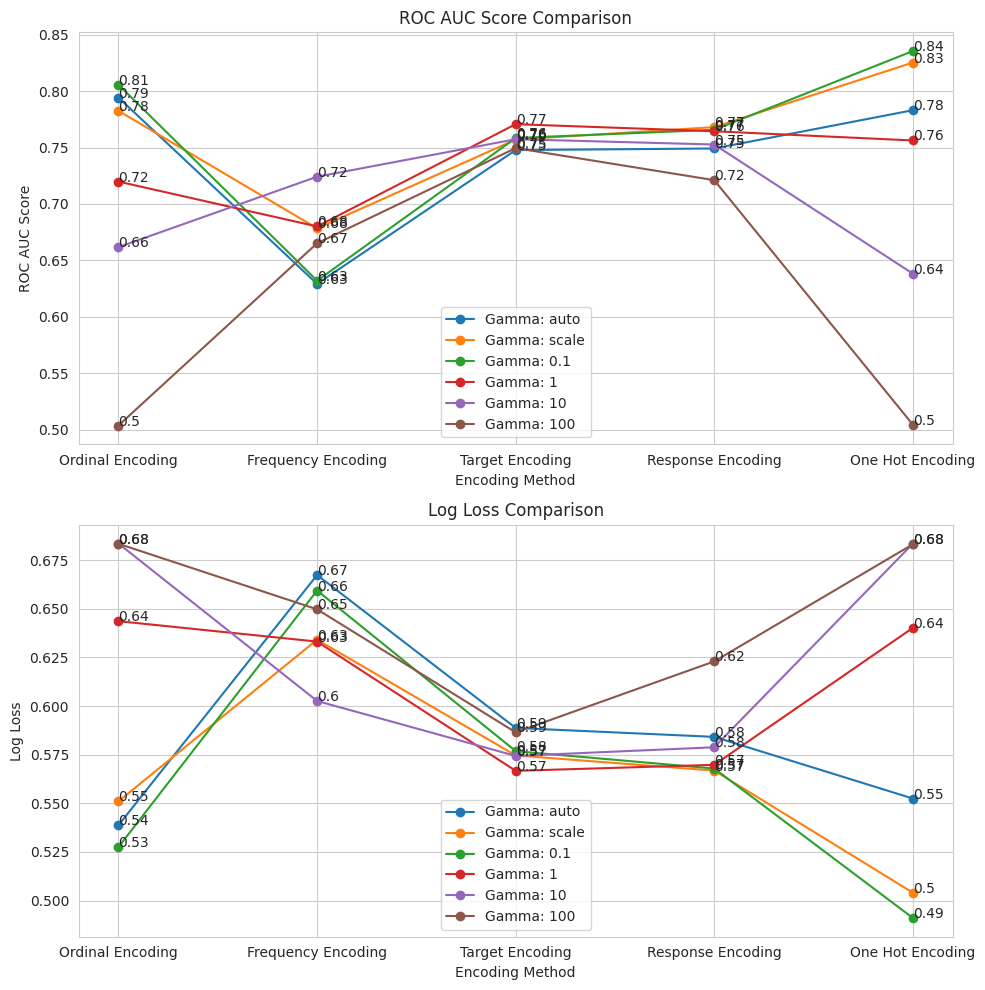

+-------+--------------------+--------------------+--------------------+
| Gamma |  Encoding Method   |   ROC AUC Score    |      Log Loss      |
+-------+--------------------+--------------------+--------------------+
|  auto |  Ordinal Encoding  | 0.7942805210925972 | 0.5387233069638625 |
|  auto | Frequency Encoding | 0.6291613626432087 | 0.6673664423480625 |
|  auto |  Target Encoding   | 0.7477567938998981 | 0.5887266668724475 |
|  auto | Response Encoding  | 0.7491830220584045 | 0.5841444694593891 |
|  auto |  One Hot Encoding  | 0.7831135726002065 | 0.5524335755636155 |
| scale |  Ordinal Encoding  | 0.7825670206904414 | 0.5510144400998015 |
| scale | Frequency Encoding | 0.6783839669662252 | 0.6341142767675779 |
| scale |  Target Encoding   | 0.7571007416133099 | 0.5746014905129443 |
| scale | Response Encoding  | 0.7681261439274473 | 0.566808951583273  |
| scale |  One Hot Encoding  | 0.8253456323345937 | 0.5040062224015984 |
|  0.1  |  Ordinal Encoding  | 0.805706179266493  |

In [ ]:
def svm_evaluation_gamma(X_train, y_train, X_test, y_test, gamma):
    # Instantiate and train SVM models
    SVM_rbf = SVC(kernel="rbf", probability=True, gamma=gamma,C=1).fit(X_train, y_train)

    # Get the probabilities of each class
    y_prob_SVM = SVM_rbf.predict_proba(X_test)

    # Calculate the ROC AUC score and log loss of the model
    roc_auc = roc_auc_score(y_test, y_prob_SVM[:, 1])
    logloss = log_loss(y_test, y_prob_SVM)

    return roc_auc, logloss

# Prepare the table
pt = PrettyTable()
pt.field_names = ["Gamma", "Encoding Method", "ROC AUC Score", "Log Loss"]

# Define the gamma values to explore
gammas = ['auto','scale',0.1, 1, 10, 100]

# Evaluate different encoding methods
encoding_methods = [("Ordinal Encoding", X_train_Ordinal_encoding, X_test_Ordinal_encoding),
                    ("Frequency Encoding", X_train_frequency_encoding, X_test_frequency_encoding),
                    ("Target Encoding", X_train_target_encoding, X_test_target_encoding),
                    ("Response Encoding", X_train_response_encoding, X_test_response_encoding),
                    ("One Hot Encoding", X_train_ohe, X_test_ohe)]

fig, ax = plt.subplots(2, 1, figsize=(10, 10))

for idx, gamma in enumerate(gammas):
    roc_aucs = []
    log_losses = []
    for method, X_train, X_test in encoding_methods:
        roc_auc, logloss = svm_evaluation_gamma(X_train, y_train, X_test, y_test, gamma)
        roc_aucs.append(roc_auc)
        log_losses.append(logloss)

        # Add results to the table
        pt.add_row([gamma, method, roc_auc, logloss])

    ax[0].plot([method[0] for method in encoding_methods], roc_aucs, marker='o', label=f"Gamma: {gamma}")
    ax[1].plot([method[0] for method in encoding_methods], log_losses, marker='o', label=f"Gamma: {gamma}")

    for i, txt in enumerate(roc_aucs):
        ax[0].annotate(np.round(txt, 2), ([method[0] for method in encoding_methods][i], roc_aucs[i]))

    for i, txt in enumerate(log_losses):
        ax[1].annotate(np.round(txt, 2), ([method[0] for method in encoding_methods][i], log_losses[i]))

ax[0].set_title('ROC AUC Score Comparison')
ax[0].set_xlabel('Encoding Method')
ax[0].set_ylabel('ROC AUC Score')
ax[0].legend()

ax[1].set_title('Log Loss Comparison')
ax[1].set_xlabel('Encoding Method')
ax[1].set_ylabel('Log Loss')
ax[1].legend()

plt.tight_layout()
plt.show()

print(pt)

## 1.7.2 Decision Tree

### 1.7.2.1 General parameters trunning

### choose best criterion use F1, ROC-AUC,Accuracy(Cross-Validation)

In [ ]:
from sklearn.model_selection import cross_val_score
from prettytable import PrettyTable
#define the values
criterion_values = ['entropy','gini']


cv_scores_oe = []
cv_scores_fe = []
cv_scores_te = []
cv_scores_re = []
cv_scores_ohe = []

# use F1 score
for criterion in criterion_values:

    dtc = DecisionTreeClassifier(criterion=criterion, random_state=42)
#cross validation
    scores_oe = cross_val_score(dtc, X_train_Ordinal_encoding, y_train, cv=5, scoring='f1')
    scores_fe = cross_val_score(dtc, X_train_frequency_encoding, y_train, cv=5, scoring='f1')
    scores_te = cross_val_score(dtc, X_train_target_encoding, y_train, cv=5, scoring='f1')
    scores_re = cross_val_score(dtc, X_train_response_encoding, y_train, cv=5, scoring='f1')
    scores_ohe = cross_val_score(dtc, X_train_ohe, y_train, cv=5, scoring='f1')

    cv_scores_oe.append(scores_oe.mean())
    cv_scores_fe.append(scores_fe.mean())
    cv_scores_te.append(scores_te.mean())
    cv_scores_re.append(scores_re.mean())
    cv_scores_ohe.append(scores_ohe.mean())
#print the result
table = PrettyTable()
table.field_names = ['Criterion', 'Ordinal Encoding', 'Frequency Encoding', 'Target Encoding', 'Response Encoding', 'One Hot Encoding']

table.add_row(['gini', cv_scores_oe[0], cv_scores_fe[0], cv_scores_te[0], cv_scores_re[0], cv_scores_ohe[0]])
table.add_row(['entropy', cv_scores_oe[1], cv_scores_fe[1], cv_scores_te[1], cv_scores_re[1], cv_scores_ohe[1]])


print(table)


+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Criterion |  Ordinal Encoding  | Frequency Encoding |  Target Encoding   | Response Encoding  |  One Hot Encoding  |
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    gini   | 0.716140612596655  | 0.7129381968549702 | 0.7177524179394608 | 0.7199267671640597 | 0.7174524241774141 |
|  entropy  | 0.7118664113391422 | 0.7107388410147352 | 0.7113934320711263 | 0.7153879414813503 | 0.7147455755064148 |
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:
#define the values
criterion_values = [ 'entropy','gini']


cv_scores_oe = []
cv_scores_fe = []
cv_scores_te = []
cv_scores_re = []
cv_scores_ohe = []

# use roc_auc score
for criterion in criterion_values:

    dtc = DecisionTreeClassifier(criterion=criterion, random_state=42)
#cross validation
    scores_oe = cross_val_score(dtc, X_train_Ordinal_encoding, y_train, cv=5, scoring='roc_auc')
    scores_fe = cross_val_score(dtc, X_train_frequency_encoding, y_train, cv=5, scoring='roc_auc')
    scores_te = cross_val_score(dtc, X_train_target_encoding, y_train, cv=5, scoring='roc_auc')
    scores_re = cross_val_score(dtc, X_train_response_encoding, y_train, cv=5, scoring='roc_auc')
    scores_ohe = cross_val_score(dtc, X_train_ohe, y_train, cv=5, scoring='roc_auc')

    cv_scores_oe.append(scores_oe.mean())
    cv_scores_fe.append(scores_fe.mean())
    cv_scores_te.append(scores_te.mean())
    cv_scores_re.append(scores_re.mean())
    cv_scores_ohe.append(scores_ohe.mean())
#print the result
table = PrettyTable()
table.field_names = ['Criterion', 'Ordinal Encoding', 'Frequency Encoding', 'Target Encoding', 'Response Encoding', 'One Hot Encoding']

table.add_row(['gini', cv_scores_oe[0], cv_scores_fe[0], cv_scores_te[0], cv_scores_re[0], cv_scores_ohe[0]])
table.add_row(['entropy', cv_scores_oe[1], cv_scores_fe[1], cv_scores_te[1], cv_scores_re[1], cv_scores_ohe[1]])


print(table)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Criterion |  Ordinal Encoding  | Frequency Encoding |  Target Encoding   | Response Encoding  |  One Hot Encoding  |
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    gini   | 0.6764279081178841 | 0.6689494987370389 | 0.6751215480950541 | 0.6793773237117576 | 0.6767023795393167 |
|  entropy  | 0.6707565889177172 | 0.6699110525954224 | 0.6686733598614466 | 0.6740313444830697 | 0.6746962030429564 |
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+


In [ ]:

criterion_values = [ 'entropy','gini']


cv_scores_oe = []
cv_scores_fe = []
cv_scores_te = []
cv_scores_re = []
cv_scores_ohe = []

# use acc
for criterion in criterion_values:

    dtc = DecisionTreeClassifier(criterion=criterion, random_state=42)

    scores_oe = cross_val_score(dtc, X_train_Ordinal_encoding, y_train, cv=5, scoring='accuracy')
    scores_fe = cross_val_score(dtc, X_train_frequency_encoding, y_train, cv=5, scoring='accuracy')
    scores_te = cross_val_score(dtc, X_train_target_encoding, y_train, cv=5, scoring='accuracy')
    scores_re = cross_val_score(dtc, X_train_response_encoding, y_train, cv=5, scoring='accuracy')
    scores_ohe = cross_val_score(dtc, X_train_ohe, y_train, cv=5, scoring='accuracy')

    cv_scores_oe.append(scores_oe.mean())
    cv_scores_fe.append(scores_fe.mean())
    cv_scores_te.append(scores_te.mean())
    cv_scores_re.append(scores_re.mean())
    cv_scores_ohe.append(scores_ohe.mean())

table = PrettyTable()
table.field_names = ['Criterion', 'Ordinal Encoding', 'Frequency Encoding', 'Target Encoding', 'Response Encoding', 'One Hot Encoding']

table.add_row(['gini', cv_scores_oe[0], cv_scores_fe[0], cv_scores_te[0], cv_scores_re[0], cv_scores_ohe[0]])
table.add_row(['entropy', cv_scores_oe[1], cv_scores_fe[1], cv_scores_te[1], cv_scores_re[1], cv_scores_ohe[1]])


print(table)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Criterion |  Ordinal Encoding  | Frequency Encoding |  Target Encoding   | Response Encoding  |  One Hot Encoding  |
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|    gini   | 0.680495232915824  | 0.6746826192620791 | 0.680298285694863  | 0.6839453539441642 | 0.6814821055289435 |
|  entropy  | 0.6752714215306626 | 0.6744835355328038 | 0.6735977100515432 | 0.6787215425590029 | 0.679017109061466  |
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+


###  choose best splitter use accuracy(criterion=gini)

In [ ]:
# Creating decision tree models with different splitters and evaluating their performance

from sklearn.model_selection import cross_val_score

splitter_values = ['best', 'random']

cv_scores_oe = []  # empty list to store cross-validation scores for Ordinal Encoding
cv_scores_fe = []  # empty list to store cross-validation scores for Frequency Encoding
cv_scores_te = []  # empty list to store cross-validation scores for Target Encoding
cv_scores_re = []  # empty list to store cross-validation scores for Response Encoding
cv_scores_ohe = []  # empty list to store cross-validation scores for One Hot Encoding

# Loop over each splitter value
for splitter in splitter_values:
    # Create a DecisionTreeClassifier with the specified splitter
    dtc = DecisionTreeClassifier(criterion='gini', splitter=splitter, random_state=42)

    # Perform cross-validation for each encoding method and store the scores
    scores_oe = cross_val_score(dtc, X_train_Ordinal_encoding, y_train, cv=5, scoring='accuracy')
    scores_fe = cross_val_score(dtc, X_train_frequency_encoding, y_train, cv=5, scoring='accuracy')
    scores_te = cross_val_score(dtc, X_train_target_encoding, y_train, cv=5, scoring='accuracy')
    scores_re = cross_val_score(dtc, X_train_response_encoding, y_train, cv=5, scoring='accuracy')
    scores_ohe = cross_val_score(dtc, X_train_ohe, y_train, cv=5, scoring='accuracy')

    # Calculate the mean score for each encoding method and append to the respective list
    cv_scores_oe.append(scores_oe.mean())
    cv_scores_fe.append(scores_fe.mean())
    cv_scores_te.append(scores_te.mean())
    cv_scores_re.append(scores_re.mean())
    cv_scores_ohe.append(scores_ohe.mean())

# Create a table to display the results
table = PrettyTable()
table.field_names = ['splitter', 'Ordinal Encoding', 'Frequency Encoding', 'Target Encoding', 'Response Encoding', 'One Hot Encoding']

# Add rows to the table with the scores for each encoding method and splitter value
table.add_row(['best', cv_scores_oe[0], cv_scores_fe[0], cv_scores_te[0], cv_scores_re[0], cv_scores_ohe[0]])
table.add_row(['random', cv_scores_oe[1], cv_scores_fe[1], cv_scores_te[1], cv_scores_re[1], cv_scores_ohe[1]])

# Print the table
print(table)

+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| splitter |  Ordinal Encoding  | Frequency Encoding |  Target Encoding   | Response Encoding  |  One Hot Encoding  |
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   best   | 0.6752714215306626 | 0.6744835355328038 | 0.6735977100515432 | 0.6787215425590029 | 0.679017109061466  |
|  random  | 0.6698525566478185 | 0.6662081590339098 | 0.6675845074013018 | 0.6784250049163969 | 0.6839442856900073 |
+----------+--------------------+--------------------+--------------------+--------------------+--------------------+


###  choose best class_weight use acc(criterion=gini,splitter=best)

In [ ]:
# Creating decision tree models with different class weights and evaluating their performance

class_weight_values = ['balanced', None]

cv_scores_oe = []  # empty list to store cross-validation scores for Ordinal Encoding
cv_scores_fe = []  # empty list to store cross-validation scores for Frequency Encoding
cv_scores_te = []  # empty list to store cross-validation scores for Target Encoding
cv_scores_re = []  # empty list to store cross-validation scores for Response Encoding
cv_scores_ohe = []  # empty list to store cross-validation scores for One Hot Encoding

# Loop over each class weight value
for cw in class_weight_values:
    # Create a DecisionTreeClassifier with the specified class weight
    dtc = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight=cw, random_state=42)

    # Perform cross-validation for each encoding method and store the scores
    scores_oe = cross_val_score(dtc, X_train_Ordinal_encoding, y_train, cv=5, scoring='accuracy')
    scores_fe = cross_val_score(dtc, X_train_frequency_encoding, y_train, cv=5, scoring='accuracy')
    scores_te = cross_val_score(dtc, X_train_target_encoding, y_train, cv=5, scoring='accuracy')
    scores_re = cross_val_score(dtc, X_train_response_encoding, y_train, cv=5, scoring='accuracy')
    scores_ohe = cross_val_score(dtc, X_train_ohe, y_train, cv=5, scoring='accuracy')

    # Calculate the mean score for each encoding method and append to the respective list
    cv_scores_oe.append(scores_oe.mean())
    cv_scores_fe.append(scores_fe.mean())
    cv_scores_te.append(scores_te.mean())
    cv_scores_re.append(scores_re.mean())
    cv_scores_ohe.append(scores_ohe.mean())

# Create a table to display the results
table = PrettyTable()
table.field_names = ['class weight', 'Ordinal Encoding', 'Frequency Encoding', 'Target Encoding', 'Response Encoding', 'One Hot Encoding']

# Add rows to the table with the scores for each encoding method and class weight value
table.add_row(['balanced', cv_scores_oe[0], cv_scores_fe[0], cv_scores_te[0], cv_scores_re[0], cv_scores_ohe[0]])
table.add_row(['None', cv_scores_oe[1], cv_scores_fe[1], cv_scores_te[1], cv_scores_re[1], cv_scores_ohe[1]])

# Print the table
print(table)

+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| class weight |  Ordinal Encoding  | Frequency Encoding |  Target Encoding   | Response Encoding  |  One Hot Encoding  |
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|   balanced   | 0.6808892730287676 | 0.6756669669108275 | 0.6747793448203027 | 0.6772429331345734 | 0.6854227980004225 |
|     None     | 0.6752714215306626 | 0.6744835355328038 | 0.6735977100515432 | 0.6787215425590029 | 0.679017109061466  |
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+


### 1.7.2.2 regulization parameters trunning

###  find out the best max_depth in various encoding methods(use acc)

In [ ]:
# Creating decision tree models with different max depths and evaluating their performance

max_depth_values = [1, 10, 100, 500]

cv_scores_oe = []  # empty list to store cross-validation scores for Ordinal Encoding
cv_scores_fe = []  # empty list to store cross-validation scores for Frequency Encoding
cv_scores_te = []  # empty list to store cross-validation scores for Target Encoding
cv_scores_re = []  # empty list to store cross-validation scores for Response Encoding
cv_scores_ohe = []  # empty list to store cross-validation scores for One Hot Encoding

# Loop over each max depth value
for d in max_depth_values:
    # Create a DecisionTreeClassifier with the specified max depth
    dtc = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced', max_depth=d, random_state=42)

    # Perform cross-validation for each encoding method and store the scores
    scores_oe = cross_val_score(dtc, X_train_Ordinal_encoding, y_train, cv=5, scoring='accuracy')
    scores_fe = cross_val_score(dtc, X_train_frequency_encoding, y_train, cv=5, scoring='accuracy')
    scores_te = cross_val_score(dtc, X_train_target_encoding, y_train, cv=5, scoring='accuracy')
    scores_re = cross_val_score(dtc, X_train_response_encoding, y_train, cv=5, scoring='accuracy')
    scores_ohe = cross_val_score(dtc, X_train_ohe, y_train, cv=5, scoring='accuracy')

    # Calculate the mean score for each encoding method and append to the respective list
    cv_scores_oe.append(scores_oe.mean())
    cv_scores_fe.append(scores_fe.mean())
    cv_scores_te.append(scores_te.mean())
    cv_scores_re.append(scores_re.mean())
    cv_scores_ohe.append(scores_ohe.mean())

# Create a table to display the results
table = PrettyTable()
table.field_names = ['Max Depth', 'Ordinal Encoding', 'Frequency Encoding', 'Target Encoding', 'Response Encoding', 'One-Hot Encoding']

# Add rows to the table with the scores for each encoding method and max depth value
for i in range(len(max_depth_values)):
    table.add_row([max_depth_values[i], cv_scores_oe[i], cv_scores_fe[i], cv_scores_te[i], cv_scores_re[i], cv_scores_ohe[i]])

# Print the table
print(table)

+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Max Depth |  Ordinal Encoding  | Frequency Encoding |  Target Encoding   | Response Encoding  |  One-Hot Encoding  |
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     1     | 0.6553644567563434 | 0.6269819149426905 | 0.6553644567563434 | 0.6553644567563434 | 0.6610804905228862 |
|     10    | 0.6943914228902587 | 0.7000092743883638 | 0.6953772758062284 |  0.69567235673862  | 0.7046409330714493 |
|    100    | 0.6808892730287676 | 0.6756669669108275 | 0.6747793448203027 | 0.6772429331345734 | 0.6854227980004225 |
|    500    | 0.6808892730287676 | 0.6756669669108275 | 0.6747793448203027 | 0.6772429331345734 | 0.6854227980004225 |
+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+


### find out the best max_leaf_nodes in various encoding methods(use acc)

In [ ]:
# Creating decision tree models with different max leaf nodes and evaluating their performance

max_leaf_nodes_values = [2, 10, 100, 500]

cv_scores_oe = []  # empty list to store cross-validation scores for Ordinal Encoding
cv_scores_fe = []  # empty list to store cross-validation scores for Frequency Encoding
cv_scores_te = []  # empty list to store cross-validation scores for Target Encoding
cv_scores_re = []  # empty list to store cross-validation scores for Response Encoding
cv_scores_ohe = []  # empty list to store cross-validation scores for One Hot Encoding

# Loop over each max leaf nodes value
for l in max_leaf_nodes_values:
    # Create a DecisionTreeClassifier with the specified max leaf nodes and max depth
    dtc = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced', max_leaf_nodes=l, max_depth=10, random_state=42)

    # Perform cross-validation for each encoding method and store the scores
    scores_oe = cross_val_score(dtc, X_train_Ordinal_encoding, y_train, cv=5, scoring='accuracy')
    scores_fe = cross_val_score(dtc, X_train_frequency_encoding, y_train, cv=5, scoring='accuracy')
    scores_te = cross_val_score(dtc, X_train_target_encoding, y_train, cv=5, scoring='accuracy')
    scores_re = cross_val_score(dtc, X_train_response_encoding, y_train, cv=5, scoring='accuracy')
    scores_ohe = cross_val_score(dtc, X_train_ohe, y_train, cv=5, scoring='accuracy')

    # Calculate the mean score for each encoding method and append to the respective list
    cv_scores_oe.append(scores_oe.mean())
    cv_scores_fe.append(scores_fe.mean())
    cv_scores_te.append(scores_te.mean())
    cv_scores_re.append(scores_re.mean())
    cv_scores_ohe.append(scores_ohe.mean())

# Create a table to display the results
table = PrettyTable()
table.field_names = ['Max Leaf Nodes', 'Ordinal Encoding', 'Frequency Encoding', 'Target Encoding', 'Response Encoding', 'One-Hot Encoding']

# Add rows to the table with the scores for each encoding method and max leaf nodes value
for i in range(len(max_leaf_nodes_values)):
    table.add_row([max_leaf_nodes_values[i], cv_scores_oe[i], cv_scores_fe[i], cv_scores_te[i], cv_scores_re[i], cv_scores_ohe[i]])

# Print the table
print(table)

+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Max Leaf Nodes |  Ordinal Encoding  | Frequency Encoding |  Target Encoding   | Response Encoding  |  One-Hot Encoding  |
+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|       2        | 0.6553644567563434 | 0.6269819149426905 | 0.6553644567563434 | 0.6553644567563434 | 0.6610804905228862 |
|       10       | 0.6974450273982912 | 0.6851270372699308 | 0.6981360907239121 | 0.698234661448407  | 0.6836488648585656 |
|      100       | 0.6957692765248721 | 0.7014875439137432 | 0.7016832286525188 | 0.7012890428685538 |  0.70296450239993  |
|      500       | 0.6943916656752944 | 0.7006993180168346 | 0.6956727451946773 | 0.6964609225345787 | 0.7050353130834428 |
+----------------+--------------------+--------------------+--------------------+--------------------+--------------------+


### find out the best min_samples_split in various encoding methods(use acc)

In [ ]:
# Creating decision tree models with different minimum samples split values and evaluating their performance

min_samples_split_values = [2, 10, 100, 500]

cv_scores_oe = []  # empty list to store cross-validation scores for Ordinal Encoding
cv_scores_fe = []  # empty list to store cross-validation scores for Frequency Encoding
cv_scores_te = []  # empty list to store cross-validation scores for Target Encoding
cv_scores_re = []  # empty list to store cross-validation scores for Response Encoding
cv_scores_ohe = []  # empty list to store cross-validation scores for One Hot Encoding

# Loop over each minimum samples split value
for mss in min_samples_split_values:
    # Create decision tree models with different settings for each encoding method
    dtc_oe = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced', max_leaf_nodes=10, max_depth=10, min_samples_split=mss, random_state=42)
    dtc_fe = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced', max_leaf_nodes=100, max_depth=10, min_samples_split=mss, random_state=42)
    dtc_te = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced', max_leaf_nodes=100, max_depth=10, min_samples_split=mss, random_state=42)
    dtc_re = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced', max_leaf_nodes=100, max_depth=10, min_samples_split=mss, random_state=42)
    dtc_ohe = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced', max_leaf_nodes=500, max_depth=10, min_samples_split=mss, random_state=42)

    # Perform cross-validation for each encoding method and store the scores
    scores_oe = cross_val_score(dtc_oe, X_train_Ordinal_encoding, y_train, cv=5, scoring='accuracy')
    scores_fe = cross_val_score(dtc_fe, X_train_frequency_encoding, y_train, cv=5, scoring='accuracy')
    scores_te = cross_val_score(dtc_te, X_train_target_encoding, y_train, cv=5, scoring='accuracy')
    scores_re = cross_val_score(dtc_re, X_train_response_encoding, y_train, cv=5, scoring='accuracy')
    scores_ohe = cross_val_score(dtc_ohe, X_train_ohe, y_train, cv=5, scoring='accuracy')

    # Calculate the mean score for each encoding method and append to the respective list
    cv_scores_oe.append(scores_oe.mean())
    cv_scores_fe.append(scores_fe.mean())
    cv_scores_te.append(scores_te.mean())
    cv_scores_re.append(scores_re.mean())
    cv_scores_ohe.append(scores_ohe.mean())

# Create a table to display the results
table = PrettyTable()
table.field_names = ['Minimum Samples Split', 'Ordinal Encoding', 'Frequency Encoding', 'Target Encoding', 'Response Encoding', 'One-Hot Encoding']

# Add rows to the table with the scores for each encoding method and minimum samples split value
for i in range(len(min_samples_split_values)):
    table.add_row([min_samples_split_values[i], cv_scores_oe[i], cv_scores_fe[i], cv_scores_te[i], cv_scores_re[i], cv_scores_ohe[i]])

# Print the table
print(table)

+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| Minimum Samples Split |  Ordinal Encoding  | Frequency Encoding |  Target Encoding   | Response Encoding  |  One-Hot Encoding  |
+-----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|           2           | 0.6974450273982912 | 0.7014875439137432 | 0.7016832286525188 | 0.7012890428685538 | 0.7050353130834428 |
|           10          | 0.6974450273982912 | 0.7014875439137432 | 0.7016832286525188 | 0.7012890428685538 | 0.7018813412416512 |
|          100          | 0.6974450273982912 | 0.6980389767096316 | 0.6969531934729671 | 0.6971503349219568 | 0.6934071237985175 |
|          500          | 0.6974450273982912 | 0.6870982089747916 | 0.6978400872083849 | 0.6979386579328797 | 0.6883789971521315 |
+-----------------------+--------------------+--------------------+----------------

### print out the data of min_samples_split turnning

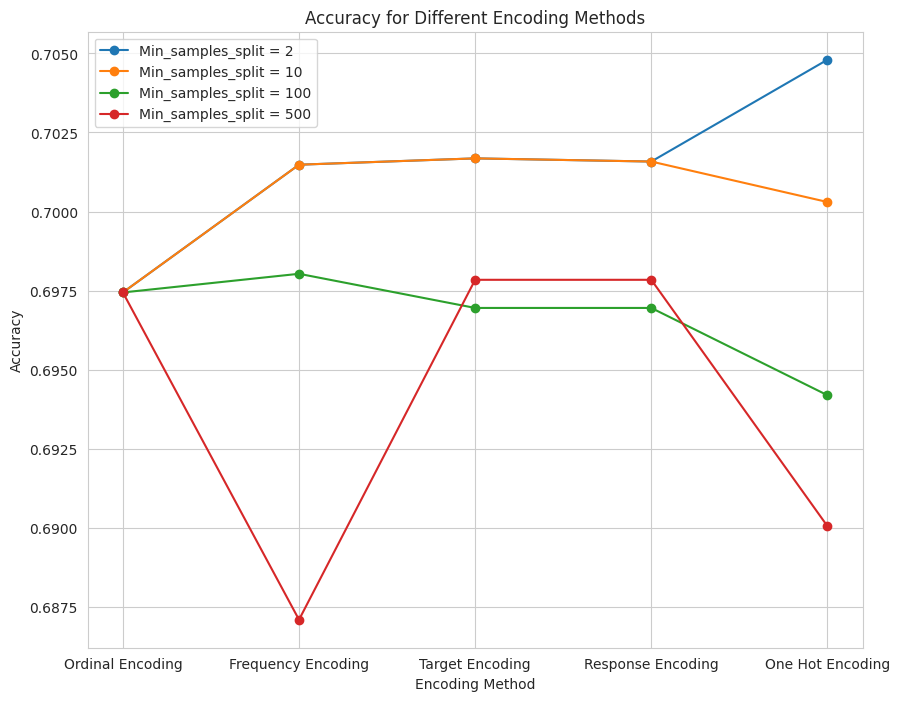

In [ ]:
import matplotlib.pyplot as plt

# data
encoding_methods = ['Ordinal Encoding', 'Frequency Encoding', 'Target Encoding', 'Response Encoding', 'One Hot Encoding']
min_samples_split = [2, 2, 2, 2, 2, 10, 10, 10, 10, 10, 100, 100, 100, 100, 100, 500, 500, 500, 500, 500]
accuracy = [
    0.69744, 0.70148, 0.70168, 0.70158, 0.70480,
    0.69744, 0.70148, 0.70168, 0.70158, 0.70030,
    0.69744, 0.69803, 0.69695, 0.69695, 0.69419,
    0.69744, 0.68709, 0.69784, 0.69784, 0.69005
]

# create a new figure
plt.figure(figsize=[10,8])
# create a list of unique values of min_samples_split
min_samples_split_values = list(set(min_samples_split))

# for each unique value of min_samples_split, plot a line
for value in min_samples_split_values:
    indices = [i for i, x in enumerate(min_samples_split) if x == value]
    plt.plot([encoding_methods[i % len(encoding_methods)] for i in indices], [accuracy[i] for i in indices], marker='o', label=f"Min_samples_split = {value}")


plt.xlabel("Encoding Method")
plt.ylabel("Accuracy")
plt.title("Accuracy for Different Encoding Methods")
plt.xticks()
plt.legend()
plt.show()

## 1.7.3 Logistic Regression

### 1.7.3.1 General parameters trunning

### choose best penalty use F1

Average F1 score for Ordinal Encoding: 0.6919896636263713


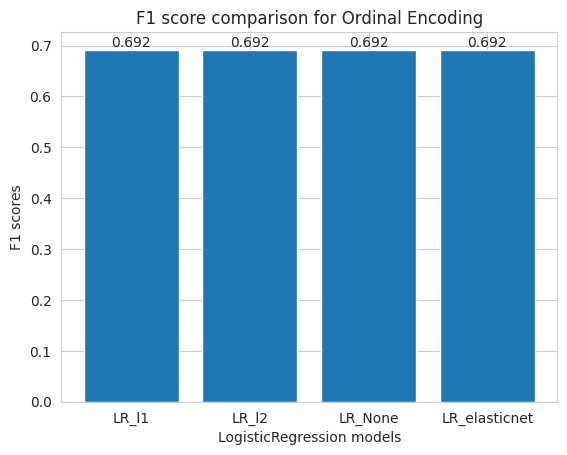

Average F1 score for Frequency Encoding: 0.6149294249715554


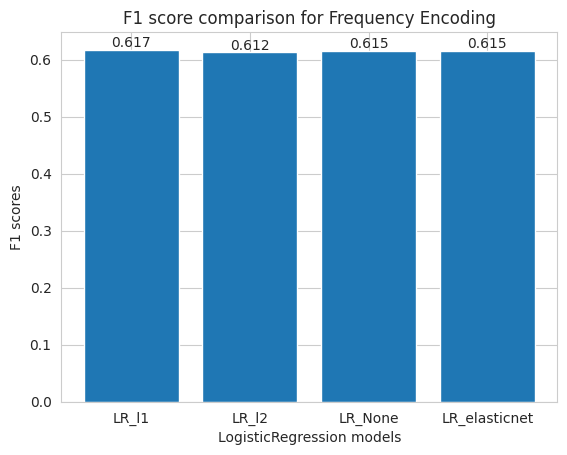

Average F1 score for Target Encoding: 0.7008836176785804


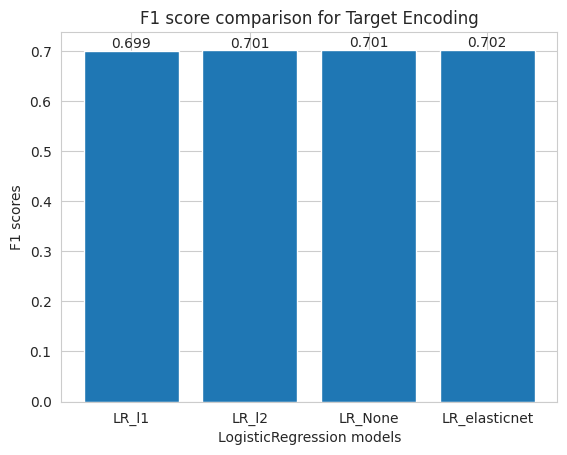

Average F1 score for Response Encoding: 0.7070548259767089


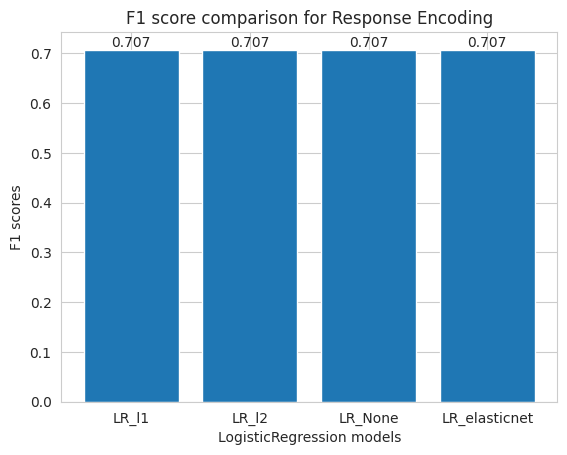

Average F1 score for One Hot Encoding: 0.6993300550250683


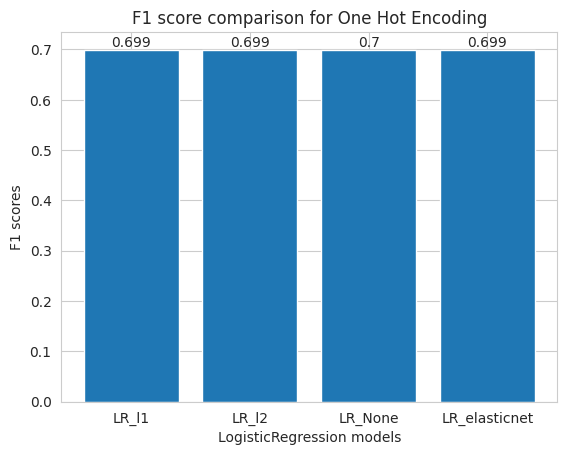

In [ ]:
# Evaluating Logistic Regression models with different penalties and comparing their F1 scores

def LR_penalty_evaluation_f1(X_train, y_train, X_test, y_test, encoding_method):
    # Create Logistic Regression models with different penalties
    LR_l1 = LogisticRegression(penalty='l1', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42).fit(X_train, y_train)
    LR_l2 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42).fit(X_train, y_train)
    LR_none = LogisticRegression(penalty='none', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42).fit(X_train, y_train)
    LR_elasticnet = LogisticRegression(penalty='elasticnet', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)

    # Make predictions using the models
    y_pred_LR_l1 = LR_l1.predict(X_test)
    y_pred_LR_l2 = LR_l2.predict(X_test)
    y_pred_LR_none = LR_none.predict(X_test)
    y_pred_LR_elasticnet = LR_elasticnet.predict(X_test)

    # Calculate F1 scores for each model
    f1_scores = [
        classification_report(y_test, y_pred_LR_l1, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_l2, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_none, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_elasticnet, output_dict=True)["weighted avg"]["f1-score"]
    ]

    # Print the average F1 score for the encoding method
    print(f"Average F1 score for {encoding_method}: {np.mean(f1_scores)}")

    # Create a bar plot to compare F1 scores for each model
    models = ["LR_l1", "LR_l2", "LR_None", "LR_elasticnet"]
    bars = plt.bar(models, f1_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("F1 scores")
    plt.title(f"F1 score comparison for {encoding_method}")

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()

# Call the function for each encoding method
LR_penalty_evaluation_f1(X_train_Ordinal_encoding, y_train, X_test_Ordinal_encoding, y_test, "Ordinal Encoding")
LR_penalty_evaluation_f1(X_train_frequency_encoding, y_train, X_test_frequency_encoding, y_test, "Frequency Encoding")
LR_penalty_evaluation_f1(X_train_target_encoding, y_train, X_test_target_encoding, y_test, "Target Encoding")
LR_penalty_evaluation_f1(X_train_response_encoding, y_train, X_test_response_encoding, y_test, "Response Encoding")
LR_penalty_evaluation_f1(X_train_ohe, y_train, X_test_ohe, y_test, "One Hot Encoding")

### choose best penalty use F1 roc_auc_score

Average ROC AUC score for Ordinal Encoding: 0.7468460851557008


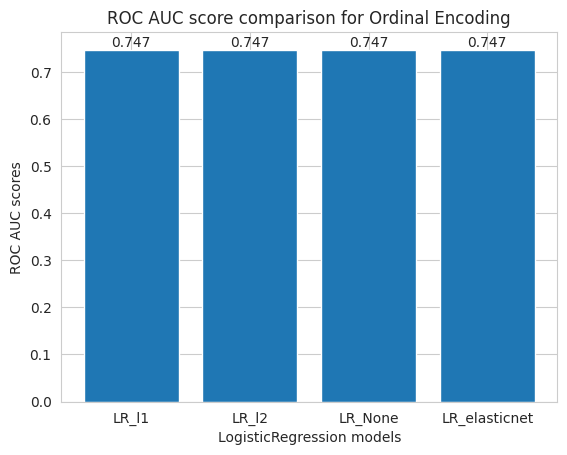

Average ROC AUC score for Frequency Encoding: 0.6484969030836167


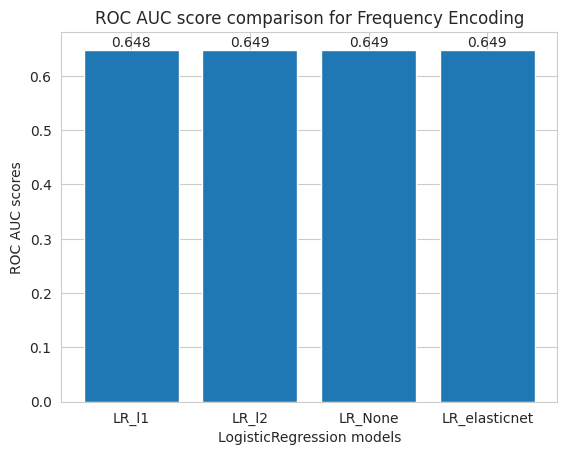

Average ROC AUC score for Target Encoding: 0.7684760511466191


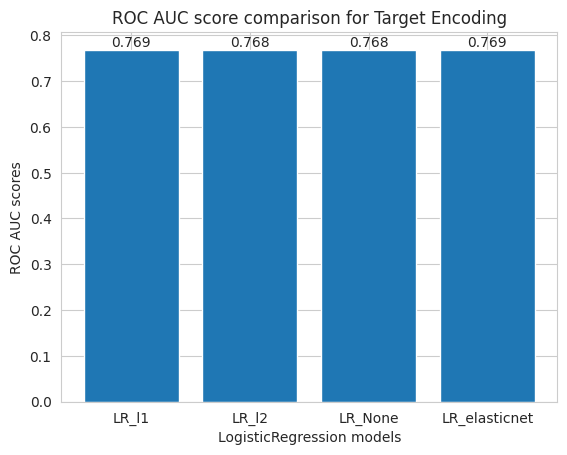

Average ROC AUC score for Response Encoding: 0.7690276695862546


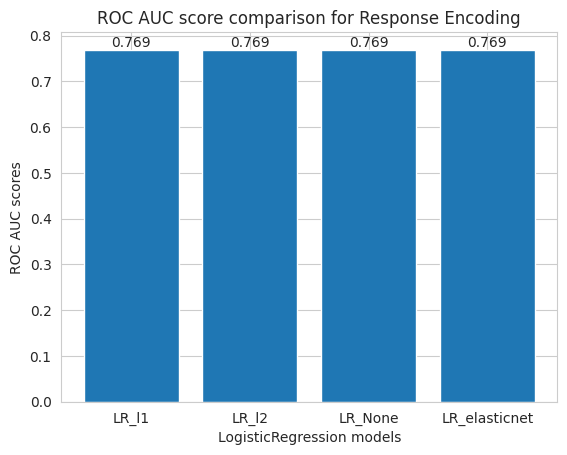

Average ROC AUC score for One Hot Encoding: 0.7630494809973465


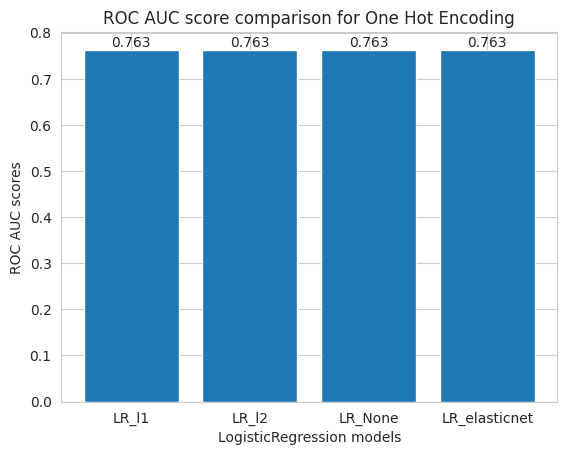

In [ ]:
# Evaluating Logistic Regression models with different penalties and comparing their ROC AUC scores

def LR_penalty_evaluation_roc_auc(X_train, y_train, X_test, y_test, encoding_method):
    # Create Logistic Regression models with different penalties
    LR_l1 = LogisticRegression(penalty='l1', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_l2 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_none = LogisticRegression(penalty='none', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_elasticnet = LogisticRegression(penalty='elasticnet', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)

    # Make probability predictions using the models
    y_pred_LR_l1 = LR_l1.predict_proba(X_test)[:, 1]
    y_pred_LR_l2 = LR_l2.predict_proba(X_test)[:, 1]
    y_pred_LR_none = LR_none.predict_proba(X_test)[:, 1]
    y_pred_LR_elasticnet = LR_elasticnet.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC scores for each model
    roc_auc_scores = [
        roc_auc_score(y_test, y_pred_LR_l1),
        roc_auc_score(y_test, y_pred_LR_l2),
        roc_auc_score(y_test, y_pred_LR_none),
        roc_auc_score(y_test, y_pred_LR_elasticnet)
    ]

    # Print the average ROC AUC score for the encoding method
    print(f"Average ROC AUC score for {encoding_method}: {np.mean(roc_auc_scores)}")

    # Create a bar plot to compare ROC AUC scores for each model
    models = ["LR_l1", "LR_l2", "LR_None", "LR_elasticnet"]
    bars = plt.bar(models, roc_auc_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("ROC AUC scores")
    plt.title(f"ROC AUC score comparison for {encoding_method}")

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()

# Call the function for each encoding method
LR_penalty_evaluation_roc_auc(X_train_Ordinal_encoding, y_train, X_test_Ordinal_encoding, y_test, "Ordinal Encoding")
LR_penalty_evaluation_roc_auc(X_train_frequency_encoding, y_train, X_test_frequency_encoding, y_test, "Frequency Encoding")
LR_penalty_evaluation_roc_auc(X_train_target_encoding, y_train, X_test_target_encoding, y_test, "Target Encoding")
LR_penalty_evaluation_roc_auc(X_train_response_encoding, y_train, X_test_response_encoding, y_test, "Response Encoding")
LR_penalty_evaluation_roc_auc(X_train_ohe, y_train, X_test_ohe, y_test, "One Hot Encoding")

### choose best penalty use log_loss

Average Log Loss score for Ordinal Encoding: 0.5860164609986611


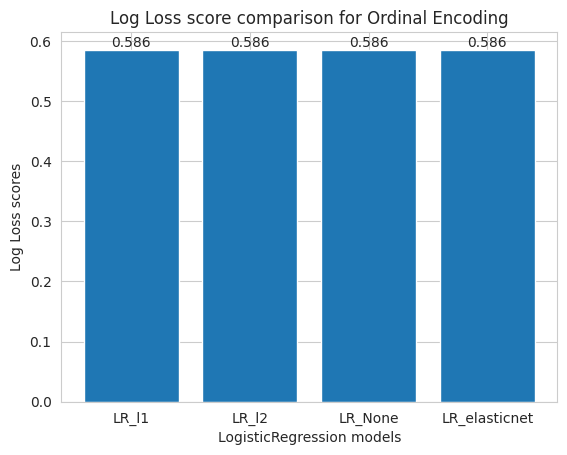

Average Log Loss score for Frequency Encoding: 0.6476248812662126


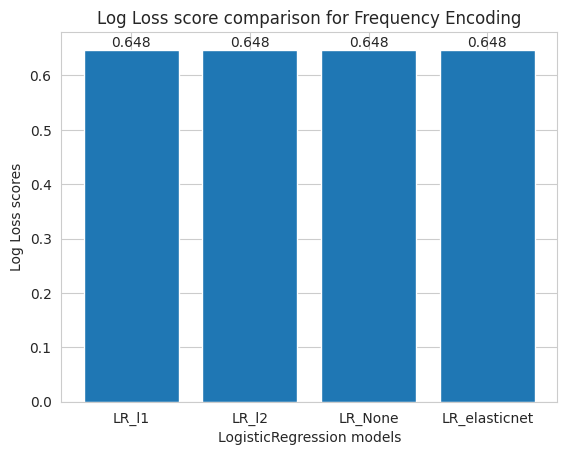

Average Log Loss score for Target Encoding: 0.5663106743759629


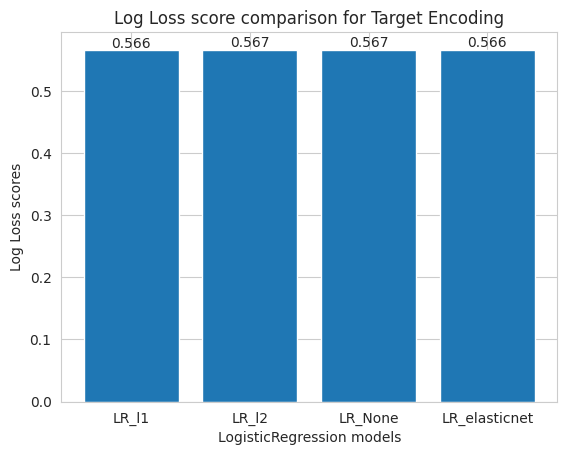

Average Log Loss score for Response Encoding: 0.5646114999872821


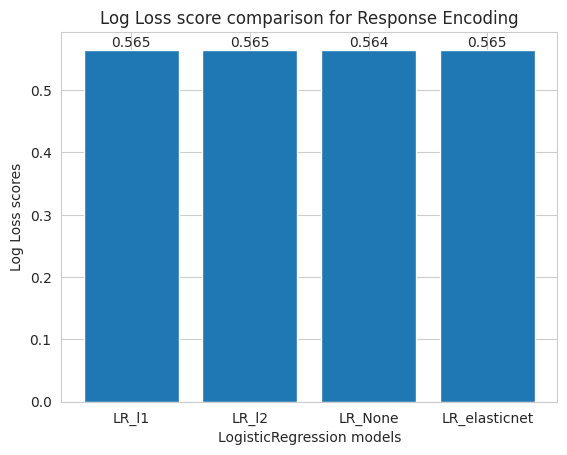

Average Log Loss score for One Hot Encoding: 0.5706708757617782


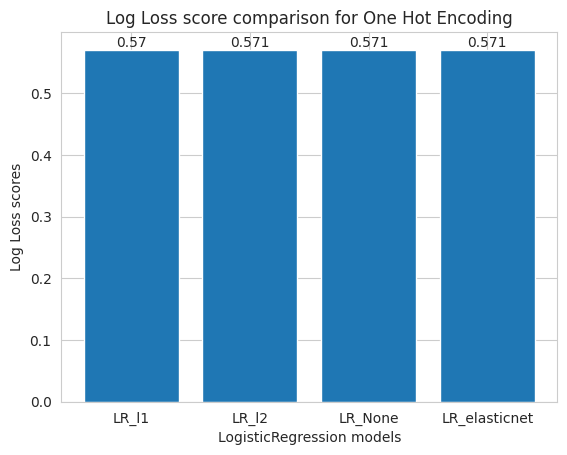

In [ ]:
# Evaluating Logistic Regression models with different penalties and comparing their log loss scores

def LR_penalty_evaluation_log_loss(X_train, y_train, X_test, y_test, encoding_method):
    # Create Logistic Regression models with different penalties
    LR_l1 = LogisticRegression(penalty='l1', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_l2 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_none = LogisticRegression(penalty='none', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_elasticnet = LogisticRegression(penalty='elasticnet', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)

    # Make probability predictions using the models
    y_pred_LR_l1 = LR_l1.predict_proba(X_test)
    y_pred_LR_l2 = LR_l2.predict_proba(X_test)
    y_pred_LR_none = LR_none.predict_proba(X_test)
    y_pred_LR_elasticnet = LR_elasticnet.predict_proba(X_test)

    # Calculate log loss scores for each model
    log_loss_scores = [
        log_loss(y_test, y_pred_LR_l1),
        log_loss(y_test, y_pred_LR_l2),
        log_loss(y_test, y_pred_LR_none),
        log_loss(y_test, y_pred_LR_elasticnet)
    ]

    # Print the average log loss score for the encoding method
    print(f"Average Log Loss score for {encoding_method}: {np.mean(log_loss_scores)}")

    # Create a bar plot to compare log loss scores for each model
    models = ["LR_l1", "LR_l2", "LR_None", "LR_elasticnet"]
    bars = plt.bar(models, log_loss_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("Log Loss scores")
    plt.title(f"Log Loss score comparison for {encoding_method}")

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()

# Call the function for each encoding method
LR_penalty_evaluation_log_loss(X_train_Ordinal_encoding, y_train, X_test_Ordinal_encoding, y_test, "Ordinal Encoding")
LR_penalty_evaluation_log_loss(X_train_frequency_encoding, y_train, X_test_frequency_encoding, y_test, "Frequency Encoding")
LR_penalty_evaluation_log_loss(X_train_target_encoding, y_train, X_test_target_encoding, y_test, "Target Encoding")
LR_penalty_evaluation_log_loss(X_train_response_encoding, y_train, X_test_response_encoding, y_test, "Response Encoding")
LR_penalty_evaluation_log_loss(X_train_ohe, y_train, X_test_ohe, y_test, "One Hot Encoding")

### choose best C use F1

Average F1 score for Ordinal Encoding: 0.6919896636263713


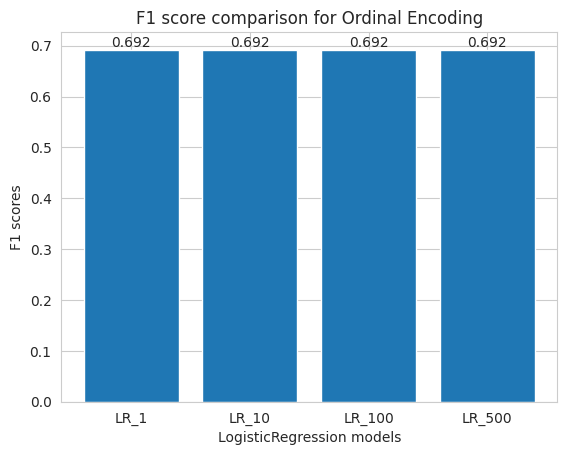

Average F1 score for Frequency Encoding: 0.6142560994319607


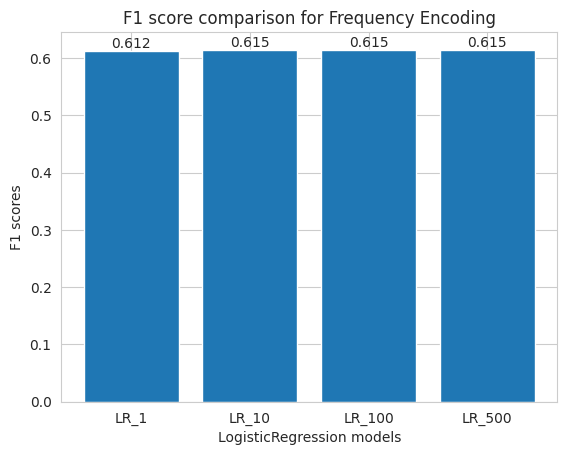

Average F1 score for Target Encoding: 0.7014872926576716


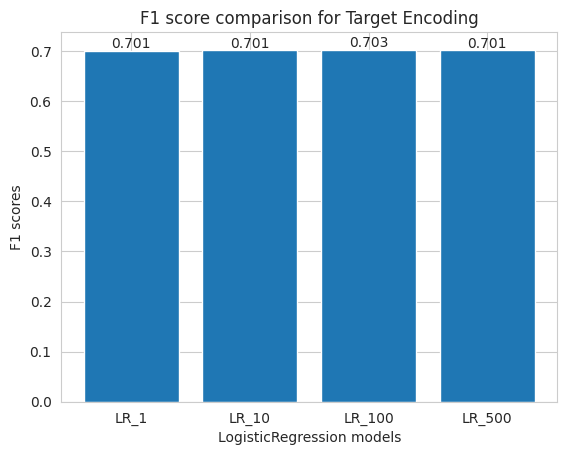

Average F1 score for Response Encoding: 0.7076661346266819


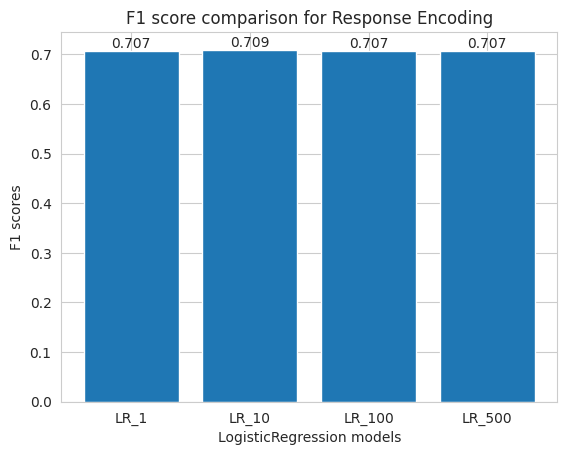

Average F1 score for One Hot Encoding: 0.6994907166820126


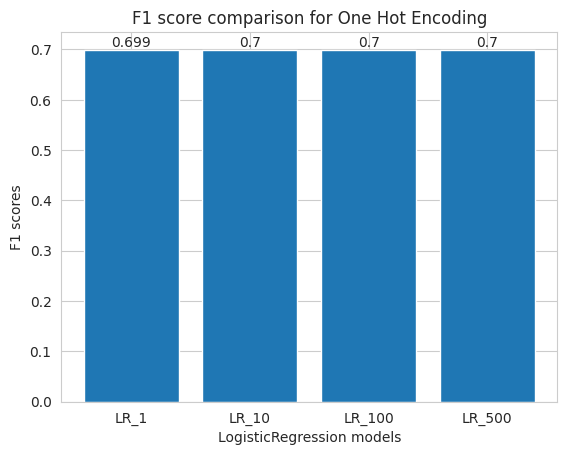

In [ ]:
# Evaluating Logistic Regression models with different penalties and comparing their F1 scores

def LR_penalty_evaluation_f1(X_train, y_train, X_test, y_test, encoding_method):
    # Create Logistic Regression models with different penalties and C values
    LR_1 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_10 = LogisticRegression(penalty='l2', C=10, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_100 = LogisticRegression(penalty='l2', C=100, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_500 = LogisticRegression(penalty='l2', C=500, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)

    # Make predictions using the models
    y_pred_LR_1 = LR_1.predict(X_test)
    y_pred_LR_10 = LR_10.predict(X_test)
    y_pred_LR_100 = LR_100.predict(X_test)
    y_pred_LR_500 = LR_500.predict(X_test)

    # Calculate F1 scores for each model
    f1_scores = [
        classification_report(y_test, y_pred_LR_1, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_10, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_100, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_500, output_dict=True)["weighted avg"]["f1-score"]
    ]

    # Print the average F1 score for the encoding method
    print(f"Average F1 score for {encoding_method}: {np.mean(f1_scores)}")

    # Create a bar plot to compare F1 scores for each model
    models = ["LR_1", "LR_10", "LR_100", "LR_500"]
    bars = plt.bar(models, f1_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("F1 scores")
    plt.title(f"F1 score comparison for {encoding_method}")

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()

# Call the function for each encoding method
LR_penalty_evaluation_f1(X_train_Ordinal_encoding, y_train, X_test_Ordinal_encoding, y_test, "Ordinal Encoding")
LR_penalty_evaluation_f1(X_train_frequency_encoding, y_train, X_test_frequency_encoding, y_test, "Frequency Encoding")
LR_penalty_evaluation_f1(X_train_target_encoding, y_train, X_test_target_encoding, y_test, "Target Encoding")
LR_penalty_evaluation_f1(X_train_response_encoding, y_train, X_test_response_encoding, y_test, "Response Encoding")
LR_penalty_evaluation_f1(X_train_ohe, y_train, X_test_ohe, y_test, "One Hot Encoding")

### choose best C use  roc_auc_score

Average Roc Auc score for Ordinal Encoding: 0.7468256607071608


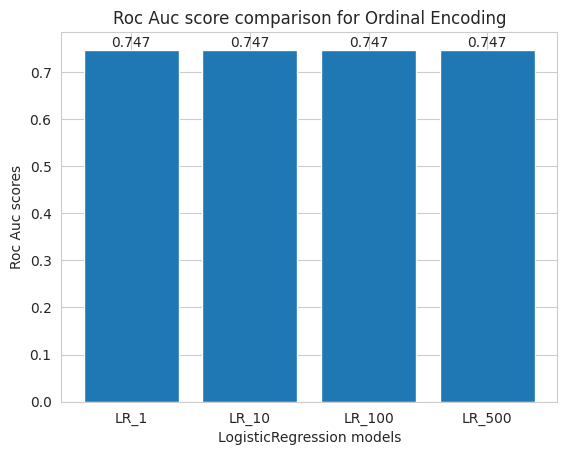

Average Roc Auc score for Frequency Encoding: 0.6485485975212003


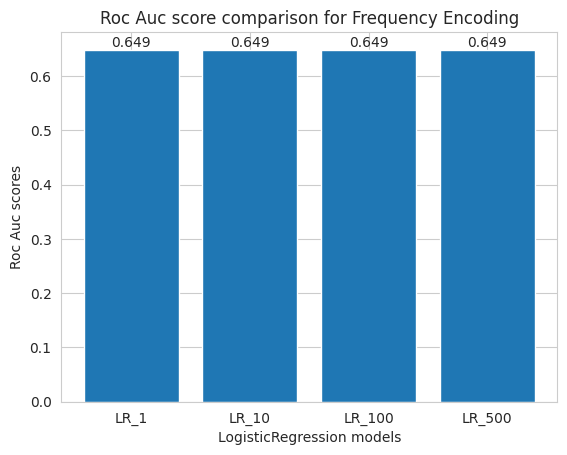

Average Roc Auc score for Target Encoding: 0.7683622125535945


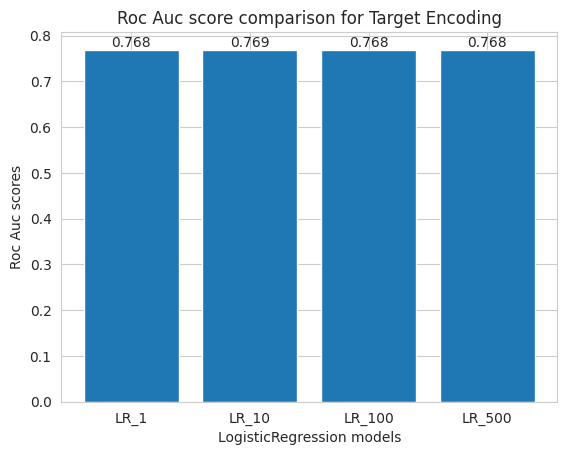

Average Roc Auc score for Response Encoding: 0.7692467970031476


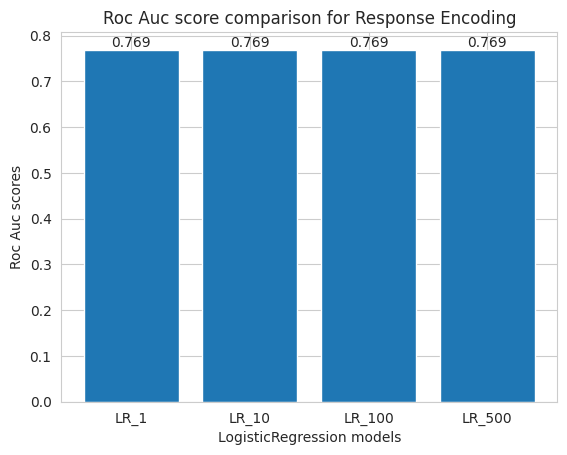

Average Roc Auc score for One Hot Encoding: 0.7629073015028595


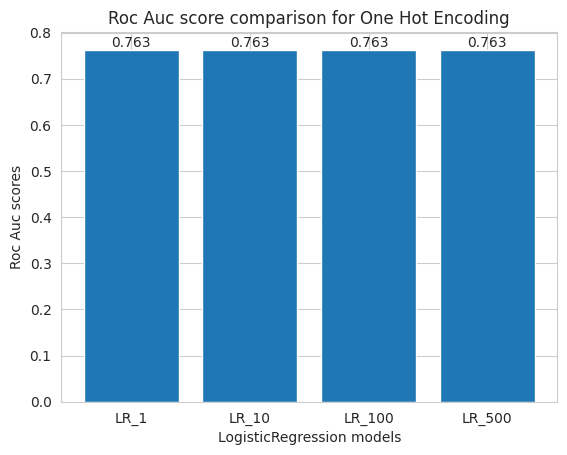

In [ ]:
# Evaluating Logistic Regression models with different C values and computing their Roc Auc scores

def LR_C_evaluation_roc_auc(X_train, y_train, X_test, y_test, encoding_method):
    # Create Logistic Regression models with different C values
    LR_1 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_10 = LogisticRegression(penalty='l2', C=10, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_100 = LogisticRegression(penalty='l2', C=100, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_500 = LogisticRegression(penalty='l2', C=500, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)

    # Make probability predictions using the models
    y_pred_LR_1 = LR_1.predict_proba(X_test)[:, 1]
    y_pred_LR_10 = LR_10.predict_proba(X_test)[:, 1]
    y_pred_LR_100 = LR_100.predict_proba(X_test)[:, 1]
    y_pred_LR_500 = LR_500.predict_proba(X_test)[:, 1]

    # Calculate Roc Auc scores for each model
    roc_auc_scores = [
        roc_auc_score(y_test, y_pred_LR_1),
        roc_auc_score(y_test, y_pred_LR_10),
        roc_auc_score(y_test, y_pred_LR_100),
        roc_auc_score(y_test, y_pred_LR_500)
    ]

    # Print the average Roc Auc score for the encoding method
    print(f"Average Roc Auc score for {encoding_method}: {np.mean(roc_auc_scores)}")

    # Create a bar plot to compare Roc Auc scores for each model
    models = ["LR_1", "LR_10", "LR_100", "LR_500"]
    bars = plt.bar(models, roc_auc_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("Roc Auc scores")
    plt.title(f"Roc Auc score comparison for {encoding_method}")

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()

# Call the function for each encoding method
LR_C_evaluation_roc_auc(X_train_Ordinal_encoding, y_train, X_test_Ordinal_encoding, y_test, "Ordinal Encoding")
LR_C_evaluation_roc_auc(X_train_frequency_encoding, y_train, X_test_frequency_encoding, y_test, "Frequency Encoding")
LR_C_evaluation_roc_auc(X_train_target_encoding, y_train, X_test_target_encoding, y_test, "Target Encoding")
LR_C_evaluation_roc_auc(X_train_response_encoding, y_train, X_test_response_encoding, y_test, "Response Encoding")
LR_C_evaluation_roc_auc(X_train_ohe, y_train, X_test_ohe, y_test, "One Hot Encoding")

### choose best C use log_loss

Average Log Loss score for Ordinal Encoding: 0.5860378577383188


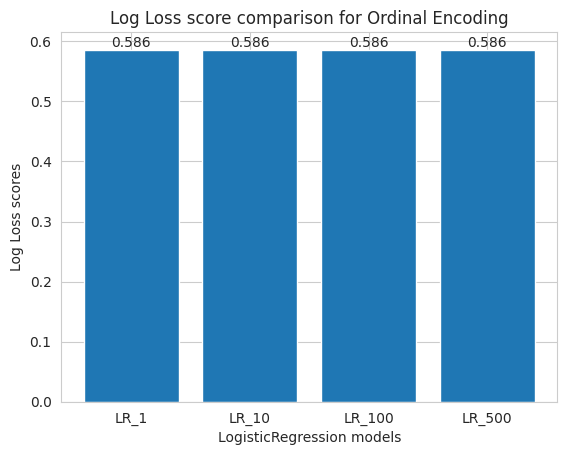

Average Log Loss score for Frequency Encoding: 0.6475835477698921


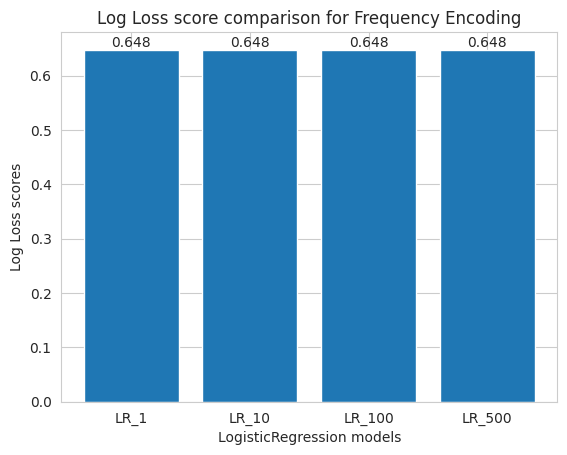

Average Log Loss score for Target Encoding: 0.5664057149774642


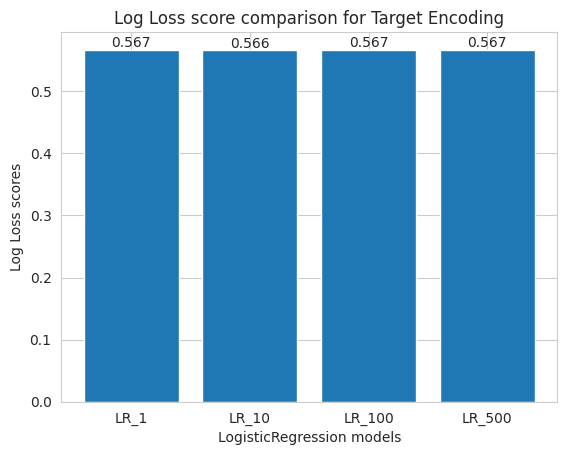

Average Log Loss score for Response Encoding: 0.5643906132860005


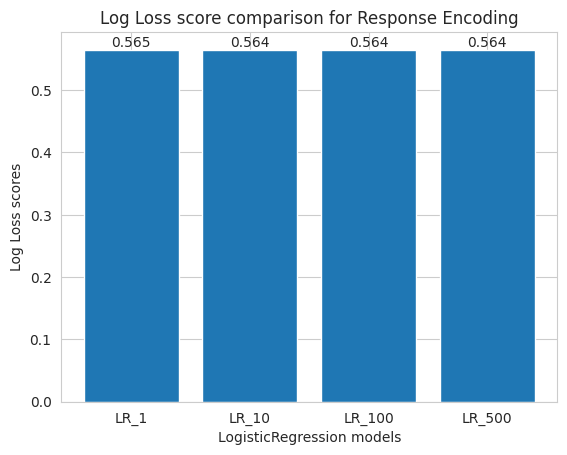

Average Log Loss score for One Hot Encoding: 0.5708535458082957


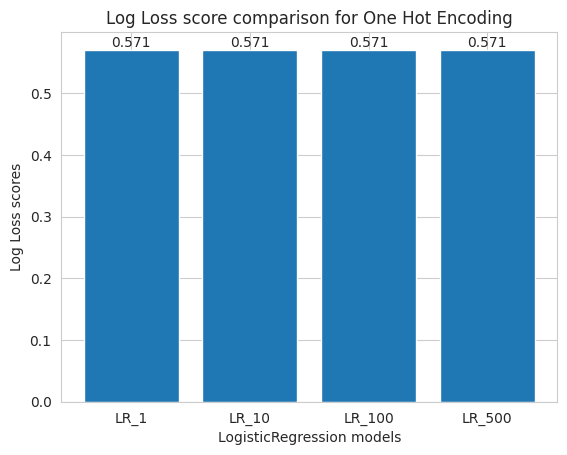

In [ ]:
# Evaluating Logistic Regression models with different C values and computing their Log Loss scores

def LR_C_evaluation_log_loss(X_train, y_train, X_test, y_test, encoding_method):
    # Create Logistic Regression models with different C values
    LR_1 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_10 = LogisticRegression(penalty='l2', C=10, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_100 = LogisticRegression(penalty='l2', C=100, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_500 = LogisticRegression(penalty='l2', C=500, solver='saga', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)

    # Make probability predictions using the models
    y_pred_LR_1 = LR_1.predict_proba(X_test)
    y_pred_LR_10 = LR_10.predict_proba(X_test)
    y_pred_LR_100 = LR_100.predict_proba(X_test)
    y_pred_LR_500 = LR_500.predict_proba(X_test)

    # Calculate Log Loss scores for each model
    log_loss_scores = [
        log_loss(y_test, y_pred_LR_1),
        log_loss(y_test, y_pred_LR_10),
        log_loss(y_test, y_pred_LR_100),
        log_loss(y_test, y_pred_LR_500)
    ]

    # Print the average Log Loss score for the encoding method
    print(f"Average Log Loss score for {encoding_method}: {np.mean(log_loss_scores)}")

    # Create a bar plot to compare Log Loss scores for each model
    models = ["LR_1", "LR_10", "LR_100", "LR_500"]
    bars = plt.bar(models, log_loss_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("Log Loss scores")
    plt.title(f"Log Loss score comparison for {encoding_method}")

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()

# Call the function for each encoding method
LR_C_evaluation_log_loss(X_train_Ordinal_encoding, y_train, X_test_Ordinal_encoding, y_test, "Ordinal Encoding")
LR_C_evaluation_log_loss(X_train_frequency_encoding, y_train, X_test_frequency_encoding, y_test, "Frequency Encoding")
LR_C_evaluation_log_loss(X_train_target_encoding, y_train, X_test_target_encoding, y_test, "Target Encoding")
LR_C_evaluation_log_loss(X_train_response_encoding, y_train, X_test_response_encoding, y_test, "Response Encoding")
LR_C_evaluation_log_loss(X_train_ohe, y_train, X_test_ohe, y_test, "One Hot Encoding")

### choose best solver use  F1

Average F1 score for Ordinal Encoding: 0.6917904331371257


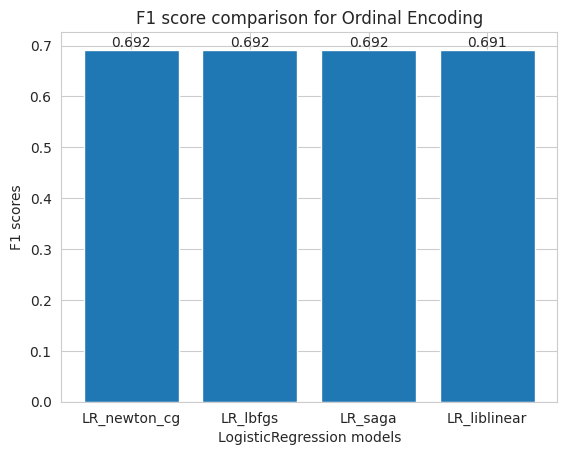

Average F1 score for Frequency Encoding: 0.6120594797515554


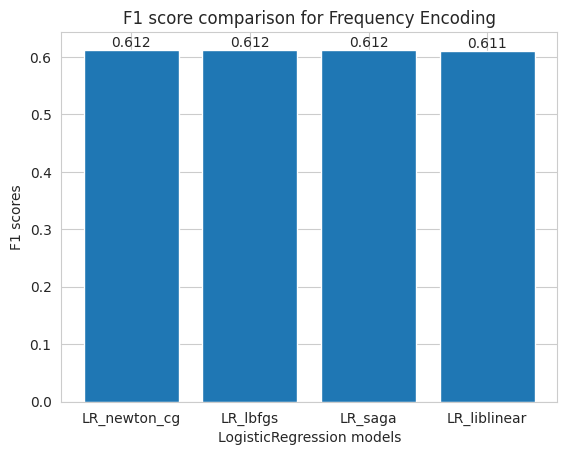

Average F1 score for Target Encoding: 0.7002090752101284


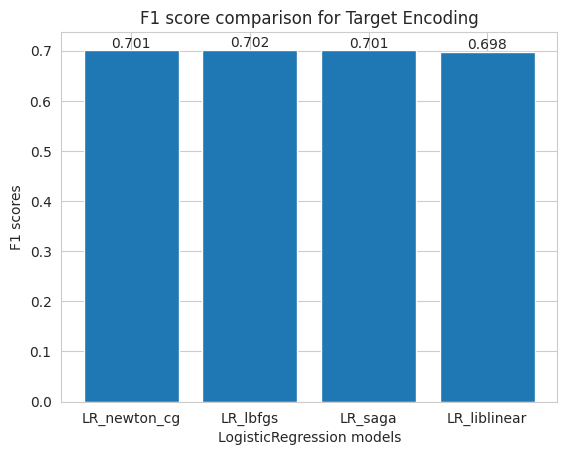

Average F1 score for Response Encoding: 0.7070085752076884


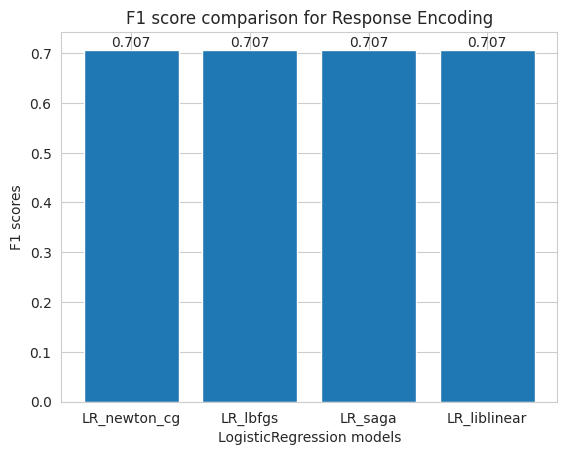

Average F1 score for One Hot Encoding: 0.6993867567307364


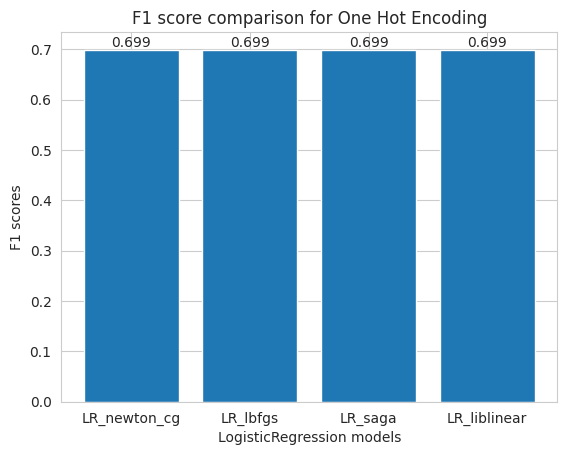

In [ ]:
def LR_solver_evaluation_f1(X_train, y_train, X_test, y_test, encoding_method):
    LR_newton_cg = LogisticRegression(penalty='l2', C=1, solver='newton-cg', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_lbfgs = LogisticRegression (penalty='l2', C=1, solver='lbfgs', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_saga = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_liblinear = LogisticRegression(penalty='l2', C=1, solver='liblinear', max_iter=100,class_weight=None,fit_intercept=True,  random_state=42,l1_ratio=0.5).fit(X_train, y_train)

    y_pred_LR_newton_cg = LR_newton_cg.predict(X_test)
    y_pred_LR_lbfgs = LR_lbfgs.predict(X_test)
    y_pred_LR_saga = LR_saga.predict(X_test)
    y_pred_LR_liblinear = LR_liblinear.predict(X_test)

    f1_scores = [
        classification_report(y_test, y_pred_LR_newton_cg, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_lbfgs, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_saga, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_liblinear, output_dict=True)["weighted avg"]["f1-score"]
    ]

    print(f"Average F1 score for {encoding_method}: {np.mean(f1_scores)}")


    models = ["LR_newton_cg", "LR_lbfgs", "LR_saga", "LR_liblinear"]
    bars = plt.bar(models, f1_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("F1 scores")
    plt.title(f"F1 score comparison for {encoding_method}")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()


LR_solver_evaluation_f1(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
LR_solver_evaluation_f1(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
LR_solver_evaluation_f1(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
LR_solver_evaluation_f1(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
LR_solver_evaluation_f1(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

### choose best solver use roc_auc_score

Average ROC AUC score for Ordinal Encoding: 0.7468502017112205


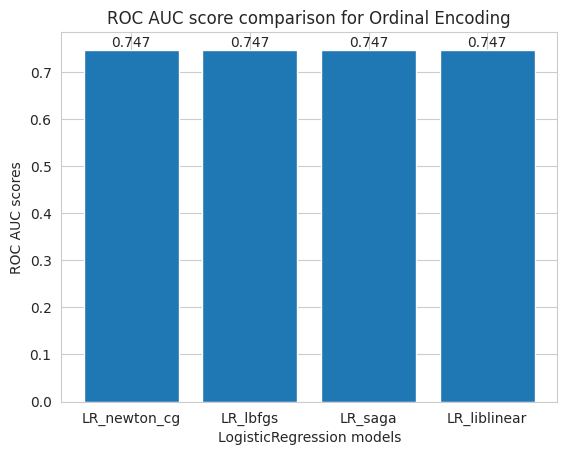

Average ROC AUC score for Frequency Encoding: 0.6485398894229856


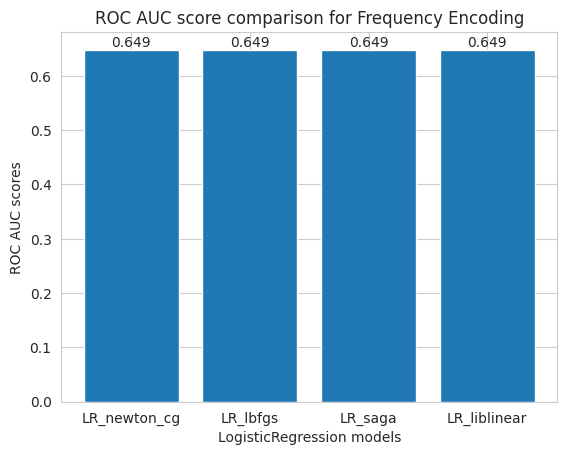

Average ROC AUC score for Target Encoding: 0.7672623005845508


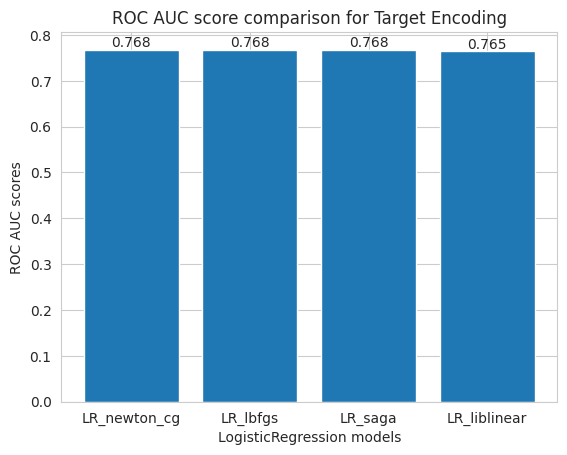

Average ROC AUC score for Response Encoding: 0.7686764957346152


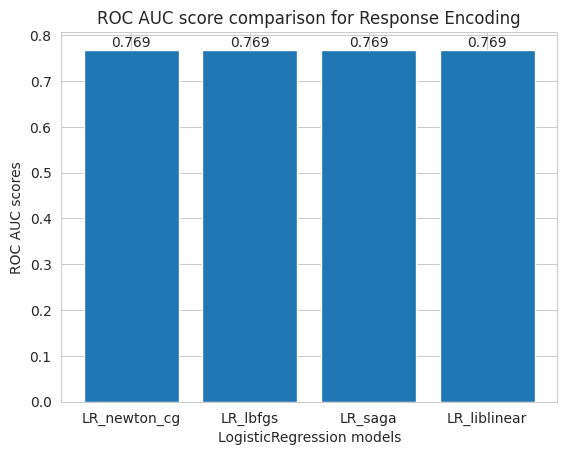

Average ROC AUC score for One Hot Encoding: 0.7630060988353315


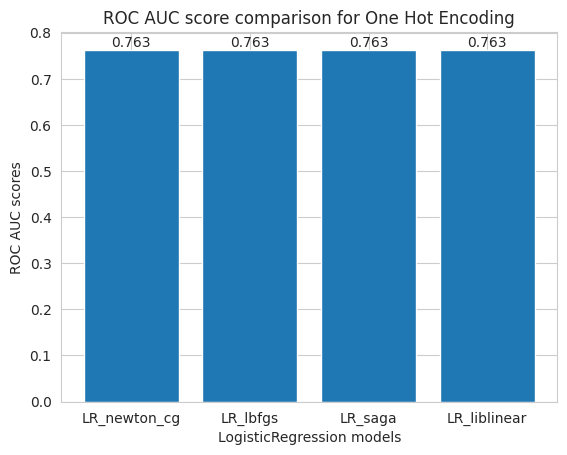

In [ ]:
# Evaluating Logistic Regression models with different solvers and computing their ROC AUC scores

from sklearn.metrics import roc_auc_score

def LR_solver_evaluation_roc_auc(X_train, y_train, X_test, y_test, encoding_method):
    # Create Logistic Regression models with different solvers
    LR_newton_cg = LogisticRegression(penalty='l2', C=1, solver='newton-cg', max_iter=100, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_lbfgs = LogisticRegression(penalty='l2', C=1, solver='lbfgs', max_iter=500, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_saga = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=1000, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)
    LR_liblinear = LogisticRegression(penalty='l2', C=1, solver='liblinear', max_iter=2000, class_weight=None, fit_intercept=True, random_state=42, l1_ratio=0.5).fit(X_train, y_train)

    # Make probability predictions using the models
    y_pred_LR_newton_cg = LR_newton_cg.predict_proba(X_test)[:, 1]
    y_pred_LR_lbfgs = LR_lbfgs.predict_proba(X_test)[:, 1]
    y_pred_LR_saga = LR_saga.predict_proba(X_test)[:, 1]
    y_pred_LR_liblinear = LR_liblinear.predict_proba(X_test)[:, 1]

    # Calculate ROC AUC scores for each model
    roc_auc_scores = [
        roc_auc_score(y_test, y_pred_LR_newton_cg),
        roc_auc_score(y_test, y_pred_LR_lbfgs),
        roc_auc_score(y_test, y_pred_LR_saga),
        roc_auc_score(y_test, y_pred_LR_liblinear)
    ]

    # Print the average ROC AUC score for the encoding method
    print(f"Average ROC AUC score for {encoding_method}: {np.mean(roc_auc_scores)}")

    # Create a bar plot to compare ROC AUC scores for each model
    models = ["LR_newton_cg", "LR_lbfgs", "LR_saga", "LR_liblinear"]
    bars = plt.bar(models, roc_auc_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("ROC AUC scores")
    plt.title(f"ROC AUC score comparison for {encoding_method}")

    # Add labels to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()

# Call the function for each encoding method
LR_solver_evaluation_roc_auc(X_train_Ordinal_encoding, y_train, X_test_Ordinal_encoding, y_test, "Ordinal Encoding")
LR_solver_evaluation_roc_auc(X_train_frequency_encoding, y_train, X_test_frequency_encoding, y_test, "Frequency Encoding")
LR_solver_evaluation_roc_auc(X_train_target_encoding, y_train, X_test_target_encoding, y_test, "Target Encoding")
LR_solver_evaluation_roc_auc(X_train_response_encoding, y_train, X_test_response_encoding, y_test, "Response Encoding")
LR_solver_evaluation_roc_auc(X_train_ohe, y_train, X_test_ohe, y_test, "One Hot Encoding")

### choose best solver use log_loss

Average Log_Loss score for Ordinal Encoding: 0.5860174756756336


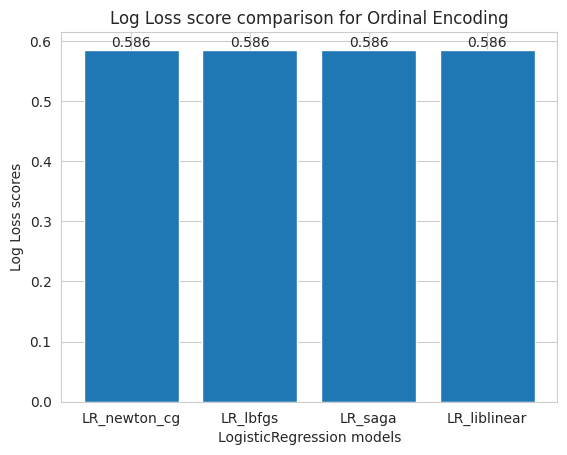

Average Log_Loss score for Frequency Encoding: 0.647657178622083


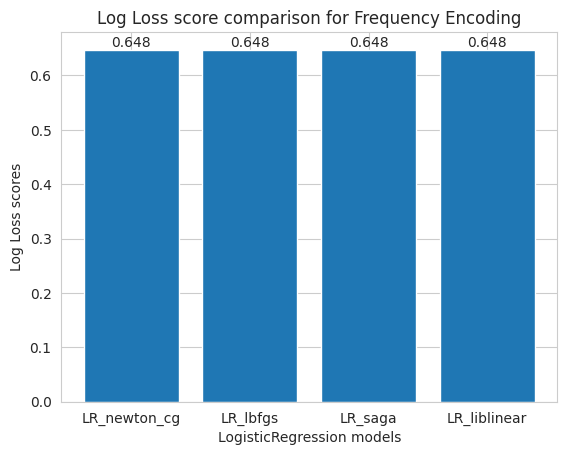

Average Log_Loss score for Target Encoding: 0.5668094686189648


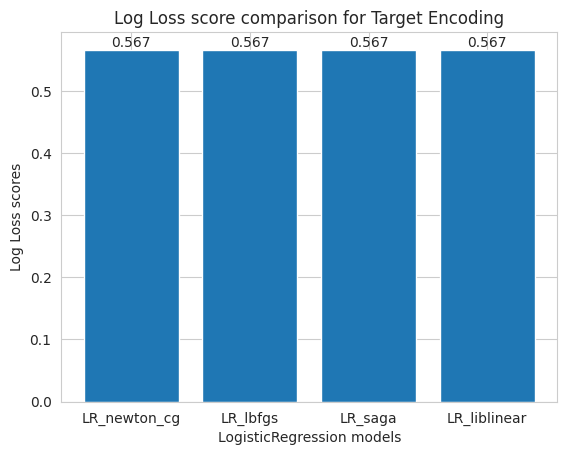

Average Log_Loss score for Response Encoding: 0.5649453876723576


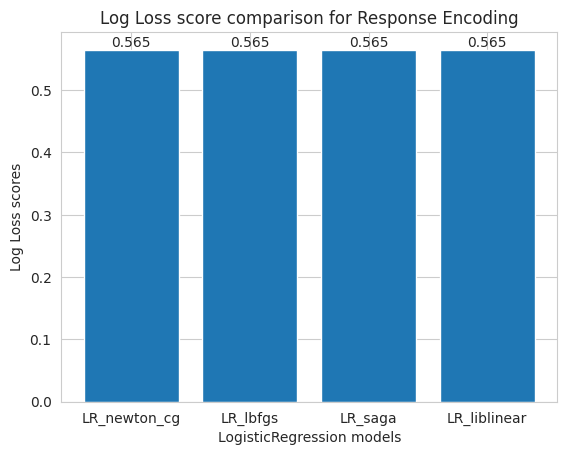

Average Log_Loss score for One Hot Encoding: 0.570692309494583


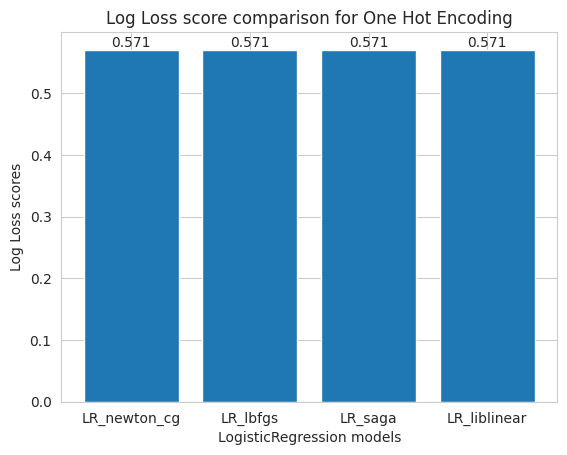

In [ ]:
# Evaluating Logistic Regression models with different solvers and computing their Log Loss scores
def LR_solver_evaluation_log_loss(X_train, y_train, X_test, y_test, encoding_method):
    LR_newton_cg = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_lbfgs = LogisticRegression (penalty='l2', C=1, solver='saga', max_iter=500,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_saga = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=1000,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_liblinear = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=2000,class_weight=None,fit_intercept=True,  random_state=42,l1_ratio=0.5).fit(X_train, y_train)

    y_pred_LR_newton_cg = LR_newton_cg.predict_proba(X_test)
    y_pred_LR_lbfgs = LR_lbfgs.predict_proba(X_test)
    y_pred_LR_saga = LR_saga.predict_proba(X_test)
    y_pred_LR_liblinear = LR_liblinear.predict_proba(X_test)

    log_loss_scores = [
        log_loss(y_test,  y_pred_LR_newton_cg),
        log_loss(y_test,  y_pred_LR_lbfgs),
        log_loss(y_test,  y_pred_LR_saga),
        log_loss(y_test,  y_pred_LR_liblinear)
    ]

    print(f"Average Log_Loss score for {encoding_method}: {np.mean(log_loss_scores)}")


    models = ["LR_newton_cg", "LR_lbfgs", "LR_saga", "LR_liblinear"]
    bars = plt.bar(models, log_loss_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("Log Loss scores")
    plt.title(f"Log Loss score comparison for {encoding_method}")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()


LR_solver_evaluation_log_loss(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
LR_solver_evaluation_log_loss(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
LR_solver_evaluation_log_loss(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
LR_solver_evaluation_log_loss(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
LR_solver_evaluation_log_loss(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

### choose best max_iter use F1

Average F1 score for Ordinal Encoding: 0.6919896636263713


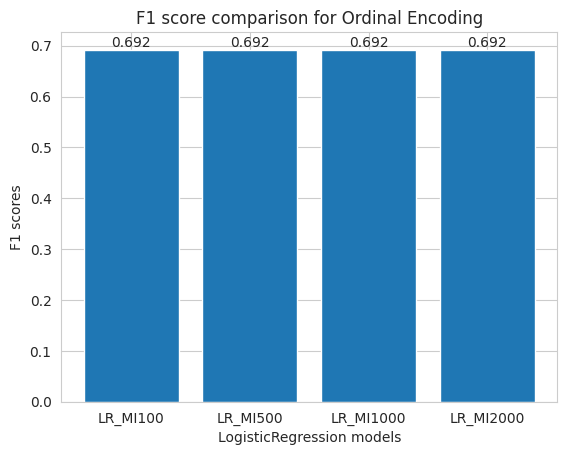

Average F1 score for Frequency Encoding: 0.6124600847390715


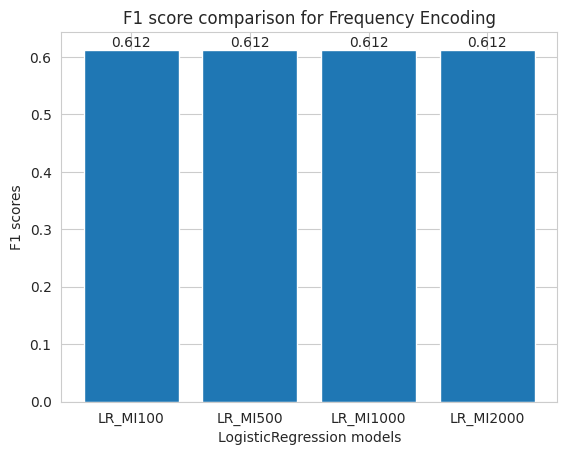

Average F1 score for Target Encoding: 0.7007102590759986


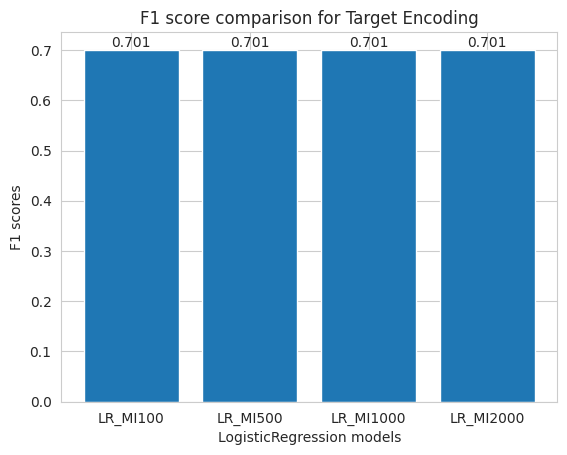

Average F1 score for Response Encoding: 0.7071174655520006


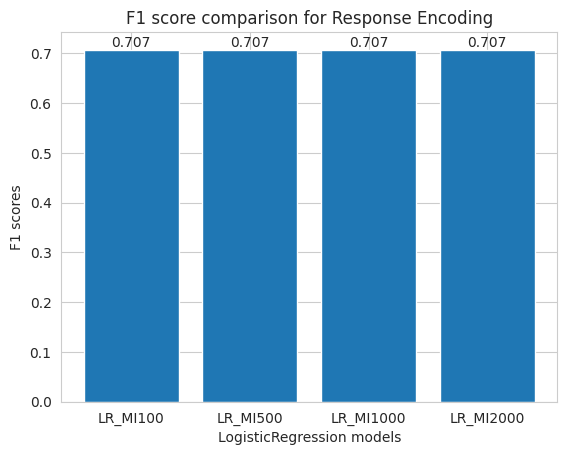

Average F1 score for One Hot Encoding: 0.6993867567307364


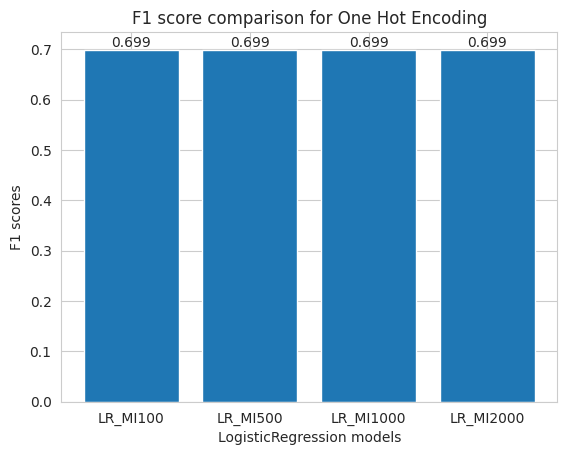

In [ ]:
def LR_max_iter_evaluation_f1(X_train, y_train, X_test, y_test, encoding_method):
    LR_MI100 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_MI500 = LogisticRegression (penalty='l2', C=1, solver='saga', max_iter=500,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_MI1000 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=1000,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_MI2000 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=2000,class_weight=None,fit_intercept=True,  random_state=42,l1_ratio=0.5).fit(X_train, y_train)

    y_pred_LR_MI100 = LR_MI100.predict(X_test)
    y_pred_LR_MI500 = LR_MI500.predict(X_test)
    y_pred_LR_MI1000 = LR_MI1000.predict(X_test)
    y_pred_LR_MI2000 = LR_MI2000.predict(X_test)

    f1_scores = [
        classification_report(y_test, y_pred_LR_MI100, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_MI500, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_MI1000, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_MI2000, output_dict=True)["weighted avg"]["f1-score"]
    ]

    print(f"Average F1 score for {encoding_method}: {np.mean(f1_scores)}")


    models = ["LR_MI100", "LR_MI500", "LR_MI1000", "LR_MI2000"]
    bars = plt.bar(models, f1_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("F1 scores")
    plt.title(f"F1 score comparison for {encoding_method}")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()


LR_max_iter_evaluation_f1(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
LR_max_iter_evaluation_f1(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
LR_max_iter_evaluation_f1(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
LR_max_iter_evaluation_f1(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
LR_max_iter_evaluation_f1(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

### choose best max_iter use roc_auc_score

Average Roc_Auc score for Ordinal Encoding: 0.7468502017112205


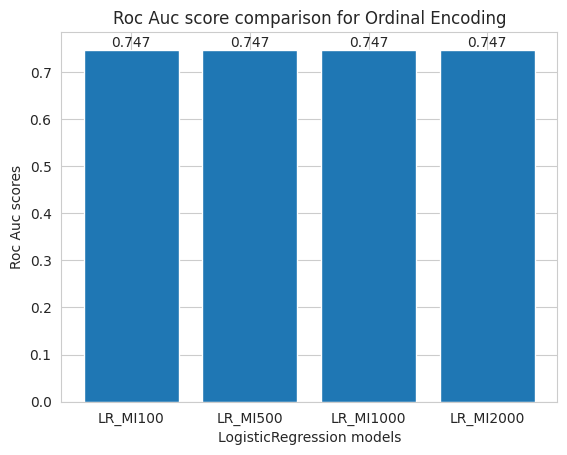

Average Roc_Auc score for Frequency Encoding: 0.6485384644614596


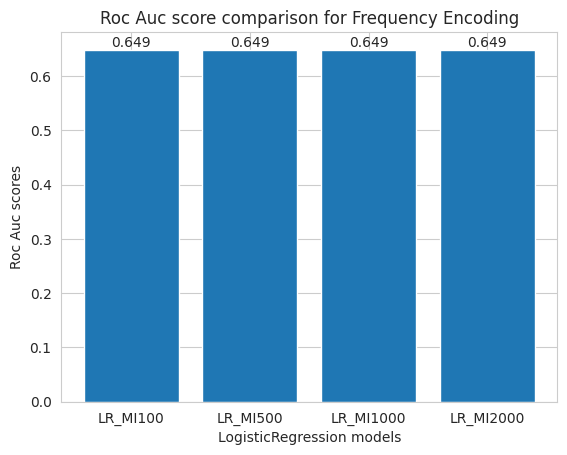

Average Roc_Auc score for Target Encoding: 0.7672497925889334


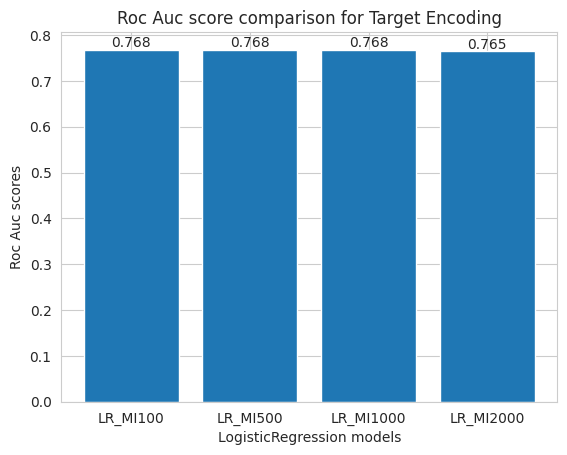

Average Roc_Auc score for Response Encoding: 0.7686766540636736


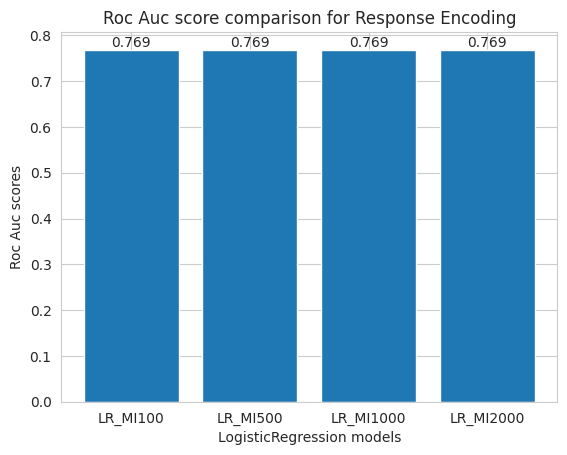

Average Roc_Auc score for One Hot Encoding: 0.7630060988353315


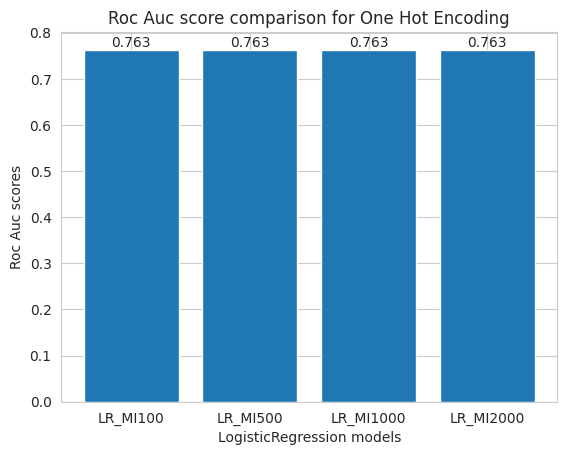

In [ ]:
def LR_max_iter_evaluation_roc_auc(X_train, y_train, X_test, y_test, encoding_method):
    LR_MI100 = LogisticRegression(penalty='l2', C=1, solver='newton-cg', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_MI500 = LogisticRegression (penalty='l2', C=1, solver='lbfgs', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_MI1000 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_MI2000 = LogisticRegression(penalty='l2', C=1, solver='liblinear', max_iter=100,class_weight=None,fit_intercept=True,  random_state=42,l1_ratio=0.5).fit(X_train, y_train)

    y_pred_LR_MI100 = LR_MI100.predict_proba(X_test)[:, 1]
    y_pred_LR_MI500 = LR_MI500.predict_proba(X_test)[:, 1]
    y_pred_LR_MI1000 = LR_MI1000.predict_proba(X_test)[:, 1]
    y_pred_LR_MI2000 = LR_MI2000.predict_proba(X_test)[:, 1]

    roc_auc_scores = [
        roc_auc_score(y_test,  y_pred_LR_MI100),
        roc_auc_score(y_test,  y_pred_LR_MI500),
        roc_auc_score(y_test,  y_pred_LR_MI1000),
        roc_auc_score(y_test,  y_pred_LR_MI2000)
    ]

    print(f"Average Roc_Auc score for {encoding_method}: {np.mean(roc_auc_scores)}")


    models = ["LR_MI100", "LR_MI500", "LR_MI1000", "LR_MI2000"]
    bars = plt.bar(models, roc_auc_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("Roc Auc scores")
    plt.title(f"Roc Auc score comparison for {encoding_method}")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()


LR_max_iter_evaluation_roc_auc(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
LR_max_iter_evaluation_roc_auc(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
LR_max_iter_evaluation_roc_auc(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
LR_max_iter_evaluation_roc_auc(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
LR_max_iter_evaluation_roc_auc(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

### choose best max_iter use log_loss

Average Log_Loss score for Ordinal Encoding: 0.5860162008741009


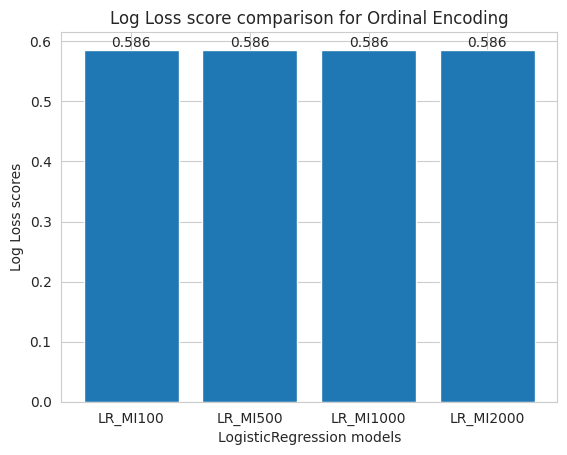

Average Log_Loss score for Frequency Encoding: 0.6476767940254536


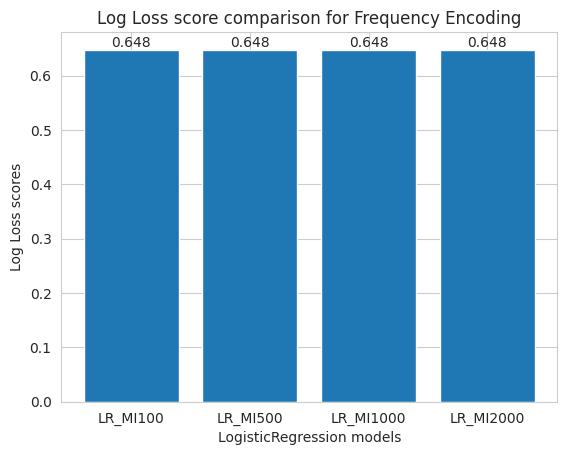

Average Log_Loss score for Target Encoding: 0.5680955657720685


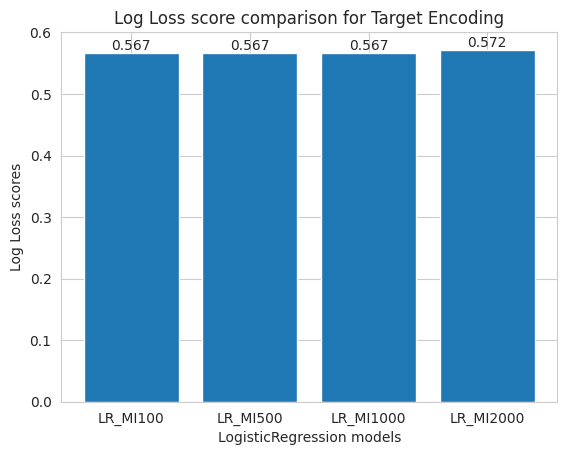

Average Log_Loss score for Response Encoding: 0.5649456477766553


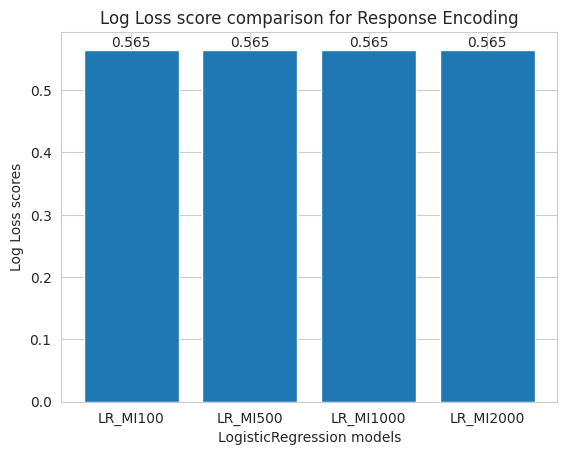

Average Log_Loss score for One Hot Encoding: 0.5706917258387652


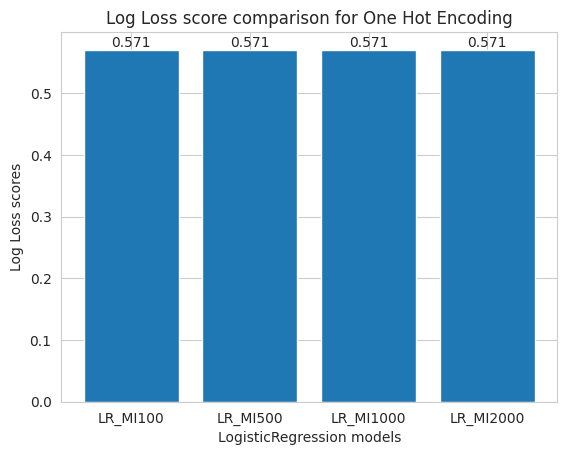

In [ ]:
from sklearn.metrics import log_loss

def LR_max_iter_evaluation_log_loss(X_train, y_train, X_test, y_test, encoding_method):
    LR_MI100 = LogisticRegression(penalty='l2', C=1, solver='newton-cg', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_MI500 = LogisticRegression (penalty='l2', C=1, solver='lbfgs', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_MI1000 = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_MI2000 = LogisticRegression(penalty='l2', C=1, solver='liblinear', max_iter=100,class_weight=None,fit_intercept=True,  random_state=42,l1_ratio=0.5).fit(X_train, y_train)

    y_pred_LR_MI100 = LR_MI100.predict_proba(X_test)
    y_pred_LR_MI500 = LR_MI500.predict_proba(X_test)
    y_pred_LR_MI1000 = LR_MI1000.predict_proba(X_test)
    y_pred_LR_MI2000 = LR_MI2000.predict_proba(X_test)

    log_loss_scores = [
        log_loss(y_test,  y_pred_LR_MI100),
        log_loss(y_test,  y_pred_LR_MI500),
        log_loss(y_test,  y_pred_LR_MI1000),
        log_loss(y_test,  y_pred_LR_MI2000)
    ]

    print(f"Average Log_Loss score for {encoding_method}: {np.mean(log_loss_scores)}")


    models = ["LR_MI100", "LR_MI500", "LR_MI1000", "LR_MI2000"]
    bars = plt.bar(models, log_loss_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("Log Loss scores")
    plt.title(f"Log Loss score comparison for {encoding_method}")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()


LR_max_iter_evaluation_log_loss(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
LR_max_iter_evaluation_log_loss(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
LR_max_iter_evaluation_log_loss(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
LR_max_iter_evaluation_log_loss(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
LR_max_iter_evaluation_log_loss(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

### choose best class_weight use F1

Average F1 score for Ordinal Encoding: 0.6908305751490786


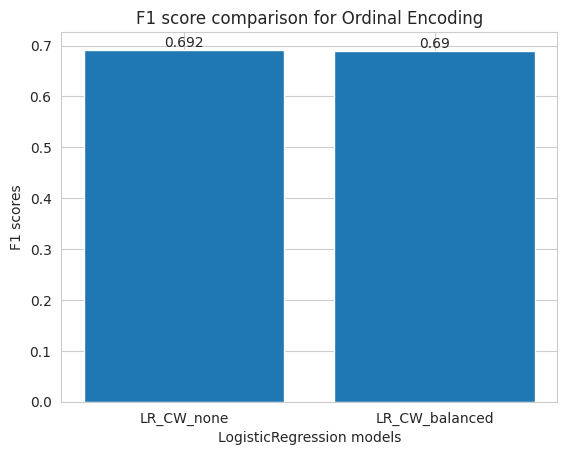

Average F1 score for Frequency Encoding: 0.6078987869124006


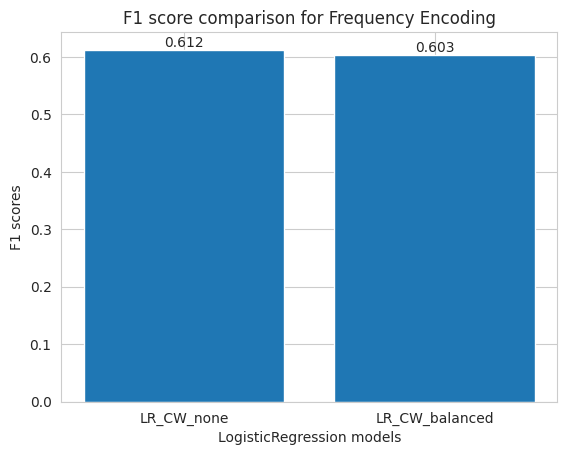

Average F1 score for Target Encoding: 0.7038479916377254


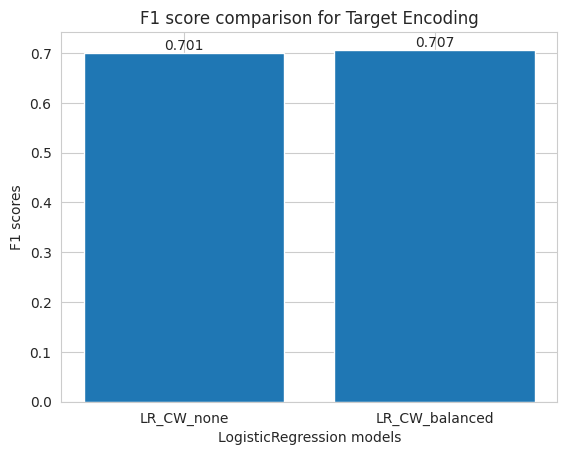

Average F1 score for Response Encoding: 0.7056657872031327


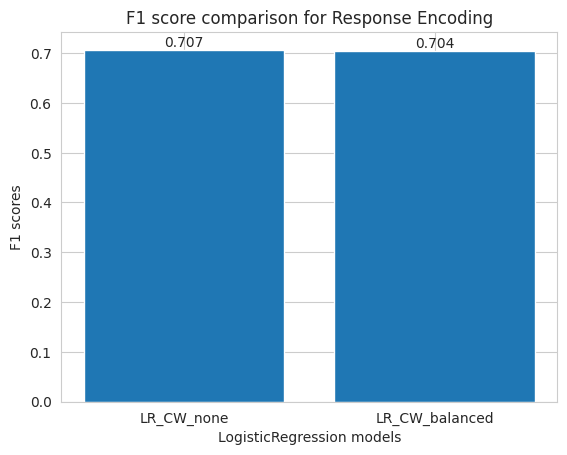

Average F1 score for One Hot Encoding: 0.6998896123115703


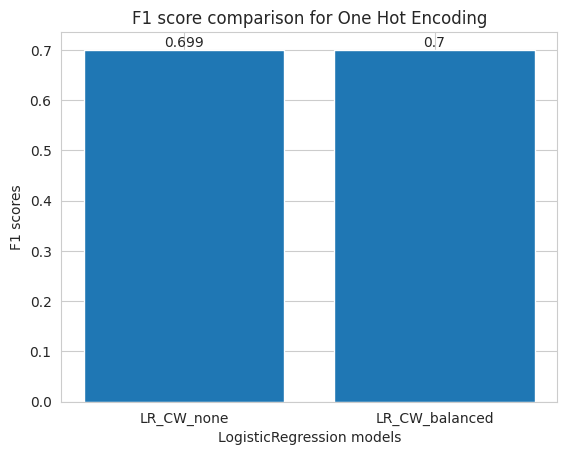

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np

def LR_class_weight_evaluation_f1(X_train, y_train, X_test, y_test, encoding_method):
    LR_CW_none = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_CW_balanced = LogisticRegression (penalty='l2', C=1, solver='saga', max_iter=100,class_weight='balanced',fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)

    y_pred_LR_CW_none = LR_CW_none.predict(X_test)
    y_pred_LR_CW_balanced = LR_CW_balanced.predict(X_test)

    f1_scores = [
        classification_report(y_test, y_pred_LR_CW_none, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_CW_balanced, output_dict=True)["weighted avg"]["f1-score"],
    ]

    print(f"Average F1 score for {encoding_method}: {np.mean(f1_scores)}")


    models = ["LR_CW_none", "LR_CW_balanced"]
    bars = plt.bar(models, f1_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("F1 scores")
    plt.title(f"F1 score comparison for {encoding_method}")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()


LR_class_weight_evaluation_f1(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
LR_class_weight_evaluation_f1(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
LR_class_weight_evaluation_f1(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
LR_class_weight_evaluation_f1(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
LR_class_weight_evaluation_f1(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

### choose best class_weight use roc_auc_score

Average Roc_Auc score for Ordinal Encoding: 0.7468498850531036


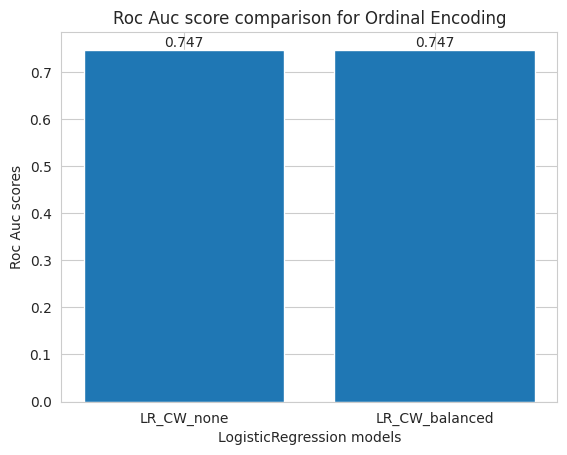

Average Roc_Auc score for Frequency Encoding: 0.6487048683018892


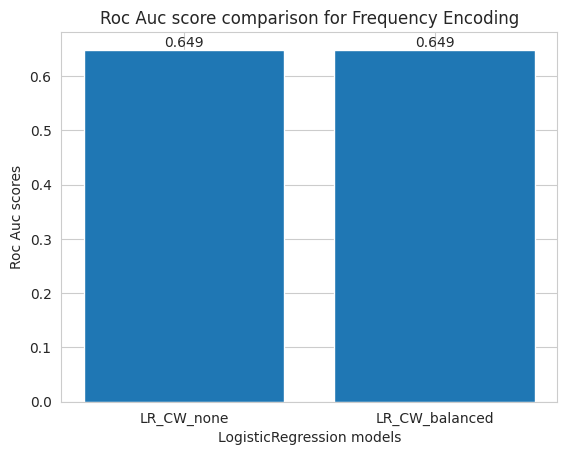

Average Roc_Auc score for Target Encoding: 0.7681882089183591


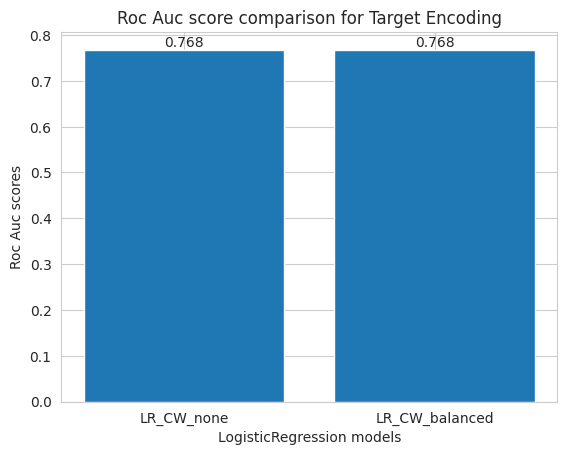

Average Roc_Auc score for Response Encoding: 0.7687125947599416


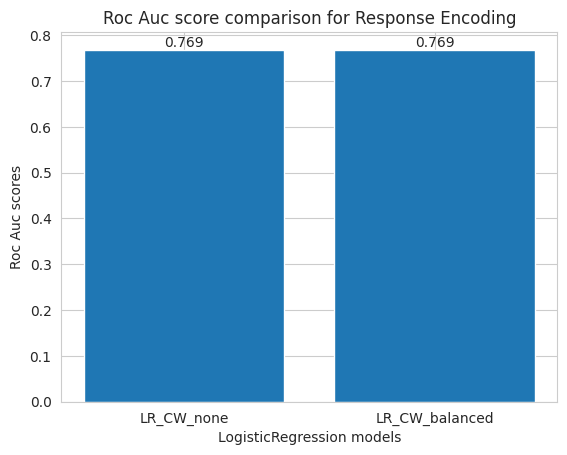

Average Roc_Auc score for One Hot Encoding: 0.7630782968859842


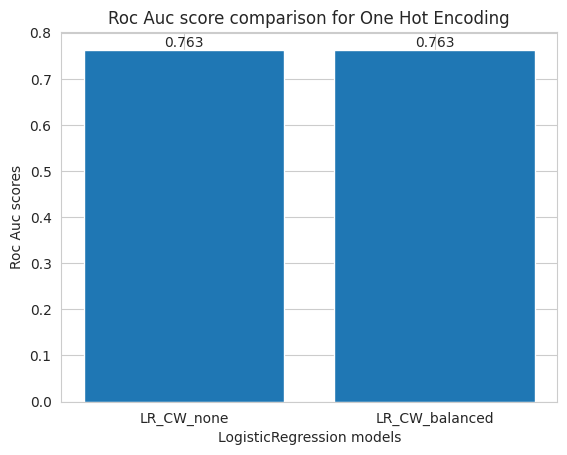

In [ ]:
def LR_class_weight_evaluation_roc_auc(X_train, y_train, X_test, y_test, encoding_method):
    LR_CW_none = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_CW_balanced = LogisticRegression (penalty='l2', C=1, solver='saga', max_iter=100,class_weight='balanced',fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)

    y_pred_LR_CW_none = LR_CW_none.predict_proba(X_test)[:, 1]
    y_pred_LR_CW_balanced = LR_CW_balanced.predict_proba(X_test)[:, 1]

    roc_auc_scores = [
        roc_auc_score(y_test,  y_pred_LR_CW_none),
        roc_auc_score(y_test,  y_pred_LR_CW_balanced),
    ]

    print(f"Average Roc_Auc score for {encoding_method}: {np.mean(roc_auc_scores)}")


    models = ["LR_CW_none", "LR_CW_balanced"]
    bars = plt.bar(models, roc_auc_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("Roc Auc scores")
    plt.title(f"Roc Auc score comparison for {encoding_method}")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()


LR_class_weight_evaluation_roc_auc(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
LR_class_weight_evaluation_roc_auc(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
LR_class_weight_evaluation_roc_auc(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
LR_class_weight_evaluation_roc_auc(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
LR_class_weight_evaluation_roc_auc(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

### choose best class_weight use log_loss

Average Log_Loss score for Ordinal Encoding: 0.589925196637666


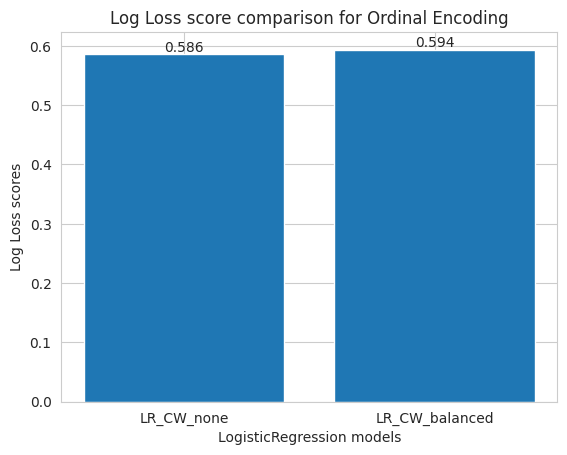

Average Log_Loss score for Frequency Encoding: 0.6521351290734878


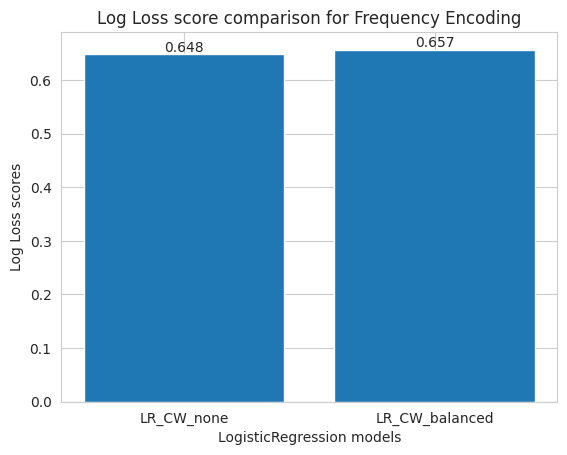

Average Log_Loss score for Target Encoding: 0.5704474641000903


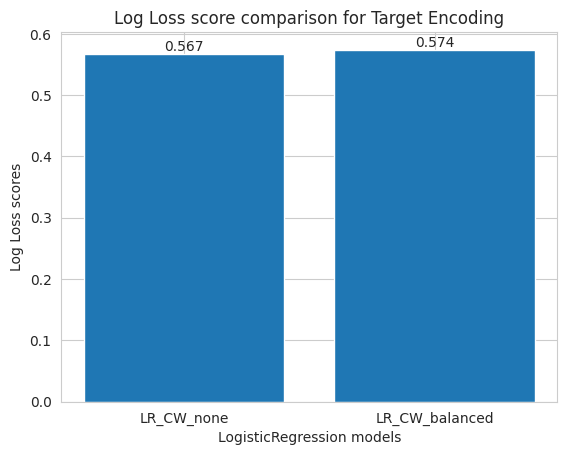

Average Log_Loss score for Response Encoding: 0.568378623267723


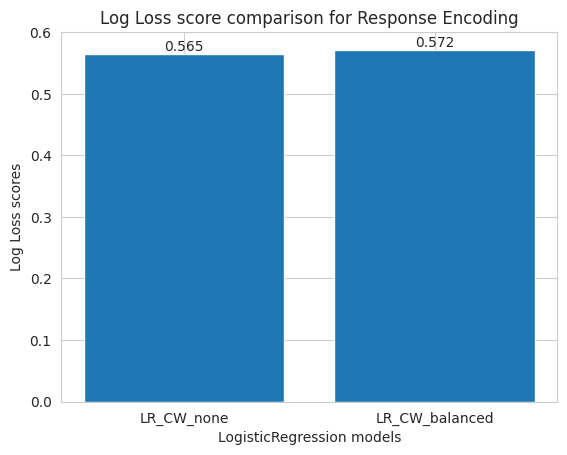

Average Log_Loss score for One Hot Encoding: 0.5743981999049568


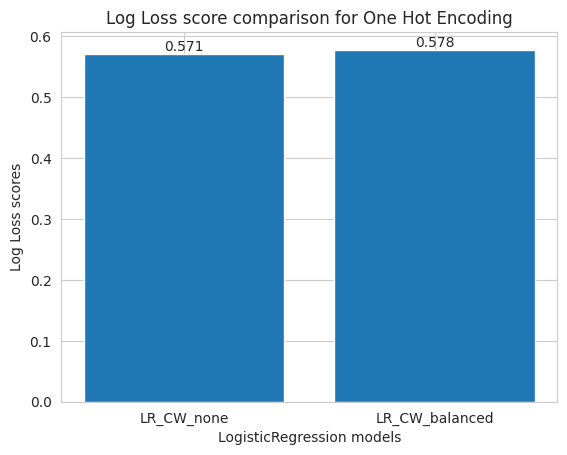

In [ ]:
from sklearn.metrics import log_loss

def LR_class_weight_evaluation_log_loss(X_train, y_train, X_test, y_test, encoding_method):
    LR_CW_none = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_CW_balanced = LogisticRegression (penalty='l2', C=1, solver='saga', max_iter=100,class_weight='balanced',fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)

    y_pred_LR_CW_none = LR_CW_none.predict_proba(X_test)
    y_pred_LR_CW_balanced = LR_CW_balanced.predict_proba(X_test)

    log_loss_scores = [
        log_loss(y_test,  y_pred_LR_CW_none),
        log_loss(y_test,  y_pred_LR_CW_balanced),
    ]

    print(f"Average Log_Loss score for {encoding_method}: {np.mean(log_loss_scores)}")


    models = ["LR_CW_none", "LR_CW_balanced"]
    bars = plt.bar(models, log_loss_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("Log Loss scores")
    plt.title(f"Log Loss score comparison for {encoding_method}")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()


LR_class_weight_evaluation_log_loss(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
LR_class_weight_evaluation_log_loss(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
LR_class_weight_evaluation_log_loss(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
LR_class_weight_evaluation_log_loss(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
LR_class_weight_evaluation_log_loss(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

### choose best fit_intercept use F1

Average F1 score for Ordinal Encoding: 0.6931778198075335


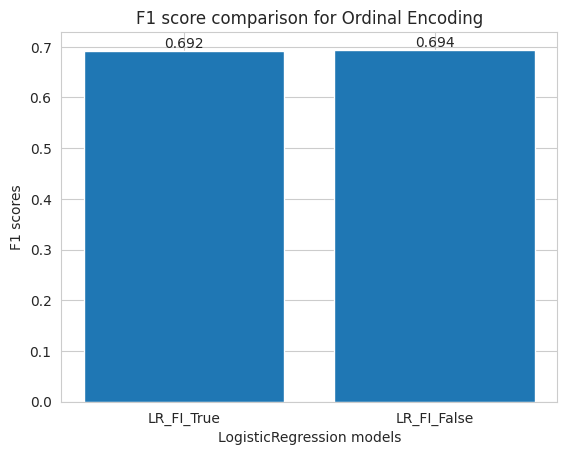

Average F1 score for Frequency Encoding: 0.6135258081551371


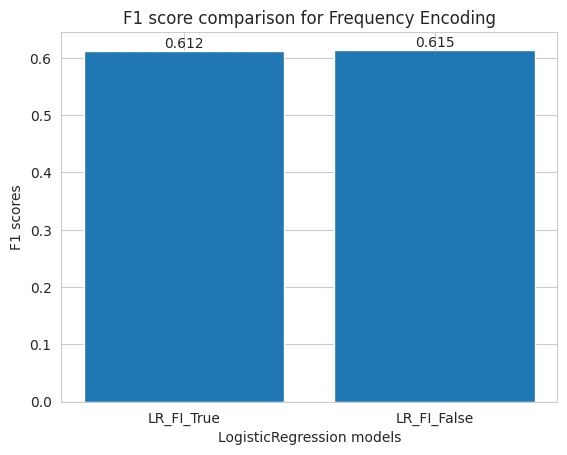

Average F1 score for Target Encoding: 0.6964467533217755


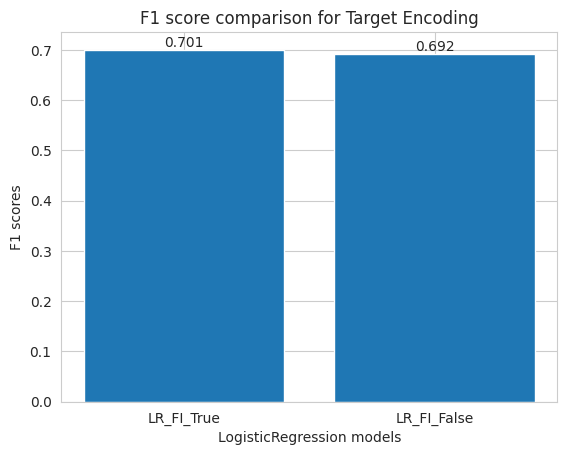

Average F1 score for Response Encoding: 0.7068996848633764


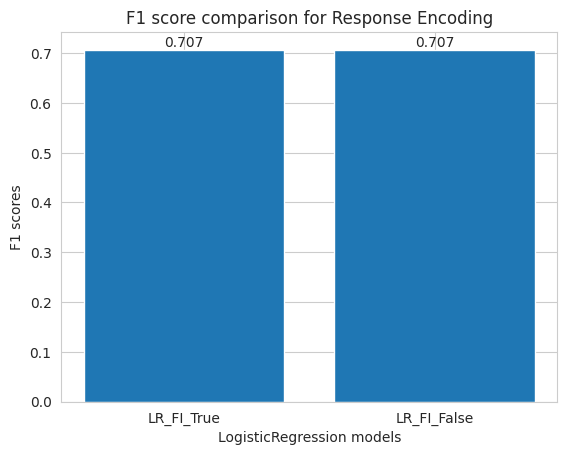

Average F1 score for One Hot Encoding: 0.6993867567307364


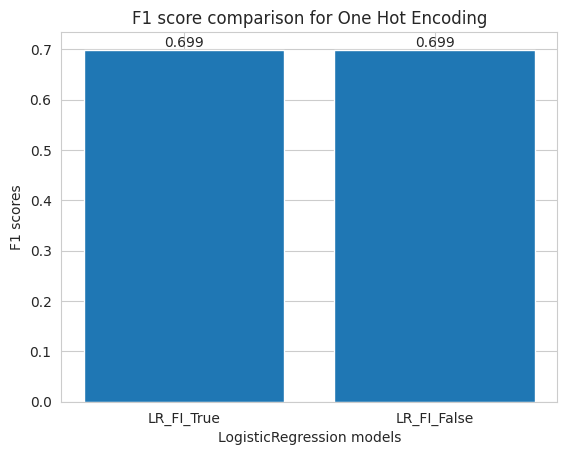

In [ ]:
def LR_fit_intercept_evaluation_f1(X_train, y_train, X_test, y_test, encoding_method):
    LR_FI_True = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_FI_False = LogisticRegression (penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=False, random_state=42,l1_ratio=0.5).fit(X_train, y_train)

    y_pred_LR_FI_True = LR_FI_True.predict(X_test)
    y_pred_LR_FI_False = LR_FI_False.predict(X_test)

    f1_scores = [
        classification_report(y_test, y_pred_LR_FI_True, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_LR_FI_False, output_dict=True)["weighted avg"]["f1-score"],
    ]

    print(f"Average F1 score for {encoding_method}: {np.mean(f1_scores)}")


    models = ["LR_FI_True", "LR_FI_False"]
    bars = plt.bar(models, f1_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("F1 scores")
    plt.title(f"F1 score comparison for {encoding_method}")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()


LR_fit_intercept_evaluation_f1(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
LR_fit_intercept_evaluation_f1(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
LR_fit_intercept_evaluation_f1(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
LR_fit_intercept_evaluation_f1(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
LR_fit_intercept_evaluation_f1(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

### choose best fit_intercept use roc_auc_score

Average Roc_Auc score for Ordinal Encoding: 0.7426427653120034


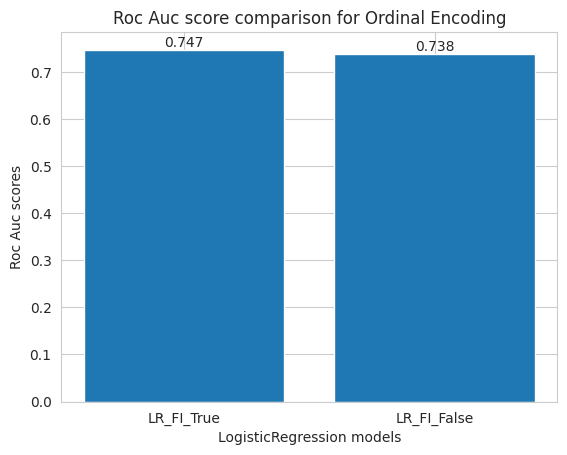

Average Roc_Auc score for Frequency Encoding: 0.6482324143914782


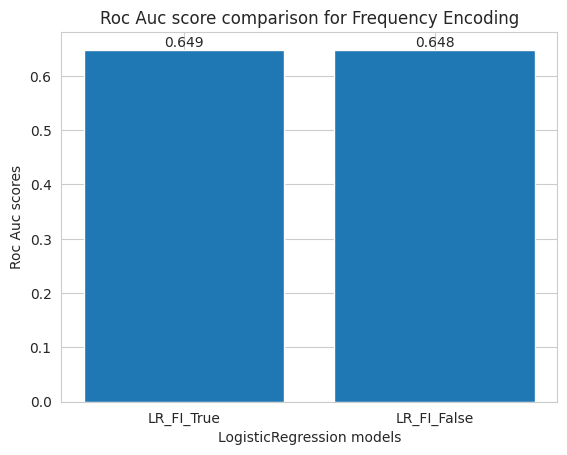

Average Roc_Auc score for Target Encoding: 0.7631039461934528


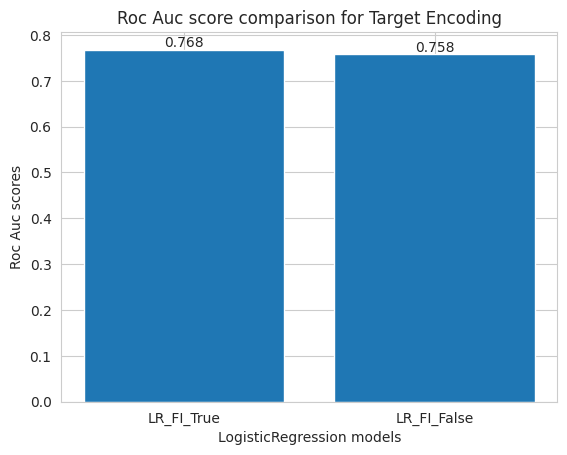

Average Roc_Auc score for Response Encoding: 0.7686761790764982


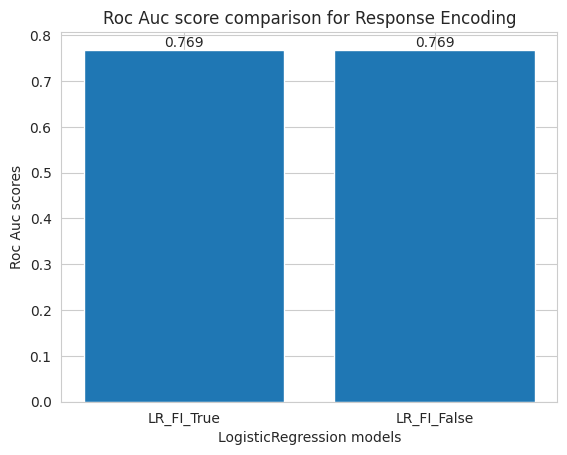

Average Roc_Auc score for One Hot Encoding: 0.7630019822798119


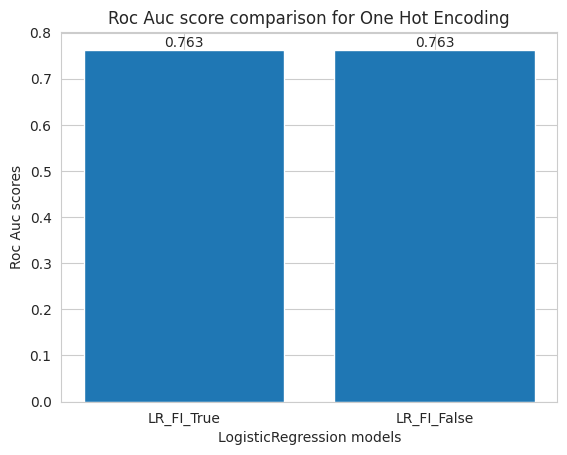

In [ ]:
def LR_fit_intercept_evaluation_roc_auc(X_train, y_train, X_test, y_test, encoding_method):
    LR_FI_True = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_FI_False = LogisticRegression (penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=False, random_state=42,l1_ratio=0.5).fit(X_train, y_train)

    y_pred_LR_FI_True = LR_FI_True.predict_proba(X_test)[:, 1]
    y_pred_LR_FI_False = LR_FI_False.predict_proba(X_test)[:, 1]

    roc_auc_scores = [
        roc_auc_score(y_test,  y_pred_LR_FI_True),
        roc_auc_score(y_test,  y_pred_LR_FI_False),
    ]

    print(f"Average Roc_Auc score for {encoding_method}: {np.mean(roc_auc_scores)}")


    models = ["LR_FI_True", "LR_FI_False"]
    bars = plt.bar(models, roc_auc_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("Roc Auc scores")
    plt.title(f"Roc Auc score comparison for {encoding_method}")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()


LR_fit_intercept_evaluation_roc_auc(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
LR_fit_intercept_evaluation_roc_auc(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
LR_fit_intercept_evaluation_roc_auc(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
LR_fit_intercept_evaluation_roc_auc(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
LR_fit_intercept_evaluation_roc_auc(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

### choose best fit_intercept use log_loss

Average Log_Loss score for Ordinal Encoding: 0.5897919000326937


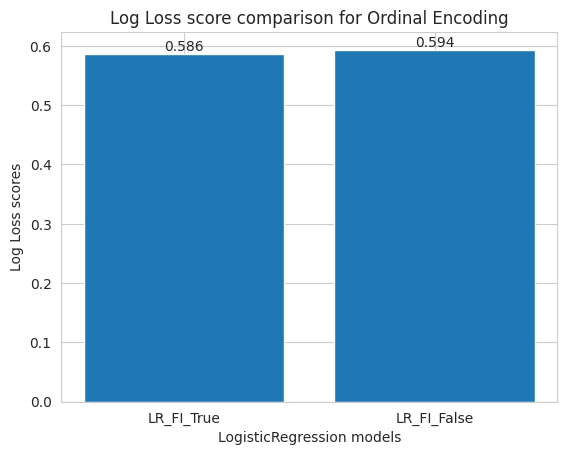

Average Log_Loss score for Frequency Encoding: 0.6479348156649107


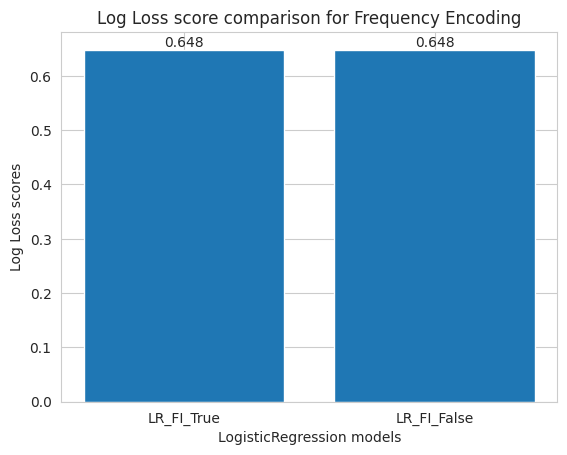

Average Log_Loss score for Target Encoding: 0.5728839950847245


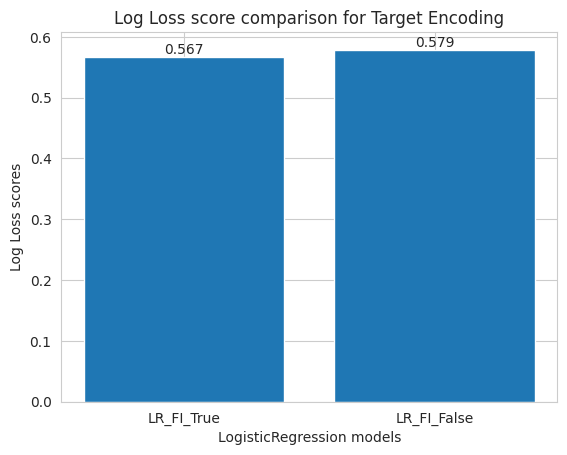

Average Log_Loss score for Response Encoding: 0.5649492818841102


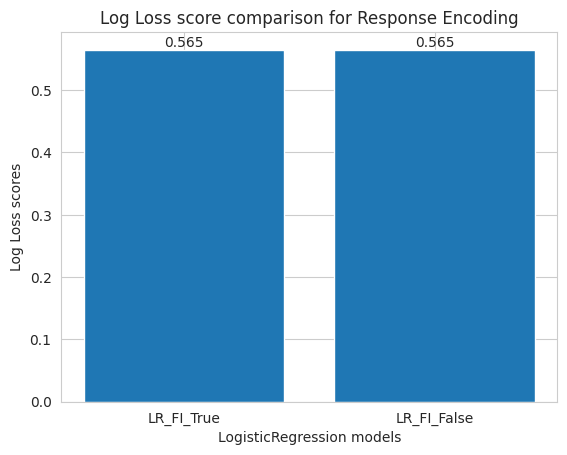

Average Log_Loss score for One Hot Encoding: 0.5706922281378395


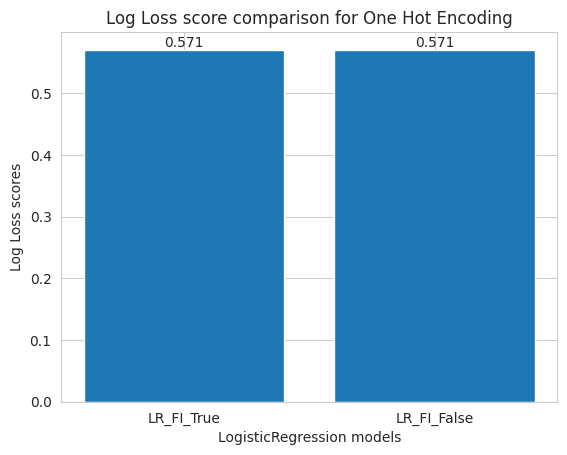

In [ ]:
from sklearn.metrics import log_loss

def LR_fit_intercept_evaluation_log_loss(X_train, y_train, X_test, y_test, encoding_method):
    LR_FI_True = LogisticRegression(penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=True, random_state=42,l1_ratio=0.5).fit(X_train, y_train)
    LR_FI_False = LogisticRegression (penalty='l2', C=1, solver='saga', max_iter=100,class_weight=None,fit_intercept=False, random_state=42,l1_ratio=0.5).fit(X_train, y_train)

    y_pred_LR_FI_True = LR_FI_True.predict_proba(X_test)
    y_pred_LR_FI_False = LR_FI_False.predict_proba(X_test)

    log_loss_scores = [
        log_loss(y_test,  y_pred_LR_FI_True),
        log_loss(y_test,  y_pred_LR_FI_False),
    ]

    print(f"Average Log_Loss score for {encoding_method}: {np.mean(log_loss_scores)}")


    models = ["LR_FI_True", "LR_FI_False"]
    bars = plt.bar(models, log_loss_scores)
    plt.xlabel("LogisticRegression models")
    plt.ylabel("Log Loss scores")
    plt.title(f"Log Loss score comparison for {encoding_method}")

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center')

    plt.show()


LR_fit_intercept_evaluation_log_loss(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test, "Ordinal Encoding")
LR_fit_intercept_evaluation_log_loss(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test, "Frequency Encoding")
LR_fit_intercept_evaluation_log_loss(X_train_target_encoding,y_train,X_test_target_encoding,y_test, "Target Encoding")
LR_fit_intercept_evaluation_log_loss(X_train_response_encoding,y_train,X_test_response_encoding,y_test, "Response Encoding")
LR_fit_intercept_evaluation_log_loss(X_train_ohe,y_train,X_test_ohe,y_test, "One Hot Encoding")

### 1.7.3.2 Finding the optimal parameter combination by the RandomizedSearchCV method

In [ ]:
def Logistic_Regression(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of Logistic Regression Model"""

  clf = LogisticRegression(random_state=0,C=1.0)
  parameters = {'C':[0.01, 0.1, 1, 10, 100, 500]}

  parameters = {'penalty':['l1','l2','elasticnet','none'],
                'C':[0.01, 0.1, 1, 10, 100, 500],
                'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
                'max_iter':[100,200,500,1000,2000],
                 }
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_penalty = model.best_params_['penalty']
  best_C = model.best_params_['C']
  best_solver = model.best_params_['solver']
  best_max_iter = model.best_params_['max_iter']

  clf = LogisticRegression(penalty=best_penalty,C=best_C,solver=best_solver,max_iter=best_max_iter,random_state=42,fit_intercept=True).fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return best_penalty,best_C,best_solver,best_max_iter,Train_loss,Train_AUC,Test_loss,Test_AUC

In [ ]:
# Ordinal Encoding
best_penalty_OrEnc,best_C_OrEnc,best_solver_OrEnc,best_max_iter_OrEnc, Train_loss_OrEnc, Train_AUC_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc = Logistic_Regression(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_penalty_FreEnc,best_C_FreEnc,best_solver_FreEnc,best_max_iter_FreEnc, Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = Logistic_Regression(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_penalty_TarEnc,best_C_TarEnc,best_solver_TarEnc,best_max_iter_TarEnc, Train_loss_TarEnc, Train_AUC_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc = Logistic_Regression(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_penalty_ResEnc,best_C_ResEnc,best_solver_ResEnc,best_max_iter_ResEnc, Train_loss_ResEnc, Train_AUC_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc = Logistic_Regression(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_penalty_ohe,best_C_ohe,best_solver_ohe,best_max_iter_ohe, Train_loss_ohe, Train_AUC_ohe, Test_loss_ohe, Test_AUC_ohe = Logistic_Regression(X_train_ohe,y_train,X_test_ohe,y_test)

In [ ]:
summary_table = PrettyTable(["Model","Encoding", "best_penalty", "best_C",  "best_solver", "best_max_iter","Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Logistic Regression","Ordinal Encoding",best_penalty_OrEnc,best_C_OrEnc,best_solver_OrEnc,best_max_iter_OrEnc,round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Logistic Regression","Frequency Encoding",best_penalty_FreEnc,best_C_FreEnc,best_solver_FreEnc,best_max_iter_FreEnc,round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Logistic Regression","Target Encoding",best_penalty_TarEnc,best_C_TarEnc,best_solver_TarEnc,best_max_iter_TarEnc,round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Logistic Regression","Response Encoding",best_penalty_ResEnc,best_C_ResEnc,best_solver_ResEnc,best_max_iter_ResEnc,round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Logistic Regression","One Hot Encoding",best_penalty_ohe,best_C_ohe,best_solver_ohe,best_max_iter_ohe,round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
Logistic_Regression_Result = table[0]
Logistic_Regression_Result

Model            Encoding best_penalty  best_C best_solver  \
0  Logistic Regression    Ordinal Encoding         none     0.1       lbfgs   
1  Logistic Regression  Frequency Encoding           l1    10.0   liblinear   
2  Logistic Regression     Target Encoding         none   500.0        saga   
3  Logistic Regression   Response Encoding           l2    10.0         sag   
4  Logistic Regression    One Hot Encoding           l2   100.0         sag   

   best_max_iter  Train_log_loss  Train_roc_auc_score  Test_log_loss  \
0           2000           0.580                0.755          0.586   
1            500           0.641                0.663          0.648   
2           2000           0.567                0.767          0.570   
3            200           0.567                0.767          0.564   
4           1000           0.557                0.779          0.571   

   Test_roc_auc_score  
0               0.747  
1               0.649  
2               0.765  
3               0.769  
4               0.763

## 1.7.4 K Nearest Neighbors

### 1.7.4.1 Different K, F1 score of different encoding methods

In [ ]:
def K_Neighbors_Classifier(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of K-Nearest Neighbors Model"""

  clf = KNeighborsClassifier()
  parameters = {'n_neighbors':[5,10,20, 30, 40, 50]}
  model = RandomizedSearchCV(clf, parameters, cv=5, scoring='roc_auc') #scoring='roc_auc' or 'neg_log_loss'
  model.fit(x_train, y_train)
  best_n_neighbors = model.best_params_['n_neighbors']

  clf = KNeighborsClassifier(n_neighbors=best_n_neighbors).fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  # Make predictions
  train_preds = clf.predict(x_train)
  test_preds = clf.predict(x_test)

  # Calculate recall and precision
  Train_recall = recall_score(y_train, train_preds)
  Train_precision = precision_score(y_train, train_preds)

  Test_recall = recall_score(y_test, test_preds)
  Test_precision = precision_score(y_test, test_preds)

  return best_n_neighbors, Train_loss, Train_AUC, Train_recall, Train_precision, Test_loss, Test_AUC, Test_recall, Test_precision

In [ ]:
def K_Neighbors_Classifier_evaluation(x_train, y_train, x_test, y_test, encoding_method):
    # Create a list of parameters to evaluate
    params = [5, 10, 20, 30, 40, 50]

    # Initialize a list to store F1 scores
    f1_scores = []

    # For each parameter, train a model and calculate F1 score
    for param in params:
        clf = KNeighborsClassifier(n_neighbors=param)
        clf.fit(x_train, y_train)

        # Make predictions
        test_preds = clf.predict(x_test)

        # Calculate F1 score and append to the list
        f1_score = classification_report(y_test, test_preds, output_dict=True)["weighted avg"]["f1-score"]
        f1_scores.append(f1_score)

    # Print the average F1 score
    print(f"Average F1 score for {encoding_method}: {round(np.mean(f1_scores),4)}")

    # Plot F1 score comparison
    models = [f"KNN_{param}" for param in params]
    bars = plt.bar(models, f1_scores)

    plt.xlabel("KNN models")
    plt.ylabel("F1 scores")
    plt.title(f"F1 score comparison for {encoding_method}")

    # Add values on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    plt.show()

In [ ]:
# Ordinal Encoding
best_n_OrEnc, Train_loss_OrEnc, Train_AUC_OrEnc, Train_recall_OrEnc, Train_precision_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc, Test_recall_OrEnc, Test_precision_OrEnc = K_Neighbors_Classifier(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
best_n_FreEnc, Train_loss_FreEnc, Train_AUC_FreEnc, Train_recall_FreEnc, Train_precision_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc, Test_recall_FreEnc, Test_precision_FreEnc = K_Neighbors_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
best_n_TarEnc, Train_loss_TarEnc, Train_AUC_TarEnc, Train_recall_TarEnc, Train_precision_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc, Test_recall_TarEnc, Test_precision_TarEnc = K_Neighbors_Classifier(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
best_n_ResEnc, Train_loss_ResEnc, Train_AUC_ResEnc, Train_recall_ResEnc, Train_precision_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc, Test_recall_ResEnc, Test_precision_ResEnc = K_Neighbors_Classifier(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
best_n_ohe, Train_loss_ohe, Train_AUC_ohe, Train_recall_ohe, Train_precision_ohe, Test_loss_ohe, Test_AUC_ohe, Test_recall_ohe, Test_precision_ohe = K_Neighbors_Classifier(X_train_ohe,y_train,X_test_ohe,y_test)

In [ ]:
summary_table = PrettyTable(["Model","Encoding_method", "Hyperparameter1", "Hyperparameter2","Train_log_loss", "Train_roc_auc_score", "Train_recall_score","Train_precision_score", "Test_log_loss", "Test_roc_auc_score","Test_recall_score","Test_precision_score"]) #heading

summary_table.add_row(["K-Nearest Neighbor","Ordinal Encoding",best_n_OrEnc,'',round(Train_loss_OrEnc,4),round(Train_AUC_OrEnc,4),round(Train_recall_OrEnc,4),round(Train_precision_OrEnc,4),round(Test_loss_OrEnc,4),round(Test_AUC_OrEnc,4),round(Test_recall_OrEnc,4),round(Test_precision_OrEnc,4)])
summary_table.add_row(["K-Nearest Neighbor","Frequency Encoding",best_n_FreEnc,'',round(Train_loss_FreEnc,4),round(Train_AUC_FreEnc,4),round(Train_recall_FreEnc,4),round(Train_precision_FreEnc,4),round(Test_loss_FreEnc,4),round(Test_AUC_FreEnc,4),round(Test_recall_FreEnc,4),round(Test_precision_FreEnc,4)])
summary_table.add_row(["K-Nearest Neighbor","Target Encoding",best_n_TarEnc,'',round(Train_loss_TarEnc,4),round(Train_AUC_TarEnc,4),round(Train_recall_TarEnc,4),round(Train_precision_TarEnc,4),round(Test_loss_TarEnc,4),round(Test_AUC_TarEnc,4),round(Test_recall_TarEnc,4),round(Test_precision_TarEnc,4)])
summary_table.add_row(["K-Nearest Neighbor","Response Encoding",best_n_ResEnc,'',round(Train_loss_ResEnc,4),round(Train_AUC_ResEnc,4),round(Train_recall_ResEnc,4),round(Train_precision_ResEnc,4),round(Test_loss_ResEnc,4),round(Test_AUC_ResEnc,4),round(Test_recall_ResEnc,4),round(Test_precision_ResEnc,4)])
summary_table.add_row(["K-Nearest Neighbor","One Hot Encoding",best_n_ohe,'',round(Train_loss_ohe,4),round(Train_AUC_ohe,4),round(Train_recall_ohe,4),round(Train_precision_ohe,4),round(Test_loss_ohe,4),round(Test_AUC_ohe,4),round(Test_recall_ohe,4),round(Test_precision_ohe,4)])

table = pd.read_html(summary_table.get_html_string())
K_Nearest_Neighbor_Result = table[0]
K_Nearest_Neighbor_Result

Model     Encoding_method  Hyperparameter1  Hyperparameter2  \
0  K-Nearest Neighbor    Ordinal Encoding               30              NaN   
1  K-Nearest Neighbor  Frequency Encoding               20              NaN   
2  K-Nearest Neighbor     Target Encoding               40              NaN   
3  K-Nearest Neighbor   Response Encoding               30              NaN   
4  K-Nearest Neighbor    One Hot Encoding               50              NaN   

   Train_log_loss  Train_roc_auc_score  Train_recall_score  \
0          0.5430               0.8071              0.8256   
1          0.5834               0.7572              0.7660   
2          0.5349               0.7996              0.8216   
3          0.5369               0.7969              0.8031   
4          0.5496               0.8168              0.8512   

   Train_precision_score  Test_log_loss  Test_roc_auc_score  \
0                 0.7399         0.5731              0.7663   
1                 0.7191         0.6349              0.6720   
2                 0.7350         0.5735              0.7625   
3                 0.7344         0.5842              0.7530   
4                 0.7430         0.5688              0.7876   

   Test_recall_score  Test_precision_score  
0             0.8197                0.7129  
1             0.7080                0.6630  
2             0.8024                0.7245  
3             0.7781                0.7211  
4             0.8419                0.7243

Average F1 score for Ordinal Encoding: 0.7032


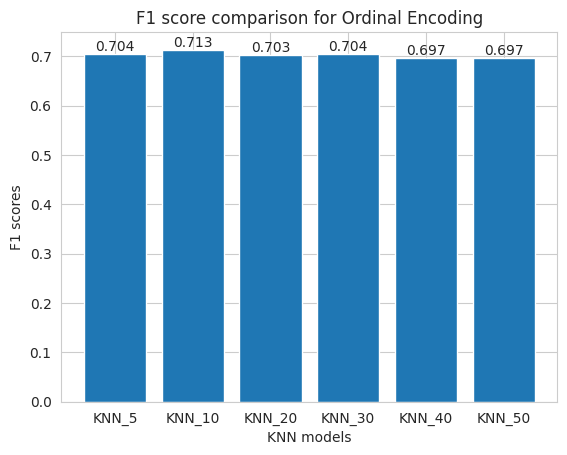

Average F1 score for Frequency Encoding: 0.6272


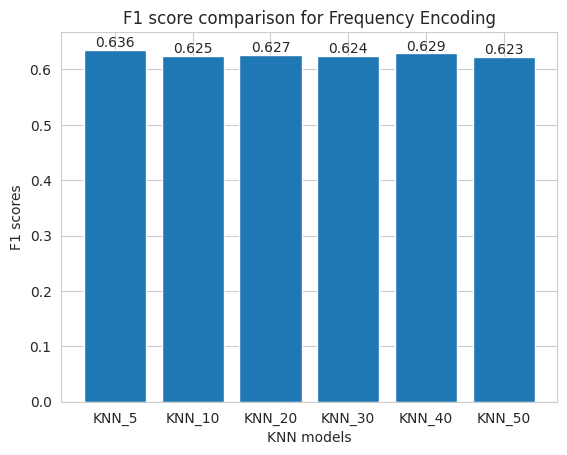

Average F1 score for Target Encoding: 0.6969


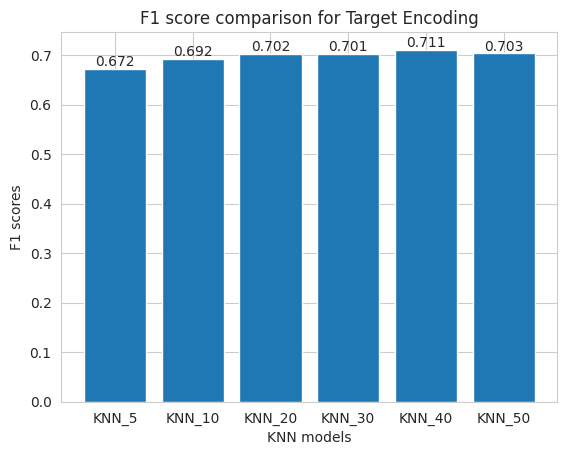

Average F1 score for Response Encoding: 0.6941


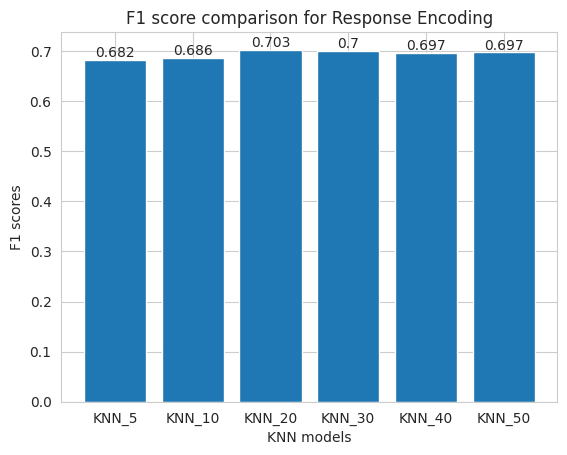

Average F1 score for One Hot Encoding: 0.7118


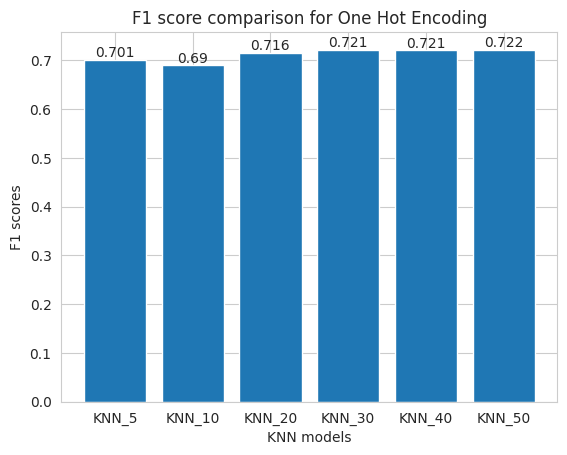

In [ ]:
K_Neighbors_Classifier_evaluation(X_train_Ordinal_encoding, y_train, X_test_Ordinal_encoding, y_test, "Ordinal Encoding")
K_Neighbors_Classifier_evaluation(X_train_frequency_encoding, y_train, X_test_frequency_encoding, y_test, "Frequency Encoding")
K_Neighbors_Classifier_evaluation(X_train_target_encoding, y_train, X_test_target_encoding, y_test, "Target Encoding")
K_Neighbors_Classifier_evaluation(X_train_response_encoding, y_train, X_test_response_encoding, y_test, "Response Encoding")
K_Neighbors_Classifier_evaluation(X_train_ohe, y_train, X_test_ohe, y_test, "One Hot Encoding")

### 1.7.4.2 Different K, log loss score of different encoding methodds

In [ ]:
def K_Neighbors_Classifier_log_loss_evaluation(X_train, y_train, X_test, y_test, encoding_method):
    # Create a list of parameters to evaluate
    params = [5, 10, 20, 30, 40, 50]

    # Initialize a list to store log losses
    log_losses = []

    # For each parameter, train a model and calculate log loss
    for param in params:
        model = KNeighborsClassifier(n_neighbors=param)
        model.fit(X_train, y_train)

        # Get the probabilities of each class
        y_prob = model.predict_proba(X_test)

        # Calculate log loss and append it to the list
        log_loss_score = log_loss(y_test, y_prob)
        log_losses.append(log_loss_score)

    # Print the average log loss
    print(f"Average log loss for {encoding_method}: {round(np.mean(log_losses),4)}")

    # Plot log loss comparison
    models = [f"KNN_{param}" for param in params]
    bars = plt.bar(models, log_losses)

    plt.xlabel("KNN models")
    plt.ylabel("Log Loss scores")
    plt.title(f"Log Loss score comparison for {encoding_method}")

    # Add values on each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 3), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

    plt.show()

Average log loss for Ordinal Encoding: 0.7522


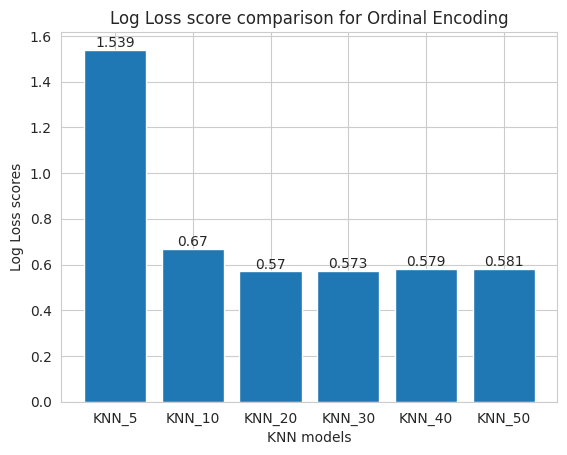

Average log loss for Frequency Encoding: 0.8101


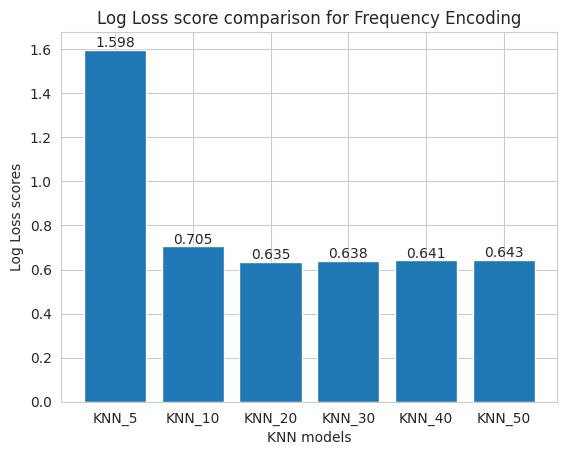

Average log loss for Target Encoding: 0.8862


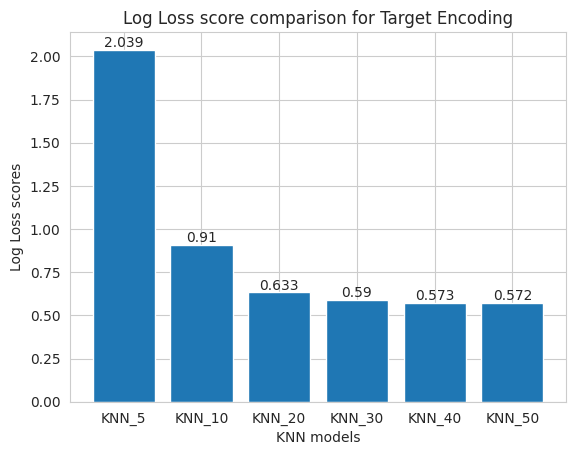

Average log loss for Response Encoding: 0.9112


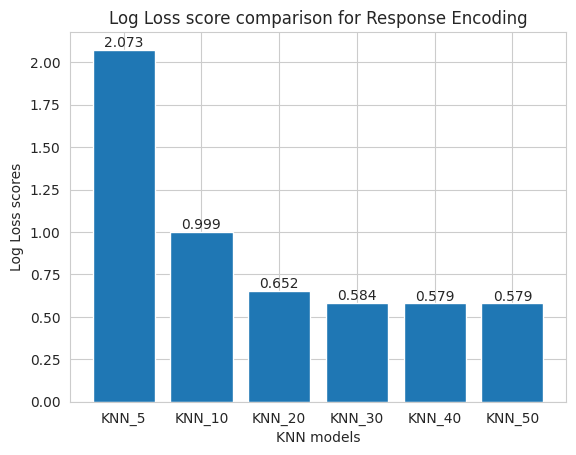

Average log loss for One Hot Encoding: 0.7021


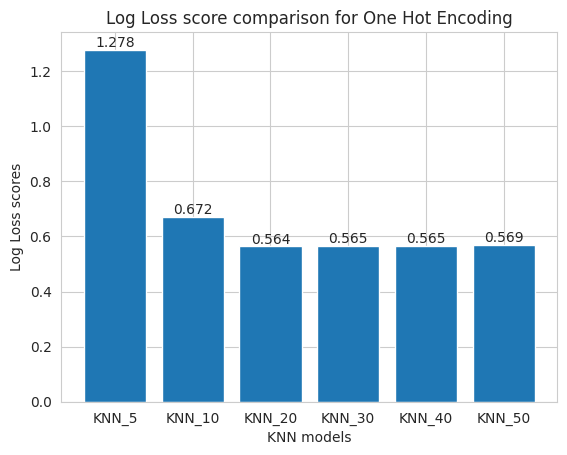

In [ ]:
K_Neighbors_Classifier_log_loss_evaluation(X_train_Ordinal_encoding, y_train, X_test_Ordinal_encoding, y_test, "Ordinal Encoding")
K_Neighbors_Classifier_log_loss_evaluation(X_train_frequency_encoding, y_train, X_test_frequency_encoding, y_test, "Frequency Encoding")
K_Neighbors_Classifier_log_loss_evaluation(X_train_target_encoding, y_train, X_test_target_encoding, y_test, "Target Encoding")
K_Neighbors_Classifier_log_loss_evaluation(X_train_response_encoding, y_train, X_test_response_encoding, y_test, "Response Encoding")
K_Neighbors_Classifier_log_loss_evaluation(X_train_ohe, y_train, X_test_ohe, y_test, "One Hot Encoding")

### 1.7.4.3 leaf size

In [ ]:
from sklearn.metrics import make_scorer
# Define the parameter values that should be searched
# leaf_size_list = list(range(1, 50))
leaf_size_list = list(range(1, 51, 10))
# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(leaf_size=leaf_size_list)

# Instantiate the grid
knn = KNeighborsClassifier()

# Adjust the cv parameter to 5 to perform 5-fold cross-validation,
# and set verbose to 3 to output updates for every parameter search
grid = GridSearchCV(knn, param_grid, cv=5, scoring=make_scorer(accuracy_score), verbose=3)

# Fit the grid with data
grid.fit(X_train_ohe, y_train)

# View the complete results
grid_results = grid.cv_results_

# Print the details
print("Best parameters: ", grid.best_params_)
print("Best cross-validation score: ", grid.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END .......................leaf_size=1;, score=0.699 total time=  12.7s
[CV 2/5] END .......................leaf_size=1;, score=0.708 total time=   9.9s
[CV 3/5] END .......................leaf_size=1;, score=0.698 total time=  12.9s
[CV 4/5] END .......................leaf_size=1;, score=0.701 total time=  11.3s
[CV 5/5] END .......................leaf_size=1;, score=0.697 total time=  11.2s
[CV 1/5] END ......................leaf_size=11;, score=0.699 total time=  12.9s
[CV 2/5] END ......................leaf_size=11;, score=0.708 total time=   9.8s
[CV 3/5] END ......................leaf_size=11;, score=0.698 total time=  12.8s
[CV 4/5] END ......................leaf_size=11;, score=0.701 total time=  11.7s
[CV 5/5] END ......................leaf_size=11;, score=0.697 total time=  10.9s
[CV 1/5] END ......................leaf_size=21;, score=0.699 total time=  12.9s
[CV 2/5] END ......................leaf_size=21;,

## 1.8 Baseline and Model Comparision

In [ ]:
# Load the dataset
df = pd.read_csv('in-vehicle-coupon-recommendation.csv')
df['temperature']=df['temperature'].astype('category')
df.drop('car', inplace=True, axis=1)

for col in df.columns[df.isna().any()]:
    df = df.fillna({col: df[col].value_counts().idxmax()})
df_obj = df.select_dtypes(include=['object']).copy()

for col in df_obj.columns:
    df[col]=df[col].astype('category')

df.drop(columns=['toCoupon_GEQ5min'], inplace=True)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

enc = OneHotEncoder(dtype='int64')

df_cat = df.select_dtypes(include=['category']).copy()
df_int = df.select_dtypes(include=['int64']).copy()

df_enc = pd.DataFrame()
for col in df_cat.columns:
    enc_results = enc.fit_transform(df_cat[[col]])
    df0 = pd.DataFrame(enc_results.toarray(), columns=enc.categories_)
    df_enc = pd.concat([df_enc,df0], axis=1)

df_final = pd.concat([df_enc, df_int], axis=1)

#split data into training and test set
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_final, test_size=.2, random_state=42, shuffle=True, stratify=df_final['Y'])

#Creating the Dependent Feature Matrix
X_train_baseline = train_set.iloc[:, :-1].values
X_test_baseline = test_set.iloc[:, :-1].values

#Creating the Independent Vector
y_train_baseline = train_set.iloc[:, -1].values
y_test_baseline = test_set.iloc[:, -1].values

In [ ]:
print(X_train_baseline.shape)
print(X_test_baseline.shape)
print(y_test_baseline)

(10147, 110)
(2537, 110)
[0 0 1 ... 1 1 1]


In [ ]:
print(X_train_ohe.shape)
print(X_test_ohe.shape)
print(y_test.shape)

(10147, 93)
(2537, 93)
(2537,)


SVM

In [ ]:
SVM_rbf_baseline = SVC(C=1,kernel="rbf", random_state=None, probability=True, gamma=0.1,class_weight='balanced').fit(X_train_baseline, y_train_baseline)

In [ ]:
SVM_rbf_oe = SVC(C=10,kernel='rbf',class_weight='balanced',probability=True,gamma=0.1).fit(X_train_Ordinal_encoding,y_train)
SVM_rbf_fe = SVC(C=100,kernel='rbf',class_weight='balanced',probability=True,gamma=0.1).fit(X_train_frequency_encoding,y_train)
SVM_rbf_te = SVC(C=10,kernel='rbf',class_weight='balanced',probability=True,gamma=0.1).fit(X_train_target_encoding,y_train)
SVM_rbf_re = SVC(C=500,kernel='rbf',class_weight='balanced',probability=True,gamma=0.1).fit(X_train_response_encoding,y_train)
SVM_rbf_ohe = SVC(C=1.0,kernel='rbf',class_weight='balanced',probability=True,gamma=0.1).fit(X_train_ohe,y_train)

Descsion Tree

In [ ]:
dtc_baseline=DecisionTreeClassifier().fit(X_train_baseline, y_train_baseline)#baseline

In [ ]:
#the optimal parameter combine in each encoding methods
dtc_oe = DecisionTreeClassifier(criterion='gini',
                                 splitter= 'best',
                                 class_weight='balanced',
                                 max_leaf_nodes=10,
                                 max_depth=10,
                                 min_samples_split=10,

                                 random_state=42).fit(X_train_Ordinal_encoding,y_train)
dtc_fe = DecisionTreeClassifier(criterion='gini',
                                 splitter= 'best',
                                 class_weight='balanced',
                                 max_leaf_nodes=100,
                                 max_depth=10,
                                 min_samples_split=10,
                                 random_state=42,
                               ).fit(X_train_frequency_encoding,y_train)
dtc_te = DecisionTreeClassifier(criterion='gini',
                                 splitter= 'best',
                                 class_weight='balanced',
                                 max_leaf_nodes=100,
                                 min_samples_split=10,
                                 max_depth=10,
                                 random_state=42).fit(X_train_target_encoding,y_train)
dtc_re = DecisionTreeClassifier(criterion='gini',
                                 splitter= 'best',
                                 class_weight='balanced',
                                 max_leaf_nodes=100,
                                 min_samples_split=10,
                                 max_depth=10,
                                 random_state=42).fit(X_train_response_encoding,y_train)
dtc_ohe = DecisionTreeClassifier(criterion='gini',
                                 splitter= 'best',
                                 class_weight='balanced',
                                 max_leaf_nodes=500,
                                 max_depth=10,
                                 min_samples_split=2,
                                 random_state=42).fit(X_train_ohe,y_train)

Logistic Regression

In [ ]:
LogisticRegression_baseline = LogisticRegression(penalty='l2', C=0.1, solver='newton-cg', max_iter=100).fit(X_train_baseline, y_train_baseline)
LogisticRegression_oe = LogisticRegression(penalty='l2', C=1, solver='sag', max_iter=500).fit(X_train_Ordinal_encoding, y_train)
LogisticRegression_fe = LogisticRegression(penalty='l1', C=500.0, solver='liblinear', max_iter=1000).fit(X_train_frequency_encoding, y_train)
LogisticRegression_te = LogisticRegression(penalty='none', C=10.0, solver='sag', max_iter=500).fit(X_train_target_encoding, y_train)
LogisticRegression_re = LogisticRegression(penalty='none', C=1, solver='saga', max_iter=2000).fit(X_train_response_encoding, y_train)
LogisticRegression_ohe = LogisticRegression(penalty='l2', C=500, solver='newton-cg', max_iter=2000).fit(X_train_ohe, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100, 500],
    'solver': ['newton-cg','lbfgs','liblinear','sag','saga'],
    'max_iter': [100,200,500,1000,2000]
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_baseline, y_train_baseline)

print("Grid Search - Best parameters: ", grid_search.best_params_)
print("Grid Search - Best score: ", grid_search.best_score_)


best_penalty = grid_search.best_params_['penalty']
best_C = grid_search.best_params_['C']
best_solver = grid_search.best_params_['solver']
best_max_iter = grid_search.best_params_['max_iter']

clf = LogisticRegression(penalty=best_penalty,C=best_C,solver=best_solver,max_iter=best_max_iter,random_state=42,fit_intercept=True).fit(X_train_baseline, y_train_baseline)

Train_loss = log_loss(y_train_baseline,clf.predict_proba(X_train_baseline))
Train_AUC = roc_auc_score(y_train_baseline,clf.predict_proba(X_train_baseline)[:,1])
Test_loss = log_loss(y_test_baseline,clf.predict_proba(X_test_baseline))
Test_AUC = roc_auc_score(y_test_baseline,clf.predict_proba(X_test_baseline)[:,1])

summary_table = PrettyTable(["Model","Encoding", "best_penalty", "best_C",  "best_solver", "best_max_iter","Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Logistic Regression","Baseline",best_penalty,best_C,best_solver,best_max_iter,round(Train_loss,3),round(Train_AUC,3),round(Test_loss,3),round(Test_AUC,3)])

table = pd.read_html(summary_table.get_html_string())
Logistic_Regression_Result = table[0]
Logistic_Regression_Result

Grid Search - Best parameters:  {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Grid Search - Best score:  0.6845368268481403


Model  Encoding best_penalty  best_C best_solver  \
0  Logistic Regression  Baseline           l2     0.1   liblinear   

   best_max_iter  Train_log_loss  Train_roc_auc_score  Test_log_loss  \
0            100           0.586                0.749          0.596   

   Test_roc_auc_score  
0               0.734

### 1.8.1.1 Model Comparision(Self.svm)

In [ ]:
!pip install more-itertools

In [ ]:
y_pred_baseline = SVM_rbf_baseline.predict(X_test_baseline)
y_pred_oe = SVM_rbf_oe.predict(X_test_Ordinal_encoding)
y_pred_fe = SVM_rbf_fe.predict(X_test_frequency_encoding)
y_pred_te = SVM_rbf_te.predict(X_test_target_encoding)
y_pred_re = SVM_rbf_re.predict(X_test_response_encoding)
y_pred_ohe = SVM_rbf_ohe.predict(X_test_ohe)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

In [ ]:
report_baseline = classification_report(y_test, y_pred_baseline)
report_oe = classification_report(y_test, y_pred_oe)
report_fe = classification_report(y_test, y_pred_fe)
report_te = classification_report(y_test, y_pred_te)
report_re = classification_report(y_test, y_pred_re)
report_ohe = classification_report(y_test, y_pred_ohe)

In [ ]:
print(report_baseline)
print(report_oe)
print(report_fe)
print(report_te)
print(report_re)
print(report_ohe)

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1095
           1       0.78      0.79      0.79      1442

    accuracy                           0.76      2537
   macro avg       0.75      0.75      0.75      2537
weighted avg       0.76      0.76      0.76      2537

              precision    recall  f1-score   support

           0       0.67      0.67      0.67      1095
           1       0.75      0.75      0.75      1442

    accuracy                           0.71      2537
   macro avg       0.71      0.71      0.71      2537
weighted avg       0.71      0.71      0.71      2537

              precision    recall  f1-score   support

           0       0.58      0.62      0.60      1095
           1       0.69      0.65      0.67      1442

    accuracy                           0.64      2537
   macro avg       0.64      0.64      0.64      2537
weighted avg       0.64      0.64      0.64      2537

              preci

In [ ]:
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
accuracy_oe = accuracy_score(y_test, y_pred_oe)
accuracy_fe = accuracy_score(y_test, y_pred_fe)
accuracy_te = accuracy_score(y_test, y_pred_te)
accuracy_re = accuracy_score(y_test, y_pred_re)
accuracy_ohe = accuracy_score(y_test, y_pred_ohe)

f1_baseline = f1_score(y_test, y_pred_baseline, average='weighted')
f1_oe = f1_score(y_test, y_pred_oe, average='weighted')
f1_fe = f1_score(y_test, y_pred_fe, average='weighted')
f1_te = f1_score(y_test, y_pred_te, average='weighted')
f1_re = f1_score(y_test, y_pred_re, average='weighted')
f1_ohe = f1_score(y_test, y_pred_ohe, average='weighted')

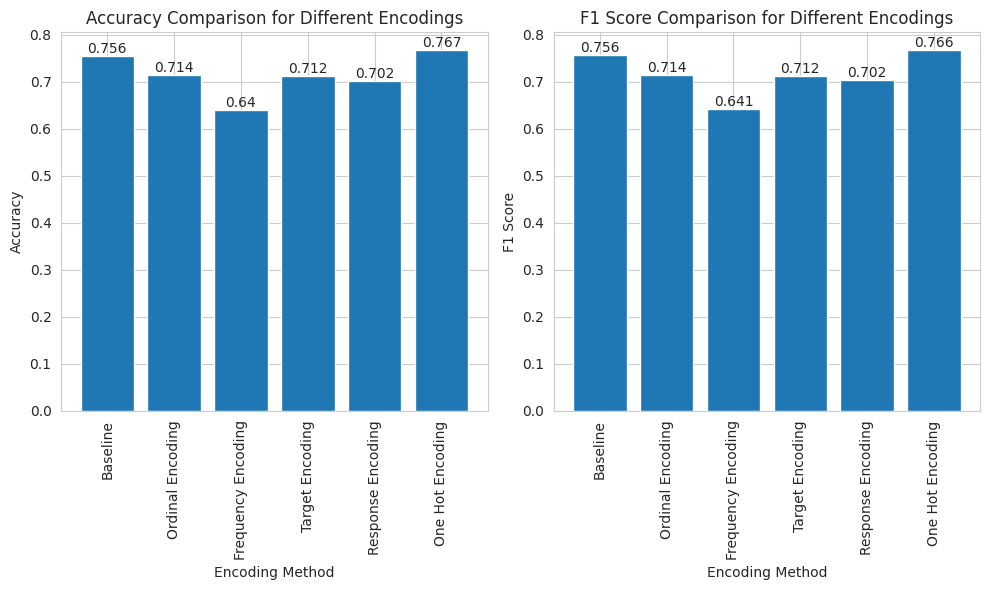

In [ ]:
labels = ['Baseline', 'Ordinal Encoding', 'Frequency Encoding', 'Target Encoding', 'Response Encoding', 'One Hot Encoding']
accuracy_scores = [accuracy_baseline, accuracy_oe, accuracy_fe, accuracy_te, accuracy_re, accuracy_ohe]
f1_scores = [f1_baseline, f1_oe, f1_fe, f1_te, f1_re, f1_ohe]

x = range(len(labels))

plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
bars = plt.bar(x, accuracy_scores)
plt.xticks(x, labels, rotation='vertical')
plt.xlabel('Encoding Method')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for Different Encodings')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

plt.subplot(1, 2, 2)
bars = plt.bar(x, f1_scores)
plt.xticks(x, labels, rotation='vertical')
plt.xlabel('Encoding Method')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison for Different Encodings')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 3), ha='center', va='bottom')

plt.tight_layout()
plt.show()

#### 1.8.1.1 draw confusion matrix

In [ ]:
# Function to plot a confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(confusion_matrix, class_names, figsize=(10, 7), fontsize=14):
    # Create a DataFrame from the confusion matrix
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

    # Create a figure and axis with the specified figsize
    fig, ax = plt.subplots(figsize=figsize)

    try:
        # Plot the confusion matrix as a heatmap
        sns.heatmap(df_cm, annot=False, fmt="d", ax=ax, cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    # Set the tick marks and labels for x and y axes
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right', fontsize=fontsize)
    plt.yticks(tick_marks, class_names, rotation=0, ha='right', fontsize=fontsize)

    # Determine the threshold for coloring the text in cells
    thresh = confusion_matrix.max() / 2.

    # Add text labels to the cells of the confusion matrix
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j+0.5, i+0.5, confusion_matrix[i, j],
                 horizontalalignment="center",
                 color="red" if confusion_matrix[i, j] > thresh else "black", fontsize=10)

    # Set the labels for x and y axes
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Baseline Model Confusion Matrix:


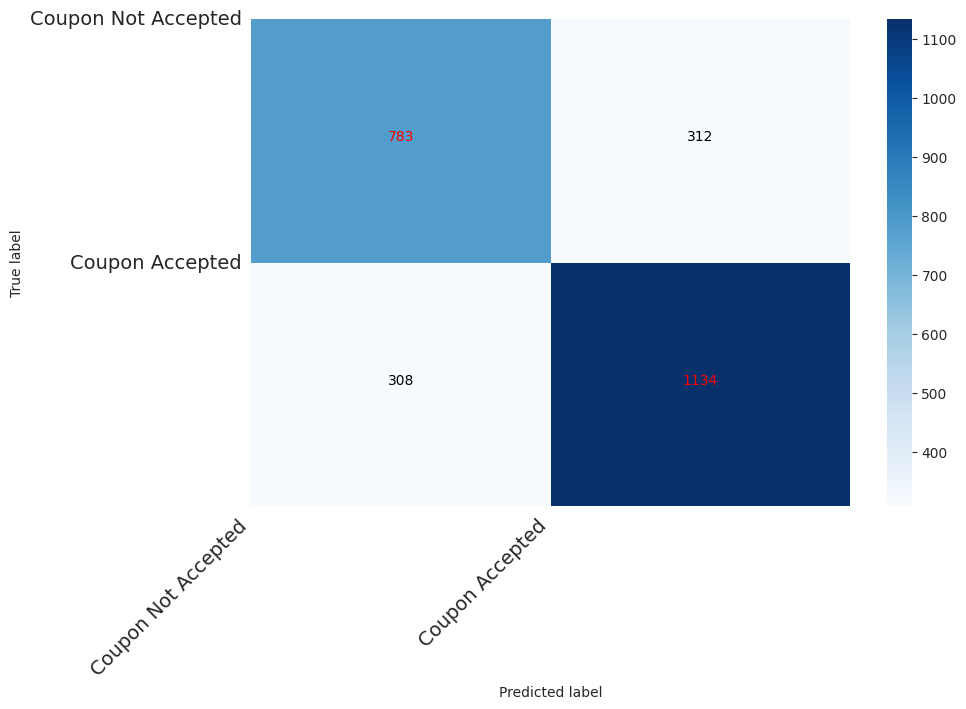

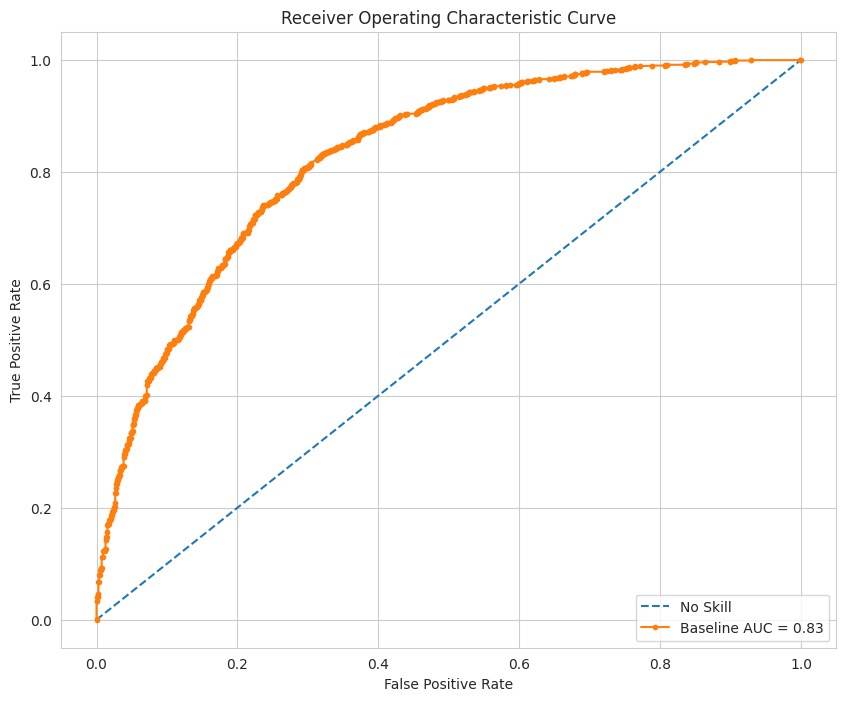

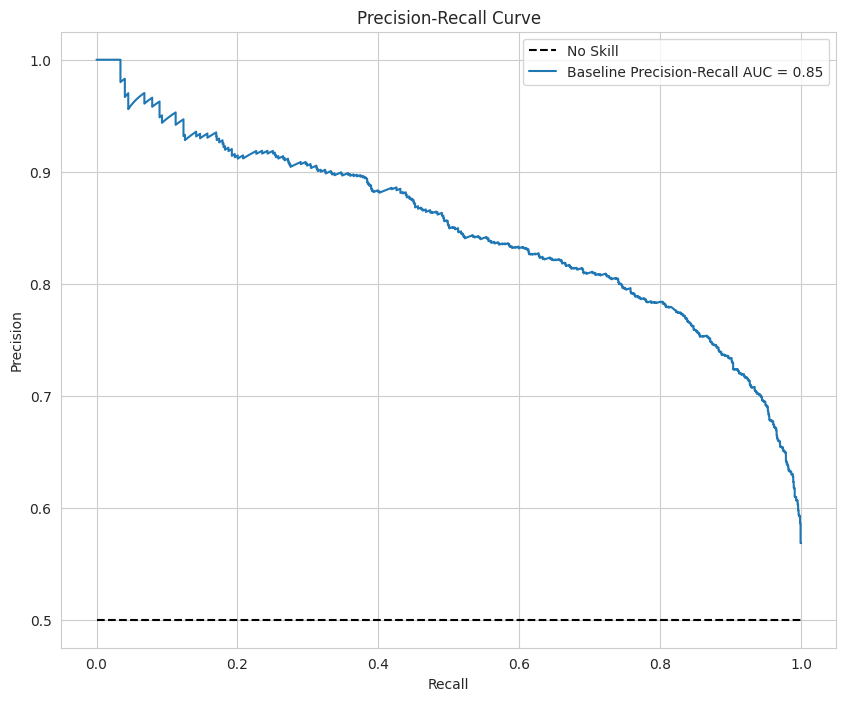

OE Model Confusion Matrix:


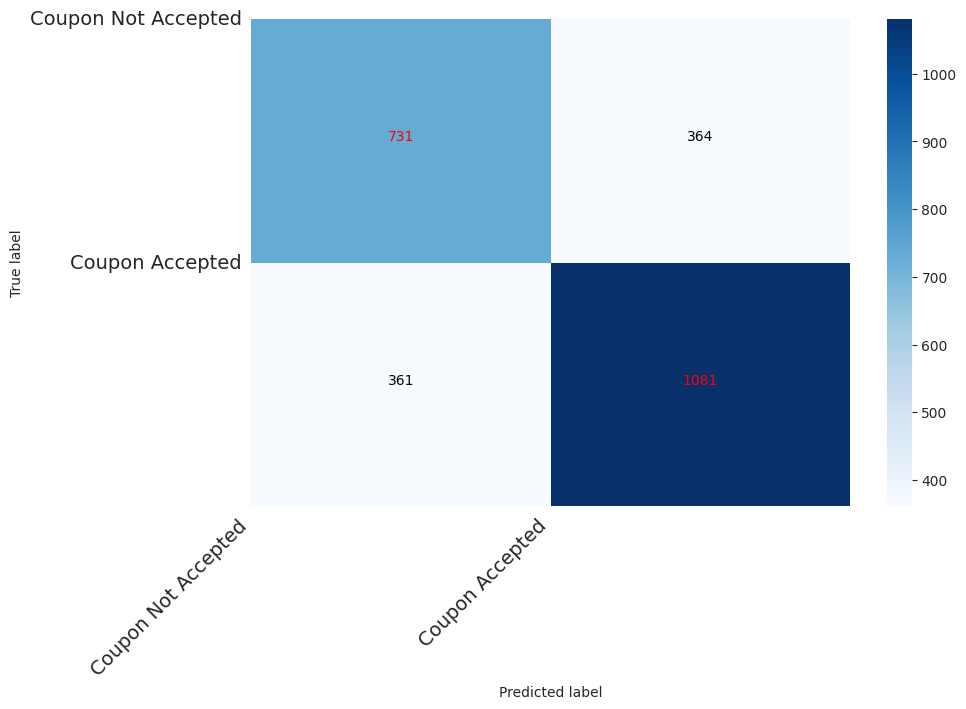

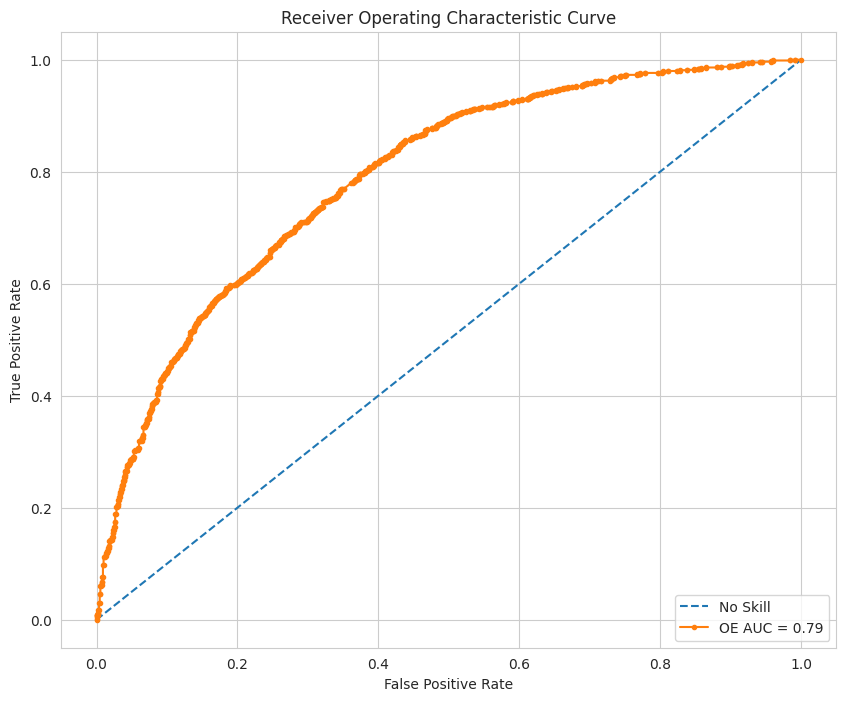

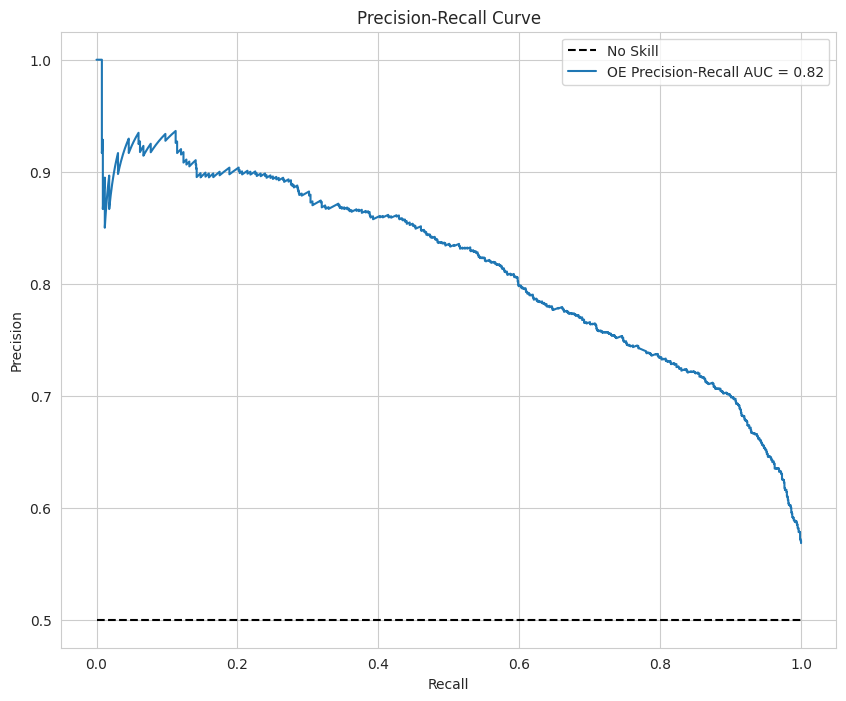

FE Model Confusion Matrix:


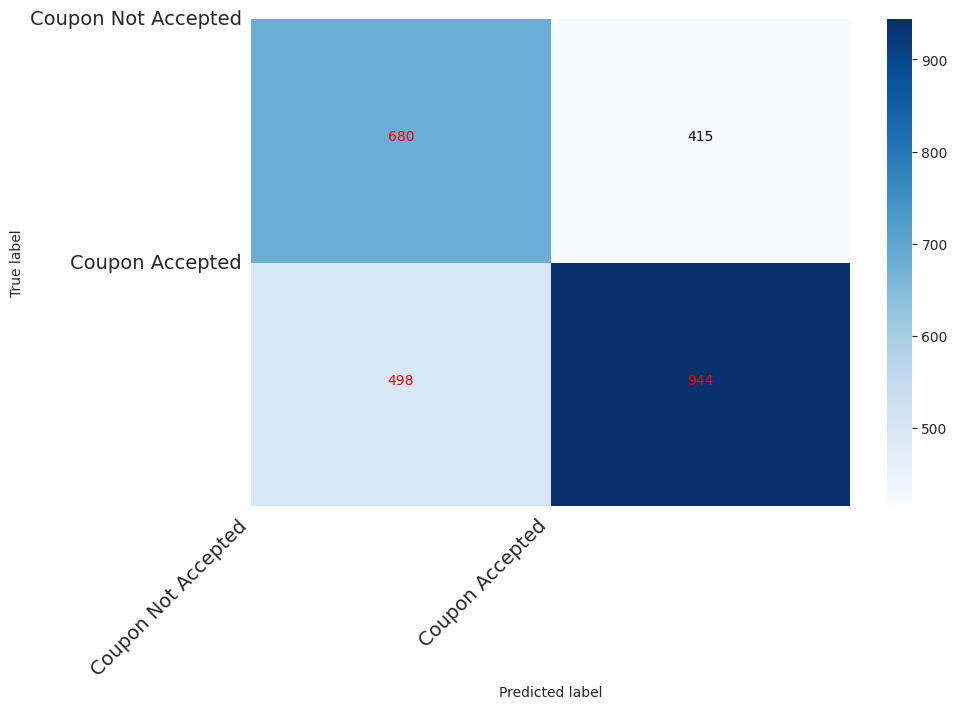

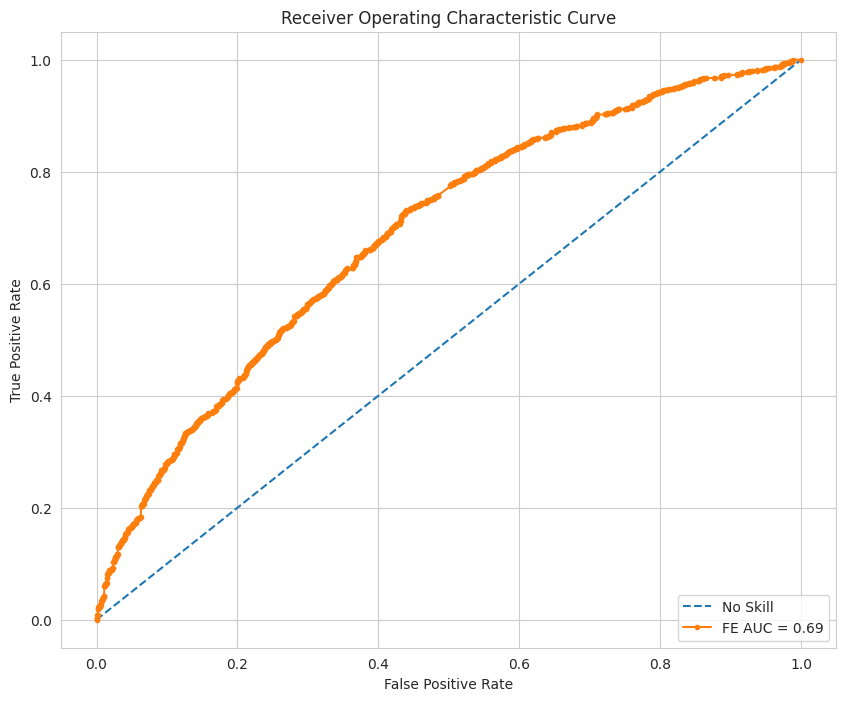

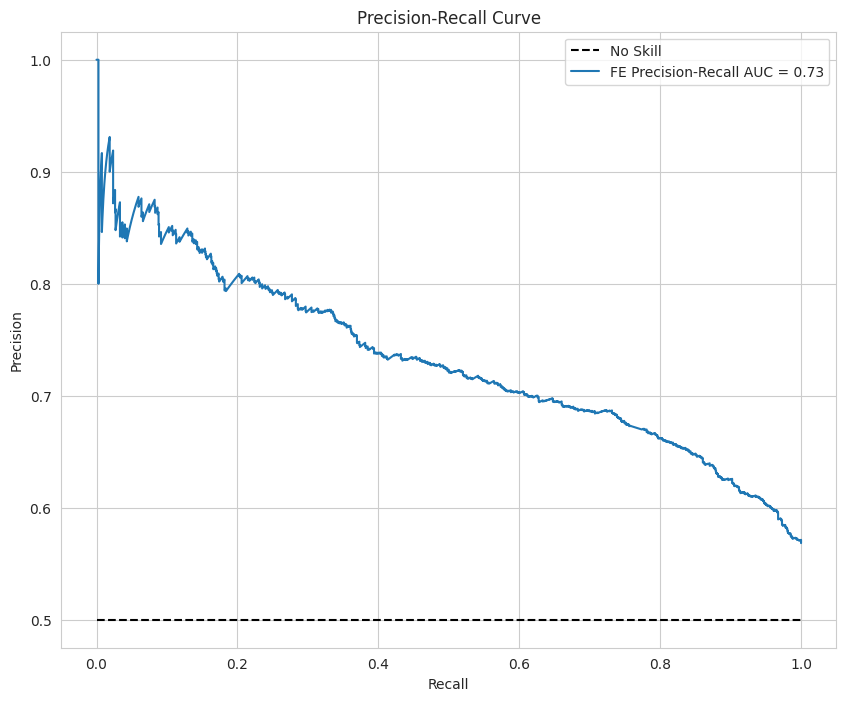

TE Model Confusion Matrix:


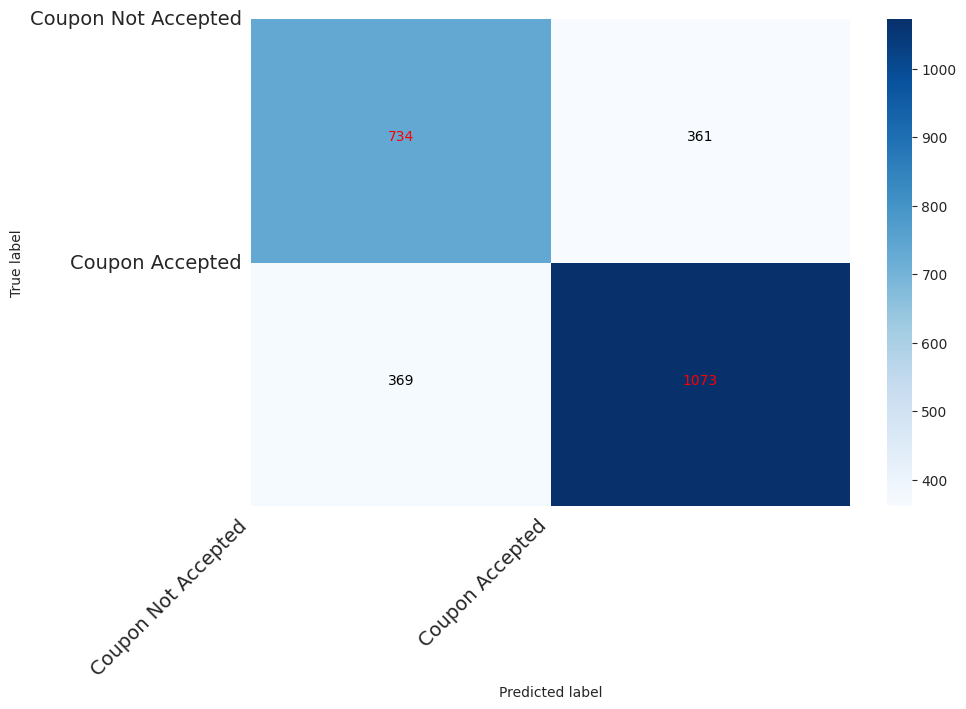

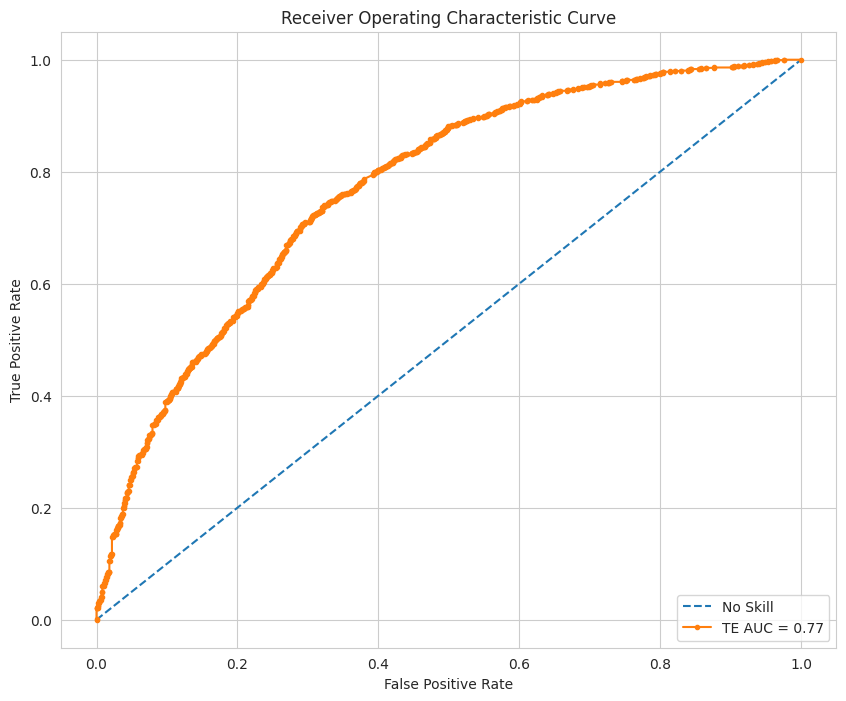

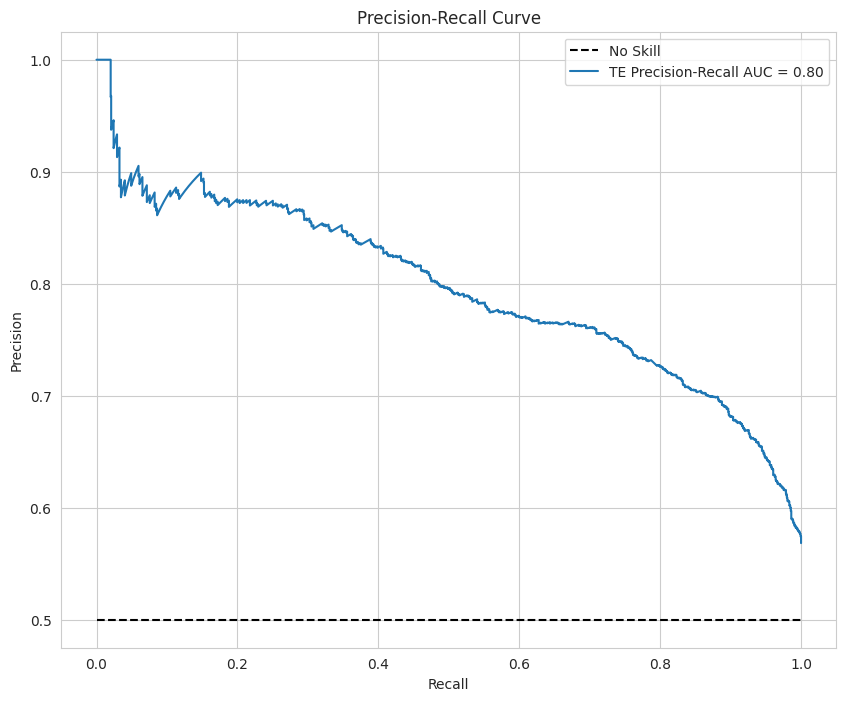

RE Model Confusion Matrix:


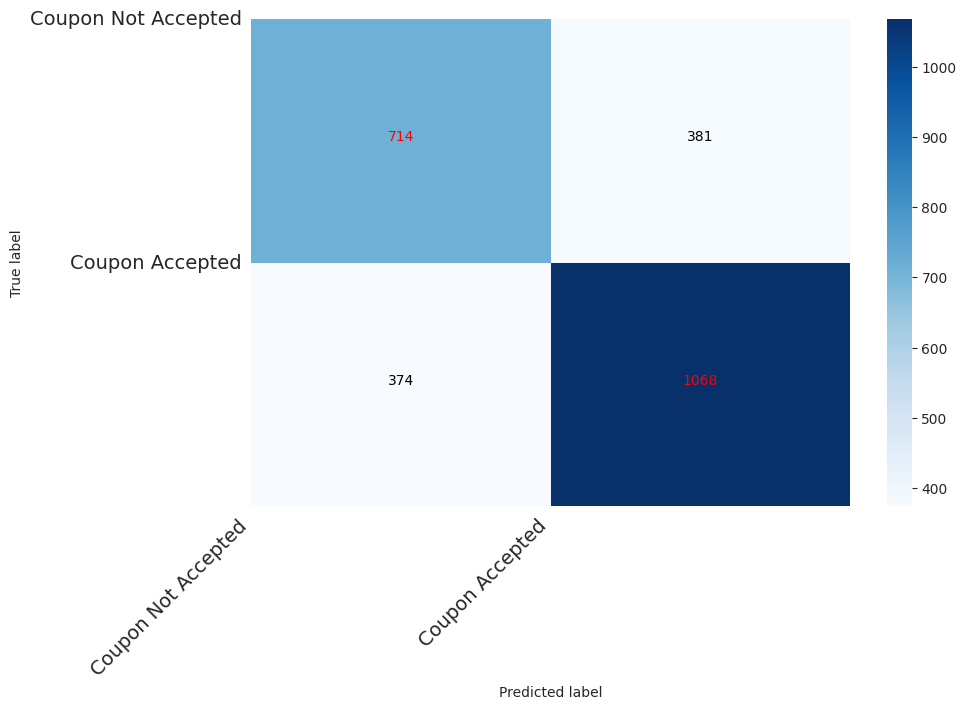

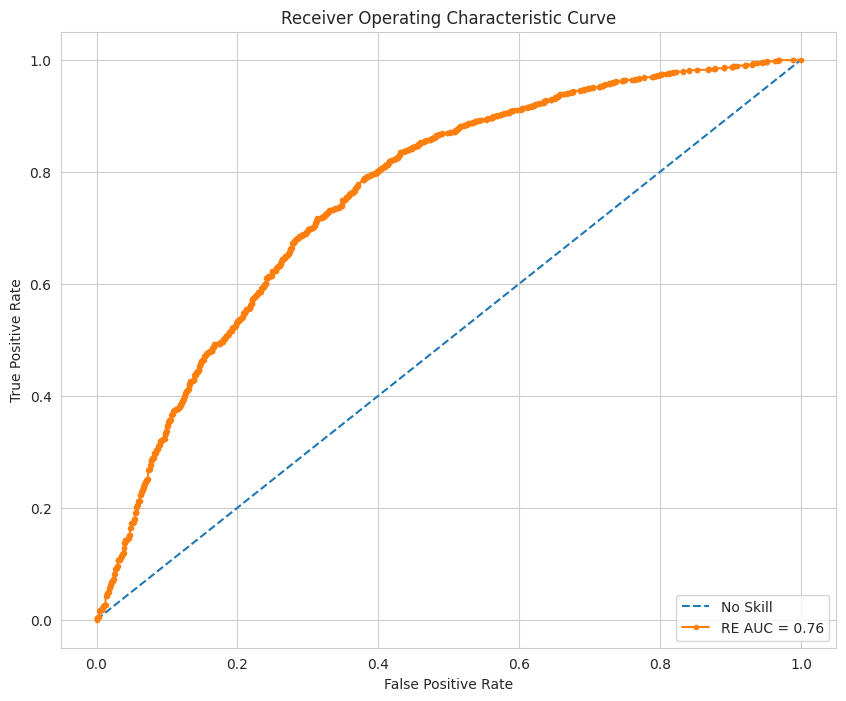

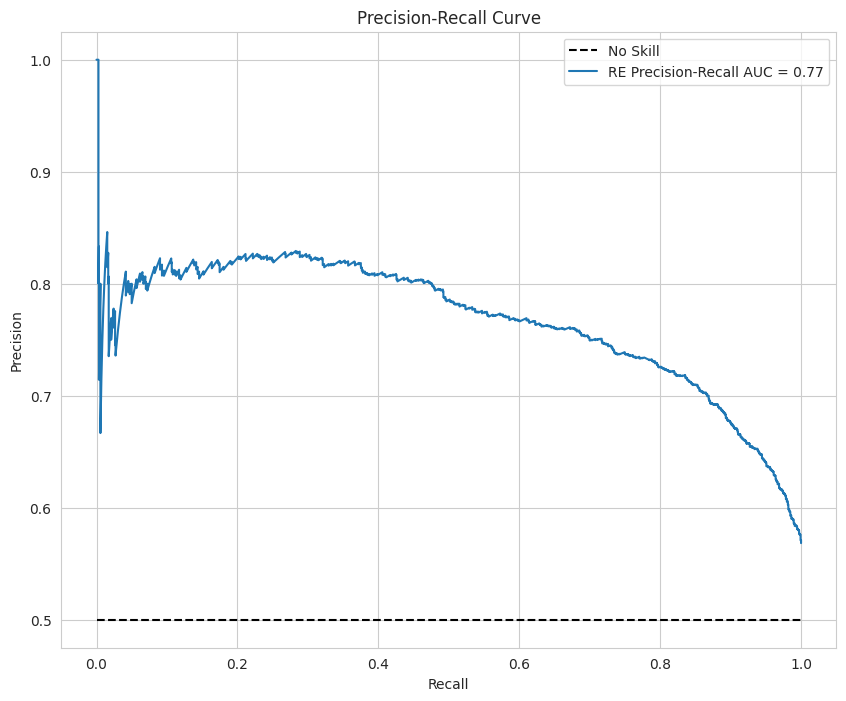

OHE Model Confusion Matrix:


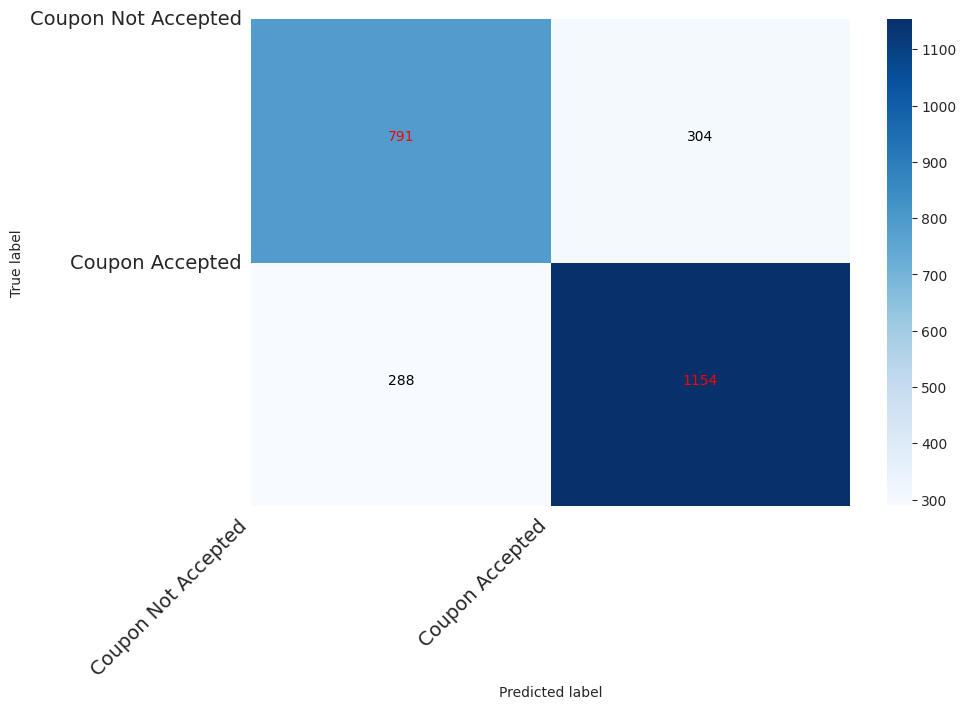

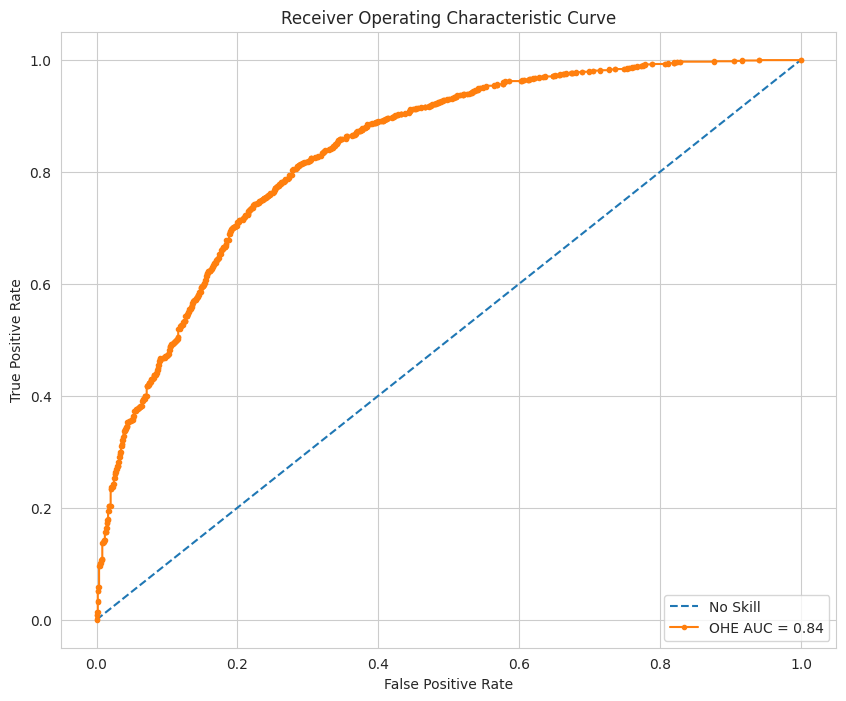

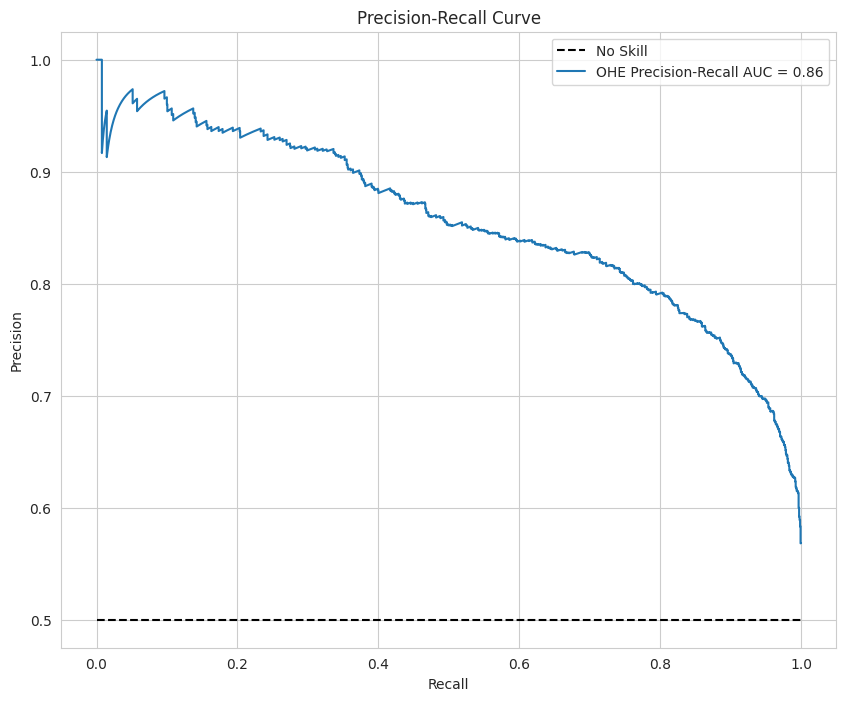

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
import itertools
models = [SVM_rbf_baseline, SVM_rbf_oe, SVM_rbf_fe, SVM_rbf_te, SVM_rbf_re, SVM_rbf_ohe]
model_names = ['Baseline', 'OE', 'FE', 'TE', 'RE', 'OHE']
X_tests = [X_test_baseline, X_test_Ordinal_encoding, X_test_frequency_encoding, X_test_target_encoding, X_test_response_encoding, X_test_ohe]

for model, name, X_test in zip(models, model_names, X_tests):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # Print Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    # pd.crosstab(y_test, y_pred, rownames = ['Truth'], colnames =['Predicted'], margins = True)
    print(f"{name} Model Confusion Matrix:")
    plot_confusion_matrix(cm, ["Coupon Not Accepted", "Coupon Accepted"])
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.figure(figsize=(10,8))
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=f'{name} AUC = {roc_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc=4)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    prc_auc = auc(recall, precision)
    plt.figure(figsize=(10,8))
    plt.plot([0, 1], [0.5, 0.5],'k--', label='No Skill')
    plt.plot(recall, precision, label=f'{name} Precision-Recall AUC = {prc_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc=1)
    plt.show()

+----------+----------+--------+-----------+----------+---------+
|  Model   | Accuracy | Recall | Precision | F1 Score | AUC-ROC |
+----------+----------+--------+-----------+----------+---------+
| Baseline |  0.7556  | 0.7864 |   0.7842  |  0.7853  |  0.8277 |
|    OE    |  0.7142  | 0.7497 |   0.7481  |  0.7489  |  0.7893 |
|    FE    |  0.6401  | 0.6546 |   0.6946  |  0.6740  |  0.6897 |
|    TE    |  0.7123  | 0.7441 |   0.7483  |  0.7462  |  0.7707 |
|    RE    |  0.7024  | 0.7406 |   0.7371  |  0.7388  |  0.7592 |
|   OHE    |  0.7667  | 0.8003 |   0.7915  |  0.7959  |  0.8353 |
+----------+----------+--------+-----------+----------+---------+


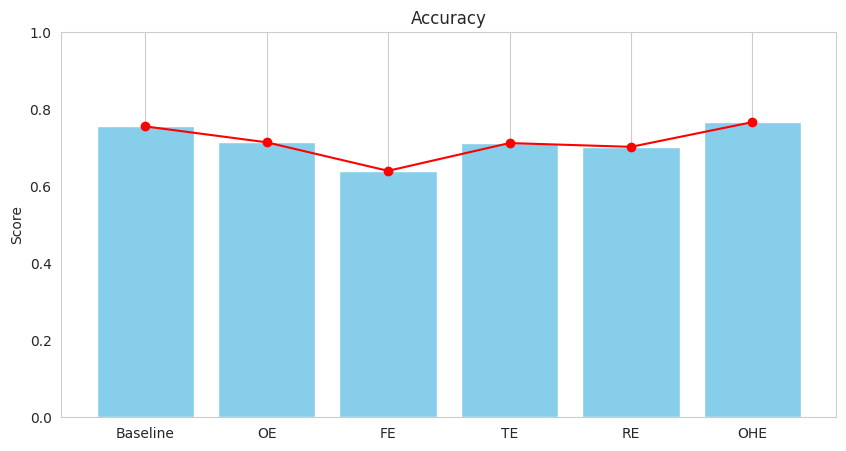

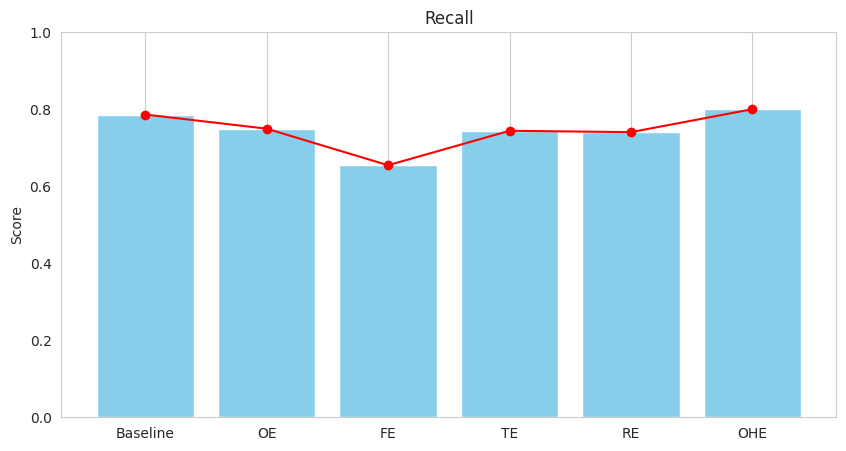

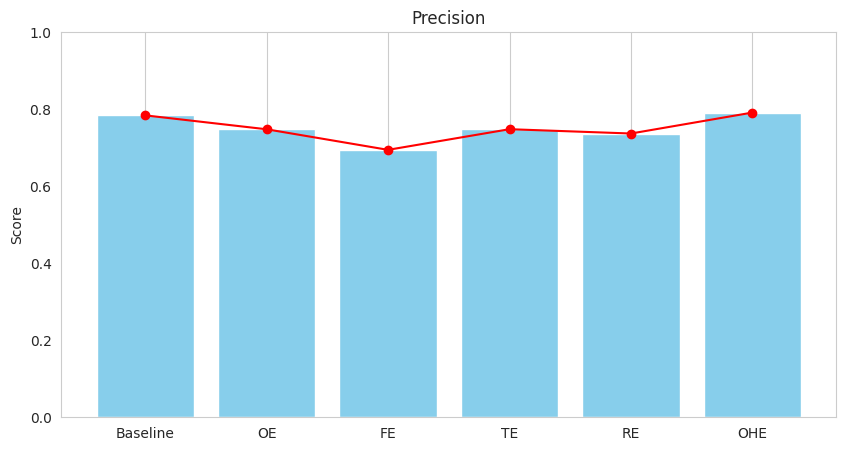

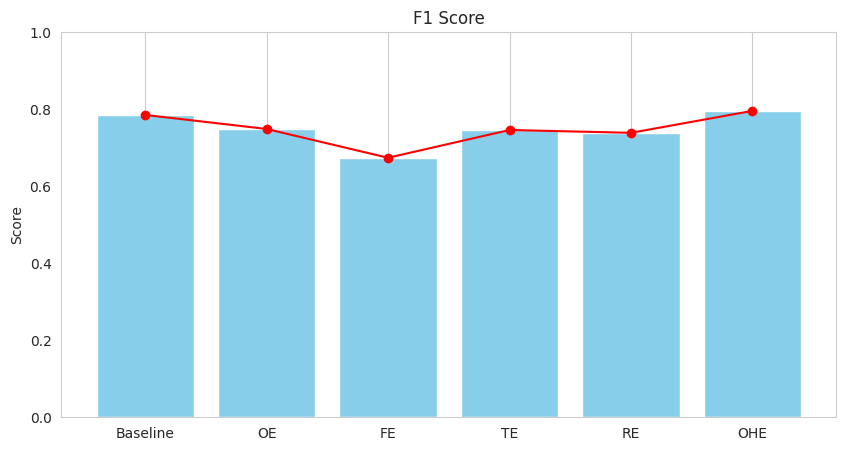

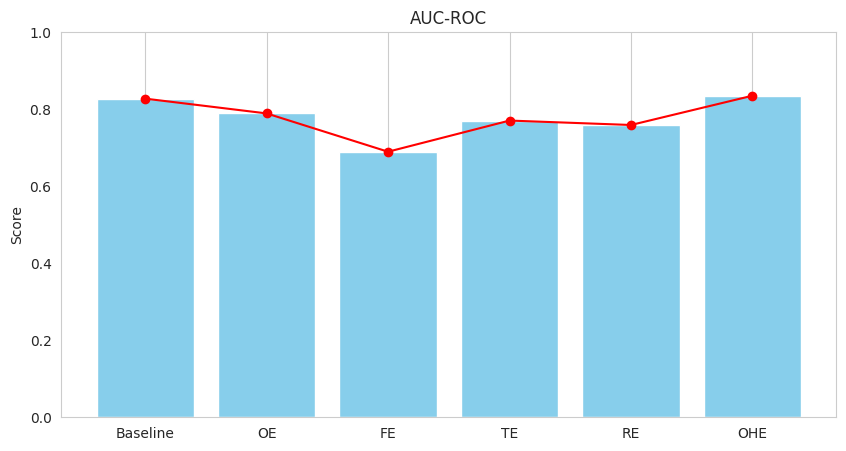

In [ ]:
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

models = [SVM_rbf_baseline, SVM_rbf_oe, SVM_rbf_fe, SVM_rbf_te, SVM_rbf_re, SVM_rbf_ohe]
model_names = ['Baseline', 'OE', 'FE', 'TE', 'RE', 'OHE']
X_tests = [X_test_baseline, X_test_Ordinal_encoding, X_test_frequency_encoding, X_test_target_encoding, X_test_response_encoding, X_test_ohe]

# Storage list
# Initialize lists to store metrics
accuracy_list = []
recall_list = []
precision_list = []
f1_list = []
auc_roc_list = []
# Create a table with headers
table = PrettyTable(['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC-ROC'])

for model, name, X_test in zip(models, model_names, X_tests):

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Append metrics to the lists
    accuracy_list.append(accuracy)
    recall_list.append(recall)
    precision_list.append(precision)
    f1_list.append(f1)
    auc_roc_list.append(auc_roc)

    # Format results to 4 decimal places
    accuracy = "{:.4f}".format(accuracy)
    recall = "{:.4f}".format(recall)
    precision = "{:.4f}".format(precision)
    f1 = "{:.4f}".format(f1)
    auc_roc = "{:.4f}".format(auc_roc)

    # Add results to the table
    table.add_row([name, accuracy, recall, precision, f1, auc_roc])

print(table)
# Create a list of lists for all metrics
all_metrics = [accuracy_list, recall_list, precision_list, f1_list, auc_roc_list]
# Define metrics names
metrics_names = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC-ROC']

# Plot metrics
for i, metric in enumerate(all_metrics):
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, metric, color='skyblue')
    plt.title(metrics_names[i])
    plt.ylim([0, 1])
    plt.ylabel('Score')
    plt.grid(axis='y')

    # Connect bars' centers
    plt.plot(model_names, metric, marker='o', color='red')

    plt.show()

### 1.8.1.2 Model Comparison(Decision Tree)

In [ ]:
def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig, ax = plt.subplots(figsize=figsize)
    try:

        sns.heatmap(df_cm, annot=False, fmt="d", ax=ax,cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right', fontsize=fontsize)
    plt.yticks(tick_marks, class_names, rotation=0, ha='right', fontsize=fontsize)

    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j+0.5, i+0.5, confusion_matrix[i, j],
                 horizontalalignment="center",
                 color="red" if confusion_matrix[i, j] > thresh else "black",fontsize=10)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Baseline Model Confusion Matrix:


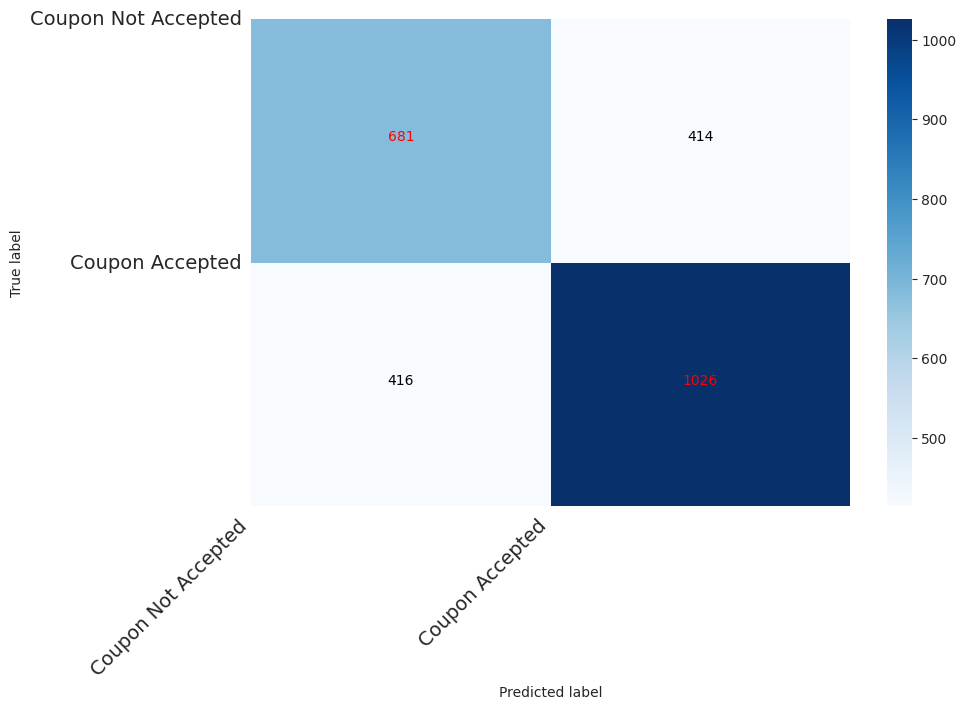

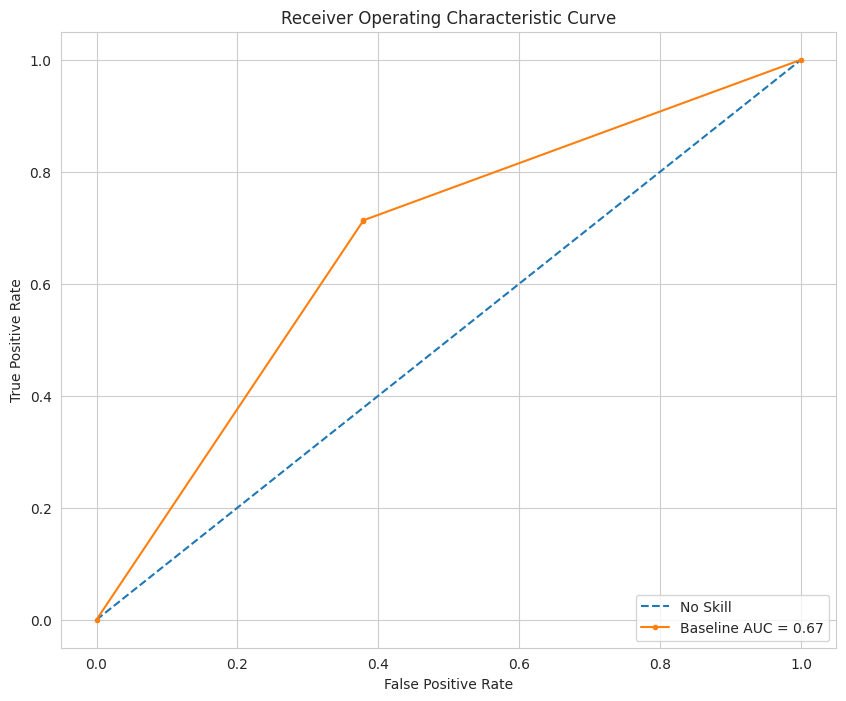

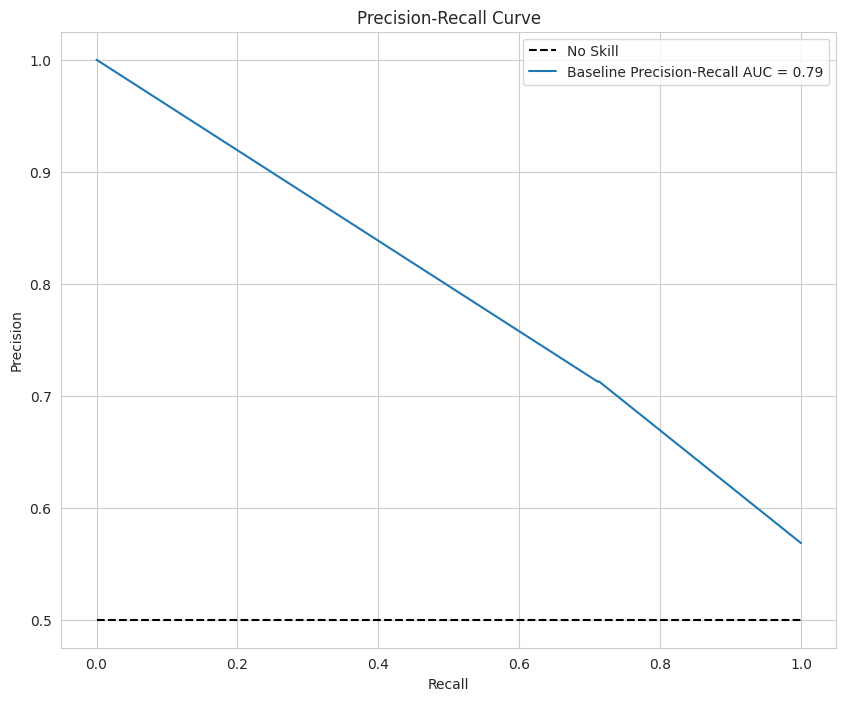

OE Model Confusion Matrix:


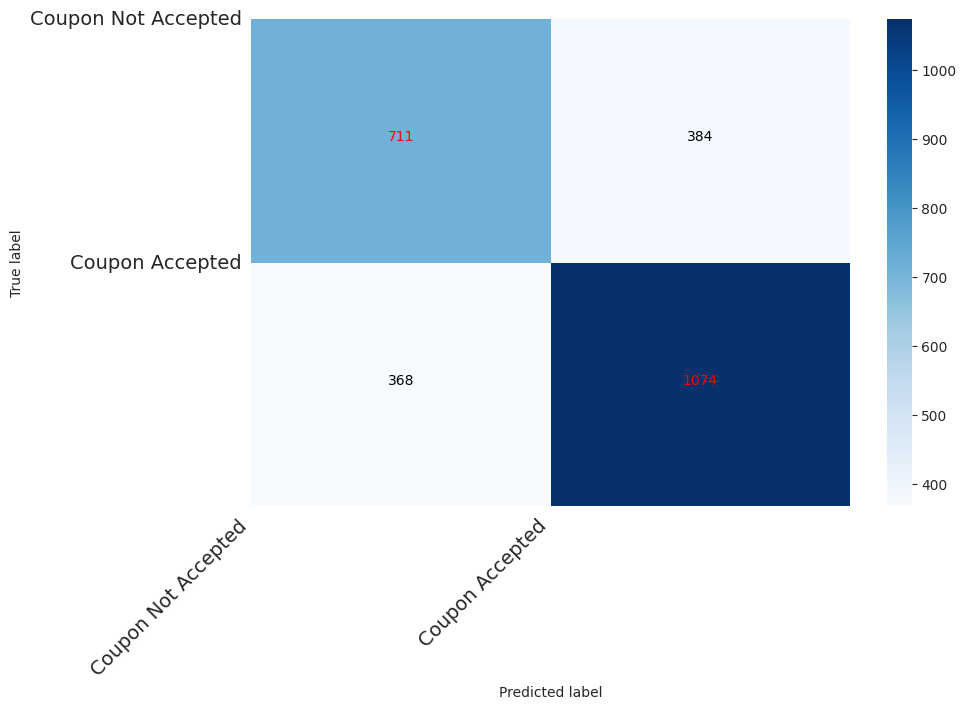

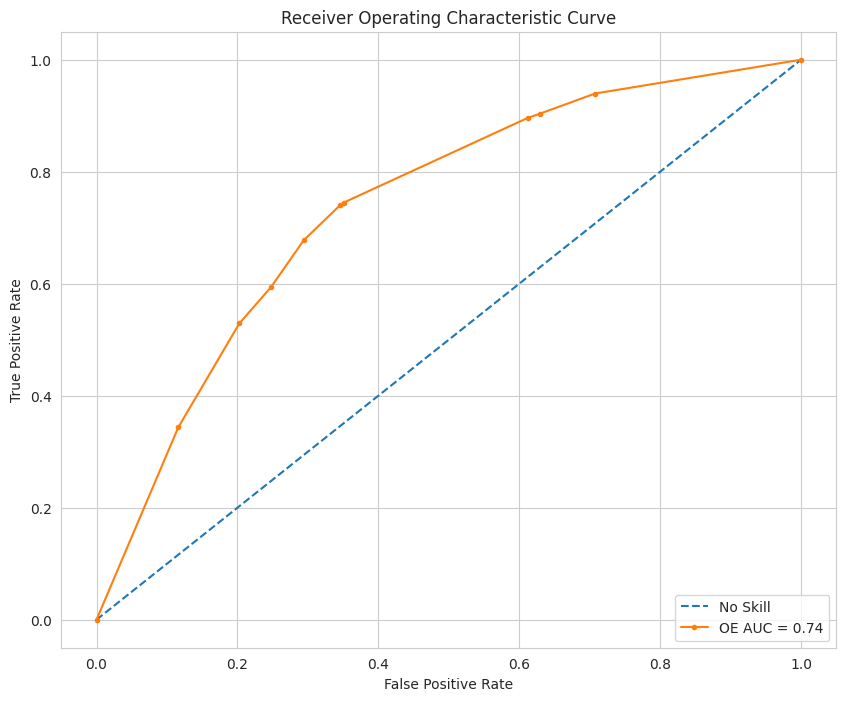

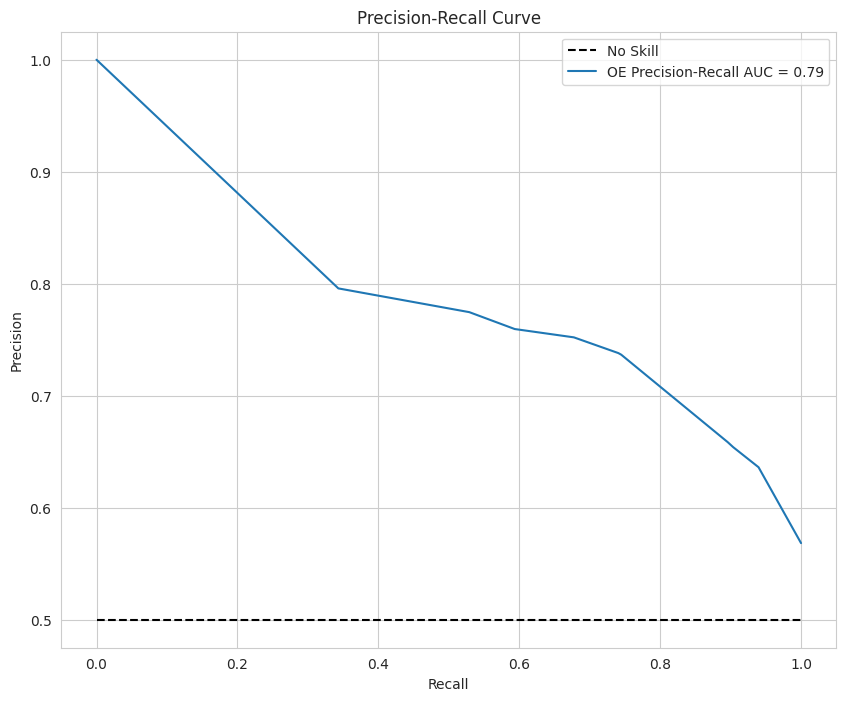

FE Model Confusion Matrix:


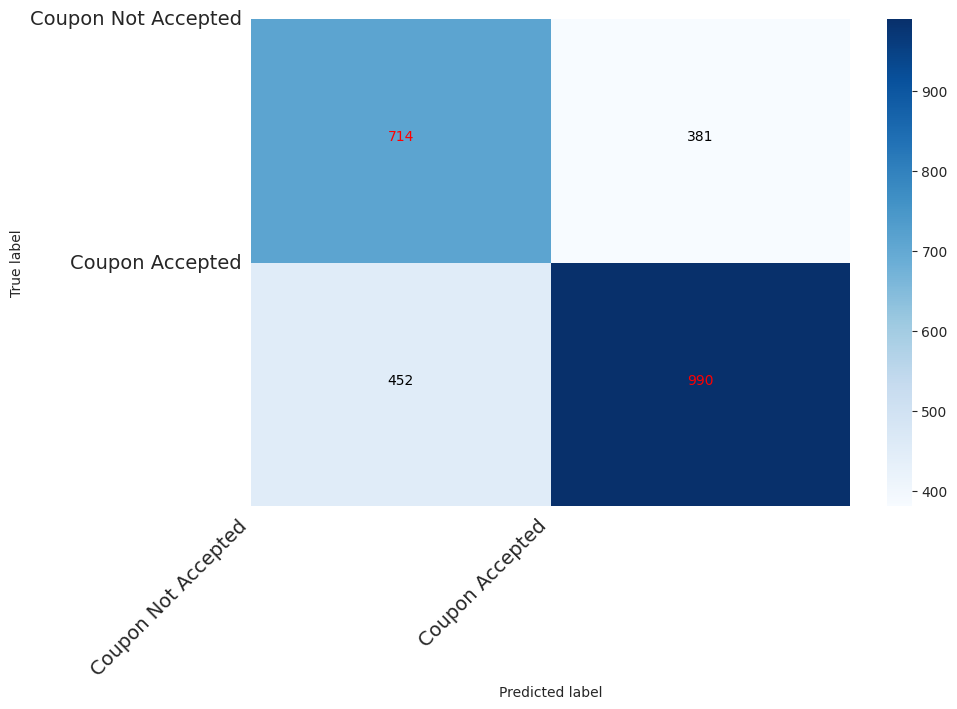

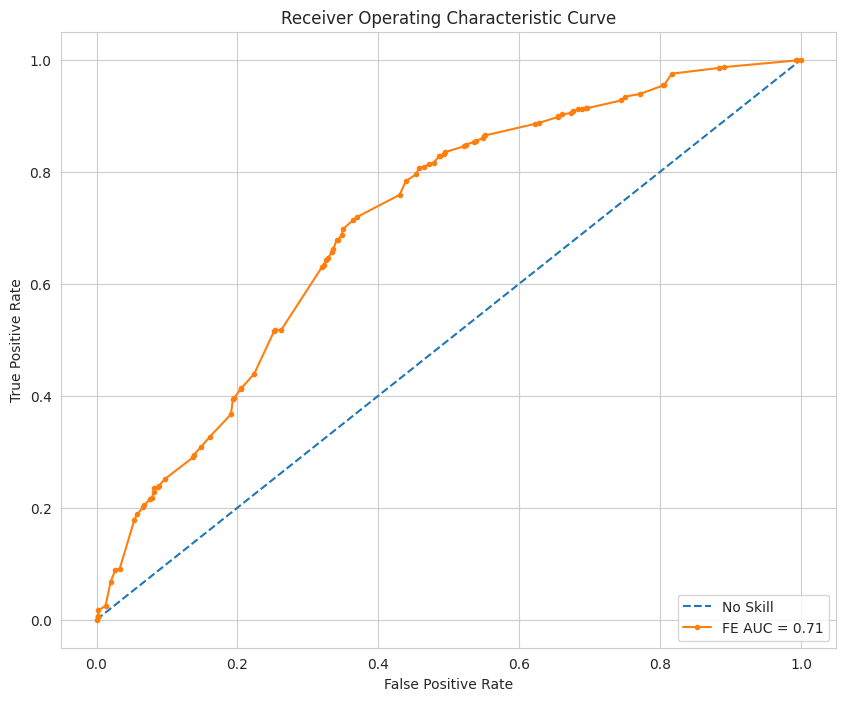

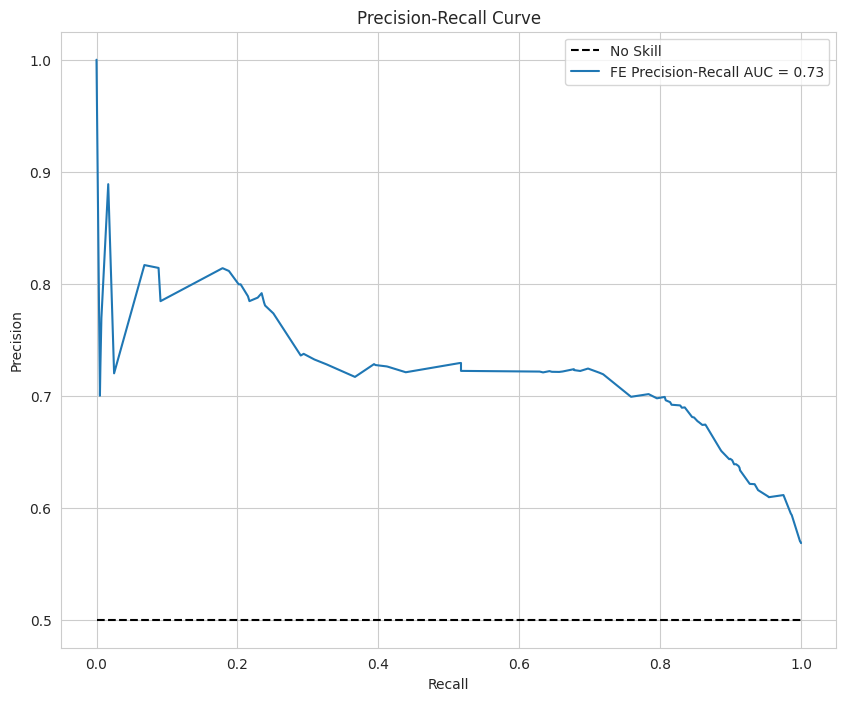

TE Model Confusion Matrix:


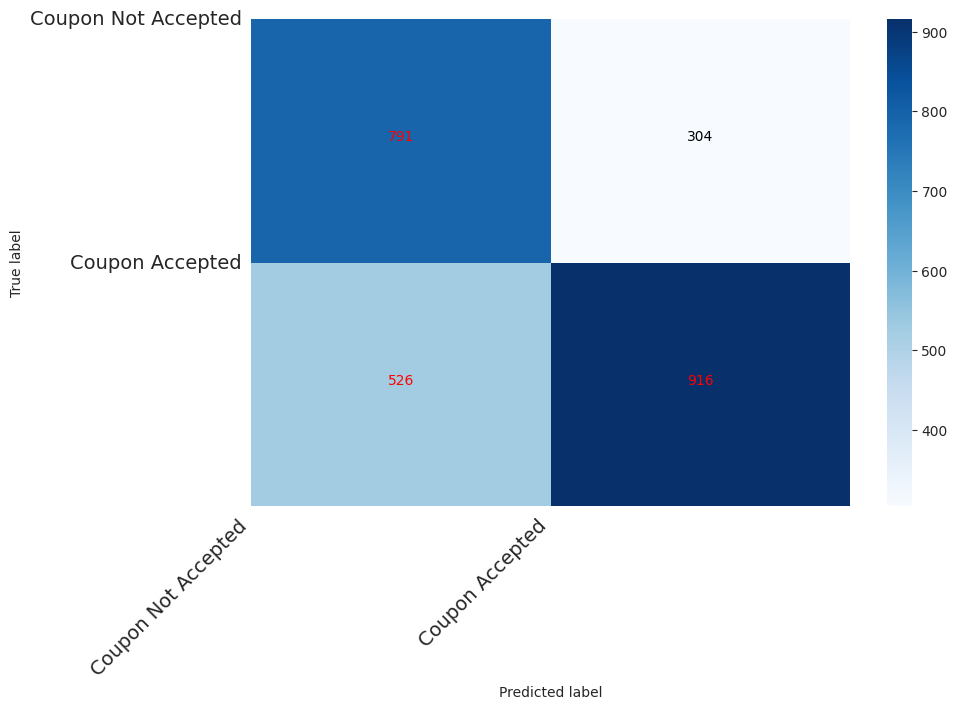

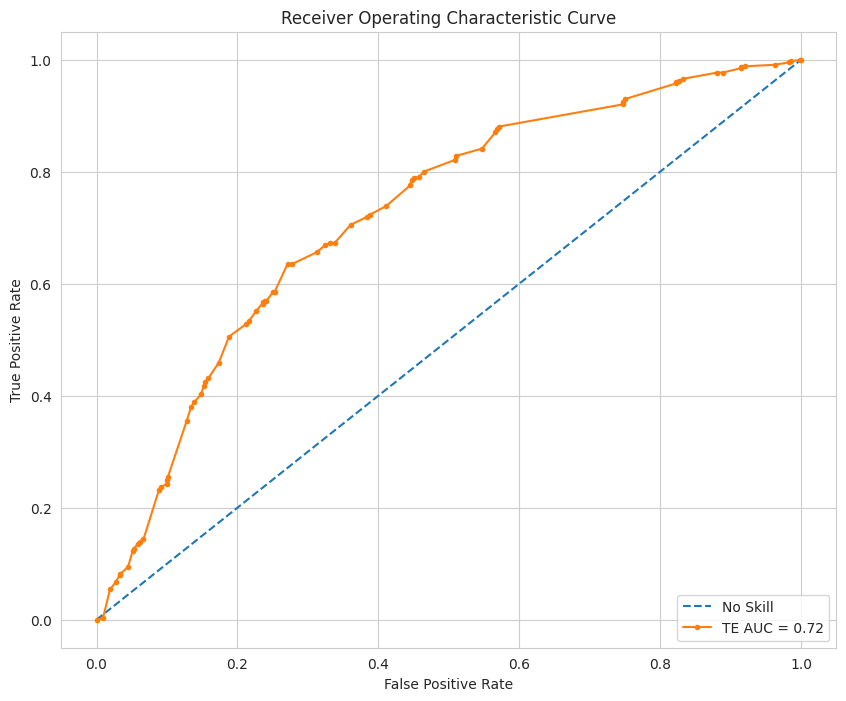

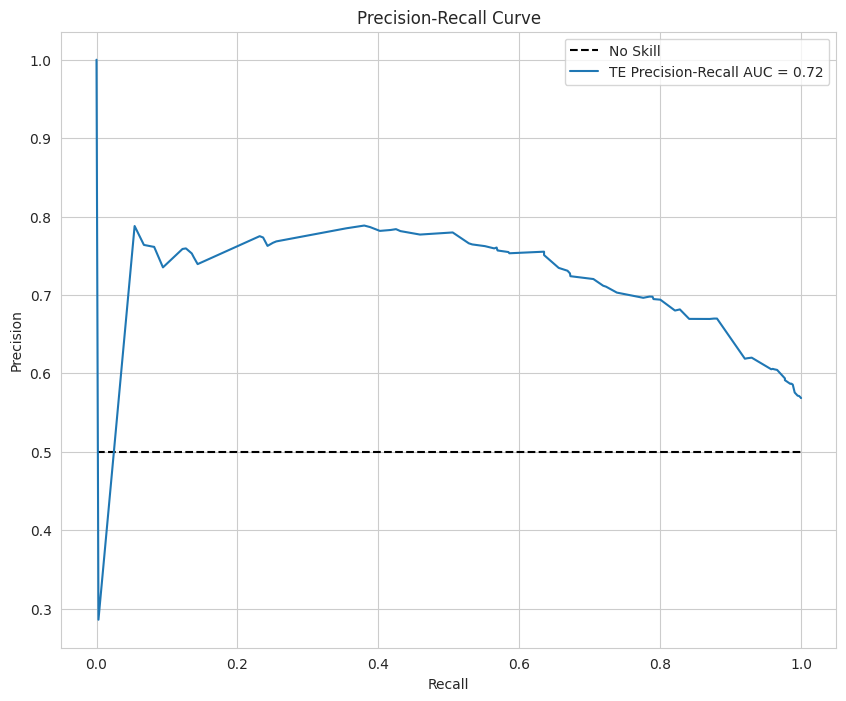

RE Model Confusion Matrix:


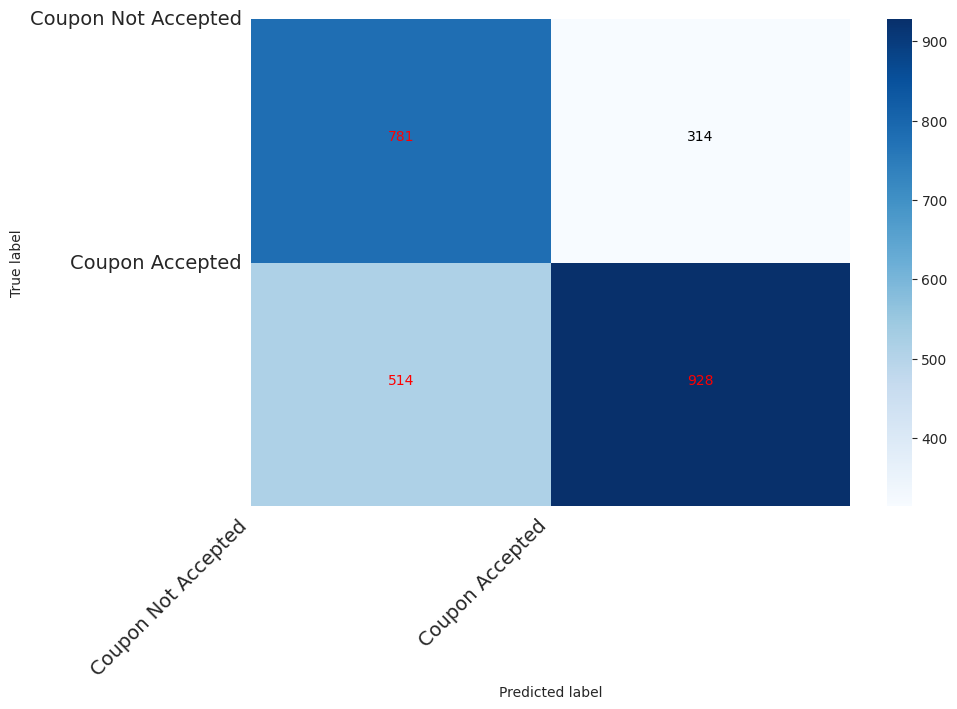

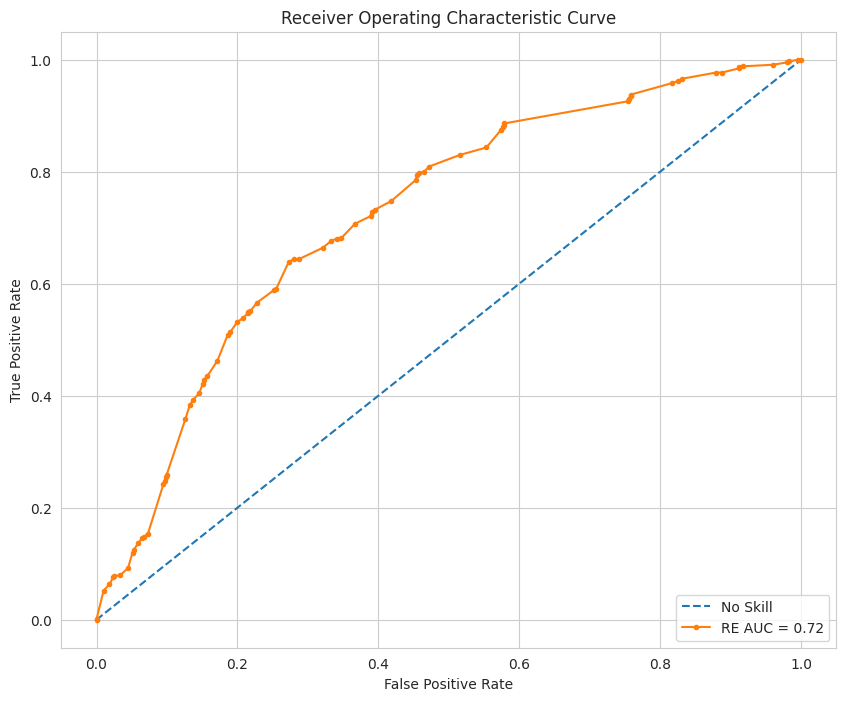

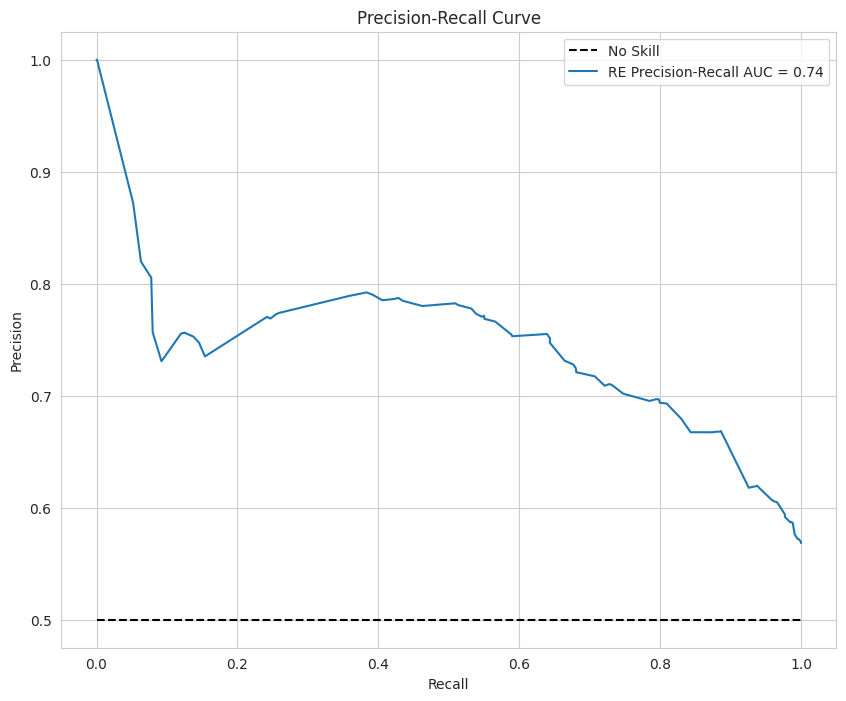

OHE Model Confusion Matrix:


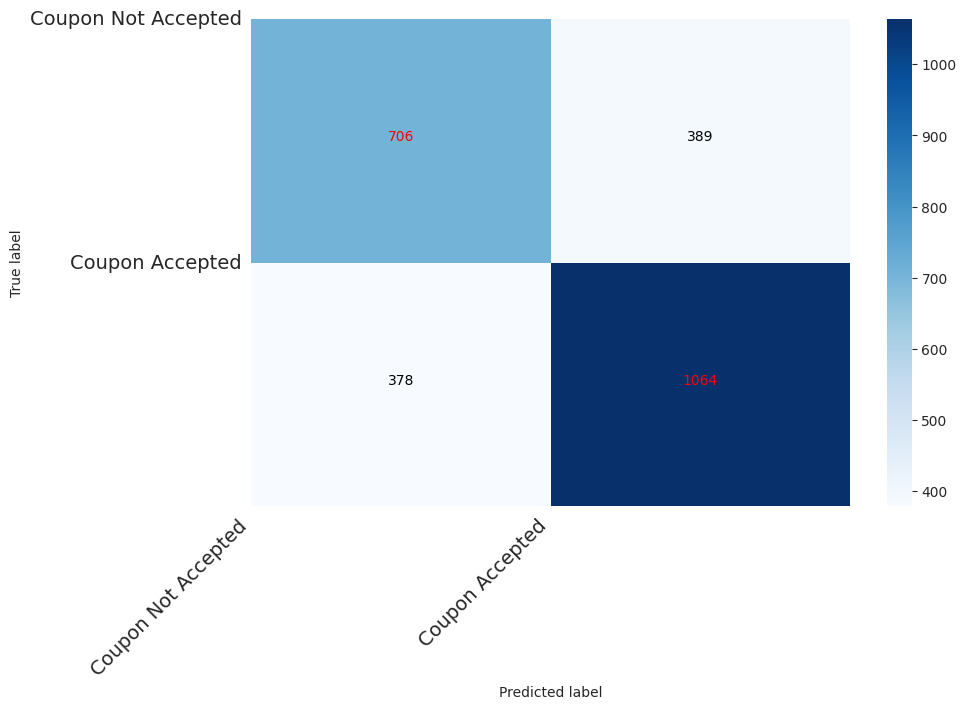

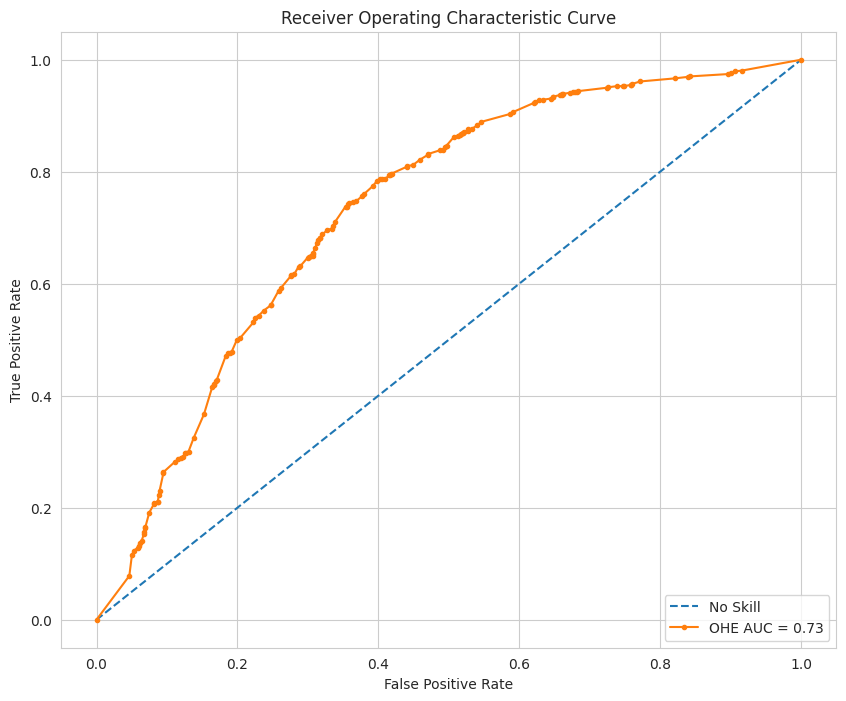

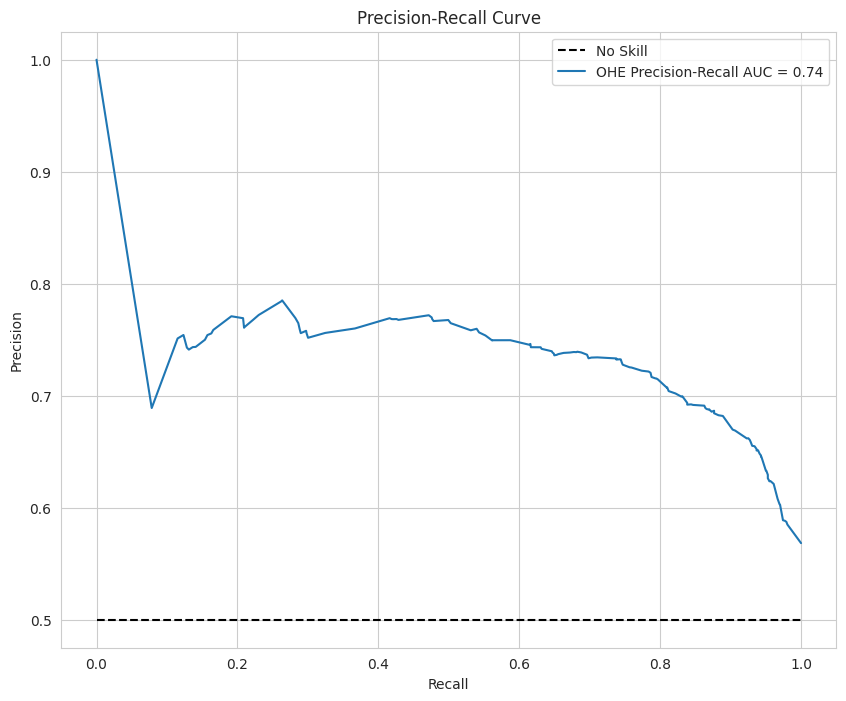

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
#use the fitted models
models = [dtc_baseline, dtc_oe, dtc_fe, dtc_te, dtc_re, dtc_ohe]
model_names = ['Baseline', 'OE', 'FE', 'TE', 'RE', 'OHE']
X_tests = [X_test_baseline, X_test_Ordinal_encoding, X_test_frequency_encoding, X_test_target_encoding, X_test_response_encoding, X_test_ohe]

for model, name, X_test in zip(models, model_names, X_tests):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # print Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    print(f"{name} Model Confusion Matrix:")
    plot_confusion_matrix(cm, ["Coupon Not Accepted", "Coupon Accepted"])
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.figure(figsize=(10,8))
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=f'{name} AUC = {roc_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc=4)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    prc_auc = auc(recall, precision)
    plt.figure(figsize=(10,8))
    plt.plot([0, 1], [0.5, 0.5],'k--', label='No Skill')
    plt.plot(recall, precision, label=f'{name} Precision-Recall AUC = {prc_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc=1)
    plt.show()

+----------+----------+--------+-----------+----------+---------+
|  Model   | Accuracy | Recall | Precision | F1 Score | AUC-ROC |
+----------+----------+--------+-----------+----------+---------+
| Baseline |  0.6728  | 0.7115 |   0.7125  |  0.7120  |  0.6671 |
|  DTC_OE  |  0.7036  | 0.7448 |   0.7366  |  0.7407  |  0.7385 |
|  DTC_FE  |  0.6717  | 0.6865 |   0.7221  |  0.7039  |  0.7087 |
|  DTC_TE  |  0.6728  | 0.6352 |   0.7508  |  0.6882  |  0.7216 |
|  DTC_RE  |  0.6736  | 0.6436 |   0.7472  |  0.6915  |  0.7246 |
| DTC_OHE  |  0.6977  | 0.7379 |   0.7323  |  0.7351  |  0.7329 |
+----------+----------+--------+-----------+----------+---------+


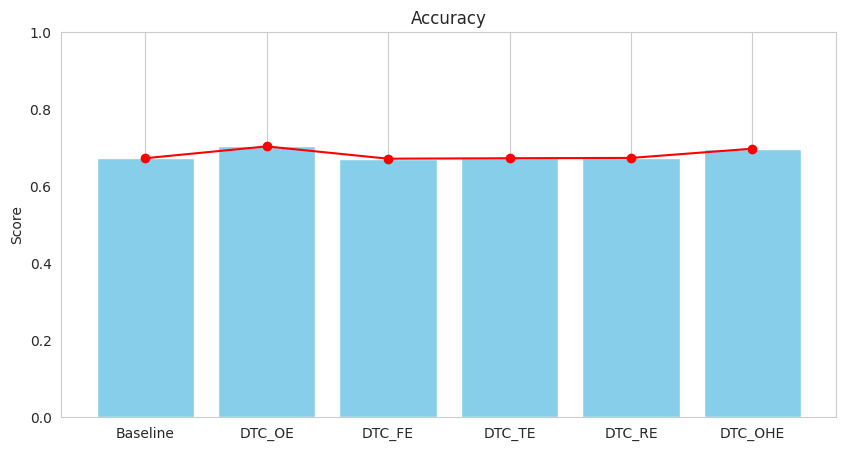

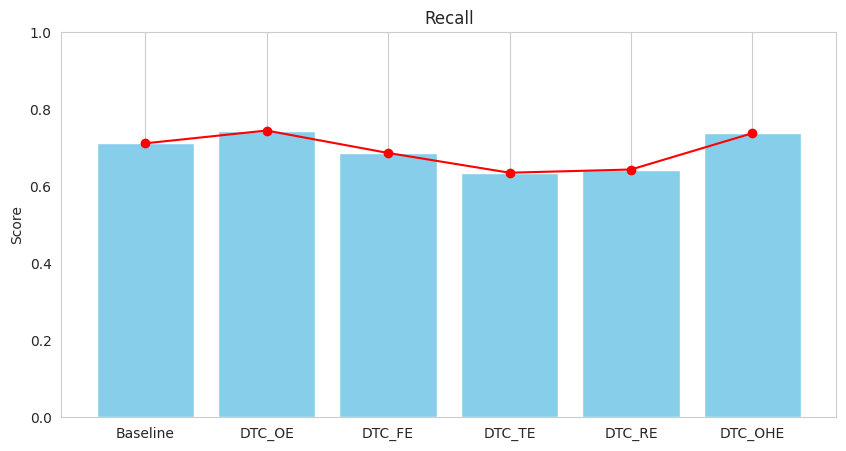

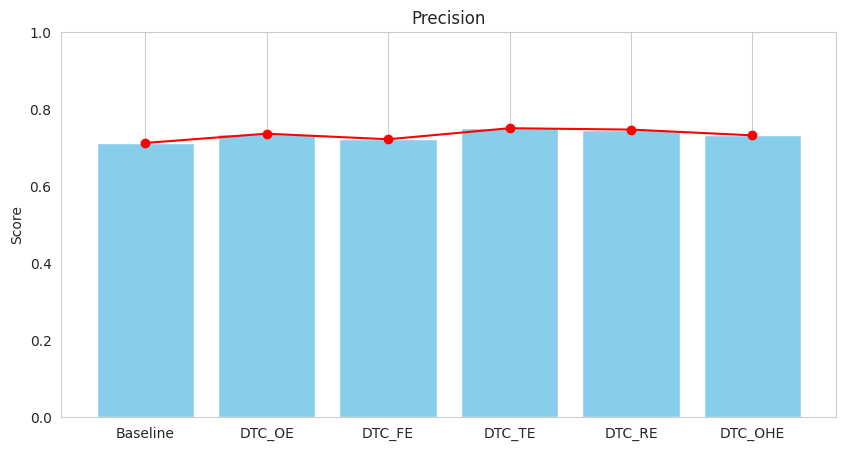

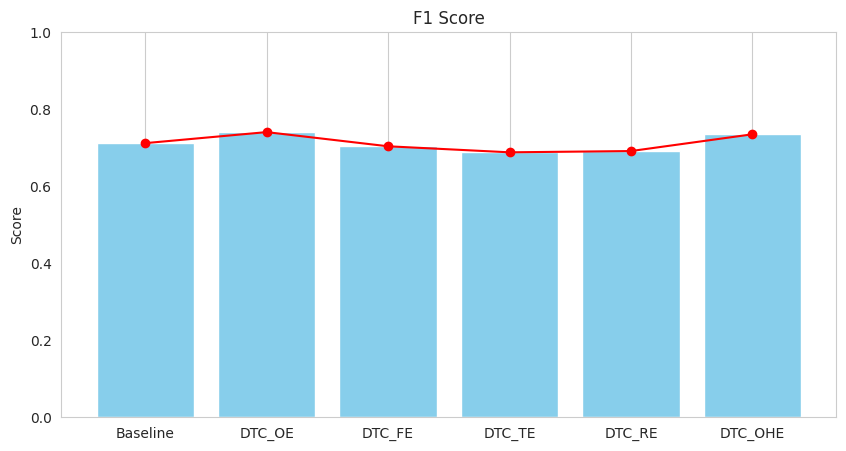

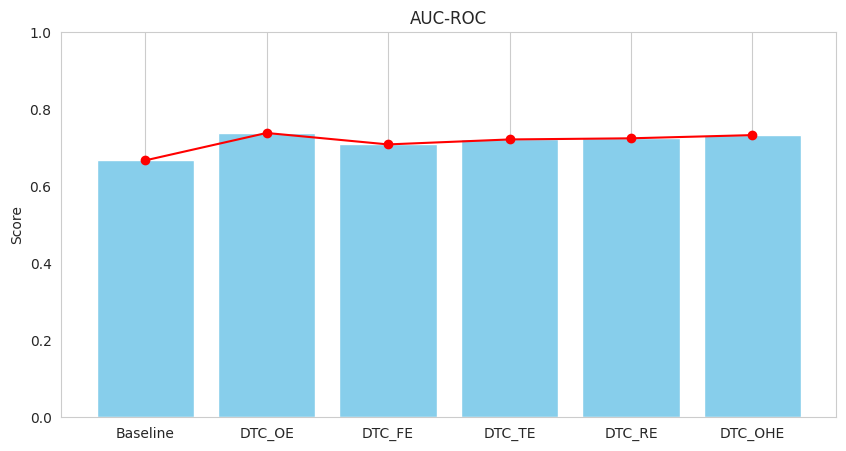

In [ ]:
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

models = [dtc_baseline, dtc_oe, dtc_fe, dtc_te, dtc_re, dtc_ohe]
model_names = ['Baseline', 'DTC_OE', 'DTC_FE', 'DTC_TE', 'DTC_RE', 'DTC_OHE']
X_tests = [X_test_baseline, X_test_Ordinal_encoding, X_test_frequency_encoding, X_test_target_encoding, X_test_response_encoding, X_test_ohe]

# Storage list
# Initialize lists to store metrics
accuracy_list = []
recall_list = []
precision_list = []
f1_list = []
auc_roc_list = []
# Create a table with headers
table = PrettyTable(['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC-ROC'])

for model, name, X_test in zip(models, model_names, X_tests):

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Append metrics to the lists
    accuracy_list.append(accuracy)
    recall_list.append(recall)
    precision_list.append(precision)
    f1_list.append(f1)
    auc_roc_list.append(auc_roc)

    # Format results to 4 decimal places
    accuracy = "{:.4f}".format(accuracy)
    recall = "{:.4f}".format(recall)
    precision = "{:.4f}".format(precision)
    f1 = "{:.4f}".format(f1)
    auc_roc = "{:.4f}".format(auc_roc)

    # Add results to the table
    table.add_row([name, accuracy, recall, precision, f1, auc_roc])

print(table)
# Create a list of lists for all metrics
all_metrics = [accuracy_list, recall_list, precision_list, f1_list, auc_roc_list]
# Define metrics names
metrics_names = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC-ROC']

# Plot metrics
for i, metric in enumerate(all_metrics):
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, metric, color='skyblue')
    plt.title(metrics_names[i])
    plt.ylim([0, 1])
    plt.ylabel('Score')
    plt.grid(axis='y')

    # Connect bars' centers
    plt.plot(model_names, metric, marker='o', color='red')

    plt.show()

### 1.8.1.3 Model Comparison(LogisticRegression)

In [ ]:
def plot_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig, ax = plt.subplots(figsize=figsize)
    try:

        sns.heatmap(df_cm, annot=False, fmt="d", ax=ax,cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right', fontsize=fontsize)
    plt.yticks(tick_marks, class_names, rotation=0, ha='right', fontsize=fontsize)

    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j+0.5, i+0.5, confusion_matrix[i, j],
                 horizontalalignment="center",
                 color="red" if confusion_matrix[i, j] > thresh else "black",fontsize=10)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Baseline Model Confusion Matrix:


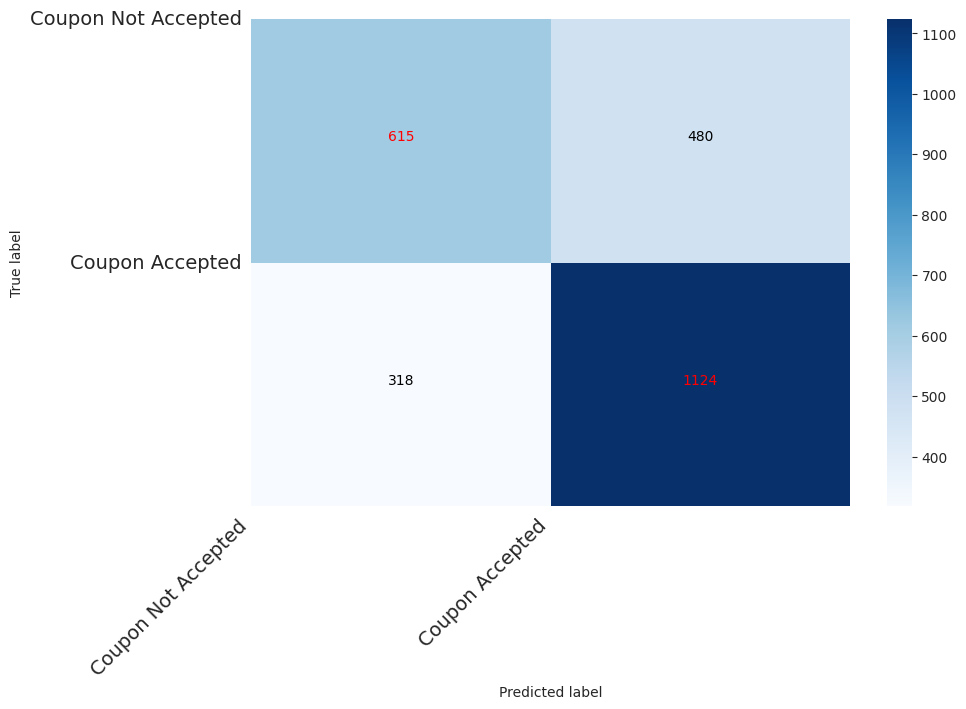

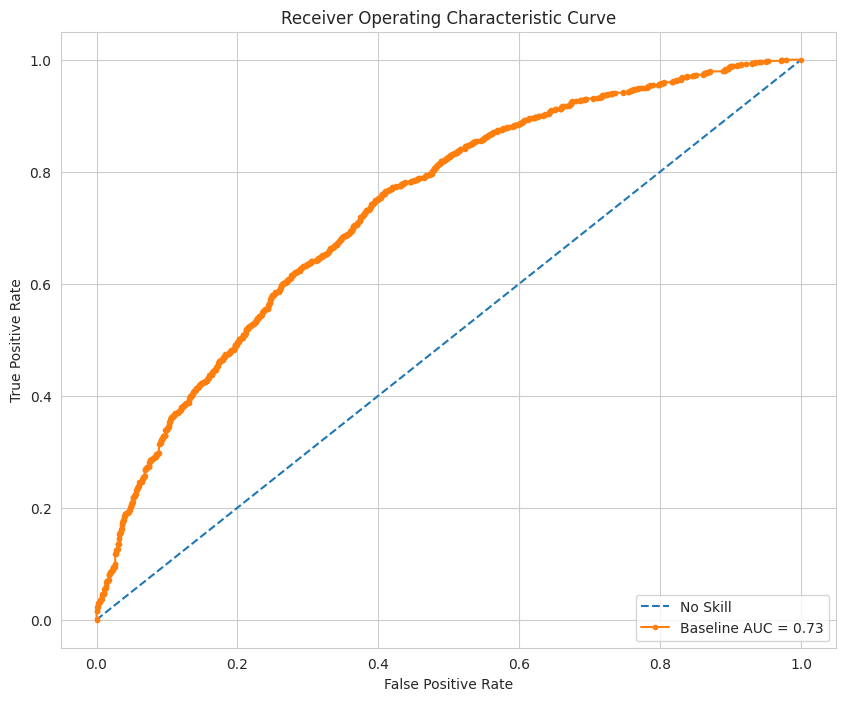

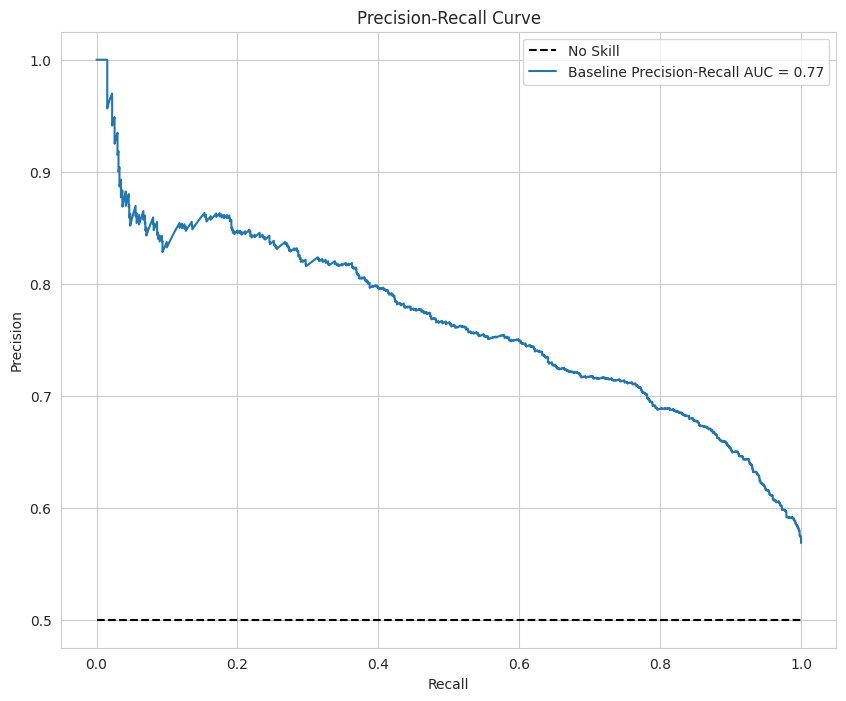

OE Model Confusion Matrix:


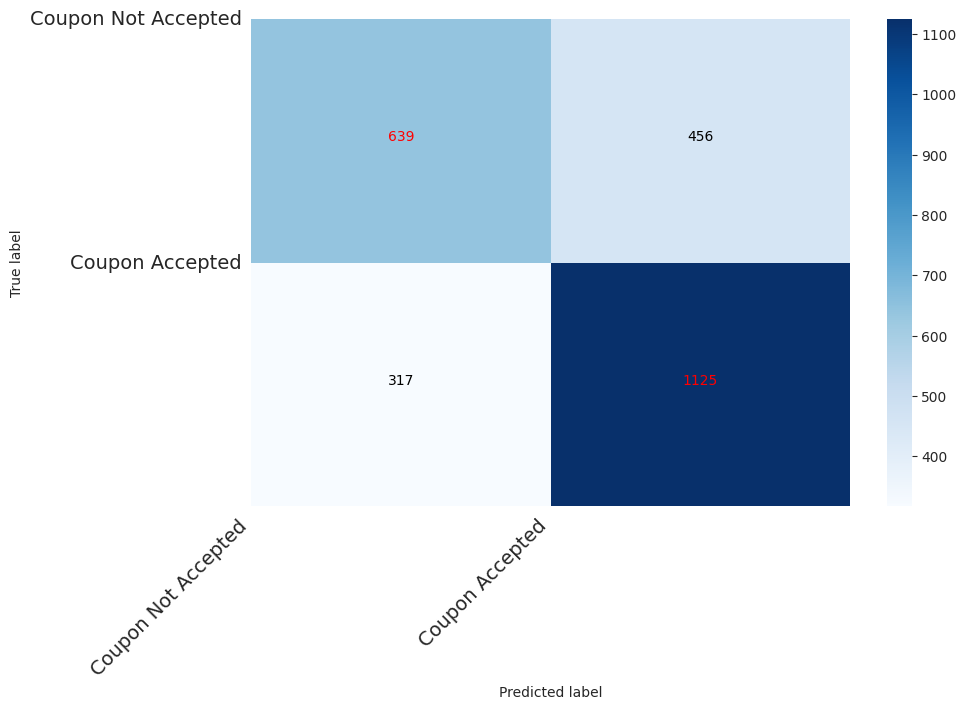

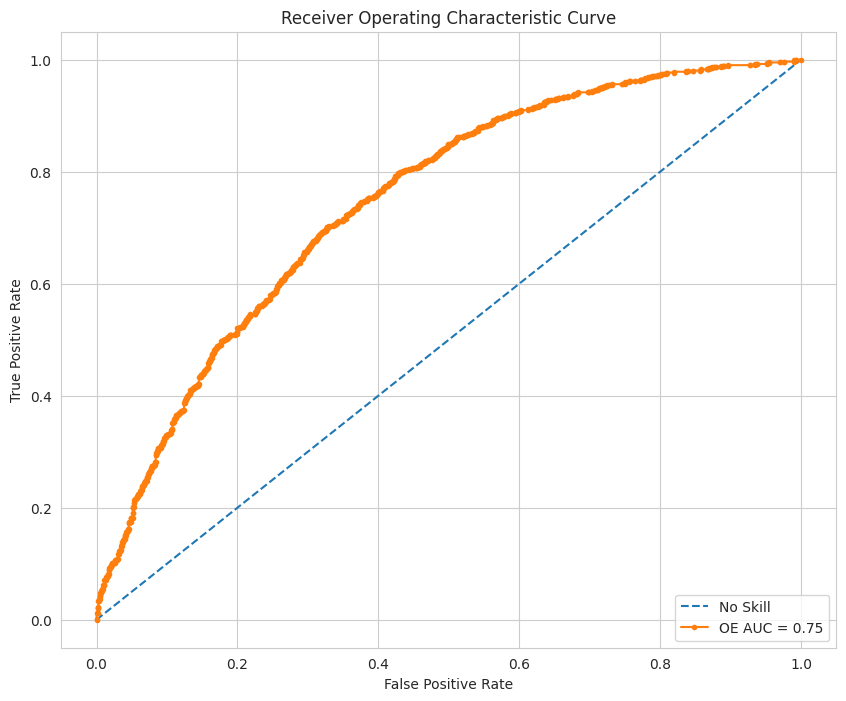

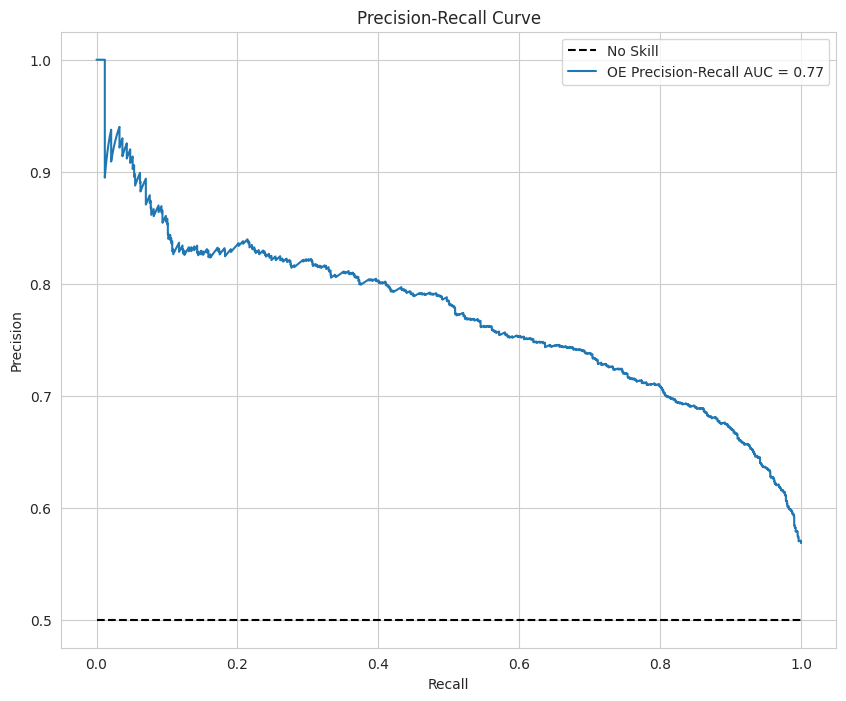

FE Model Confusion Matrix:


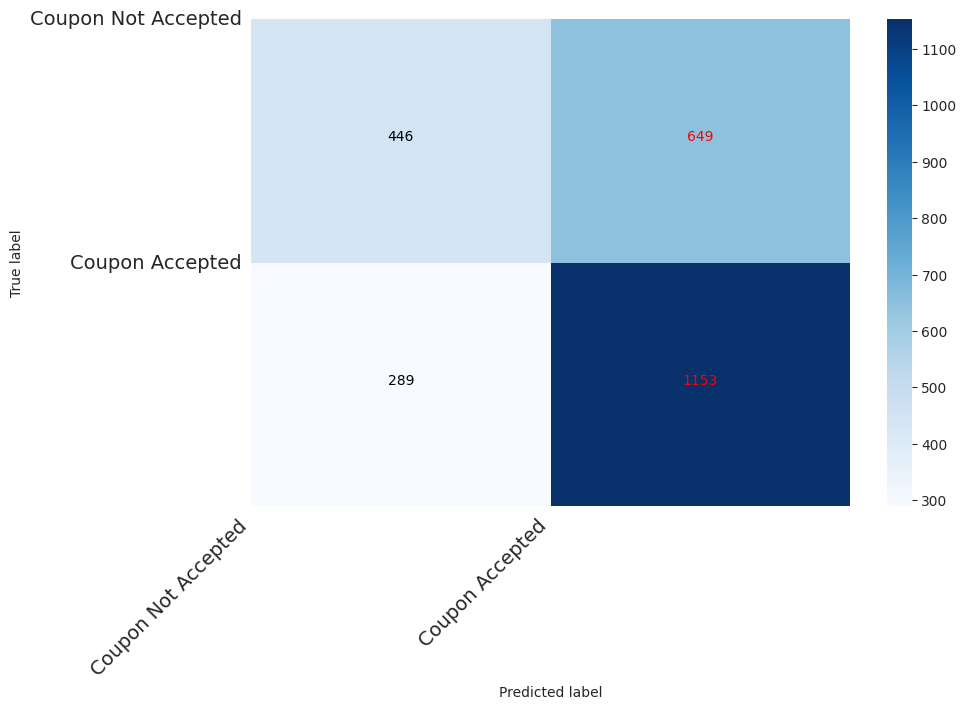

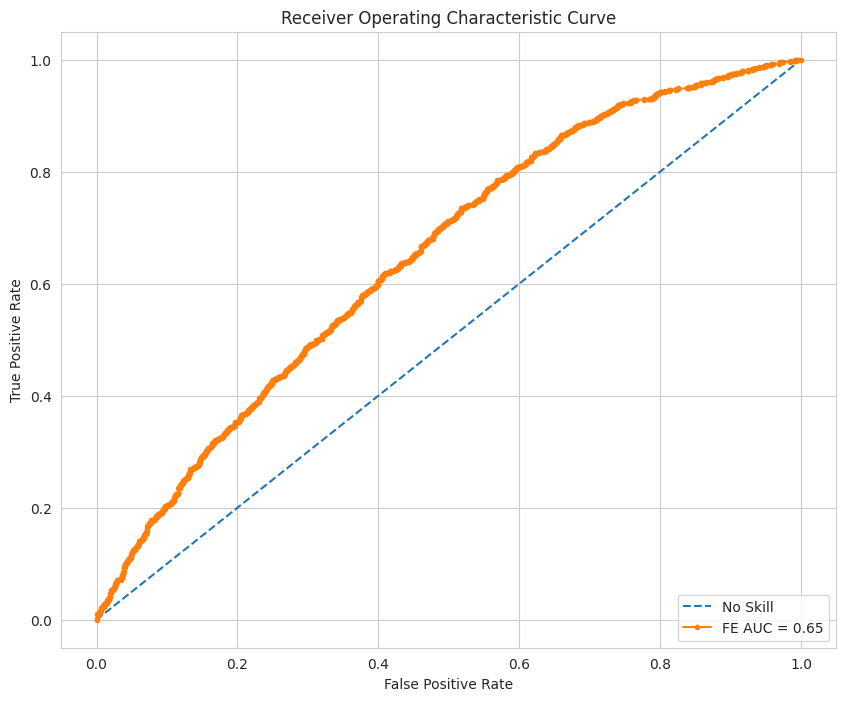

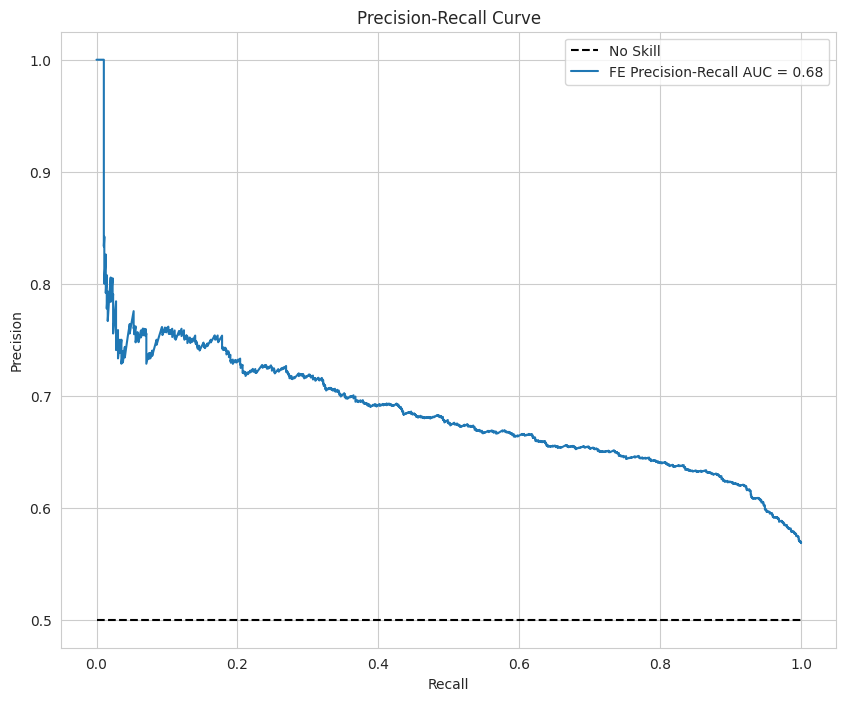

TE Model Confusion Matrix:


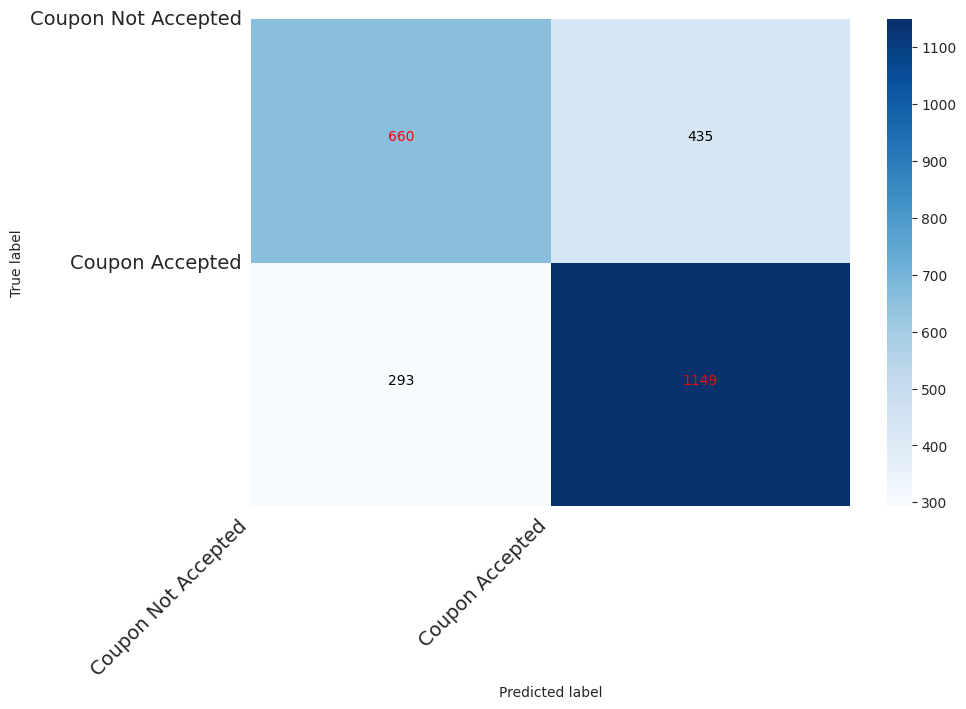

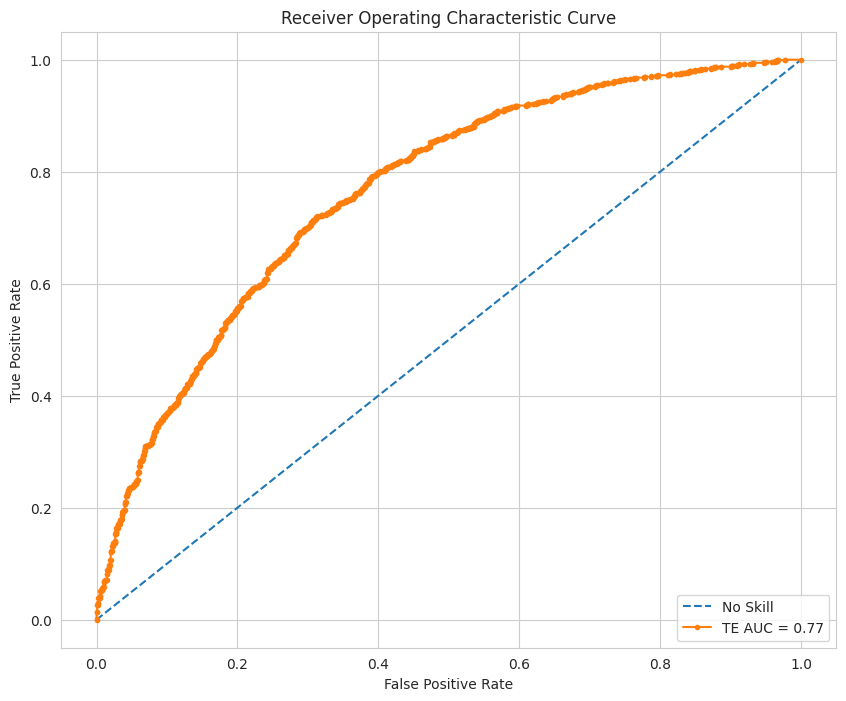

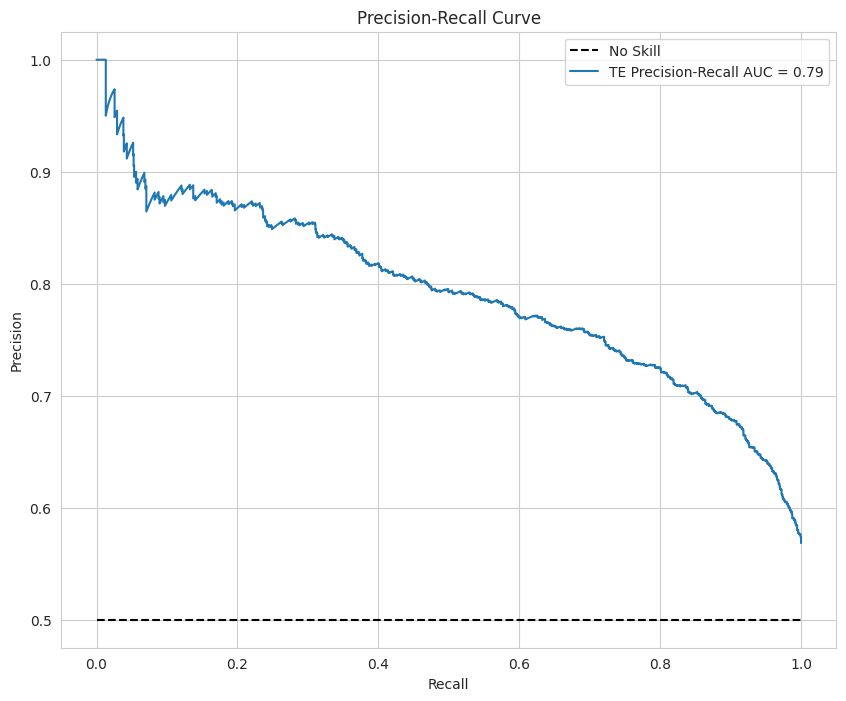

RE Model Confusion Matrix:


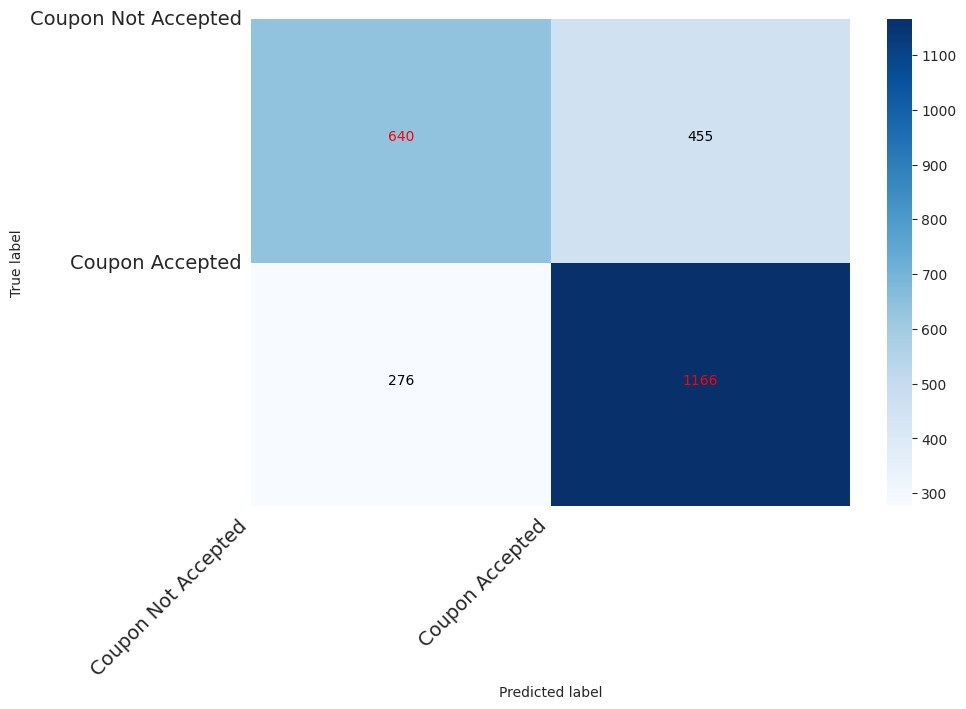

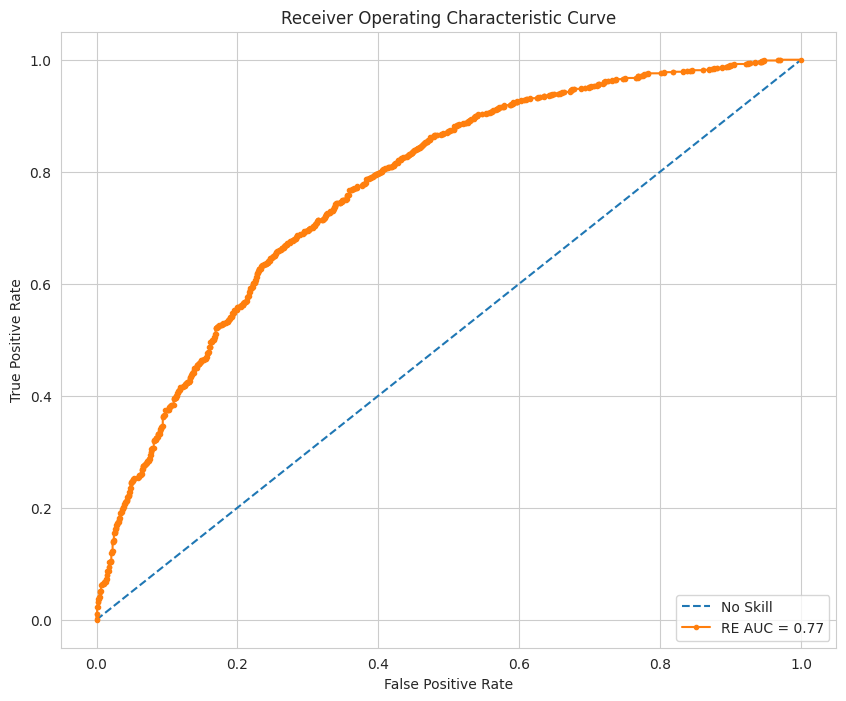

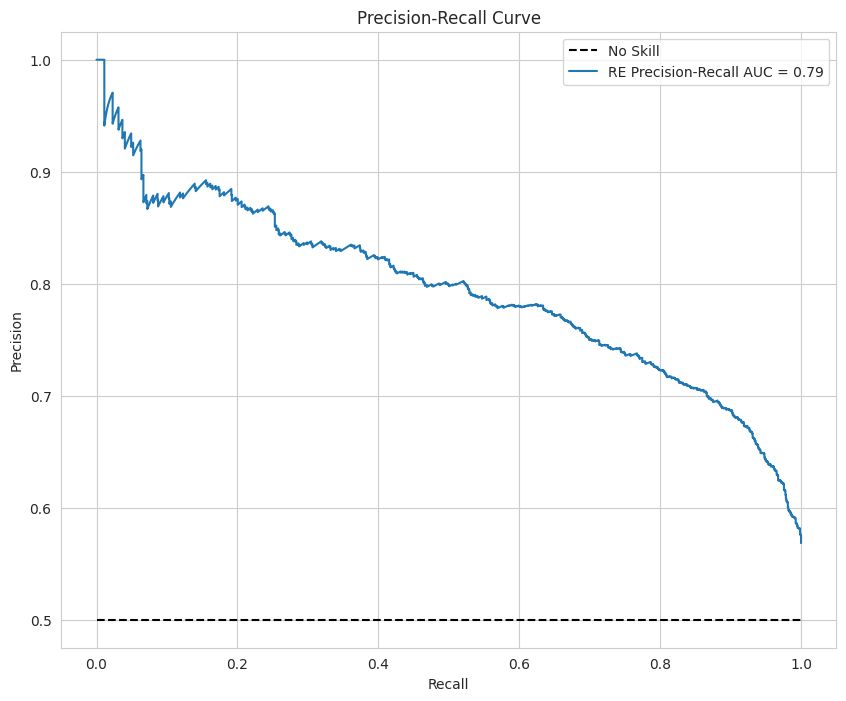

OHE Model Confusion Matrix:


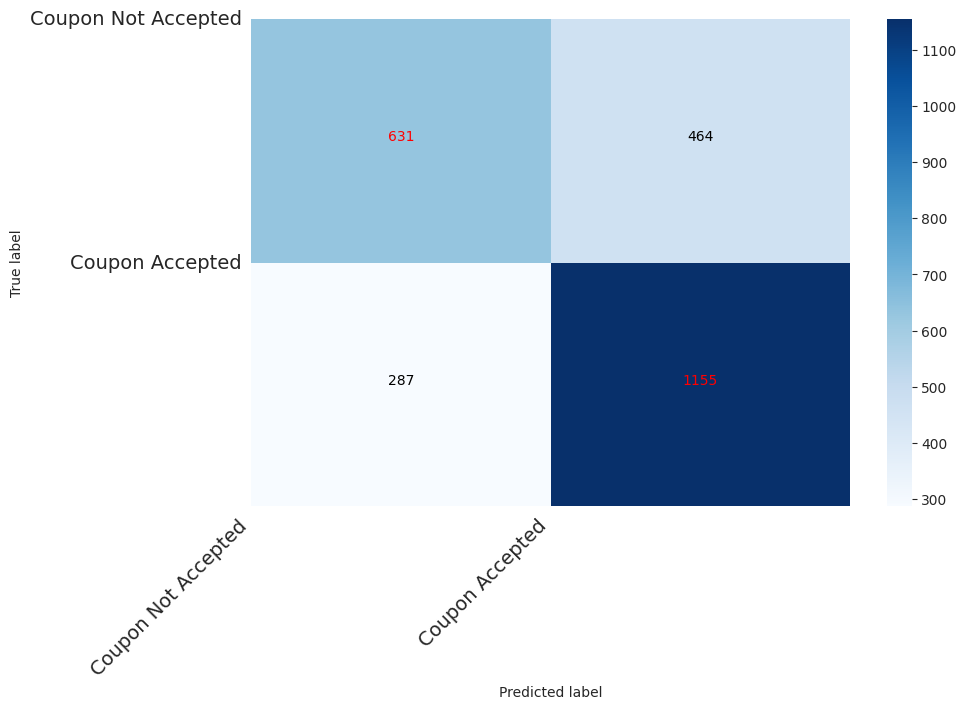

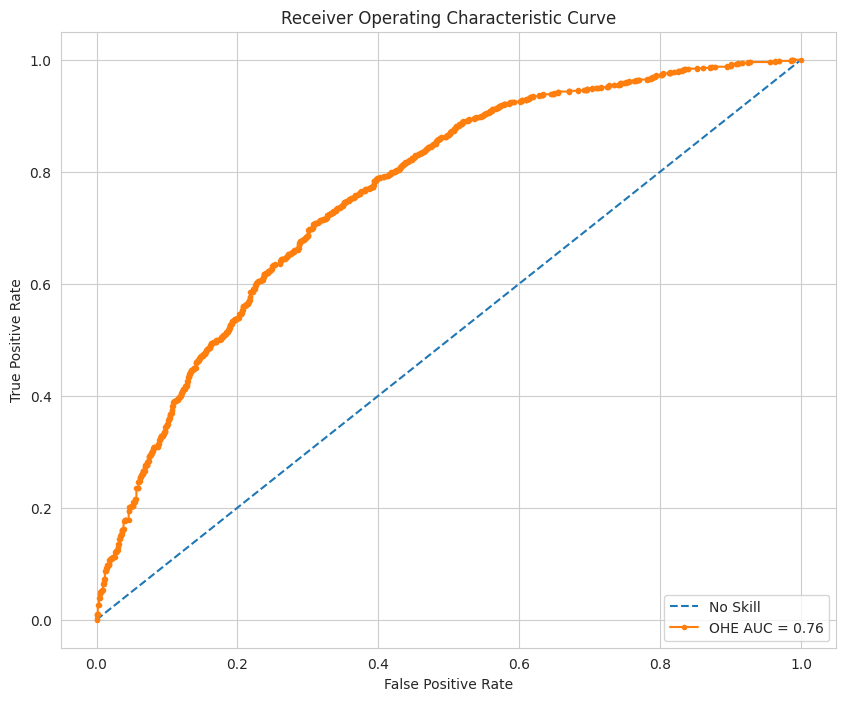

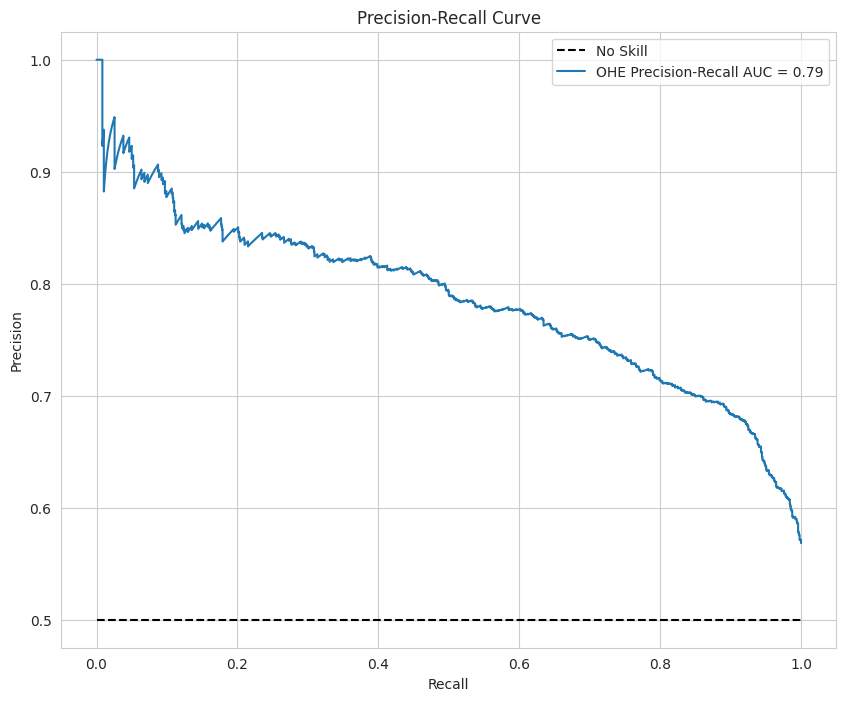

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc

models = [LogisticRegression_baseline, LogisticRegression_oe, LogisticRegression_fe, LogisticRegression_te, LogisticRegression_re, LogisticRegression_ohe]
model_names = ['Baseline', 'OE', 'FE', 'TE', 'RE', 'OHE']
X_tests = [X_test_baseline, X_test_Ordinal_encoding, X_test_frequency_encoding, X_test_target_encoding, X_test_response_encoding, X_test_ohe]

for model, name, X_test in zip(models, model_names, X_tests):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # Print Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    # pd.crosstab(y_test, y_pred, rownames = ['Truth'], colnames =['Predicted'], margins = True)
    print(f"{name} Model Confusion Matrix:")
    plot_confusion_matrix(cm, ["Coupon Not Accepted", "Coupon Accepted"])
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.figure(figsize=(10,8))
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label=f'{name} AUC = {roc_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc=4)
    plt.show()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    prc_auc = auc(recall, precision)
    plt.figure(figsize=(10,8))
    plt.plot([0, 1], [0.5, 0.5],'k--', label='No Skill')
    plt.plot(recall, precision, label=f'{name} Precision-Recall AUC = {prc_auc:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc=1)
    plt.show()

+------------------------+----------+--------+-----------+----------+---------+
|         Model          | Accuracy | Recall | Precision | F1 Score | ROC-AUC |
+------------------------+----------+--------+-----------+----------+---------+
|        Baseline        |  0.685   | 0.779  |   0.701   |  0.738   |  0.734  |
| LogisticRegression_OE  |  0.695   | 0.780  |   0.712   |  0.744   |  0.747  |
| LogisticRegression_FE  |  0.630   | 0.800  |   0.640   |  0.711   |  0.648  |
| LogisticRegression_TE  |  0.713   | 0.797  |   0.725   |  0.759   |  0.765  |
| LogisticRegression_RE  |  0.712   | 0.809  |   0.719   |  0.761   |  0.769  |
| LogisticRegression_OHE |  0.704   | 0.801  |   0.713   |  0.755   |  0.763  |
+------------------------+----------+--------+-----------+----------+---------+


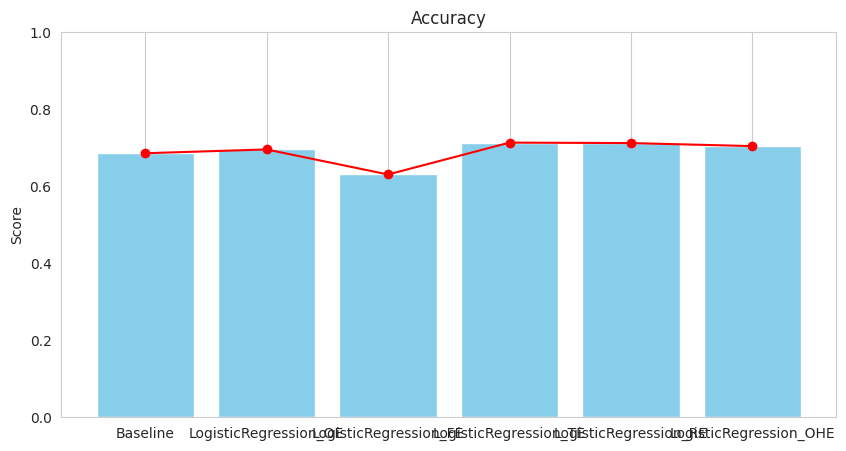

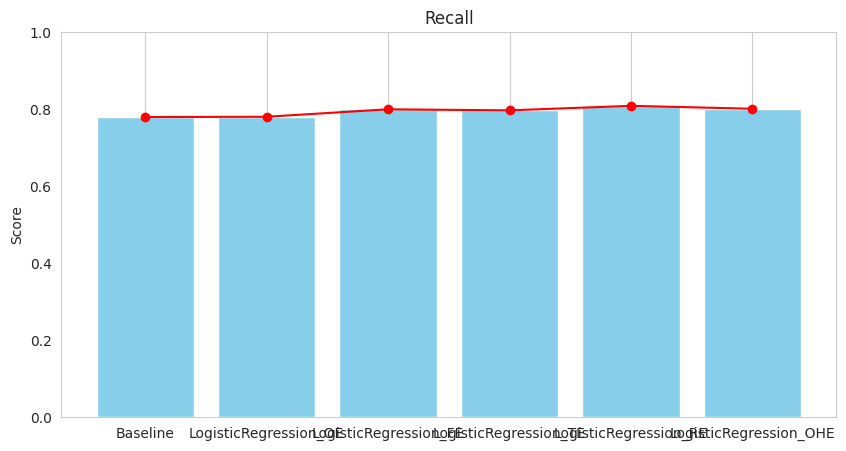

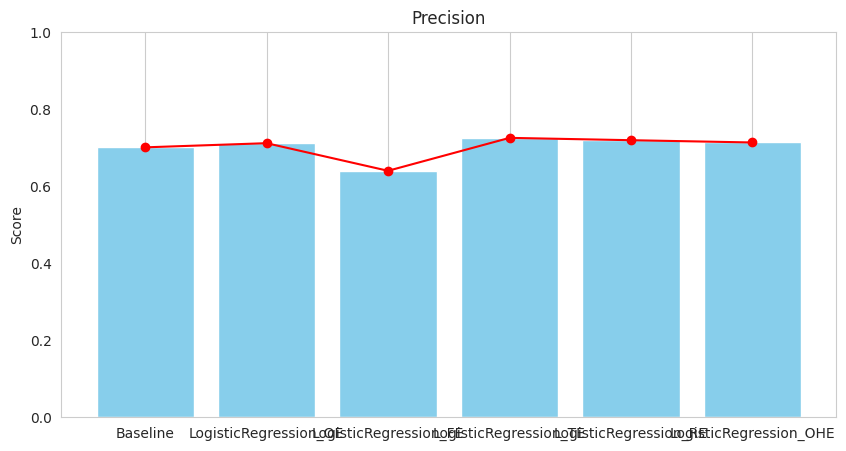

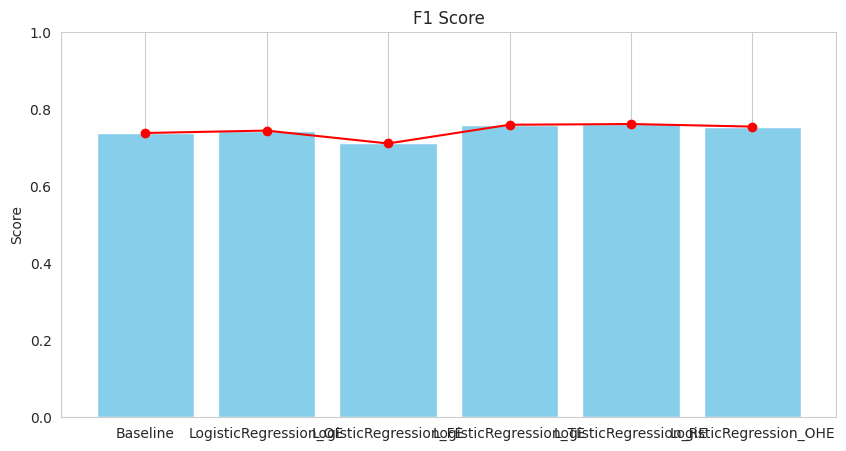

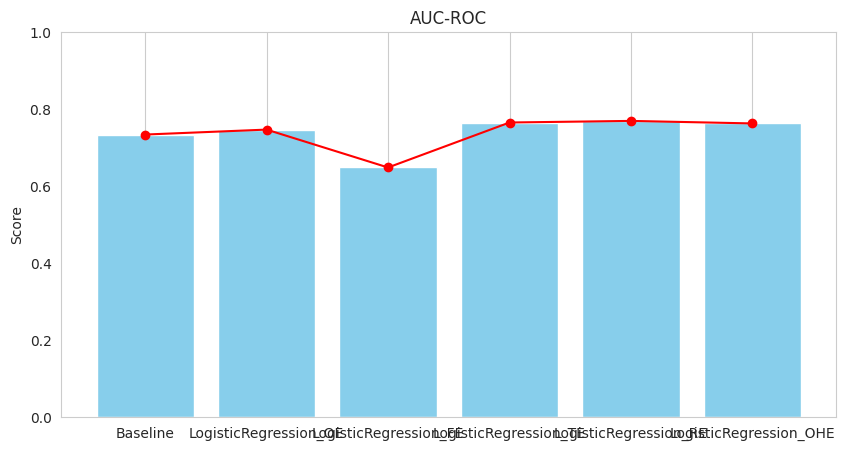

In [ ]:
models = [LogisticRegression_baseline, LogisticRegression_oe, LogisticRegression_fe, LogisticRegression_te, LogisticRegression_re, LogisticRegression_ohe]
model_names = ['Baseline', 'LogisticRegression_OE', 'LogisticRegression_FE', 'LogisticRegression_TE', 'LogisticRegression_RE', 'LogisticRegression_OHE']
X_tests = [X_test_baseline, X_test_Ordinal_encoding, X_test_frequency_encoding, X_test_target_encoding, X_test_response_encoding, X_test_ohe]

# Storage list
# Initialize lists to store metrics
accuracy_list = []
recall_list = []
precision_list = []
f1_list = []
auc_roc_list = []
# Create a table with headers
table = PrettyTable(['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'ROC-AUC'])

for model, name, X_test in zip(models, model_names, X_tests):

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Append metrics to the lists
    accuracy_list.append(accuracy)
    recall_list.append(recall)
    precision_list.append(precision)
    f1_list.append(f1)
    auc_roc_list.append(auc_roc)

    # Format results to 4 decimal places
    accuracy = "{:.3f}".format(accuracy)
    recall = "{:.3f}".format(recall)
    precision = "{:.3f}".format(precision)
    f1 = "{:.3f}".format(f1)
    auc_roc = "{:.3f}".format(auc_roc)

    # Add results to the table
    table.add_row([name, accuracy, recall, precision, f1, auc_roc])

print(table)
# Create a list of lists for all metrics
all_metrics = [accuracy_list, recall_list, precision_list, f1_list, auc_roc_list]
# Define metrics names
metrics_names = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC-ROC']

# Plot metrics
for i, metric in enumerate(all_metrics):
    plt.figure(figsize=(10, 5))
    plt.bar(model_names, metric, color='skyblue')
    plt.title(metrics_names[i])
    plt.ylim([0, 1])
    plt.ylabel('Score')
    plt.grid(axis='y')

    # Connect bars' centers
    plt.plot(model_names, metric, marker='o', color='red')

    plt.show()

### 1.8.1.4 Model Comparision(K Nearest Neighbors)

#### 1.8.1.4.1 roc curve and Precision-Recall Curve

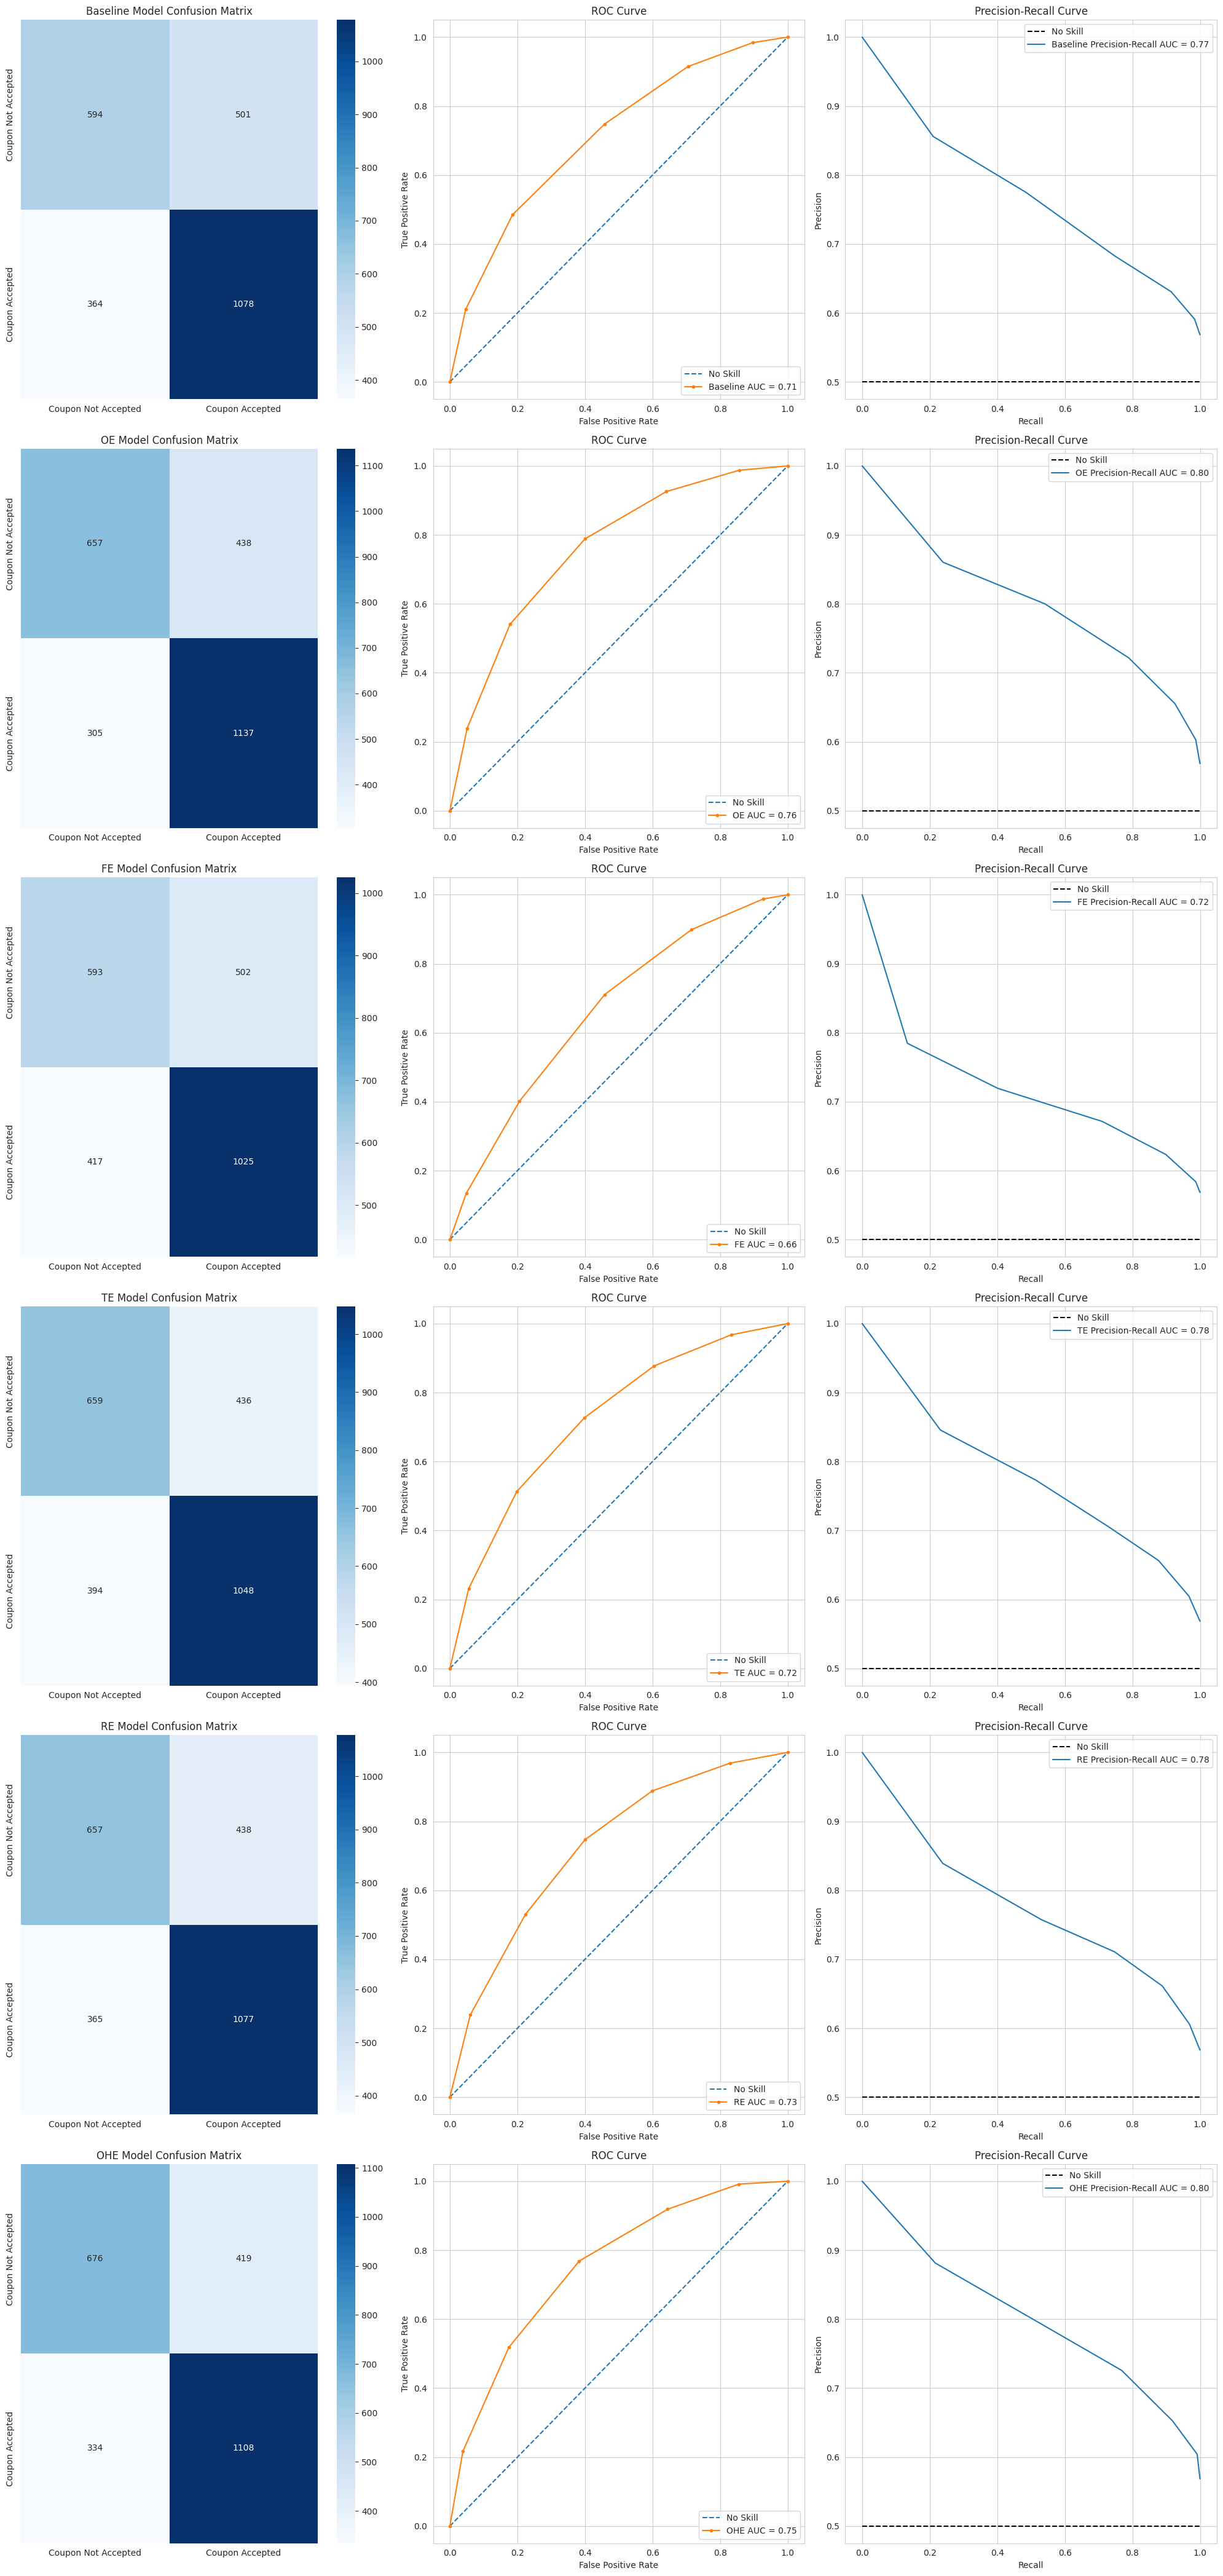

In [ ]:

# Instantiate your KNN models
knn_baseline = KNeighborsClassifier(n_neighbors=5).fit(X_train_baseline, y_train)
knn_oe = KNeighborsClassifier(n_neighbors=5).fit(X_train_Ordinal_encoding, y_train)
knn_fe = KNeighborsClassifier(n_neighbors=5).fit(X_train_frequency_encoding, y_train)
knn_te = KNeighborsClassifier(n_neighbors=5).fit(X_train_target_encoding, y_train)
knn_re = KNeighborsClassifier(n_neighbors=5).fit(X_train_response_encoding, y_train)
knn_ohe = KNeighborsClassifier(n_neighbors=5).fit(X_train_ohe, y_train)

models = [knn_baseline, knn_oe, knn_fe, knn_te, knn_re, knn_ohe]
model_names = ['Baseline', 'OE', 'FE', 'TE', 'RE', 'OHE']
X_tests = [X_test_baseline, X_test_Ordinal_encoding, X_test_frequency_encoding, X_test_target_encoding, X_test_response_encoding, X_test_ohe]

fig, axes = plt.subplots(len(models), 3, figsize=(20, len(models)*7))

for idx, (model, name, X_test) in enumerate(zip(models, model_names, X_tests)):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cm, index=["Coupon Not Accepted", "Coupon Accepted"], columns=["Coupon Not Accepted", "Coupon Accepted"]),
                annot=True, fmt="d", cmap="Blues", ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{name} Model Confusion Matrix')

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    axes[idx, 1].plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    axes[idx, 1].plot(fpr, tpr, marker='.', label=f'{name} AUC = {roc_auc:.2f}')
    axes[idx, 1].set_xlabel('False Positive Rate')
    axes[idx, 1].set_ylabel('True Positive Rate')
    axes[idx, 1].set_title('ROC Curve')
    axes[idx, 1].legend(loc=4)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    prc_auc = auc(recall, precision)
    axes[idx, 2].plot([0, 1], [0.5, 0.5],'k--', label='No Skill')
    axes[idx, 2].plot(recall, precision, label=f'{name} Precision-Recall AUC = {prc_auc:.2f}')
    axes[idx, 2].set_xlabel('Recall')
    axes[idx, 2].set_ylabel('Precision')
    axes[idx, 2].set_title('Precision-Recall Curve')
    axes[idx, 2].legend(loc=1)

plt.tight_layout()
plt.show()

#### 1.8.4.1.2 Accuracy, Recall, Precision, F1 score and Auc-Roc score in five different encoding methods

+----------+----------+--------+-----------+----------+---------+
|  Model   | Accuracy | Recall | Precision | F1 Score | AUC-ROC |
+----------+----------+--------+-----------+----------+---------+
| Baseline |  0.6590  | 0.7476 |   0.6827  |  0.7137  |  0.7109 |
|    OE    |  0.7071  | 0.7885 |   0.7219  |  0.7537  |  0.7585 |
|    FE    |  0.6378  | 0.7108 |   0.6713  |  0.6905  |  0.6647 |
|    TE    |  0.6728  | 0.7268 |   0.7062  |  0.7163  |  0.7240 |
|    RE    |  0.6835  | 0.7469 |   0.7109  |  0.7284  |  0.7272 |
|   OHE    |  0.7032  | 0.7684 |   0.7256  |  0.7464  |  0.7544 |
+----------+----------+--------+-----------+----------+---------+


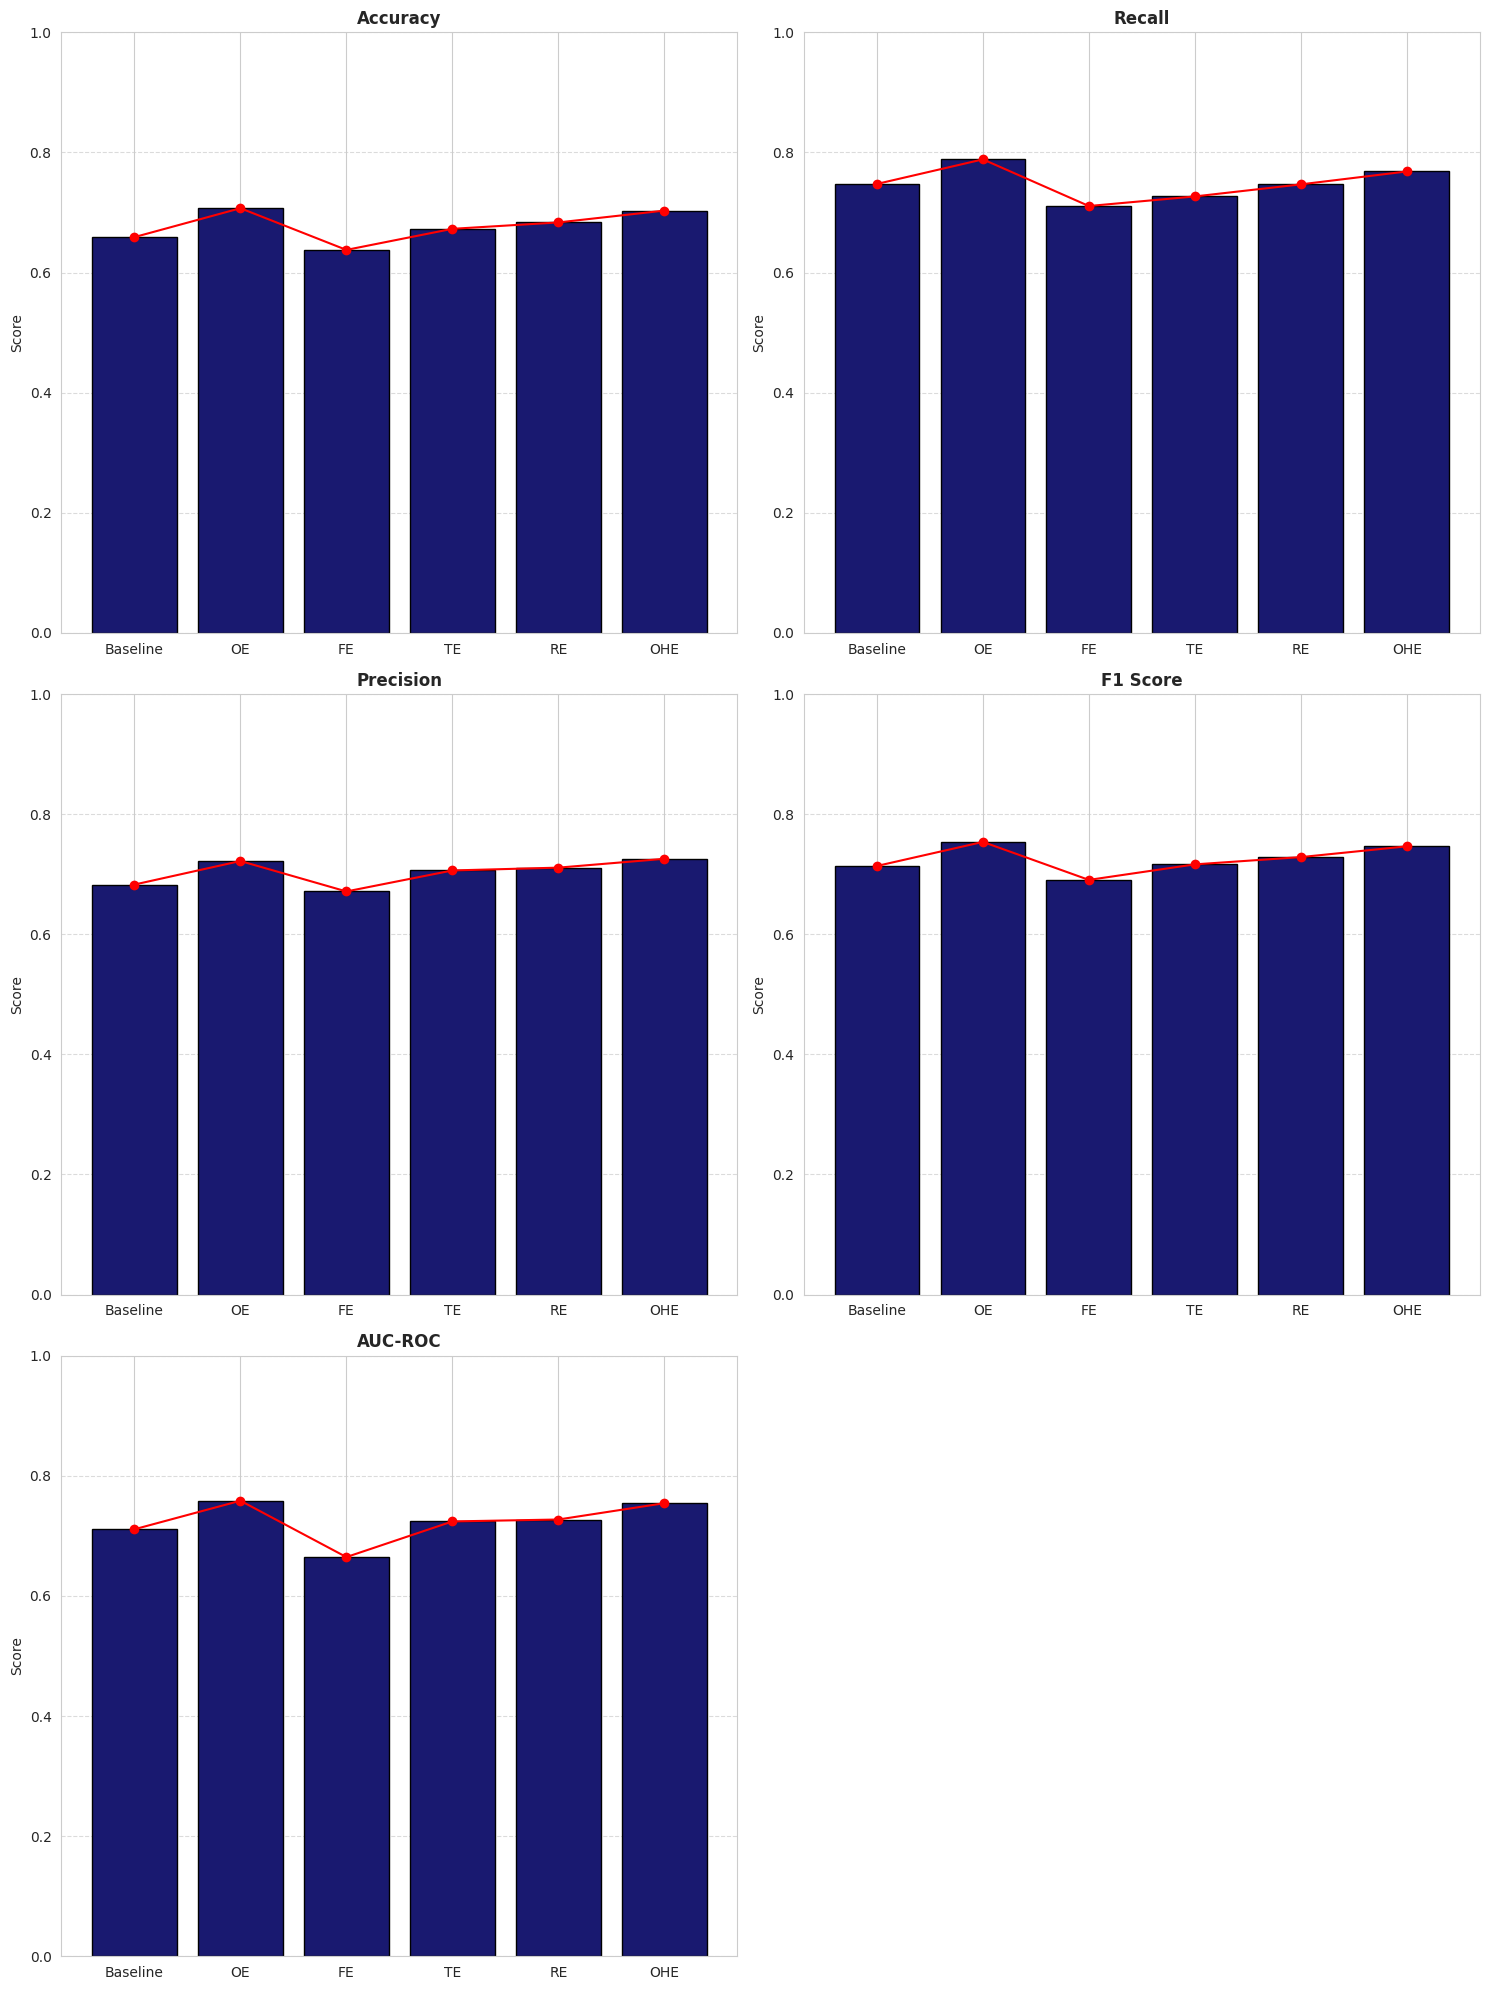

In [ ]:
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

models = [knn_baseline, knn_oe, knn_fe, knn_te, knn_re, knn_ohe]
model_names = ['Baseline', 'OE', 'FE', 'TE', 'RE', 'OHE']
X_tests = [X_test_baseline, X_test_Ordinal_encoding, X_test_frequency_encoding, X_test_target_encoding, X_test_response_encoding, X_test_ohe]

accuracy_list = []
recall_list = []
precision_list = []
f1_list = []
auc_roc_list = []

table = PrettyTable(['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC-ROC'])

for model, name, X_test in zip(models, model_names, X_tests):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    accuracy_list.append(accuracy)
    recall_list.append(recall)
    precision_list.append(precision)
    f1_list.append(f1)
    auc_roc_list.append(auc_roc)

    accuracy = "{:.4f}".format(accuracy)
    recall = "{:.4f}".format(recall)
    precision = "{:.4f}".format(precision)
    f1 = "{:.4f}".format(f1)
    auc_roc = "{:.4f}".format(auc_roc)

    table.add_row([name, accuracy, recall, precision, f1, auc_roc])

print(table)

all_metrics = [accuracy_list, recall_list, precision_list, f1_list, auc_roc_list]
metrics_names = ['Accuracy', 'Recall', 'Precision', 'F1 Score', 'AUC-ROC']

fig = plt.figure(figsize=(15, 20))
gs = gridspec.GridSpec(nrows=3, ncols=2)

for i, metric in enumerate(all_metrics):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    ax.bar(model_names, metric, color='midnightblue', edgecolor='black')
    ax.set_title(metrics_names[i], fontweight='bold')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Score')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.plot(model_names, metric, marker='o', color='red')

plt.tight_layout()
plt.show()

### 1.8.2 Model Comparison(Different Model)

In [ ]:
# Best parameter settings for different classifiers

DecisionTree_oe_best = DecisionTreeClassifier(criterion='gini', splitter='best', class_weight='balanced', max_leaf_nodes=10, max_depth=10, min_samples_split=10, random_state=42)

LogisticRegression_te_best = LogisticRegression(penalty='none', random_state=42, C=10.0, solver='newton-cg', max_iter=200, fit_intercept=True)

KNN_OHE_best = KNeighborsClassifier(n_neighbors=40, weights='uniform', algorithm='auto', leaf_size=30, p=2)

SVM_rbf_best = SVC(kernel="rbf", random_state=42, probability=True, gamma=0.1, C=1)

In [ ]:

models = [DecisionTree_oe_best, LogisticRegression_te_best, KNN_OHE_best, SVM_rbf_best]

# Initialize the table

table = PrettyTable()
table.field_names = ["Model", "Encoding Method", "Cross-Validation Score"]

encoding_methods = ["Ordinal Encoding", "One-Hot Encoding", "Target Encoding", "Response Encoding", "Frequency Encoding", "Baseline"]

for model in models:
    for encoding_method in encoding_methods:
        if encoding_method == "Ordinal Encoding":
            X_train = X_train_Ordinal_encoding
        elif encoding_method == "One-Hot Encoding":
            X_train = X_train_ohe
        elif encoding_method == "Target Encoding":
            X_train = X_train_target_encoding
        elif encoding_method == "Response Encoding":
            X_train = X_train_response_encoding
        elif encoding_method == "Frequency Encoding":
            X_train = X_train_frequency_encoding
        elif encoding_method == "Baseline":
            X_train = X_train_baseline

        scores = cross_val_score(model, X_train, y_train, cv=5)
        avg_score = scores.mean()

        # Add a row to the table
        table.add_row([type(model).__name__, encoding_method, avg_score])

# Print the table
print(table)

+------------------------+--------------------+------------------------+
|         Model          |  Encoding Method   | Cross-Validation Score |
+------------------------+--------------------+------------------------+
| DecisionTreeClassifier |  Ordinal Encoding  |   0.6974450273982912   |
| DecisionTreeClassifier |  One-Hot Encoding  |   0.6836488648585656   |
| DecisionTreeClassifier |  Target Encoding   |   0.6981360907239121   |
| DecisionTreeClassifier | Response Encoding  |   0.698234661448407    |
| DecisionTreeClassifier | Frequency Encoding |   0.6851270372699308   |
| DecisionTreeClassifier |      Baseline      |   0.6667976896576002   |
|   LogisticRegression   |  Ordinal Encoding  |   0.6998106276721529   |
|   LogisticRegression   |  One-Hot Encoding  |   0.7116374636732891   |
|   LogisticRegression   |  Target Encoding   |   0.7080900829596467   |
|   LogisticRegression   | Response Encoding  |   0.7084841716295973   |
|   LogisticRegression   | Frequency Encoding |   0

In [ ]:
print(table)

+------------------------+--------------------+------------------------+
|         Model          |  Encoding Method   | Cross-Validation Score |
+------------------------+--------------------+------------------------+
| DecisionTreeClassifier |  Ordinal Encoding  |   0.6974450273982912   |
| DecisionTreeClassifier |  One-Hot Encoding  |   0.6836488648585656   |
| DecisionTreeClassifier |  Target Encoding   |   0.6981360907239121   |
| DecisionTreeClassifier | Response Encoding  |   0.698234661448407    |
| DecisionTreeClassifier | Frequency Encoding |   0.6851270372699308   |
| DecisionTreeClassifier |      Baseline      |   0.6667976896576002   |
|   LogisticRegression   |  Ordinal Encoding  |   0.6998106276721529   |
|   LogisticRegression   |  One-Hot Encoding  |   0.7116374636732891   |
|   LogisticRegression   |  Target Encoding   |   0.7080900829596467   |
|   LogisticRegression   | Response Encoding  |   0.7084841716295973   |
|   LogisticRegression   | Frequency Encoding |   0

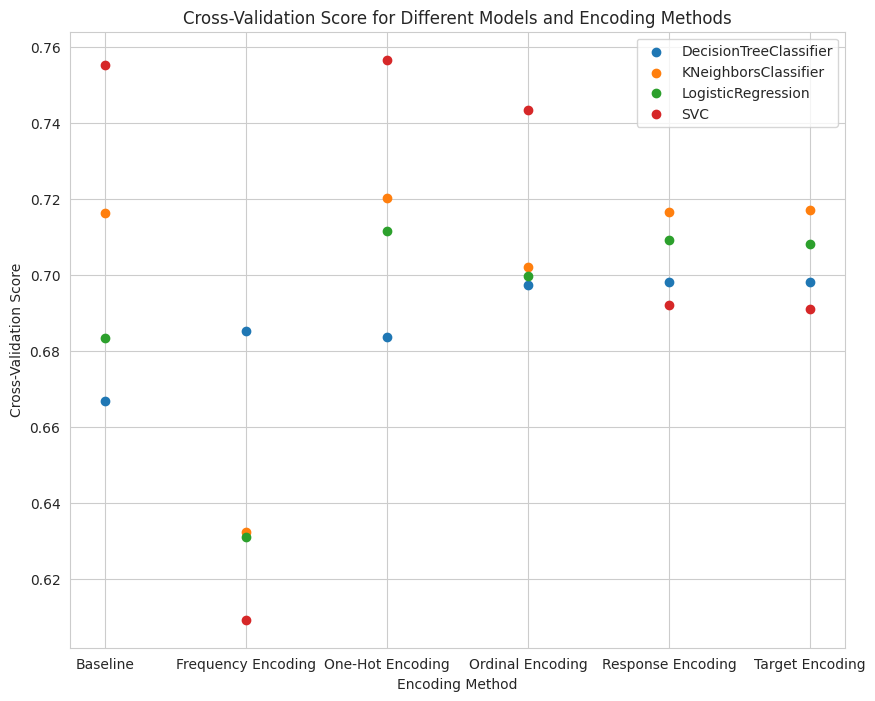

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert PrettyTable to DataFrame
data = [
    ["DecisionTreeClassifier", "Ordinal Encoding", 0.6974450273982912],
    ["DecisionTreeClassifier", "One-Hot Encoding", 0.6836488648585656],
    ["DecisionTreeClassifier", "Target Encoding", 0.6981360907239121],
    ["DecisionTreeClassifier", "Response Encoding", 0.6981360907239121],
    ["DecisionTreeClassifier", "Frequency Encoding", 0.6851270372699308],
    ["DecisionTreeClassifier", "Baseline", 0.6667976896576002],
    ["LogisticRegression", "Ordinal Encoding", 0.6998106276721529],
    ["LogisticRegression", "One-Hot Encoding", 0.7116373665592747],
    ["LogisticRegression", "Target Encoding", 0.7080900829596467],
    ["LogisticRegression", "Response Encoding", 0.7092724946405203],
    ["LogisticRegression", "Frequency Encoding", 0.6310246256861712],
    ["LogisticRegression", "Baseline", 0.6833545608382883],
    ["KNeighborsClassifier", "Ordinal Encoding", 0.7021778303272499],
    ["KNeighborsClassifier", "One-Hot Encoding", 0.7202123397922244],
    ["KNeighborsClassifier", "Target Encoding", 0.7169592145418525],
    ["KNeighborsClassifier", "Response Encoding", 0.7166641336094608],
    ["KNeighborsClassifier", "Frequency Encoding", 0.6325018269573937],
    ["KNeighborsClassifier", "Baseline", 0.7162718415487743],
    ["SVC", "Ordinal Encoding", 0.7434693010461607],
    ["SVC", "One-Hot Encoding", 0.7565772165666796],
    ["SVC", "Target Encoding", 0.6909417388749827],
    ["SVC", "Response Encoding", 0.692026065401433],
    ["SVC", "Frequency Encoding", 0.6093428537438668],
    ["SVC", "Baseline", 0.7552966226173684]
]

df = pd.DataFrame(data, columns=["Model", "Encoding Method", "Cross-Validation Score"])

# Pivot the DataFrame
df_pivot = df.pivot(index="Encoding Method", columns="Model", values="Cross-Validation Score")

# Plot the DataFrame
# Plot the DataFrame
plt.figure(figsize=(10, 8))
for column in df_pivot.columns:
    plt.scatter(df_pivot.index, df_pivot[column], label=column)
plt.legend()
plt.xlabel('Encoding Method')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Score for Different Models and Encoding Methods')
plt.show()

In [ ]:
from sklearn.ensemble import StackingClassifier

# Set the random state
random_state = 42


def Stacking_Classifier(x_train,y_train,x_test,y_test):
  """This function returns best hyperparameter, train and test log_loss & roc_auc_score of Stacking_Classifier Model"""
  base_models = [
    ('decision_tree', DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=random_state)),
    ('logistic_regression', LogisticRegression(penalty='none', C=10.0, random_state=random_state)),
    ('KNN',KNeighborsClassifier(n_neighbors=40,weights='uniform',algorithm='auto',leaf_size=30, p=2) ),
    ('svm', SVC(kernel='rbf', probability=True, gamma=0.1, C=1, random_state=random_state))
]

  clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
  clf.fit(x_train, y_train)

  Train_loss = log_loss(y_train,clf.predict_proba(x_train))
  Train_AUC = roc_auc_score(y_train,clf.predict_proba(x_train)[:,1])
  Test_loss = log_loss(y_test,clf.predict_proba(x_test))
  Test_AUC = roc_auc_score(y_test,clf.predict_proba(x_test)[:,1])

  return Train_loss,Train_AUC,Test_loss,Test_AUC


In [ ]:
# Ordinal Encoding
Train_loss_OrEnc, Train_AUC_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc = Stacking_Classifier(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = Stacking_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
Train_loss_TarEnc, Train_AUC_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc = Stacking_Classifier(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
Train_loss_ResEnc, Train_AUC_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc = Stacking_Classifier(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
Train_loss_ohe, Train_AUC_ohe, Test_loss_ohe, Test_AUC_ohe = Stacking_Classifier(X_train_ohe.toarray(),y_train,X_test_ohe.toarray(),y_test)

In [ ]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Stacking Classifier","Ordinal Encoding",'','',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Stacking Classifier","Frequency Encoding",'','',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Stacking Classifier","Target Encoding",'','',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Stacking Classifier","Response Encoding",'','',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Stacking Classifier","One Hot Encoding",'','',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
Stacking_Classifier_Result = table[0]
Stacking_Classifier_Result

Model            Encoding  Hyperparameter1  Hyperparameter2  \
0  Stacking Classifier    Ordinal Encoding              NaN              NaN   
1  Stacking Classifier  Frequency Encoding              NaN              NaN   
2  Stacking Classifier     Target Encoding              NaN              NaN   
3  Stacking Classifier   Response Encoding              NaN              NaN   
4  Stacking Classifier    One Hot Encoding              NaN              NaN   

   Train_log_loss  Train_roc_auc_score  Test_log_loss  Test_roc_auc_score  
0           0.343                0.950          0.524               0.809  
1           0.483                0.869          0.627               0.699  
2           0.491                0.845          0.566               0.770  
3           0.494                0.842          0.566               0.769  
4           0.325                0.957          0.496               0.835

In [ ]:
# Stacking Classifier Model

# Set the random state
random_state = 42

def Stacking_Classifier(x_train, y_train, x_test, y_test):
    """
    This function returns the best hyperparameters, train and test log_loss, and roc_auc_score of the Stacking Classifier Model.
    """

    # Define base models
    base_models = [
        ('decision_tree', DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=random_state)),
        ('logistic_regression', LogisticRegression(penalty='none', C=10.0, random_state=random_state)),
        ('svm', SVC(kernel='rbf', probability=True, gamma=0.1, C=1, random_state=random_state)),
        ('knn', KNeighborsClassifier(n_neighbors=40))
    ]

    # Create the stacking classifier
    clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

    # Fit the stacking classifier to the training data
    clf.fit(x_train, y_train)

    # Calculate the log loss and roc_auc_score for the training and test data
    train_loss = log_loss(y_train, clf.predict_proba(x_train))
    train_auc = roc_auc_score(y_train, clf.predict_proba(x_train)[:, 1])
    test_loss = log_loss(y_test, clf.predict_proba(x_test))
    test_auc = roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])

    return train_loss, train_auc, test_loss, test_auc


# Ordinal Encoding
Train_loss_OrEnc, Train_AUC_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc = Stacking_Classifier(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = Stacking_Classifier(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
Train_loss_TarEnc, Train_AUC_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc = Stacking_Classifier(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
Train_loss_ResEnc, Train_AUC_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc = Stacking_Classifier(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
Train_loss_ohe, Train_AUC_ohe, Test_loss_ohe, Test_AUC_ohe = Stacking_Classifier(X_train_ohe.toarray(),y_train,X_test_ohe.toarray(),y_test)

In [ ]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Stacking Classifier","Ordinal Encoding",'','',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Stacking Classifier","Frequency Encoding",'','',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Stacking Classifier","Target Encoding",'','',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Stacking Classifier","Response Encoding",'','',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Stacking Classifier","One Hot Encoding",'','',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
Stacking_Classifier_Result = table[0]
Stacking_Classifier_Result

Model            Encoding  Hyperparameter1  Hyperparameter2  \
0  Stacking Classifier    Ordinal Encoding              NaN              NaN   
1  Stacking Classifier  Frequency Encoding              NaN              NaN   
2  Stacking Classifier     Target Encoding              NaN              NaN   
3  Stacking Classifier   Response Encoding              NaN              NaN   
4  Stacking Classifier    One Hot Encoding              NaN              NaN   

   Train_log_loss  Train_roc_auc_score  Test_log_loss  Test_roc_auc_score  
0           0.343                0.950          0.524               0.809  
1           0.483                0.869          0.627               0.699  
2           0.491                0.845          0.566               0.770  
3           0.494                0.842          0.566               0.769  
4           0.325                0.957          0.496               0.835

In [ ]:
# Stacking Classifier with XGBoost as final estimator

# Set the random state
random_state = 42

def Stacking_Classifier_xgboost(x_train, y_train, x_test, y_test):
    """
    This function returns the best hyperparameters, train and test log_loss, and roc_auc_score of the Stacking Classifier Model with XGBoost as the final estimator.
    """

    # Define base models
    base_models = [
        ('decision_tree', DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=random_state)),
        ('logistic_regression', LogisticRegression(penalty='none', C=10.0, random_state=random_state)),
        ('svm', SVC(kernel='rbf', probability=True, gamma=0.1, C=1, random_state=random_state)),
        ('knn', KNeighborsClassifier(n_neighbors=40))
    ]

    # Create the stacking classifier
    clf = StackingClassifier(estimators=base_models, final_estimator=XGBClassifier())

    # Fit the stacking classifier to the training data
    clf.fit(x_train, y_train)

    # Calculate the log loss and roc_auc_score for the training and test data
    train_loss = log_loss(y_train, clf.predict_proba(x_train))
    train_auc = roc_auc_score(y_train, clf.predict_proba(x_train)[:, 1])
    test_loss = log_loss(y_test, clf.predict_proba(x_test))
    test_auc = roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])

    return train_loss, train_auc, test_loss, test_auc

# Ordinal Encoding
Train_loss_OrEnc, Train_AUC_OrEnc, Test_loss_OrEnc, Test_AUC_OrEnc = Stacking_Classifier_xgboost(X_train_Ordinal_encoding,y_train,X_test_Ordinal_encoding,y_test)
# Frequency Encoding
Train_loss_FreEnc, Train_AUC_FreEnc, Test_loss_FreEnc, Test_AUC_FreEnc = Stacking_Classifier_xgboost(X_train_frequency_encoding,y_train,X_test_frequency_encoding,y_test)
# Target Encoding
Train_loss_TarEnc, Train_AUC_TarEnc, Test_loss_TarEnc, Test_AUC_TarEnc = Stacking_Classifier_xgboost(X_train_target_encoding,y_train,X_test_target_encoding,y_test)
# Response Encoding
Train_loss_ResEnc, Train_AUC_ResEnc, Test_loss_ResEnc, Test_AUC_ResEnc = Stacking_Classifier_xgboost(X_train_response_encoding,y_train,X_test_response_encoding,y_test)
# One Hot Encoding
Train_loss_ohe, Train_AUC_ohe, Test_loss_ohe, Test_AUC_ohe = Stacking_Classifier_xgboost(X_train_ohe.toarray(),y_train,X_test_ohe.toarray(),y_test)

In [ ]:
summary_table = PrettyTable(["Model","Encoding", "Hyperparameter1", "Hyperparameter2", "Train_log_loss", "Train_roc_auc_score", "Test_log_loss", "Test_roc_auc_score"]) #heading

summary_table.add_row(["Stacking Classifier","Ordinal Encoding",'','',round(Train_loss_OrEnc,3),round(Train_AUC_OrEnc,3),round(Test_loss_OrEnc,3),round(Test_AUC_OrEnc,3)])
summary_table.add_row(["Stacking Classifier","Frequency Encoding",'','',round(Train_loss_FreEnc,3),round(Train_AUC_FreEnc,3),round(Test_loss_FreEnc,3),round(Test_AUC_FreEnc,3)])
summary_table.add_row(["Stacking Classifier","Target Encoding",'','',round(Train_loss_TarEnc,3),round(Train_AUC_TarEnc,3),round(Test_loss_TarEnc,3),round(Test_AUC_TarEnc,3)])
summary_table.add_row(["Stacking Classifier","Response Encoding",'','',round(Train_loss_ResEnc,3),round(Train_AUC_ResEnc,3),round(Test_loss_ResEnc,3),round(Test_AUC_ResEnc,3)])
summary_table.add_row(["Stacking Classifier","One Hot Encoding",'','',round(Train_loss_ohe,3),round(Train_AUC_ohe,3),round(Test_loss_ohe,3),round(Test_AUC_ohe,3)])

table = pd.read_html(summary_table.get_html_string())
Stacking_Classifier_Result = table[0]
Stacking_Classifier_Result

Model            Encoding  Hyperparameter1  Hyperparameter2  \
0  Stacking Classifier    Ordinal Encoding              NaN              NaN   
1  Stacking Classifier  Frequency Encoding              NaN              NaN   
2  Stacking Classifier     Target Encoding              NaN              NaN   
3  Stacking Classifier   Response Encoding              NaN              NaN   
4  Stacking Classifier    One Hot Encoding              NaN              NaN   

   Train_log_loss  Train_roc_auc_score  Test_log_loss  Test_roc_auc_score  
0           0.349                0.927          0.579               0.779  
1           0.495                0.834          0.675               0.678  
2           0.517                0.816          0.618               0.737  
3           0.504                0.826          0.612               0.742  
4           0.309                0.946          0.530               0.817